In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ultralytics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 10.3 MB/s eta 0:00:00


In [3]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.1 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 29.0/201.2 GB disk)


In [4]:
import shutil
# video will be copied into kaggle/working directory it's eaisier to download it and check the results
shutil.copy('/content/drive/MyDrive/KITA_1026/project/ocr/Movie003_1.mp4', '/content/Movie003_1.mp4')

'/content/Movie003_1.mp4'

In [50]:
import shutil
# video will be copied into kaggle/working directory it's eaisier to download it and check the results
shutil.copy('/content/output_video4.mp4', '/content/drive/MyDrive/KITA_1026/project/ocr/output_video_20240419.mp4')

'/content/drive/MyDrive/KITA_1026/project/ocr/output_video_20240419.mp4'

### 하이퍼파라미터 튜닝된 best.pt 모델로 결과 도출

In [19]:
import cv2
from ultralytics import YOLO
from google.colab.patches import cv2_imshow
from ultralytics.engine.results import Results

model = YOLO('/content/drive/MyDrive/KITA_1026/project/ocr/obstacles_data/yolov8s_epoch50_객체28/weights/best.pt')
model2 = YOLO('/content/drive/MyDrive/KITA_1026/project/ocr/data_surface_complete/yolov8m_seg epoch100/weights/best.pt')

# Open the video file
video_path = "/content/Movie003_1.mp4"
cap = cv2.VideoCapture(video_path)
assert cap.isOpened(), "Error reading video file" # 비디오 파일이 성공적으로 열렸는지 확인
# cap.get() 메서드를 사용하여 비디오의 너비(cv2.CAP_PROP_FRAME_WIDTH), 높이(cv2.CAP_PROP_FRAME_HEIGHT), 그리고 프레임 레이트(cv2.CAP_PROP_FPS)를 추출
w, h, fps = (int(cap.get(x)) for x in (cv2.CAP_PROP_FRAME_WIDTH, cv2.CAP_PROP_FRAME_HEIGHT, cv2.CAP_PROP_FPS))
result = cv2.VideoWriter("result17.avi",
                       cv2.VideoWriter_fourcc(*'mp4v'), # 비디오 코딩 형식을 지정. 'mp4v' 코덱을 사용
                       fps,
                       (w, h))

# Loop through the video frames
prev_commentary = ""
prev_surface_comment = ""
prev_b_commentary = ""
prev_traffic_color = ""
count_continued_traffic_green = 0
count_frames = 0
count_b_frames = 0
current_comment_list = []
while cap.isOpened():
    # Read a frame from the video
    success, frame = cap.read()

    if success:
        # Run YOLOv8 inference on the frame
        # results = model(frame,conf=0.5)
        # run models for the frame
        res_surface = model2(frame, conf=0.5)
        results = model(frame, conf=0.4)

        filtered_results = Results(orig_img = results[0].orig_img, path = results[0].path, boxes = filter_index_wihtin_trapezoid(results, w, h), names = results[0].names) # 사다리꼴 영역 내의 results

        # 결과를 프레임에 시각적으로 표현하기
        annotated_frame_obstacles = results[0].plot(font_size=10,line_width=2)
        annotated_frame_obstacles_trapezoid = filtered_results.plot(font_size=10, line_width=-1) # 사다리꼴 영역내는 box fill 하기
        annotated_frame = res_surface[0].plot(font_size=10,line_width=2)
        beta = 0.4
        cv2.addWeighted(annotated_frame_obstacles_trapezoid, beta, annotated_frame_obstacles, 1- beta, 0, annotated_frame_obstacles)
        alpha = 0.7
        cv2.addWeighted(annotated_frame_obstacles , alpha, annotated_frame, 1 - alpha,0,annotated_frame)

        # 노면 데이터 추출하기
        surface_lists = surface_kind(w, h, res_surface)

        braille_index = surface_lists[0]
        roadway_index = surface_lists[1]
        crosswalk_index = surface_lists[2]

        surface_comment = ""

        # crosswalk_comment가 ""이 아닐 경우
        crosswalk_comment = crosswalk_commentary(h, crosswalk_index, res_surface)
        traffic_comment = ""
        current_traffic_color = ""
        if crosswalk_comment: # 횡단보도가 있을 경우 장애물 알림은 하지 않고, 신호등 알림을 한다.
          traffic_light_boxes = traffic_light_finder(results)
          if len(traffic_light_boxes) == 0:
            # traffic_comment = "신호등이 없는 횡단보도입니다."
            traffic_comment = ""
            current_traffic_color = ""
          else:
            traffic_colors = {'green': 0, 'red':0}
            for i in range(len(traffic_light_boxes)):
              color = traffic_light_color(traffic_light_boxes[i],frame)
              if color == "green":
                traffic_colors['green'] += 1
              elif color == "red":
                traffic_colors['red'] += 1
            if traffic_colors['green'] + traffic_colors['red'] == 0:
              # traffic_comment = "신호등 색깔이 감지되지 않습니다."
              traffic_comment = "신호등"
              current_traffic_color = ""
            else:
              if traffic_colors['green'] > traffic_colors['red']:
                traffic_comment = "신호등 초록불"
                # traffic_comment = "신호등에 초록불이 들어왔습니다. 조심히 건너세요."
                current_traffic_color = "green"
              elif traffic_colors['green'] < traffic_colors['red']:
                traffic_comment = "신호등 빨간불"
                # traffic_comment = "신호등에 빨간불이 들어왔습니다. 멈춰주세요."
                current_traffic_color = "red"
              else:
                traffic_comment = "신호등"
                # traffic_comment = "신호등 색깔이 감지되지 않습니다."
                current_traffic_color = ""
          surface_comment = crosswalk_comment + " " + traffic_comment
          print(surface_comment)
          if current_traffic_color == 'green':
            if prev_traffic_color == 'green':
              count_continued_traffic_green += 1
            else:
              count_continued_traffic_green = 0
          if prev_surface_comment != surface_comment:
            if prev_traffic_color == 'red':
              if current_traffic_color == 'green':
                if count_continued_traffic_green > 10:
                  captioned_frame = draw_text_box(annotated_frame, surface_comment, 100)
                  result.write(captioned_frame)
                  prev_traffic_color = current_traffic_color
                  prev_surface_comment = surface_comment
                else:
                  captioned_frame = draw_text_box(annotated_frame, prev_surface_comment, 100)
                  result.write(captioned_frame)
                  prev_traffic_color = current_traffic_color
              else:
                captioned_frame = draw_text_box(annotated_frame, prev_surface_comment, 100)
                result.write(captioned_frame)
                prev_traffic_color = current_traffic_color
            else:
              captioned_frame = draw_text_box(annotated_frame, surface_comment, 100)
              result.write(captioned_frame)
              prev_traffic_color = current_traffic_color
              prev_surface_comment = surface_comment
          else:
            if prev_surface_comment == "":
              result.write(annotated_frame)
              prev_traffic_color = current_traffic_color
            else:
              if current_traffic_color == 'green':
                if count_continued_traffic_green > 10:
                  captioned_frame = draw_text_box(annotated_frame, surface_comment, 100)
                  result.write(captioned_frame)
                  prev_traffic_color = current_traffic_color
                else:
                  captioned_frame = draw_text_box(annotated_frame, prev_surface_comment, 100)
                  result.write(captioned_frame)
                  prev_traffic_color = current_traffic_color
              else:
                captioned_frame = draw_text_box(annotated_frame, prev_surface_comment, 100)
                result.write(captioned_frame)
                prev_traffic_color = current_traffic_color
        else: # 횡단보도가 없을 경우
          # 장애물 commentary
          current_commentary = obstacle_commentary(results, w, h)
          print(current_commentary)
          if current_commentary:
            if prev_commentary != current_commentary:
              captioned_frame = draw_text_box(annotated_frame, current_commentary, 100)
              prev_commentary = current_commentary
              count_frames = 0
            else:
              if count_frames < 60:
                count_frames += 1
                captioned_frame = draw_text_box(annotated_frame, current_commentary, 100)
              else:
                count_frames += 1
                captioned_frame = annotated_frame
          else:
            if count_frames < 60:
              count_frames += 1
              captioned_frame = draw_text_box(annotated_frame, prev_commentary, 100)
            else:
              count_frames += 1
              captioned_frame = annotated_frame
          # 유도블록 commentary
          current_b_commentary = braille_commentary(w, h, braille_index, res_surface)
          print(current_b_commentary)
          if current_b_commentary:
            if prev_b_commentary != current_b_commentary:
              b_captioned_frame = draw_text_box(captioned_frame, current_b_commentary, 150)
              prev_b_commentary = current_b_commentary
              count_b_frames = 0
            else:
              if count_b_frames < 60:
                count_b_frames += 1
                b_captioned_frame = draw_text_box(captioned_frame, prev_b_commentary, 150)
              else:
                count_b_frames += 1
                b_captioned_frame = captioned_frame
          else:
            if count_b_frames <60:
              if prev_b_commentary == "":
                b_captioned_frame = annotated_frame
              else:
                count_b_frames += 1
                b_captioned_frame = draw_text_box(captioned_frame, prev_b_commentary, 150)
            else:
              count_b_frames += 1
              b_captioned_frame = captioned_frame
          result.write(b_captioned_frame)

        # Display the annotated frame
        # cv2_imshow(annotated_frame)
        if surface_comment:
          current_comment_list.append(surface_comment)
        elif current_commentary:
          current_comment_list.append(current_commentary)
        elif current_b_commentary:
          current_comment_list.append(current_b_commentary)
        else:
          current_comment_list.append("")

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        # Break the loop if the end of the video is reached
        break

# Release the video capture object and close the display window
cap.release()
cv2.destroyAllWindows()


0: 576x1024 2 roadways, 60.3ms
Speed: 5.1ms preprocess, 60.3ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 7 cars, 3 motorcycles, 4 tree_trunks, 2 scooters, 2 poles, 12.6ms
Speed: 3.6ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 33.8ms
Speed: 5.5ms preprocess, 33.8ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 7 cars, 3 motorcycles, 4 tree_trunks, 2 scooters, 2 poles, 11.9ms
Speed: 4.1ms preprocess, 11.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 33.8ms
Speed: 7.1ms preprocess, 33.8ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 7 cars, 3 motorcycles, 4 tree_trunks, 3 scooters, 2 poles, 11.9ms
Speed: 5.0ms preprocess, 11.9ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 33.8ms
Speed: 3.8ms preprocess, 33.8ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 7 cars, 2 motorcycles, 4 tree_trunks, 3 scooters, 2 poles, 12.3ms
Speed: 6.4ms preprocess, 12.3ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 30.5ms
Speed: 5.1ms preprocess, 30.5ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 6 cars, 2 motorcycles, 4 tree_trunks, 3 scooters, 2 poles, 10.7ms
Speed: 3.5ms preprocess, 10.7ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)





0: 576x1024 1 roadway, 30.1ms
Speed: 5.2ms preprocess, 30.1ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 8 cars, 2 motorcycles, 4 tree_trunks, 3 scooters, 1 truck, 2 poles, 11.5ms
Speed: 4.3ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 29.7ms
Speed: 4.0ms preprocess, 29.7ms inference, 3.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 8 cars, 3 motorcycles, 4 tree_trunks, 3 scooters, 1 truck, 2 poles, 14.7ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 4.9ms preprocess, 14.7ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 29.7ms
Speed: 5.5ms preprocess, 29.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 8 cars, 2 motorcycles, 4 tree_trunks, 3 scooters, 1 truck, 2 poles, 10.7ms
Speed: 4.6ms preprocess, 10.7ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 29.5ms
Speed: 4.3ms preprocess, 29.5ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 6 cars, 2 motorcycles, 4 tree_trunks, 3 scooters, 2 trucks, 2 poles, 11.7ms
Speed: 4.9ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


오른쪽 나무


0: 576x1024 1 roadway, 29.8ms
Speed: 5.6ms preprocess, 29.8ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 6 cars, 2 motorcycles, 4 tree_trunks, 3 scooters, 2 trucks, 2 poles, 10.8ms
Speed: 4.9ms preprocess, 10.8ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 1 roadway, 29.6ms
Speed: 4.2ms preprocess, 29.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 5 cars, 2 motorcycles, 4 tree_trunks, 3 scooters, 2 trucks, 2 poles, 10.9ms
Speed: 4.7ms preprocess, 10.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


오른쪽 나무


0: 576x1024 1 roadway, 29.1ms
Speed: 3.7ms preprocess, 29.1ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 5 cars, 2 motorcycles, 4 tree_trunks, 3 scooters, 2 trucks, 2 poles, 10.8ms
Speed: 5.1ms preprocess, 10.8ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 3 roadways, 28.8ms
Speed: 4.5ms preprocess, 28.8ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 6 cars, 2 motorcycles, 3 tree_trunks, 1 traffic_light, 3 scooters, 2 trucks, 2 poles, 11.5ms
Speed: 6.2ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


오른쪽 나무


0: 576x1024 3 roadways, 29.0ms
Speed: 4.1ms preprocess, 29.0ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 6 cars, 2 motorcycles, 3 tree_trunks, 3 scooters, 1 truck, 2 poles, 12.1ms
Speed: 5.3ms preprocess, 12.1ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 3 roadways, 29.1ms
Speed: 4.3ms preprocess, 29.1ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 6 cars, 2 motorcycles, 4 tree_trunks, 3 scooters, 1 truck, 3 poles, 11.4ms
Speed: 5.5ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


오른쪽 나무


0: 576x1024 3 roadways, 29.6ms
Speed: 5.1ms preprocess, 29.6ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 6 cars, 2 motorcycles, 4 tree_trunks, 3 scooters, 1 truck, 3 poles, 10.8ms
Speed: 5.0ms preprocess, 10.8ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 3 roadways, 29.5ms
Speed: 5.7ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 6 cars, 2 motorcycles, 4 tree_trunks, 3 scooters, 1 truck, 3 poles, 12.5ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 5.2ms preprocess, 12.5ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 3 roadways, 29.5ms
Speed: 4.9ms preprocess, 29.5ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 7 cars, 2 motorcycles, 4 tree_trunks, 3 scooters, 1 truck, 2 poles, 10.9ms
Speed: 4.8ms preprocess, 10.9ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 3 roadways, 28.8ms
Speed: 5.1ms preprocess, 28.8ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 7 cars, 2 motorcycles, 3 tree_trunks, 3 scooters, 1 truck, 2 poles, 11.7ms
Speed: 5.5ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 3 roadways, 28.8ms
Speed: 4.0ms preprocess, 28.8ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 7 cars, 2 motorcycles, 4 tree_trunks, 3 scooters, 1 truck, 2 poles, 11.9ms
Speed: 5.0ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 3 roadways, 29.2ms
Speed: 4.6ms preprocess, 29.2ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 7 cars, 2 motorcycles, 4 tree_trunks, 3 scooters, 1 truck, 3 poles, 10.9ms
Speed: 3.9ms preprocess, 10.9ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


오른쪽 나무


0: 576x1024 3 roadways, 29.4ms
Speed: 7.1ms preprocess, 29.4ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 7 cars, 2 motorcycles, 4 tree_trunks, 3 scooters, 1 truck, 3 poles, 10.8ms
Speed: 5.0ms preprocess, 10.8ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 3 roadways, 29.0ms
Speed: 5.4ms preprocess, 29.0ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 7 cars, 3 motorcycles, 4 tree_trunks, 2 scooters, 1 truck, 3 poles, 11.2ms
Speed: 4.5ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


오른쪽 나무


0: 576x1024 2 roadways, 28.7ms
Speed: 5.1ms preprocess, 28.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 5 cars, 3 motorcycles, 4 tree_trunks, 2 scooters, 1 truck, 2 poles, 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 3 roadways, 28.9ms
Speed: 8.9ms preprocess, 28.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 4 cars, 2 motorcycles, 4 tree_trunks, 3 scooters, 1 truck, 2 poles, 12.1ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 5.2ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 3 roadways, 29.2ms
Speed: 4.4ms preprocess, 29.2ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 4 cars, 2 motorcycles, 4 tree_trunks, 1 traffic_light, 3 scooters, 1 truck, 2 poles, 11.6ms
Speed: 6.2ms preprocess, 11.6ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 2 roadways, 29.2ms
Speed: 3.7ms preprocess, 29.2ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 4 cars, 2 motorcycles, 4 tree_trunks, 1 traffic_light, 3 scooters, 1 truck, 2 poles, 10.8ms
Speed: 4.6ms preprocess, 10.8ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


오른쪽 나무


0: 576x1024 2 roadways, 28.8ms
Speed: 5.2ms preprocess, 28.8ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 4 cars, 1 motorcycle, 4 tree_trunks, 2 scooters, 1 truck, 2 poles, 11.8ms
Speed: 5.1ms preprocess, 11.8ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 2 roadways, 29.3ms
Speed: 5.5ms preprocess, 29.3ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 4 cars, 3 motorcycles, 4 tree_trunks, 2 scooters, 1 truck, 2 poles, 13.0ms
Speed: 6.2ms preprocess, 13.0ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


오른쪽 나무


0: 576x1024 3 roadways, 28.8ms
Speed: 4.9ms preprocess, 28.8ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 4 cars, 2 motorcycles, 4 tree_trunks, 2 scooters, 1 truck, 3 poles, 11.8ms
Speed: 4.8ms preprocess, 11.8ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 3 roadways, 29.3ms
Speed: 4.9ms preprocess, 29.3ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 4 cars, 2 motorcycles, 4 tree_trunks, 1 traffic_light, 3 scooters, 2 trucks, 3 poles, 11.0ms
Speed: 4.8ms preprocess, 11.0ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


오른쪽 나무


0: 576x1024 3 roadways, 29.1ms
Speed: 5.5ms preprocess, 29.1ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 3 cars, 2 motorcycles, 4 tree_trunks, 1 traffic_light, 3 scooters, 1 truck, 3 poles, 11.2ms
Speed: 5.8ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 3 roadways, 29.2ms
Speed: 5.9ms preprocess, 29.2ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 cars, 2 motorcycles, 4 tree_trunks, 1 traffic_light, 2 scooters, 1 truck, 3 poles, 10.7ms
Speed: 4.7ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


오른쪽 나무


0: 576x1024 3 roadways, 29.4ms
Speed: 5.9ms preprocess, 29.4ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 3 cars, 2 motorcycles, 3 tree_trunks, 1 traffic_light, 2 scooters, 1 truck, 3 poles, 10.7ms
Speed: 5.5ms preprocess, 10.7ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 3 roadways, 29.1ms
Speed: 4.9ms preprocess, 29.1ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 3 cars, 2 motorcycles, 3 tree_trunks, 1 traffic_light, 2 scooters, 1 truck, 3 poles, 10.9ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 5.0ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 3 roadways, 28.8ms
Speed: 7.7ms preprocess, 28.8ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 3 cars, 1 motorcycle, 3 tree_trunks, 1 traffic_light, 2 scooters, 2 trucks, 3 poles, 11.8ms
Speed: 5.0ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 3 roadways, 29.3ms
Speed: 5.1ms preprocess, 29.3ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 3 cars, 1 motorcycle, 2 tree_trunks, 1 traffic_light, 2 scooters, 1 truck, 3 poles, 10.8ms
Speed: 4.5ms preprocess, 10.8ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


오른쪽 나무


0: 576x1024 2 roadways, 28.8ms
Speed: 5.5ms preprocess, 28.8ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 4 cars, 1 motorcycle, 2 tree_trunks, 1 traffic_light, 2 scooters, 2 trucks, 3 poles, 11.0ms
Speed: 4.8ms preprocess, 11.0ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 2 roadways, 29.0ms
Speed: 3.6ms preprocess, 29.0ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 5 cars, 2 motorcycles, 2 tree_trunks, 1 traffic_light, 2 scooters, 3 trucks, 3 poles, 11.2ms
Speed: 4.8ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


오른쪽 나무


0: 576x1024 2 roadways, 29.3ms
Speed: 3.8ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 4 cars, 2 motorcycles, 3 tree_trunks, 1 traffic_light, 3 scooters, 2 trucks, 3 poles, 11.1ms
Speed: 6.1ms preprocess, 11.1ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 2 roadways, 29.1ms
Speed: 6.0ms preprocess, 29.1ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 4 cars, 2 motorcycles, 3 tree_trunks, 3 scooters, 2 trucks, 2 poles, 10.9ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 4.8ms preprocess, 10.9ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 2 roadways, 28.8ms
Speed: 5.2ms preprocess, 28.8ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 4 cars, 2 motorcycles, 3 tree_trunks, 3 scooters, 2 trucks, 3 poles, 19.7ms
Speed: 5.1ms preprocess, 19.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 29.1ms
Speed: 6.0ms preprocess, 29.1ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 4 cars, 2 motorcycles, 2 tree_trunks, 3 scooters, 2 trucks, 3 poles, 11.4ms
Speed: 5.3ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 3 roadways, 29.2ms
Speed: 5.1ms preprocess, 29.2ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 3 cars, 2 motorcycles, 3 tree_trunks, 3 scooters, 2 trucks, 3 poles, 11.0ms
Speed: 5.1ms preprocess, 11.0ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 29.3ms
Speed: 9.9ms preprocess, 29.3ms inference, 3.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 3 cars, 2 motorcycles, 4 tree_trunks, 4 scooters, 1 truck, 3 poles, 10.9ms
Speed: 5.7ms preprocess, 10.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 2 roadways, 29.1ms
Speed: 7.1ms preprocess, 29.1ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 3 cars, 2 motorcycles, 3 tree_trunks, 4 scooters, 1 truck, 3 poles, 14.6ms
Speed: 5.0ms preprocess, 14.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 29.2ms
Speed: 5.7ms preprocess, 29.2ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 3 cars, 2 motorcycles, 4 tree_trunks, 4 scooters, 2 trucks, 1 wheelchair, 2 poles, 11.0ms
Speed: 6.2ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 3 roadways, 29.1ms
Speed: 5.6ms preprocess, 29.1ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 3 cars, 2 motorcycles, 3 tree_trunks, 3 scooters, 3 trucks, 1 wheelchair, 2 poles, 11.4ms
Speed: 6.9ms preprocess, 11.4ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 roadways, 29.2ms
Speed: 7.1ms preprocess, 29.2ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 3 cars, 2 motorcycles, 2 tree_trunks, 3 scooters, 2 trucks, 3 poles, 1 potted_plant, 17.0ms
Speed: 5.2ms preprocess, 17.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 4 roadways, 31.7ms
Speed: 5.2ms preprocess, 31.7ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 3 cars, 2 motorcycles, 3 tree_trunks, 3 scooters, 2 trucks, 1 wheelchair, 3 poles, 1 potted_plant, 11.1ms
Speed: 5.1ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 roadways, 33.0ms
Speed: 6.3ms preprocess, 33.0ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 4 cars, 2 motorcycles, 3 tree_trunks, 2 scooters, 2 trucks, 2 poles, 11.6ms
Speed: 8.4ms preprocess, 11.6ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 3 roadways, 32.9ms
Speed: 5.8ms preprocess, 32.9ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 4 cars, 2 motorcycles, 3 tree_trunks, 2 scooters, 2 trucks, 3 poles, 1 potted_plant, 15.2ms
Speed: 5.2ms preprocess, 15.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 roadways, 32.1ms
Speed: 5.0ms preprocess, 32.1ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 3 cars, 2 motorcycles, 3 tree_trunks, 2 scooters, 1 truck, 3 poles, 1 potted_plant, 13.4ms
Speed: 5.3ms preprocess, 13.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 5 roadways, 32.4ms
Speed: 7.4ms preprocess, 32.4ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 3 cars, 2 motorcycles, 3 tree_trunks, 2 scooters, 2 trucks, 4 poles, 1 potted_plant, 11.6ms
Speed: 8.4ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 roadways, 34.0ms
Speed: 9.3ms preprocess, 34.0ms inference, 3.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 4 cars, 1 motorcycle, 2 tree_trunks, 1 traffic_light, 2 scooters, 1 truck, 1 wheelchair, 5 poles, 1 potted_plant, 11.7ms
Speed: 8.9ms preprocess, 11.7ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 6 roadways, 32.4ms
Speed: 5.4ms preprocess, 32.4ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 6 cars, 3 motorcycles, 2 tree_trunks, 2 scooters, 1 truck, 4 poles, 1 potted_plant, 12.4ms
Speed: 5.6ms preprocess, 12.4ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 32.4ms
Speed: 5.2ms preprocess, 32.4ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 4 cars, 3 motorcycles, 2 tree_trunks, 2 scooters, 2 trucks, 4 poles, 1 potted_plant, 16.5ms
Speed: 5.0ms preprocess, 16.5ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 1 roadway, 32.1ms
Speed: 5.0ms preprocess, 32.1ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 3 cars, 3 motorcycles, 2 tree_trunks, 2 scooters, 2 trucks, 3 poles, 1 potted_plant, 12.1ms
Speed: 4.8ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 32.4ms
Speed: 8.9ms preprocess, 32.4ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 4 cars, 2 motorcycles, 2 tree_trunks, 2 scooters, 1 truck, 2 poles, 1 potted_plant, 12.5ms
Speed: 5.2ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 4 roadways, 1 crosswalk, 32.5ms
Speed: 7.0ms preprocess, 32.5ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 4 cars, 1 motorcycle, 2 tree_trunks, 1 traffic_light, 2 scooters, 1 truck, 2 poles, 1 potted_plant, 15.1ms
Speed: 6.9ms preprocess, 15.1ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 6 roadways, 30.9ms
Speed: 5.1ms preprocess, 30.9ms inference, 3.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 5 cars, 3 motorcycles, 2 tree_trunks, 2 scooters, 3 poles, 1 potted_plant, 11.7ms
Speed: 4.9ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 6 roadways, 32.1ms
Speed: 5.8ms preprocess, 32.1ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 4 cars, 3 motorcycles, 2 tree_trunks, 2 scooters, 1 truck, 4 poles, 1 potted_plant, 15.1ms
Speed: 5.3ms preprocess, 15.1ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 roadways, 31.0ms
Speed: 6.7ms preprocess, 31.0ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 4 cars, 3 motorcycles, 3 tree_trunks, 1 traffic_light, 2 scooters, 4 poles, 15.0ms
Speed: 4.9ms preprocess, 15.0ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 5 roadways, 30.7ms
Speed: 5.2ms preprocess, 30.7ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 3 cars, 3 motorcycles, 2 tree_trunks, 1 traffic_light, 2 scooters, 3 poles, 18.6ms
Speed: 6.3ms preprocess, 18.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 roadways, 33.6ms
Speed: 7.6ms preprocess, 33.6ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 2 cars, 3 motorcycles, 3 tree_trunks, 2 scooters, 4 poles, 14.2ms
Speed: 6.7ms preprocess, 14.2ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 4 roadways, 30.7ms
Speed: 6.3ms preprocess, 30.7ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 4 cars, 3 motorcycles, 3 tree_trunks, 2 scooters, 3 poles, 12.2ms
Speed: 4.8ms preprocess, 12.2ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 3 roadways, 30.9ms
Speed: 3.9ms preprocess, 30.9ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 persons, 3 cars, 3 motorcycles, 3 tree_trunks, 2 scooters, 3 poles, 11.6ms
Speed: 5.0ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 2 roadways, 31.0ms
Speed: 5.9ms preprocess, 31.0ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 3 cars, 2 motorcycles, 5 tree_trunks, 2 scooters, 3 poles, 11.5ms
Speed: 5.7ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 3 roadways, 31.0ms
Speed: 4.0ms preprocess, 31.0ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 cars, 2 motorcycles, 2 tree_trunks, 2 scooters, 3 poles, 10.9ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 6.0ms preprocess, 10.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 3 roadways, 30.8ms
Speed: 4.9ms preprocess, 30.8ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 3 cars, 1 motorcycle, 3 tree_trunks, 2 scooters, 4 poles, 11.0ms
Speed: 5.1ms preprocess, 11.0ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 나무


0: 576x1024 4 roadways, 29.4ms
Speed: 6.0ms preprocess, 29.4ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 3 cars, 1 motorcycle, 3 tree_trunks, 2 scooters, 5 poles, 11.0ms
Speed: 4.9ms preprocess, 11.0ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)





0: 576x1024 4 roadways, 30.1ms
Speed: 4.0ms preprocess, 30.1ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 cars, 1 motorcycle, 3 tree_trunks, 1 scooter, 5 poles, 14.2ms
Speed: 5.5ms preprocess, 14.2ms inference, 3.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 29.4ms
Speed: 6.8ms preprocess, 29.4ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 3 cars, 1 motorcycle, 3 tree_trunks, 1 scooter, 1 truck, 4 poles, 11.5ms
Speed: 5.3ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 29.7ms
Speed: 4.9ms preprocess, 29.7ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 3 cars, 1 motorcycle, 4 tree_trunks, 1 scooter, 1 truck, 2 poles, 10.9ms
Speed: 5.0ms preprocess, 10.9ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 29.7

<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 persons, 1 bicycle, 5 cars, 2 motorcycles, 4 tree_trunks, 1 traffic_light, 1 scooter, 2 trucks, 6 poles, 10.7ms
Speed: 5.7ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 1 roadway, 1 crosswalk, 29.4ms
Speed: 4.0ms preprocess, 29.4ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 1 bicycle, 6 cars, 2 motorcycles, 4 tree_trunks, 1 traffic_light, 1 scooter, 1 truck, 5 poles, 16.0ms
Speed: 8.6ms preprocess, 16.0ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 1 crosswalk, 29.5ms
Speed: 4.4ms preprocess, 29.5ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 persons, 2 bicycles, 6 cars, 2 motorcycles, 4 tree_trunks, 2 traffic_lights, 1 scooter, 1 truck, 5 poles, 10.9ms
Speed: 5.3ms preprocess, 10.9ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 (no detections), 29.4ms
Speed: 5.1ms preprocess, 29.4ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 2 bicycles, 6 cars, 3 motorcycles, 4 tree_trunks, 2 traffic_lights, 1 scooter, 1 truck, 5 poles, 11.5ms
Speed: 8.3ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 1 roadway, 29.3ms
Speed: 6.1ms preprocess, 29.3ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 7 cars, 4 motorcycles, 4 tree_trunks, 2 traffic_lights, 1 scooter, 1 truck, 4 poles, 11.1ms
Speed: 5.1ms preprocess, 11.1ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


오른쪽 기둥


0: 576x1024 1 roadway, 1 crosswalk, 29.2ms
Speed: 5.6ms preprocess, 29.2ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 7 cars, 3 motorcycles, 4 tree_trunks, 2 traffic_lights, 1 scooter, 1 truck, 4 poles, 11.6ms
Speed: 4.7ms preprocess, 11.6ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 1 roadway, 1 crosswalk, 29.2ms
Speed: 5.1ms preprocess, 29.2ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 persons, 1 bicycle, 7 cars, 2 motorcycles, 4 tree_trunks, 2 traffic_lights, 1 scooter, 2 trucks, 4 poles, 11.7ms
Speed: 5.4ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 2 roadways, 1 crosswalk, 29.1ms
Speed: 9.4ms preprocess, 29.1ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 7 cars, 3 motorcycles, 4 tree_trunks, 2 traffic_lights, 1 scooter, 2 trucks, 5 poles, 11.2ms
Speed: 5.6ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 2 roadways, 1 crosswalk, 29.4ms
Speed: 6.1ms preprocess, 29.4ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 persons, 1 bicycle, 6 cars, 3 motorcycles, 3 tree_trunks, 1 traffic_light, 1 scooter, 1 truck, 4 poles, 11.0ms
Speed: 5.6ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 2 roadways, 1 crosswalk, 29.3ms
Speed: 6.1ms preprocess, 29.3ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 7 cars, 4 motorcycles, 3 tree_trunks, 2 traffic_lights, 2 scooters, 1 truck, 5 poles, 11.0ms
Speed: 6.7ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 3 roadways, 1 crosswalk, 29.2ms
Speed: 6.2ms preprocess, 29.2ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 6 persons, 1 bicycle, 6 cars, 3 motorcycles, 3 tree_trunks, 1 traffic_light, 2 scooters, 1 truck, 5 poles, 11.6ms
Speed: 7.3ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 3 roadways, 1 crosswalk, 29.3ms
Speed: 5.2ms preprocess, 29.3ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 1 bicycle, 7 cars, 2 motorcycles, 3 tree_trunks, 1 traffic_light, 1 scooter, 1 truck, 3 poles, 11.9ms
Speed: 4.9ms preprocess, 11.9ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 3 roadways, 1 crosswalk, 29.2ms
Speed: 5.3ms preprocess, 29.2ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 persons, 1 bicycle, 7 cars, 2 motorcycles, 3 tree_trunks, 1 traffic_light, 1 scooter, 1 truck, 2 poles, 11.8ms
Speed: 5.2ms preprocess, 11.8ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 2 roadways, 1 crosswalk, 29.1ms
Speed: 5.2ms preprocess, 29.1ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 1 bicycle, 7 cars, 2 motorcycles, 3 tree_trunks, 1 traffic_light, 1 scooter, 2 poles, 11.9ms
Speed: 5.2ms preprocess, 11.9ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 2 roadways, 1 crosswalk, 29.0ms
Speed: 6.6ms preprocess, 29.0ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 6 persons, 1 bicycle, 9 cars, 3 motorcycles, 4 tree_trunks, 1 traffic_light, 1 scooter, 1 truck, 2 poles, 11.4ms
Speed: 5.4ms preprocess, 11.4ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 3 roadways, 1 crosswalk, 29.7ms
Speed: 5.4ms preprocess, 29.7ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 2 bicycles, 5 cars, 3 motorcycles, 2 tree_trunks, 1 traffic_light, 2 scooters, 2 poles, 11.2ms
Speed: 5.5ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 3 roadways, 1 crosswalk, 29.1ms
Speed: 5.8ms preprocess, 29.1ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 persons, 2 bicycles, 8 cars, 3 motorcycles, 3 tree_trunks, 1 traffic_light, 1 scooter, 2 poles, 12.2ms
Speed: 5.5ms preprocess, 12.2ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 3 roadways, 1 crosswalk, 29.1ms
Speed: 4.9ms preprocess, 29.1ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 1 bicycle, 8 cars, 3 motorcycles, 3 tree_trunks, 1 traffic_light, 1 scooter, 2 poles, 11.5ms
Speed: 6.9ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 3 roadways, 1 crosswalk, 29.9ms
Speed: 5.0ms preprocess, 29.9ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 6 persons, 1 bicycle, 8 cars, 3 motorcycles, 3 tree_trunks, 1 traffic_light, 1 scooter, 1 truck, 2 poles, 13.4ms
Speed: 8.4ms preprocess, 13.4ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 3 roadways, 29.7ms
Speed: 5.3ms preprocess, 29.7ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 1 bicycle, 7 cars, 3 motorcycles, 3 tree_trunks, 1 traffic_light, 1 scooter, 2 trucks, 3 poles, 11.1ms
Speed: 5.9ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 3 roadways, 30.3ms
Speed: 5.6ms preprocess, 30.3ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 6 persons, 1 bicycle, 9 cars, 3 motorcycles, 3 tree_trunks, 1 traffic_light, 1 scooter, 1 truck, 3 poles, 11.3ms
Speed: 6.1ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 2 roadways, 29.6ms
Speed: 8.0ms preprocess, 29.6ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 1 bicycle, 9 cars, 3 motorcycles, 3 tree_trunks, 1 traffic_light, 1 scooter, 2 trucks, 3 poles, 11.6ms
Speed: 6.1ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 2 roadways, 29.1ms
Speed: 6.1ms preprocess, 29.1ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 6 persons, 1 bicycle, 8 cars, 3 motorcycles, 3 tree_trunks, 1 traffic_light, 1 scooter, 2 trucks, 3 poles, 12.1ms
Speed: 6.1ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 1 roadway, 29.3ms
Speed: 3.7ms preprocess, 29.3ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 1 bicycle, 10 cars, 3 motorcycles, 3 tree_trunks, 1 traffic_light, 1 scooter, 3 trucks, 2 poles, 11.5ms
Speed: 5.9ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 1 roadway, 29.7ms
Speed: 6.0ms preprocess, 29.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 1 bicycle, 8 cars, 2 motorcycles, 3 tree_trunks, 1 traffic_light, 1 scooter, 3 trucks, 3 poles, 12.1ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 5.1ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 1 roadway, 29.6ms
Speed: 4.2ms preprocess, 29.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 1 bicycle, 8 cars, 4 motorcycles, 3 tree_trunks, 1 traffic_light, 1 scooter, 2 trucks, 2 poles, 10.8ms
Speed: 5.9ms preprocess, 10.8ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 (no detections), 29.5ms
Speed: 3.7ms preprocess, 29.5ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 6 persons, 1 bicycle, 8 cars, 3 motorcycles, 3 tree_trunks, 1 traffic_light, 1 scooter, 2 trucks, 3 poles, 18.4ms
Speed: 8.2ms preprocess, 18.4ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 1 roadway, 29.2ms
Speed: 5.9ms preprocess, 29.2ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 1 bicycle, 7 cars, 2 motorcycles, 3 tree_trunks, 1 traffic_light, 1 scooter, 3 trucks, 3 poles, 11.5ms
Speed: 4.9ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 1 roadway, 29.0ms
Speed: 7.1ms preprocess, 29.0ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 1 bicycle, 10 cars, 2 motorcycles, 3 tree_trunks, 2 traffic_lights, 1 scooter, 2 trucks, 2 poles, 12.0ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 5.1ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 2 roadways, 29.4ms
Speed: 5.6ms preprocess, 29.4ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 1 bicycle, 8 cars, 2 motorcycles, 3 tree_trunks, 2 traffic_lights, 2 scooters, 2 trucks, 2 poles, 1 traffic_sign, 11.3ms
Speed: 4.8ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 2 roadways, 29.5ms
Speed: 4.0ms preprocess, 29.5ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 1 bicycle, 6 cars, 2 motorcycles, 3 tree_trunks, 3 traffic_lights, 2 scooters, 2 trucks, 4 poles, 1 traffic_sign, 10.9ms
Speed: 5.4ms preprocess, 10.9ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


오른쪽 기둥


0: 576x1024 5 roadways, 28.9ms
Speed: 5.7ms preprocess, 28.9ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 1 bicycle, 6 cars, 2 motorcycles, 3 tree_trunks, 2 traffic_lights, 2 scooters, 2 trucks, 2 poles, 12.2ms
Speed: 5.3ms preprocess, 12.2ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 5 roadways, 29.3ms
Speed: 5.1ms preprocess, 29.3ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 6 persons, 1 bicycle, 7 cars, 2 motorcycles, 3 tree_trunks, 2 traffic_lights, 2 scooters, 2 trucks, 3 poles, 1 potted_plant, 10.9ms
Speed: 6.4ms preprocess, 10.9ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 2 roadways, 29.3ms
Speed: 6.6ms preprocess, 29.3ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 1 bicycle, 7 cars, 2 motorcycles, 3 tree_trunks, 3 traffic_lights, 2 scooters, 3 trucks, 3 poles, 11.0ms
Speed: 5.1ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 2 roadways, 1 crosswalk, 28.9ms
Speed: 5.0ms preprocess, 28.9ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 1 bicycle, 7 cars, 2 motorcycles, 3 tree_trunks, 4 traffic_lights, 2 scooters, 1 truck, 3 poles, 1 traffic_sign, 13.3ms
Speed: 4.9ms preprocess, 13.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


오른쪽 기둥


0: 576x1024 2 roadways, 28.8ms
Speed: 3.7ms preprocess, 28.8ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 1 bicycle, 9 cars, 2 motorcycles, 3 tree_trunks, 4 traffic_lights, 2 scooters, 1 truck, 4 poles, 1 traffic_sign, 11.4ms
Speed: 5.2ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 1 roadway, 1 crosswalk, 28.9ms
Speed: 5.8ms preprocess, 28.9ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 persons, 8 cars, 3 motorcycles, 3 tree_trunks, 4 traffic_lights, 2 scooters, 1 truck, 3 poles, 1 traffic_sign, 12.9ms
Speed: 4.6ms preprocess, 12.9ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 1 roadway, 28.9ms
Speed: 3.7ms preprocess, 28.9ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 1 bicycle, 7 cars, 3 motorcycles, 3 tree_trunks, 4 traffic_lights, 2 scooters, 3 poles, 11.7ms
Speed: 5.0ms preprocess, 11.7ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 3 roadways, 29.4ms
Speed: 3.9ms preprocess, 29.4ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 1 bicycle, 6 cars, 3 motorcycles, 3 tree_trunks, 4 traffic_lights, 2 scooters, 1 truck, 3 poles, 11.9ms
Speed: 4.9ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


오른쪽 기둥


0: 576x1024 2 roadways, 1 crosswalk, 29.2ms
Speed: 4.4ms preprocess, 29.2ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 1 bicycle, 5 cars, 3 motorcycles, 3 tree_trunks, 4 traffic_lights, 2 scooters, 1 truck, 3 poles, 11.5ms
Speed: 5.9ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 1 roadway, 1 crosswalk, 29.2ms
Speed: 5.4ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 6 persons, 1 bicycle, 5 cars, 3 motorcycles, 3 tree_trunks, 4 traffic_lights, 2 scooters, 3 poles, 15.6ms
Speed: 5.3ms preprocess, 15.6ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 3 roadways, 1 crosswalk, 29.6ms
Speed: 4.7ms preprocess, 29.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 1 bicycle, 8 cars, 3 motorcycles, 3 tree_trunks, 3 traffic_lights, 2 scooters, 1 truck, 3 poles, 11.2ms
Speed: 5.3ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 3 roadways, 1 crosswalk, 29.7ms
Speed: 5.2ms preprocess, 29.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 7 persons, 6 cars, 4 motorcycles, 3 tree_trunks, 3 traffic_lights, 2 scooters, 2 trucks, 3 poles, 10.8ms
Speed: 6.6ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 4 roadways, 29.2ms
Speed: 4.1ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 7 cars, 3 motorcycles, 3 tree_trunks, 4 traffic_lights, 2 scooters, 1 truck, 3 poles, 14.7ms
Speed: 5.8ms preprocess, 14.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 5 roadways, 29.6ms
Speed: 8.4ms preprocess, 29.6ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 6 persons, 1 bicycle, 8 cars, 3 motorcycles, 3 tree_trunks, 3 traffic_lights, 2 scooters, 1 truck, 2 poles, 11.2ms
Speed: 4.7ms preprocess, 11.2ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 3 roadways, 29.2ms
Speed: 4.9ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 1 bicycle, 6 cars, 2 motorcycles, 3 tree_trunks, 3 traffic_lights, 2 scooters, 1 truck, 2 poles, 12.3ms
Speed: 5.1ms preprocess, 12.3ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 1 roadway, 29.2ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 5.4ms preprocess, 29.2ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 1 bicycle, 6 cars, 3 motorcycles, 3 tree_trunks, 2 traffic_lights, 2 scooters, 1 truck, 2 poles, 11.6ms
Speed: 4.3ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 1 roadway, 29.2ms
Speed: 5.3ms preprocess, 29.2ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 5 cars, 4 motorcycles, 3 tree_trunks, 2 traffic_lights, 2 scooters, 1 truck, 2 poles, 12.2ms
Speed: 4.8ms preprocess, 12.2ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 6 roadways, 29.8ms
Speed: 5.1ms preprocess, 29.8ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 6 cars, 5 motorcycles, 3 tree_trunks, 2 traffic_lights, 2 scooters, 1 truck, 3 poles, 10.9ms
Speed: 5.0ms preprocess, 10.9ms inference, 1.3ms postprocess per imag

<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


오른쪽 기둥


0: 576x1024 6 roadways, 29.2ms
Speed: 5.1ms preprocess, 29.2ms inference, 4.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 7 cars, 5 motorcycles, 3 tree_trunks, 3 traffic_lights, 2 scooters, 1 truck, 3 poles, 12.0ms
Speed: 5.3ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 6 roadways, 29.5ms
Speed: 6.4ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 persons, 7 cars, 4 motorcycles, 3 tree_trunks, 3 traffic_lights, 2 scooters, 1 truck, 3 poles, 10.8ms
Speed: 5.9ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 5 roadways, 29.0ms
Speed: 5.2ms preprocess, 29.0ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 5 cars, 4 motorcycles, 3 tree_trunks, 3 traffic_lights, 2 scooters, 1 truck, 4 poles, 13.0ms
Speed: 7.7ms preprocess, 13.0ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 5 roadways, 29.4ms
Speed: 4.6ms preprocess, 29.4ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 persons, 5 cars, 4 motorcycles, 3 tree_trunks, 3 traffic_lights, 2 scooters, 1 truck, 3 poles, 11.0ms
Speed: 6.3ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 4 roadways, 29.2ms
Speed: 5.3ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 7 cars, 4 motorcycles, 3 tree_trunks, 3 traffic_lights, 2 scooters, 1 truck, 3 poles, 12.2ms
Speed: 4.9ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 3 roadways, 29.0ms
Speed: 4.7ms preprocess, 29.0ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 persons, 7 cars, 2 motorcycles, 3 tree_trunks, 3 traffic_lights, 2 scooters, 1 truck, 3 poles, 12.0ms
Speed: 5.2ms preprocess, 12.0ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 3 roadways, 29.5ms
Speed: 5.8ms preprocess, 29.5ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 4 cars, 4 motorcycles, 3 tree_trunks, 3 traffic_lights, 2 scooters, 1 truck, 3 poles, 11.7ms
Speed: 5.0ms preprocess, 11.7ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 3 roadways, 29.1ms
Speed: 4.8ms preprocess, 29.1ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 persons, 5 cars, 5 motorcycles, 2 tree_trunks, 3 traffic_lights, 2 scooters, 1 truck, 3 poles, 12.0ms
Speed: 5.0ms preprocess, 12.0ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 2 roadways, 29.2ms
Speed: 5.5ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 3 cars, 4 motorcycles, 2 tree_trunks, 3 traffic_lights, 2 scooters, 1 truck, 3 poles, 11.6ms
Speed: 6.0ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 기둥


0: 576x1024 3 roadways, 29.3ms
Speed: 8.6ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 persons, 4 cars, 2 motorcycles, 2 tree_trunks, 3 traffic_lights, 2 scooters, 1 truck, 3 poles, 11.0ms
Speed: 10.7ms preprocess, 11.0ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 4 roadways, 29.7ms
Speed: 5.1ms preprocess, 29.7ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 6 cars, 2 motorcycles, 2 tree_trunks, 3 traffic_lights, 2 scooters, 1 truck, 3 poles, 10.9ms
Speed: 5.2ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 3 roadways, 29.3ms
Speed: 5.9ms preprocess, 29.3ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 4 cars, 2 motorcycles, 2 tree_trunks, 3 traffic_lights, 2 scooters, 1 truck, 3 poles, 15.8ms
Speed: 5.5ms preprocess, 15.8ms inference, 3.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 3 roadways, 29.4ms
Speed: 7.4ms preprocess, 29.4ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 5 cars, 2 motorcycles, 2 tree_trunks, 3 traffic_lights, 2 scooters, 1 truck, 3 poles, 11.2ms
Speed: 5.3ms preprocess, 11.2ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 29.9ms
Speed: 5.4ms preprocess, 29.9ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 6 cars, 2 motorcycles, 2 tree_trunks, 3 traffic_lights, 2 scooters, 1 truck, 3 poles, 11.0ms
Speed: 5.1ms preprocess, 11.0ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 3 roadways, 29.2ms
Speed: 5.2ms preprocess, 29.2ms inference, 2.5ms postproces

<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 persons, 6 cars, 2 motorcycles, 3 traffic_lights, 1 scooter, 1 wheelchair, 4 poles, 14.0ms
Speed: 5.7ms preprocess, 14.0ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 3 roadways, 29.4ms
Speed: 5.9ms preprocess, 29.4ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 8 cars, 2 motorcycles, 3 traffic_lights, 1 scooter, 1 truck, 1 wheelchair, 4 poles, 12.3ms
Speed: 5.8ms preprocess, 12.3ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 3 roadways, 29.7ms
Speed: 4.5ms preprocess, 29.7ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 persons, 8 cars, 2 motorcycles, 3 traffic_lights, 1 scooter, 1 truck, 3 poles, 14.3ms
Speed: 5.0ms preprocess, 14.3ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 1 roadway, 29.6ms
Speed: 6.1ms preprocess, 29.6ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 8 cars, 2 motorcycles, 3 traffic_lights, 1 scooter, 1 truck, 3 poles, 11.8ms
Speed: 5.2ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 (no detections), 29.6ms
Speed: 5.7ms preprocess, 29.6ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 persons, 1 bicycle, 6 cars, 2 motorcycles, 2 traffic_lights, 1 scooter, 4 poles, 11.9ms
Speed: 4.2ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 (no detections), 29.5ms
Speed: 5.3ms preprocess, 29.5ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 7 cars, 2 motorcycles, 2 traffic_lights, 1 scooter, 4 poles, 12.4ms
Speed: 5.2ms preprocess, 12.4ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 (no detections), 30.7ms
Speed: 5.0ms preprocess, 30.7ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 2 motorcycles, 2 traffic_lights, 1 scooter, 1 truck, 2 poles, 11.1ms
Speed: 4.7ms preprocess, 11.1ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


오른쪽 킥보드


0: 576x1024 (no detections), 30.9ms
Speed: 7.7ms preprocess, 30.9ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 8 cars, 2 motorcycles, 1 traffic_light, 1 scooter, 1 truck, 2 poles, 11.2ms
Speed: 4.8ms preprocess, 11.2ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 (no detections), 30.4ms
Speed: 5.4ms preprocess, 30.4ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 9 cars, 2 motorcycles, 2 traffic_lights, 1 scooter, 3 poles, 12.4ms
Speed: 5.3ms preprocess, 12.4ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 1 roadway, 30.4ms
Speed: 5.8ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 9 cars, 1 motorcycle, 1 traffic_light, 1 scooter, 2 poles, 16.7ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 5.5ms preprocess, 16.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 (no detections), 31.1ms
Speed: 3.9ms preprocess, 31.1ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 10 cars, 1 motorcycle, 2 traffic_lights, 1 carrier, 1 scooter, 1 truck, 4 poles, 12.2ms
Speed: 4.8ms preprocess, 12.2ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 1 roadway, 31.2ms
Speed: 6.6ms preprocess, 31.2ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 10 cars, 2 motorcycles, 2 traffic_lights, 1 scooter, 3 poles, 11.9ms
Speed: 4.8ms preprocess, 11.9ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


오른쪽 킥보드


0: 576x1024 1 roadway, 31.4ms
Speed: 8.2ms preprocess, 31.4ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 9 cars, 1 motorcycle, 2 traffic_lights, 1 scooter, 1 truck, 4 poles, 11.0ms
Speed: 6.4ms preprocess, 11.0ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 1 roadway, 29.8ms
Speed: 8.0ms preprocess, 29.8ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 persons, 1 bicycle, 9 cars, 1 motorcycle, 2 traffic_lights, 1 scooter, 1 truck, 4 poles, 12.3ms
Speed: 4.9ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 2 roadways, 1 crosswalk, 30.0ms
Speed: 5.0ms preprocess, 30.0ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 10 cars, 3 motorcycles, 2 traffic_lights, 1 scooter, 1 truck, 4 poles, 10.8ms
Speed: 4.6ms preprocess, 10.8ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 1 roadway, 1 crosswalk, 30.2ms
Speed: 4.0ms preprocess, 30.2ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 1 bicycle, 8 cars, 2 motorcycles, 2 traffic_lights, 1 scooter, 4 poles, 11.1ms
Speed: 6.1ms preprocess, 11.1ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 29.7ms
Speed: 5.0ms preprocess, 29.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 10 cars, 2 motorcycles, 2 traffic_lights, 1 scooter, 4 poles, 11.4ms
Speed: 4.8ms preprocess, 11.4ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 1 crosswalk, 29.7ms
Speed: 7.6ms preprocess, 29.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 8 cars, 2 motorcycles, 2 traffic_lights, 1 scooter, 3 poles, 12.0ms
Speed: 5.3ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)





0: 576x1024 2 roadways, 1 crosswalk, 29.5ms
Speed: 5.4ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 7 cars, 2 motorcycles, 2 traffic_lights, 1 scooter, 4 poles, 12.3ms
Speed: 5.7ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 3 roadways, 1 crosswalk, 29.5ms
Speed: 5.3ms preprocess, 29.5ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 1 bicycle, 8 cars, 3 motorcycles, 2 traffic_lights, 1 scooter, 4 poles, 15.6ms
Speed: 5.0ms preprocess, 15.6ms inference, 4.0ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 3 roadways, 1 crosswalk, 29.9ms
Speed: 7.9ms preprocess, 29.9ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 7 cars, 3 motorcycles, 2 traffic_lights, 1 scooter, 3 poles, 11.1ms
Speed: 5.8ms preprocess, 11.1ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 2 roadways, 1 crosswalk, 30.0ms
Speed: 5.2ms preprocess, 30.0ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 persons, 1 bicycle, 6 cars, 3 motorcycles, 3 traffic_lights, 1 scooter, 3 poles, 11.3ms
Speed: 5.0ms preprocess, 11.3ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 2 roadways, 1 crosswalk, 29.5ms
Speed: 4.1ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 6 cars, 2 motorcycles, 2 traffic_lights, 1 scooter, 3 poles, 12.4ms
Speed: 5.6ms preprocess, 12.4ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 3 roadways, 1 crosswalk, 29.8ms
Speed: 4.2ms preprocess, 29.8ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 persons, 1 bicycle, 8 cars, 2 motorcycles, 2 traffic_lights, 1 scooter, 3 poles, 13.5ms
Speed: 5.5ms preprocess, 13.5ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 4 roadways, 1 crosswalk, 29.8ms
Speed: 5.1ms preprocess, 29.8ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 1 bicycle, 6 cars, 2 motorcycles, 2 traffic_lights, 1 scooter, 3 poles, 11.7ms
Speed: 5.3ms preprocess, 11.7ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 3 roadways, 1 crosswalk, 30.0ms
Speed: 4.6ms preprocess, 30.0ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 7 cars, 3 motorcycles, 2 traffic_lights, 1 scooter, 3 poles, 11.3ms
Speed: 4.9ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


오른쪽 킥보드


0: 576x1024 1 roadway, 1 crosswalk, 30.2ms
Speed: 5.5ms preprocess, 30.2ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 6 cars, 3 motorcycles, 3 traffic_lights, 1 scooter, 3 poles, 14.1ms
Speed: 5.1ms preprocess, 14.1ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 1 crosswalk, 30.1ms
Speed: 6.1ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 1 bicycle, 4 cars, 3 motorcycles, 3 traffic_lights, 1 scooter, 1 truck, 3 poles, 12.1ms
Speed: 5.4ms preprocess, 12.1ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 1 crosswalk, 29.4ms
Speed: 5.3ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 4 cars, 3 motorcycles, 3 traffic_lights, 1 scooter, 1 truck, 3 poles, 12.3ms
Speed: 4.9ms preprocess, 12.3ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 3 roadways, 1 crosswalk, 29.5ms
Speed: 4.8ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 persons, 1 bicycle, 5 cars, 3 motorcycles, 2 traffic_lights, 1 scooter, 1 truck, 3 poles, 12.6ms
Speed: 6.8ms preprocess, 12.6ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 3 roadways, 1 crosswalk, 29.0ms
Speed: 5.5ms preprocess, 29.0ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 5 cars, 2 motorcycles, 2 traffic_lights, 1 scooter, 1 truck, 3 poles, 12.2ms
Speed: 5.5ms preprocess, 12.2ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 1 crosswalk, 29.1ms
Speed: 5.3ms preprocess, 29.1ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 persons, 1 bicycle, 4 cars, 1 motorcycle, 2 traffic_lights, 1 scooter, 1 truck, 3 poles, 12.6ms
Speed: 4.9ms preprocess, 12.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 1 crosswalk, 29.5ms
Speed: 6.9ms preprocess, 29.5ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 6 cars, 1 motorcycle, 3 traffic_lights, 1 scooter, 1 truck, 3 poles, 11.1ms
Speed: 5.1ms preprocess, 11.1ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 1 crosswalk, 29.5ms
Speed: 7.0ms preprocess, 29.5ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 persons, 1 bicycle, 4 cars, 2 traffic_lights, 1 scooter, 1 truck, 3 poles, 12.3ms
Speed: 6.4ms preprocess, 12.3ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 1 crosswalk, 29.3ms
Speed: 4.1ms preprocess, 29.3ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 4 cars, 1 motorcycle, 2 traffic_lights, 1 scooter, 3 poles, 11.5ms
Speed: 5.3ms preprocess, 11.5ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 1 crosswalk, 29.0ms
Speed: 5.7ms preprocess, 29.0ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 4 cars, 2 motorcycles, 2 traffic_lights, 1 scooter, 3 poles, 11.8ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 5.3ms preprocess, 11.8ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 1 crosswalk, 29.5ms
Speed: 5.1ms preprocess, 29.5ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 5 cars, 2 motorcycles, 2 traffic_lights, 1 scooter, 3 poles, 12.3ms
Speed: 4.8ms preprocess, 12.3ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 crosswalk, 30.1ms
Speed: 5.3ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 4 cars, 2 motorcycles, 2 traffic_lights, 1 scooter, 3 poles, 11.1ms
Speed: 6.0ms preprocess, 11.1ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)





0: 576x1024 1 crosswalk, 30.0ms
Speed: 6.1ms preprocess, 30.0ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 4 cars, 4 motorcycles, 2 traffic_lights, 1 scooter, 3 poles, 11.2ms
Speed: 4.9ms preprocess, 11.2ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 crosswalk, 29.5ms
Speed: 3.9ms preprocess, 29.5ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 4 cars, 3 motorcycles, 2 traffic_lights, 1 scooter, 3 poles, 11.5ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 10.0ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 braille_guide_blocks, 1 roadway, 1 crosswalk, 29.8ms
Speed: 5.4ms preprocess, 29.8ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 5 cars, 3 motorcycles, 3 traffic_lights, 1 scooter, 3 poles, 12.0ms
Speed: 6.4ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 roadway, 1 crosswalk, 29.3ms
Speed: 6.2ms preprocess, 29.3ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 persons, 1 bicycle, 4 cars, 1 motorcycle, 2 traffic_lights, 1 scooter, 2 poles, 14.8ms
Speed: 5.7ms preprocess, 14.8ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 1 crosswalk, 29.7ms
Speed: 3.7ms preprocess, 29.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 6 cars, 1 motorcycle, 2 traffic_lights, 1 scooter, 3 poles, 12.1ms
Speed: 6.9ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 1 crosswalk, 29.3ms
Speed: 5.2ms preprocess, 29.3ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 3 persons, 1 bicycle, 7 cars, 1 motorcycle, 2 traffic_lights, 1 scooter, 3 poles, 12.3ms
Speed: 5.5ms preprocess, 12.3ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 1 braille_guide_blocks, 1 roadway, 1 crosswalk, 29.6ms
Speed: 4.6ms preprocess, 29.6ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 4 cars, 3 motorcycles, 2 traffic_lights, 1 scooter, 2 poles, 12.6ms
Speed: 5.7ms preprocess, 12.6ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드
전방 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 30.5ms
Speed: 5.3ms preprocess, 30.5ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 4 cars, 3 motorcycles, 2 traffic_lights, 1 scooter, 3 poles, 11.0ms
Speed: 6.0ms preprocess, 11.0ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 1 roadway, 1 crosswalk, 29.8ms
Speed: 8.9ms preprocess, 29.8ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 1 bicycle, 5 cars, 3 motorcycles, 3 traffic_lights, 1 scooter, 1 pole, 11.5ms
Speed: 5.1ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 29.6ms
Speed: 5.4ms preprocess, 29.6ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 6 cars, 2 motorcycles, 3 traffic_lights, 1 scooter, 1 pole, 11.5ms
Speed: 4.9ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 1 roadway, 1 crosswalk, 29.8ms
Speed: 5.3ms preprocess, 29.8ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 7 cars, 3 motorcycles, 3 traffic_lights, 1 scooter, 1 truck, 3 poles, 11.1ms
Speed: 4.7ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 30.3ms
Speed: 6.1ms preprocess, 30.3ms inference, 3.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 5 cars, 3 motorcycles, 3 traffic_lights, 1 carrier, 1 scooter, 1 pole, 11.2ms
Speed: 6.3ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드, 짐수레


0: 576x1024 1 roadway, 1 crosswalk, 30.8ms
Speed: 5.3ms preprocess, 30.8ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 1 bicycle, 7 cars, 3 motorcycles, 2 traffic_lights, 1 carrier, 1 scooter, 1 truck, 2 poles, 14.7ms
Speed: 7.9ms preprocess, 14.7ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드, 짐수레



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 roadways, 1 crosswalk, 32.0ms
Speed: 8.5ms preprocess, 32.0ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 6 cars, 3 motorcycles, 2 traffic_lights, 1 carrier, 1 scooter, 1 truck, 1 pole, 13.3ms
Speed: 5.1ms preprocess, 13.3ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 짐수레, 킥보드


0: 576x1024 2 roadways, 1 crosswalk, 30.1ms
Speed: 5.3ms preprocess, 30.1ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 5 cars, 3 motorcycles, 3 traffic_lights, 1 carrier, 1 scooter, 1 truck, 2 poles, 19.0ms
Speed: 4.9ms preprocess, 19.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 짐수레, 킥보드



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 1 roadway, 1 crosswalk, 29.8ms
Speed: 5.4ms preprocess, 29.8ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 6 cars, 1 motorcycle, 3 traffic_lights, 1 carrier, 1 scooter, 1 truck, 2 poles, 11.8ms
Speed: 5.1ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드, 짐수레


0: 576x1024 1 roadway, 1 crosswalk, 31.9ms
Speed: 5.2ms preprocess, 31.9ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 6 cars, 1 motorcycle, 2 traffic_lights, 1 carrier, 1 scooter, 2 poles, 10.9ms
Speed: 5.1ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드, 짐수레




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 30.3ms
Speed: 5.2ms preprocess, 30.3ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 7 cars, 1 motorcycle, 1 traffic_light, 1 scooter, 2 poles, 11.0ms
Speed: 4.9ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 1 roadway, 30.1ms
Speed: 5.3ms preprocess, 30.1ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 8 cars, 1 motorcycle, 1 traffic_light, 1 scooter, 1 pole, 11.2ms
Speed: 5.5ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 30.1ms
Speed: 5.6ms preprocess, 30.1ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 8 cars, 1 motorcycle, 3 traffic_lights, 1 scooter, 1 pole, 11.2ms
Speed: 4.8ms preprocess, 11.2ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 1 roadway, 30.3ms
Speed: 5.2ms preprocess, 30.3ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 8 cars, 1 motorcycle, 2 traffic_lights, 1 scooter, 1 pole, 13.9ms
Speed: 5.0ms preprocess, 13.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 roadways, 32.4ms
Speed: 5.5ms preprocess, 32.4ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 8 cars, 1 motorcycle, 2 traffic_lights, 1 scooter, 1 pole, 16.9ms
Speed: 5.2ms preprocess, 16.9ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 2 roadways, 30.3ms
Speed: 7.5ms preprocess, 30.3ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 8 cars, 1 motorcycle, 2 traffic_lights, 1 scooter, 1 pole, 13.5ms
Speed: 5.0ms preprocess, 13.5ms inference, 6.0ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 roadways, 30.5ms
Speed: 5.1ms preprocess, 30.5ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 8 cars, 2 traffic_lights, 1 scooter, 2 poles, 12.7ms
Speed: 5.1ms preprocess, 12.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 2 roadways, 30.4ms
Speed: 5.3ms preprocess, 30.4ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 8 cars, 2 traffic_lights, 1 scooter, 2 poles, 13.2ms
Speed: 5.3ms preprocess, 13.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 roadways, 35.1ms
Speed: 5.3ms preprocess, 35.1ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 8 cars, 1 motorcycle, 2 traffic_lights, 1 carrier, 1 scooter, 3 poles, 14.7ms
Speed: 7.3ms preprocess, 14.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드, 짐수레


0: 576x1024 2 roadways, 30.3ms
Speed: 7.3ms preprocess, 30.3ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 8 cars, 1 motorcycle, 2 traffic_lights, 1 scooter, 3 poles, 13.6ms
Speed: 7.7ms preprocess, 13.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 30.2ms
Speed: 5.3ms preprocess, 30.2ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 8 cars, 2 motorcycles, 2 traffic_lights, 1 scooter, 2 poles, 11.1ms
Speed: 4.9ms preprocess, 11.1ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 1 roadway, 29.3ms
Speed: 7.2ms preprocess, 29.3ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 8 cars, 2 motorcycles, 2 traffic_lights, 1 scooter, 3 poles, 17.4ms
Speed: 5.1ms preprocess, 17.4ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 roadways, 30.0ms
Speed: 5.2ms preprocess, 30.0ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 8 cars, 1 motorcycle, 2 traffic_lights, 1 scooter, 1 pole, 10.9ms
Speed: 4.8ms preprocess, 10.9ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 (no detections), 29.9ms
Speed: 5.4ms preprocess, 29.9ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 1 bicycle, 10 cars, 1 motorcycle, 2 traffic_lights, 1 scooter, 3 poles, 13.4ms
Speed: 4.8ms preprocess, 13.4ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 29.3ms
Speed: 6.9ms preprocess, 29.3ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 1 bicycle, 10 cars, 1 motorcycle, 2 traffic_lights, 1 scooter, 1 pole, 11.5ms
Speed: 7.6ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 2 roadways, 30.3ms
Speed: 6.8ms preprocess, 30.3ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 1 bicycle, 9 cars, 1 motorcycle, 2 traffic_lights, 1 scooter, 1 pole, 16.0ms
Speed: 4.9ms preprocess, 16.0ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 1 roadway, 30.5ms
Speed: 7.2ms preprocess, 30.5ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 7 cars, 1 motorcycle, 2 traffic_lights, 1 scooter, 1 pole, 14.2ms
Speed: 9.9ms preprocess, 14.2ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 2 roadways, 30.1ms
Speed: 5.2ms preprocess, 30.1ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 6 cars, 1 motorcycle, 1 traffic_light, 1 scooter, 1 pole, 13.4ms
Speed: 5.5ms preprocess, 13.4ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 3 roadways, 30.2ms
Speed: 8.1ms preprocess, 30.2ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 1 bicycle, 8 cars, 1 motorcycle, 2 traffic_lights, 1 scooter, 2 poles, 20.2ms
Speed: 4.8ms preprocess, 20.2ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 2 roadways, 29.8ms
Speed: 5.4ms preprocess, 29.8ms inference, 4.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 1 bicycle, 7 cars, 1 motorcycle, 1 traffic_light, 1 scooter, 3 poles, 17.2ms
Speed: 5.0ms preprocess, 17.2ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 roadways, 30.9ms
Speed: 5.2ms preprocess, 30.9ms inference, 3.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 6 cars, 1 motorcycle, 1 traffic_light, 1 scooter, 2 poles, 13.3ms
Speed: 9.1ms preprocess, 13.3ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 4 roadways, 30.1ms
Speed: 5.3ms preprocess, 30.1ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 1 bicycle, 4 cars, 1 motorcycle, 1 traffic_light, 1 scooter, 1 truck, 2 poles, 12.4ms
Speed: 5.3ms preprocess, 12.4ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 roadways, 30.4ms
Speed: 5.6ms preprocess, 30.4ms inference, 4.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 1 bicycle, 4 cars, 1 scooter, 2 poles, 11.8ms
Speed: 5.3ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 2 roadways, 29.8ms
Speed: 5.3ms preprocess, 29.8ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 1 bicycle, 4 cars, 1 motorcycle, 1 scooter, 2 poles, 11.9ms
Speed: 4.8ms preprocess, 11.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 3 roadways, 29.9ms
Speed: 5.3ms preprocess, 29.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 person, 1 bicycle, 4 cars, 1 motorcycle, 1 scooter, 2 poles, 12.8ms
Speed: 6.6ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 2 roadways, 30.2ms
Speed: 5.2ms preprocess, 30.2ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 3 cars, 1 motorcycle, 1 traffic_light, 1 scooter, 2 poles, 10.9ms
Speed: 5.4ms preprocess, 10.9ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 30.2ms
Speed: 5.4ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 3 cars, 1 motorcycle, 2 scooters, 1 pole, 13.9ms
Speed: 5.9ms preprocess, 13.9ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 1 roadway, 29.9ms
Speed: 5.7ms preprocess, 29.9ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 3 cars, 1 motorcycle, 2 scooters, 1 pole, 13.1ms
Speed: 4.9ms preprocess, 13.1ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 2 roadways, 30.1ms
Speed: 5.3ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 persons, 1 bicycle, 3 cars, 1 motorcycle, 1 pole, 14.9ms
Speed: 5.5ms preprocess, 14.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 30.5ms
Speed: 5.2ms preprocess, 30.5ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 3 cars, 1 motorcycle, 2 scooters, 2 poles, 11.7ms
Speed: 5.2ms preprocess, 11.7ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 킥보드


0: 576x1024 (no detections), 29.4ms
Speed: 5.9ms preprocess, 29.4ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 persons, 1 bicycle, 4 cars, 1 motorcycle, 1 scooter, 3 poles, 13.8ms
Speed: 6.6ms preprocess, 13.8ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.0ms
Speed: 5.4ms preprocess, 30.0ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 3 cars, 1 motorcycle, 1 scooter, 4 poles, 11.6ms
Speed: 5.3ms preprocess, 11.6ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 29.8ms
Speed: 6.3ms preprocess, 29.8ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 1 bicycle, 3 cars, 1 motorcycle, 2 scooters, 3 poles, 12.4ms
Speed: 5.1ms preprocess, 12.4ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 crosswalk, 29.8ms
Speed: 4.7ms preprocess, 29.8ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 4 cars, 1 motorcycle, 3 poles, 13.4ms
Speed: 5.3ms preprocess, 13.4ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 crosswalk, 29.7ms
Speed: 6.2ms preprocess, 29.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 4 persons, 4 cars, 1 motorcycle, 2 poles, 11.3ms
Speed: 5.1ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 crosswalk, 29.3ms
Speed: 5.2ms preprocess, 29.3ms inference, 3.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 4 cars, 1 motorcycle, 1 pole, 11.6ms
Speed: 4.8ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 1 crosswalk, 29.7ms
Speed: 5.2ms preprocess, 29.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 persons, 2 cars, 1 motorcycle, 1 traffic_light, 2 poles, 11.2ms
Speed: 6.5ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 crosswalk, 29.8ms
Speed: 5.3ms preprocess, 29.8ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 4 cars, 1 motorcycle, 1 traffic_light, 1 pole, 11.8ms
Speed: 5.6ms preprocess, 11.8ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 1 crosswalk, 29.3ms
Speed: 5.3ms preprocess, 29.3ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 persons, 4 cars, 1 motorcycle, 1 scooter, 1 truck, 2 poles, 13.3ms
Speed: 4.8ms preprocess, 13.3ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 29.7ms
Speed: 5.2ms preprocess, 29.7ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 5 cars, 1 motorcycle, 1 traffic_light, 1 scooter, 1 truck, 2 poles, 12.4ms
Speed: 5.0ms preprocess, 12.4ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 29.3ms
Speed: 6.4ms preprocess, 29.3ms inference, 3.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 3 cars, 1 motorcycle, 1 traffic_light, 1 truck, 2 poles, 11.2ms
Speed: 5.2ms preprocess, 11.2ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 3 roadways, 1 crosswalk, 29.7ms
Speed: 9.0ms preprocess, 29.7ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 3 cars, 1 motorcycle, 1 truck, 2 poles, 11.5ms
Speed: 9.7ms preprocess, 11.5ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 29.5ms
Speed: 5.4ms preprocess, 29.5ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 4 cars, 1 motorcycle, 1 truck, 2 poles, 11.1ms
Speed: 5.8ms preprocess, 11.1ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 1 crosswalk, 29.9ms
Speed: 7.4ms preprocess, 29.9ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 4 cars, 1 motorcycle, 1 truck, 2 poles, 11.5ms
Speed: 5.6ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 1 crosswalk, 29.3ms
Speed: 5.2ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 5 persons, 5 cars, 1 truck, 1 pole, 11.1ms
Speed: 5.0ms preprocess, 11.1ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 1 crosswalk, 29.3ms
Speed: 5.4ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 4 cars, 1 traffic_light, 1 truck, 1 pole, 14.9ms
Speed: 6.0ms preprocess, 14.9ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 29.7ms
Speed: 5.9ms preprocess, 29.7ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 5 cars, 1 truck, 1 pole, 12.0ms
Speed: 5.9ms preprocess, 12.0ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 1 crosswalk, 29.3ms
Speed: 5.2ms preprocess, 29.3ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 4 cars, 1 traffic_light, 1 truck, 2 poles, 12.6ms
Speed: 5.3ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 1 crosswalk, 29.3ms
Speed: 6.1ms preprocess, 29.3ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 persons, 5 cars, 1 traffic_light, 1 truck, 1 pole, 14.5ms
Speed: 4.5ms preprocess, 14.5ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 1 crosswalk, 32.0ms
Speed: 7.8ms preprocess, 32.0ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 5 cars, 1 traffic_light, 1 truck, 1 pole, 11.8ms
Speed: 4.7ms preprocess, 11.8ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 1 crosswalk, 32.5ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 7.8ms preprocess, 32.5ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 4 cars, 1 traffic_light, 1 truck, 1 pole, 16.7ms
Speed: 6.2ms preprocess, 16.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 1 crosswalk, 32.5ms
Speed: 6.9ms preprocess, 32.5ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 6 cars, 1 traffic_light, 1 truck, 11.2ms
Speed: 5.7ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 1 crosswalk, 30.7ms
Speed: 4.9ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 persons, 5 cars, 1 traffic_light, 1 truck, 11.4ms
Speed: 5.1ms preprocess, 11.4ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 1 crosswalk, 30.8ms
Speed: 5.5ms preprocess, 30.8ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 5 cars, 1 traffic_light, 1 truck, 11.1ms
Speed: 5.7ms preprocess, 11.1ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 1 crosswalk, 30.6ms
Speed: 7.6ms preprocess, 30.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 persons, 5 cars, 1 traffic_light, 1 truck, 12.6ms
Speed: 5.1ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 braille_guide_blocks, 2 roadways, 1 crosswalk, 30.8ms
Speed: 6.4ms preprocess, 30.8ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 7 cars, 1 motorcycle, 1 traffic_light, 1 truck, 11.8ms
Speed: 5.6ms preprocess, 11.8ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 2 roadways, 1 crosswalk, 30.5ms
Speed: 4.8ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 persons, 9 cars, 1 motorcycle, 1 traffic_light, 1 truck, 11.4ms
Speed: 5.0ms preprocess, 11.4ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 2 roadways, 1 crosswalk, 29.9ms
Speed: 8.0ms preprocess, 29.9ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 10 cars, 1 traffic_light, 1 truck, 12.2ms
Speed: 4.8ms preprocess, 12.2ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 2 roadways, 30.0ms
Speed: 5.2ms preprocess, 30.0ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 persons, 10 cars, 1 traffic_light, 1 truck, 12.2ms
Speed: 4.9ms preprocess, 12.2ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 2 roadways, 1 crosswalk, 29.9ms
Speed: 5.8ms preprocess, 29.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 11 cars, 1 truck, 11.9ms
Speed: 5.2ms preprocess, 11.9ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 2 roadways, 1 crosswalk, 30.7ms
Speed: 6.1ms preprocess, 30.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 persons, 10 cars, 1 traffic_light, 1 truck, 13.6ms
Speed: 4.9ms preprocess, 13.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 1 crosswalk, 30.6ms
Speed: 4.7ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 9 cars, 1 traffic_light, 1 truck, 12.1ms
Speed: 4.8ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 1 crosswalk, 30.7ms
Speed: 5.3ms preprocess, 30.7ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 10 cars, 1 truck, 12.1ms
Speed: 6.8ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 1 crosswalk, 30.8ms
Speed: 6.4ms preprocess, 30.8ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 11 cars, 1 pole, 12.0ms
Speed: 5.4ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 braille_guide_blocks, 2 roadways, 30.8ms
Speed: 5.8ms preprocess, 30.8ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 persons, 12 cars, 1 pole, 13.7ms
Speed: 5.3ms preprocess, 13.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 2 roadways, 30.6ms
Speed: 5.0ms preprocess, 30.6ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 9 cars, 1 pole, 14.4ms
Speed: 6.4ms preprocess, 14.4ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 2 roadways, 30.6ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 6.0ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 10 cars, 1 pole, 11.9ms
Speed: 7.6ms preprocess, 11.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 2 roadways, 30.5ms
Speed: 5.2ms preprocess, 30.5ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 10 cars, 1 pole, 11.3ms
Speed: 5.6ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 2 roadways, 30.2ms
Speed: 5.7ms preprocess, 30.2ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 persons, 10 cars, 1 pole, 14.0ms
Speed: 5.1ms preprocess, 14.0ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 2 roadways, 30.2ms
Speed: 5.4ms preprocess, 30.2ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 10 cars, 1 motorcycle, 1 truck, 12.1ms
Speed: 4.8ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 2 roadways, 30.3ms
Speed: 7.1ms preprocess, 30.3ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 persons, 9 cars, 1 motorcycle, 1 truck, 13.1ms
Speed: 5.7ms preprocess, 13.1ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 3 roadways, 30.7ms
Speed: 4.9ms preprocess, 30.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 9 cars, 1 motorcycle, 1 traffic_light, 1 pole, 11.1ms
Speed: 5.0ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 2 roadways, 30.6ms
Speed: 5.0ms preprocess, 30.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 8 cars, 1 motorcycle, 1 traffic_light, 11.5ms
Speed: 5.4ms preprocess, 11.5ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 2 roadways, 30.5ms
Speed: 5.2ms preprocess, 30.5ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x

<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 person, 5 cars, 1 bus, 4 traffic_lights, 1 bollard, 15.1ms
Speed: 7.1ms preprocess, 15.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 1 braille_guide_blocks, 30.9ms
Speed: 6.1ms preprocess, 30.9ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 6 cars, 1 bus, 4 traffic_lights, 1 truck, 1 bollard, 11.8ms
Speed: 4.6ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 30.6ms
Speed: 4.8ms preprocess, 30.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 6 cars, 1 bus, 2 traffic_lights, 1 truck, 1 bollard, 12.6ms
Speed: 7.3ms preprocess, 12.6ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



전방 유도블록

0: 576x1024 1 braille_guide_blocks, 1 crosswalk, 29.5ms
Speed: 5.3ms preprocess, 29.5ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 6 cars, 1 bus, 2 traffic_lights, 1 truck, 1 bollard, 12.5ms
Speed: 5.0ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 1 crosswalk, 29.5ms
Speed: 9.4ms preprocess, 29.5ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 7 cars, 1 bus, 3 traffic_lights, 1 truck, 1 bollard, 11.5ms
Speed: 4.7ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 29.5ms
Speed: 5.8ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 cars, 1 bus, 2 traffic_lights, 1 truck, 1 bollard, 16.3ms
Speed: 8.3ms preprocess, 16.3ms inference, 2.3ms postprocess per image at shape (1, 3,

<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


전방 횡단보도 신호등

0: 576x1024 1 braille_guide_blocks, 29.7ms
Speed: 5.7ms preprocess, 29.7ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 cars, 1 bus, 2 traffic_lights, 1 truck, 2 bollards, 11.3ms
Speed: 6.0ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 30.1ms
Speed: 7.4ms preprocess, 30.1ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 cars, 1 bus, 2 traffic_lights, 1 truck, 2 bollards, 12.1ms
Speed: 5.9ms preprocess, 12.1ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



전방 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 29.7ms
Speed: 4.9ms preprocess, 29.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 cars, 1 bus, 4 traffic_lights, 1 truck, 2 bollards, 11.9ms
Speed: 4.9ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 29.6ms
Speed: 5.1ms preprocess, 29.6ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 cars, 1 bus, 2 traffic_lights, 2 trucks, 1 bollard, 11.7ms
Speed: 5.8ms preprocess, 11.7ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 2 roadways, 29.7ms
Speed: 5.4ms preprocess, 29.7ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 1 bus, 2 traffic_lights, 1 truck, 1 bollard, 12.2ms
Speed: 5.4ms preprocess, 12.2ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)

<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 6 cars, 2 buss, 4 traffic_lights, 1 truck, 20.9ms
Speed: 5.0ms preprocess, 20.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 30.5ms
Speed: 8.4ms preprocess, 30.5ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 cars, 3 buss, 5 traffic_lights, 1 truck, 13.4ms
Speed: 4.8ms preprocess, 13.4ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 30.5ms
Speed: 5.3ms preprocess, 30.5ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 persons, 4 cars, 4 buss, 5 traffic_lights, 1 truck, 11.3ms
Speed: 5.6ms preprocess, 11.3ms inference, 4.4ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 30.6ms
Speed: 5.1ms preprocess, 30.6ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 2 cars, 2 buss, 5 traffic_lights, 1 truck, 11.3ms
Speed: 9.0ms preprocess, 11.3ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 2 braille_guide_blockss, 1 roadway, 30.2ms
Speed: 4.9ms preprocess, 30.2ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 4 cars, 2 buss, 5 traffic_lights, 1 pole, 11.7ms
Speed: 4.9ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



오른쪽, 중간 유도블록

0: 576x1024 2 braille_guide_blockss, 30.6ms
Speed: 6.4ms preprocess, 30.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 cars, 2 buss, 5 traffic_lights, 1 truck, 12.2ms
Speed: 5.3ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽, 중간 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 30.5ms
Speed: 5.1ms preprocess, 30.5ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 2 cars, 2 buss, 6 traffic_lights, 1 truck, 14.6ms
Speed: 5.4ms preprocess, 14.6ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 30.2ms
Speed: 6.3ms preprocess, 30.2ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 2 cars, 2 buss, 4 traffic_lights, 11.1ms
Speed: 5.2ms preprocess, 11.1ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 30.2ms
Speed: 5.0ms preprocess, 30.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 2 cars, 2 buss, 7 traffic_lights, 1 pole, 12.1ms
Speed: 6.2ms preprocess, 12.1ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



중간 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 31.2ms
Speed: 5.3ms preprocess, 31.2ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 cars, 2 buss, 6 traffic_lights, 14.2ms
Speed: 5.0ms preprocess, 14.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 30.2ms
Speed: 5.1ms preprocess, 30.2ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 2 cars, 2 buss, 5 traffic_lights, 12.5ms
Speed: 5.2ms preprocess, 12.5ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 30.5ms
Speed: 5.1ms preprocess, 30.5ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 2 cars, 2 buss, 4 traffic_lights, 11.5ms
Speed: 5.1ms preprocess, 11.5ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 30.8ms
Speed: 5.8ms preprocess, 30.8ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 3 cars, 2 buss, 4 traffic_lights, 12.3ms
Speed: 5.4ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 29.5ms
Speed: 5.1ms preprocess, 29.5ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 3 cars, 2 buss, 3 traffic_lights, 11.1ms
Speed: 4.8ms preprocess, 11.1ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 29.5ms
Speed: 8.5ms preprocess, 29.5ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 5 cars, 2 buss, 3 traffic_lights, 11.5ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 6.5ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 29.5ms
Speed: 5.8ms preprocess, 29.5ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 5 cars, 3 buss, 4 traffic_lights, 11.8ms
Speed: 4.8ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 29.4ms
Speed: 10.7ms preprocess, 29.4ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 4 cars, 3 buss, 5 traffic_lights, 12.4ms
Speed: 4.8ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 29.5ms
Speed: 6.2ms preprocess, 29.5ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 4 cars, 3 buss, 4 traffic_lights, 12.4ms
Speed: 5.3ms preprocess, 12.4ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 30.0ms
Speed: 5.6ms preprocess, 30.0ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 person, 4 cars, 3 buss, 4 traffic_lights, 13.2ms
Speed: 5.3ms preprocess, 13.2ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 29.7ms
Speed: 5.5ms preprocess, 29.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 cars, 2 buss, 4 traffic_lights, 1 truck, 11.5ms
Speed: 5.0ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 30.2ms
Speed: 5.1ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 3 cars, 2 buss, 5 traffic_lights, 11.9ms
Speed: 5.1ms preprocess, 11.9ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 30.7ms
Speed: 5.7ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 2 cars, 2 buss, 4 traffic_lights, 1 truck, 11.6ms
Speed: 5.5ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 30.3ms
Speed: 5.9ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 person, 2 cars, 2 buss, 4 traffic_lights, 1 truck, 13.8ms
Speed: 5.1ms preprocess, 13.8ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 30.7ms
Speed: 5.5ms preprocess, 30.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 cars, 2 buss, 5 traffic_lights, 1 truck, 11.1ms
Speed: 5.0ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 30.1ms
Speed: 5.5ms preprocess, 30.1ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 cars, 2 buss, 5 traffic_lights, 12.0ms
Speed: 6.2ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 30.6ms
Speed: 5.1ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 cars, 2 buss, 5 traffic_lights, 12.5ms
Speed: 4.6ms preprocess, 12.5ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 31.1ms
Speed: 5.3ms preprocess, 31.1ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 cars, 2 buss, 5 traffic_lights, 17.8ms
Speed: 11.8ms preprocess, 17.8ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 30.6ms
Speed: 5.1ms preprocess, 30.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 cars, 2 buss, 5 traffic_lights, 11.9ms
Speed: 4.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 30.7ms
Speed: 7.1ms preprocess, 30.7ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 cars, 2 buss, 5 traffic_lights, 12.6ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 4.9ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 30.6ms
Speed: 6.0ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 cars, 2 buss, 6 traffic_lights, 13.0ms
Speed: 5.1ms preprocess, 13.0ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 2 braille_guide_blockss, 1 roadway, 30.7ms
Speed: 5.2ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 cars, 2 buss, 3 traffic_lights, 13.8ms
Speed: 5.1ms preprocess, 13.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 2 braille_guide_blockss, 1 roadway, 30.7ms
Speed: 5.8ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 cars, 2 buss, 2 traffic_lights, 12.1ms
Speed: 5.0ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽, 중간 유도블록

0: 576x1024 2 braille_guide_blockss, 1 roadway, 30.6ms
Speed: 5.3ms preprocess, 30.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 person, 3 cars, 2 buss, 2 traffic_lights, 1 kiosk, 15.9ms
Speed: 5.0ms preprocess, 15.9ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽, 중간 유도블록

0: 576x1024 2 braille_guide_blockss, 1 roadway, 30.9ms
Speed: 5.2ms preprocess, 30.9ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 3 cars, 2 buss, 2 traffic_lights, 22.0ms
Speed: 5.0ms preprocess, 22.0ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 braille_guide_blockss, 30.9ms
Speed: 11.1ms preprocess, 30.9ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 4 cars, 2 buss, 2 traffic_lights, 1 traffic_sign, 14.5ms
Speed: 5.0ms preprocess, 14.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 3 braille_guide_blockss, 1 roadway, 30.6ms
Speed: 3.9ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 cars, 2 buss, 2 traffic_lights, 12.2ms
Speed: 5.0ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 2 braille_guide_blockss, 1 roadway, 30.8ms
Speed: 8.8ms preprocess, 30.8ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 person, 3 cars, 2 buss, 2 traffic_lights, 11.1ms
Speed: 8.1ms preprocess, 11.1ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 2 braille_guide_blockss, 30.7ms
Speed: 5.2ms preprocess, 30.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 3 cars, 1 bus, 2 traffic_lights, 1 kiosk, 13.2ms
Speed: 4.9ms preprocess, 13.2ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 2 braille_guide_blockss, 30.7ms
Speed: 5.2ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 cars, 1 bus, 2 traffic_lights, 1 kiosk, 13.8ms
Speed: 5.6ms preprocess, 13.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 2 braille_guide_blockss, 30.7ms
Speed: 5.3ms preprocess, 30.7ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 cars, 1 bus, 2 traffic_lights, 1 kiosk, 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 3 braille_guide_blockss, 30.6ms
Speed: 5.3ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 cars, 1 bus, 1 traffic_light, 1 kiosk, 15.4ms
Speed: 5.0ms preprocess, 15.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 3 braille_guide_blockss, 29.8ms
Speed: 5.5ms preprocess, 29.8ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 cars, 2 buss, 1 traffic_light, 1 kiosk, 11.9ms
Speed: 6.1ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 2 braille_guide_blockss, 1 roadway, 30.1ms
Speed: 6.7ms preprocess, 30.1ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 cars, 2 buss, 1 kiosk, 15.4ms
Speed: 5.5ms preprocess, 15.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 2 braille_guide_blockss, 30.2ms
Speed: 5.7ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 car, 2 buss, 1 kiosk, 12.4ms
Speed: 5.2ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 2 braille_guide_blockss, 30.4ms
Speed: 5.0ms preprocess, 30.4ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 car, 1 bus, 1 kiosk, 12.5ms
Speed: 5.3ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 2 braille_guide_blockss, 30.1ms
Speed: 5.2ms preprocess, 30.1ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 car, 1 bus, 1 kiosk, 11.8ms
Speed: 5.0ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 29.9ms
Speed: 5.0ms preprocess, 29.9ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 bus, 1 kiosk, 12.2ms
Speed: 4.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



오른쪽 유도블록

0: 576x1024 3 braille_guide_blockss, 29.7ms
Speed: 4.6ms preprocess, 29.7ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 buss, 1 kiosk, 12.8ms
Speed: 5.7ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 2 braille_guide_blockss, 29.7ms
Speed: 5.2ms preprocess, 29.7ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 buss, 1 kiosk, 12.3ms
Speed: 5.5ms preprocess, 12.3ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 2 braille_guide_blockss, 29.7ms
Speed: 10.9ms preprocess, 29.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 buss, 12.0ms
Speed: 5.8ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 2 braille_guide_blockss, 30.1ms
Speed: 5.4ms preprocess, 30.1ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 buss, 12.0ms
Speed: 5.4ms preprocess, 12.0ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 2 braille_guide_blockss, 29.4ms
Speed: 5.4ms preprocess, 29.4ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 buss, 1 kiosk, 15.4ms
Speed: 8.7ms preprocess, 15.4ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 2 braille_guide_blockss, 29.8ms
Speed: 6.0ms preprocess, 29.8ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 buss, 11.4ms
Speed: 6.4ms preprocess, 11.4ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 2 braille_guide_blockss, 29.9ms
Speed: 6.8ms preprocess, 29.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 buss, 13.1ms
Speed: 7.4ms preprocess, 13.1ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 30.1ms
Speed: 4.9ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 buss, 16.5ms
Speed: 6.1ms preprocess, 16.5ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 29.4ms
Speed: 5.3ms preprocess, 29.4ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 bus, 1 kiosk, 12.9ms
Speed: 4.8ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 29.3ms
Speed: 9.3ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 car, 1 bus, 11.8ms
Speed: 5.0ms preprocess, 11.8ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 29.3ms
Speed: 5.2ms preprocess, 29.3ms inference, 4.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 bus, 13.4ms
Speed: 5.0ms preprocess, 13.4ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 30.2ms
Speed: 5.3ms preprocess, 30.2ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 car, 1 bus, 11.9ms
Speed: 6.2ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 31.4ms
Speed: 5.7ms preprocess, 31.4ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 car, 1 bus, 14.4ms
Speed: 6.1ms preprocess, 14.4ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 29.8ms
Speed: 5.2ms preprocess, 29.8ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 car, 1 bus, 17.5ms
Speed: 4.8ms preprocess, 17.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 29.4ms
Speed: 6.9ms preprocess, 29.4ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 car, 1 bus, 13.2ms
Speed: 4.9ms preprocess, 13.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 29.3ms
Speed: 6.7ms preprocess, 29.3ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 car, 1 bus, 12.7ms
Speed: 8.2ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 2 braille_guide_blockss, 29.3ms
Speed: 7.1ms preprocess, 29.3ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 car, 1 bus, 17.4ms
Speed: 7.4ms preprocess, 17.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 braille_guide_blockss, 30.3ms
Speed: 5.2ms preprocess, 30.3ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 car, 2 buss, 11.9ms
Speed: 7.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽, 오른쪽 유도블록

0: 576x1024 2 braille_guide_blockss, 32.6ms
Speed: 8.3ms preprocess, 32.6ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 car, 2 buss, 11.7ms
Speed: 9.0ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽, 오른쪽 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 braille_guide_blockss, 33.1ms
Speed: 6.0ms preprocess, 33.1ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 car, 1 bus, 1 bollard, 12.7ms
Speed: 5.3ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽, 오른쪽 유도블록

0: 576x1024 2 braille_guide_blockss, 34.1ms
Speed: 5.2ms preprocess, 34.1ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 car, 1 bus, 1 bollard, 12.1ms
Speed: 4.8ms preprocess, 12.1ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽, 오른쪽 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 braille_guide_blockss, 33.9ms
Speed: 5.2ms preprocess, 33.9ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 car, 1 bus, 1 bollard, 15.6ms
Speed: 5.3ms preprocess, 15.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽, 오른쪽 유도블록

0: 576x1024 2 braille_guide_blockss, 33.0ms
Speed: 5.2ms preprocess, 33.0ms inference, 3.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 car, 1 bus, 1 bollard, 15.8ms
Speed: 9.3ms preprocess, 15.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽, 오른쪽 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 braille_guide_blockss, 32.8ms
Speed: 6.5ms preprocess, 32.8ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 car, 1 bus, 2 bollards, 12.0ms
Speed: 6.3ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽, 오른쪽 유도블록

0: 576x1024 2 braille_guide_blockss, 32.7ms
Speed: 5.3ms preprocess, 32.7ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 car, 1 bus, 2 bollards, 17.4ms
Speed: 4.9ms preprocess, 17.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽, 오른쪽 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 33.0ms
Speed: 5.1ms preprocess, 33.0ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 cars, 2 buss, 2 bollards, 12.5ms
Speed: 6.4ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 2 braille_guide_blockss, 32.8ms
Speed: 7.2ms preprocess, 32.8ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 cars, 2 buss, 2 bollards, 11.7ms
Speed: 4.9ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽, 중간 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 braille_guide_blockss, 1 roadway, 35.0ms
Speed: 5.2ms preprocess, 35.0ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 cars, 2 buss, 2 bollards, 11.9ms
Speed: 8.4ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽, 중간 유도블록

0: 576x1024 2 braille_guide_blockss, 1 roadway, 32.7ms
Speed: 5.2ms preprocess, 32.7ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 cars, 2 buss, 3 bollards, 12.5ms
Speed: 5.0ms preprocess, 12.5ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽, 중간 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 1 roadway, 33.0ms
Speed: 5.2ms preprocess, 33.0ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 cars, 2 buss, 2 bollards, 12.4ms
Speed: 6.7ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 2 braille_guide_blockss, 30.6ms
Speed: 5.3ms preprocess, 30.6ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 cars, 2 buss, 2 bollards, 11.7ms
Speed: 4.9ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽, 중간 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 31.6ms
Speed: 5.1ms preprocess, 31.6ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 cars, 2 buss, 2 bollards, 11.8ms
Speed: 5.1ms preprocess, 11.8ms inference, 3.7ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 30.5ms
Speed: 5.5ms preprocess, 30.5ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 cars, 2 buss, 2 bollards, 15.4ms
Speed: 6.2ms preprocess, 15.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 30.1ms
Speed: 5.8ms preprocess, 30.1ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 cars, 2 buss, 3 bollards, 12.2ms
Speed: 5.3ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 30.2ms
Speed: 5.3ms preprocess, 30.2ms inference, 3.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 cars, 2 buss, 2 bollards, 12.6ms
Speed: 4.9ms preprocess, 12.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 33.2ms
Speed: 5.2ms preprocess, 33.2ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 cars, 2 buss, 3 bollards, 11.8ms
Speed: 5.8ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 32.2ms
Speed: 7.9ms preprocess, 32.2ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 cars, 2 buss, 3 bollards, 13.4ms
Speed: 5.9ms preprocess, 13.4ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 30.7ms
Speed: 8.7ms preprocess, 30.7ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 cars, 2 buss, 3 bollards, 13.1ms
Speed: 5.1ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 30.7ms
Speed: 7.1ms preprocess, 30.7ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 2 cars, 2 buss, 2 traffic_lights, 2 bollards, 11.1ms
Speed: 6.7ms preprocess, 11.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 1 roadway, 30.4ms
Speed: 9.0ms preprocess, 30.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 2 cars, 2 buss, 2 traffic_lights, 3 bollards, 17.5ms
Speed: 5.2ms preprocess, 17.5ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 1 crosswalk, 30.1ms
Speed: 5.4ms preprocess, 30.1ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 3 cars, 2 buss, 2 traffic_lights, 3 bollards, 12.5ms
Speed: 5.1ms preprocess, 12.5ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 1 roadway, 1 crosswalk, 30.5ms
Speed: 5.4ms preprocess, 30.5ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 3 cars, 2 buss, 2 traffic_lights, 3 bollards, 17.3ms
Speed: 5.4ms preprocess, 17.3ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 braille_guide_blocks, 1 roadway, 1 crosswalk, 35.2ms
Speed: 5.1ms preprocess, 35.2ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 3 cars, 1 motorcycle, 2 buss, 4 traffic_lights, 2 bollards, 15.8ms
Speed: 5.1ms preprocess, 15.8ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 1 roadway, 1 crosswalk, 33.6ms
Speed: 7.1ms preprocess, 33.6ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 3 cars, 1 motorcycle, 2 buss, 4 traffic_lights, 2 bollards, 12.8ms
Speed: 4.7ms preprocess, 12.8ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 braille_guide_blocks, 1 roadway, 33.0ms
Speed: 5.2ms preprocess, 33.0ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 cars, 2 motorcycles, 2 buss, 4 traffic_lights, 2 bollards, 13.2ms
Speed: 4.9ms preprocess, 13.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 1 roadway, 32.7ms
Speed: 5.3ms preprocess, 32.7ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 2 cars, 2 motorcycles, 2 buss, 4 traffic_lights, 2 trucks, 2 bollards, 12.6ms
Speed: 4.9ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 33.1ms
Speed: 5.2ms preprocess, 33.1ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 car, 2 motorcycles, 2 buss, 4 traffic_lights, 1 truck, 2 bollards, 1 pole, 12.0ms
Speed: 4.9ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 33.2ms
Speed: 5.2ms preprocess, 33.2ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 cars, 2 motorcycles, 2 buss, 4 traffic_lights, 2 trucks, 2 bollards, 1 pole, 12.9ms
Speed: 4.9ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 30.4ms
Speed: 5.2ms preprocess, 30.4ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 cars, 2 motorcycles, 2 buss, 4 traffic_lights, 1 truck, 1 bollard, 1 pole, 11.7ms
Speed: 6.7ms preprocess, 11.7ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 30.2ms
Speed: 5.4ms preprocess, 30.2ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 persons, 3 cars, 2 motorcycles, 2 buss, 4 traffic_lights, 1 truck, 1 bollard, 1 pole, 12.0ms
Speed: 6.2ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 30.3ms
Speed: 5.3ms preprocess, 30.3ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 3 cars, 2 motorcycles, 2 buss, 4 traffic_lights, 1 pole, 11.3ms
Speed: 4.7ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 30.5ms
Speed: 8.3ms preprocess, 30.5ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 6 persons, 3 cars, 2 motorcycles, 1 bus, 5 traffic_lights, 1 movable_signage, 1 bollard, 1 pole, 12.5ms
Speed: 6.1ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 29.9ms
Speed: 5.3ms preprocess, 29.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 4 cars, 2 motorcycles, 1 bus, 5 traffic_lights, 2 poles, 12.8ms
Speed: 5.6ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 31.2ms
Speed: 5.9ms preprocess, 31.2ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 persons, 5 cars, 3 motorcycles, 1 bus, 5 traffic_lights, 1 truck, 1 pole, 14.3ms
Speed: 5.9ms preprocess, 14.3ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 30.0ms
Speed: 6.7ms preprocess, 30.0ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 5 cars, 1 motorcycle, 1 bus, 6 traffic_lights, 1 wheelchair, 1 pole, 12.4ms
Speed: 5.9ms preprocess, 12.4ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 30.0ms
Speed: 5.2ms preprocess, 30.0ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 7 cars, 2 motorcycles, 2 buss, 6 traffic_lights, 1 truck, 13.5ms
Speed: 5.3ms preprocess, 13.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 2 roadways, 30.4ms
Speed: 5.3ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 7 cars, 3 motorcycles, 2 buss, 5 traffic_lights, 11.5ms
Speed: 4.9ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 2 roadways, 29.9ms
Speed: 5.2ms preprocess, 29.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 6 persons, 9 cars, 2 motorcycles, 2 buss, 6 traffic_lights, 11.8ms
Speed: 7.2ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 2 roadways, 30.0ms
Speed: 5.4ms preprocess, 30.0ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 9 cars, 2 motorcycles, 1 bus, 6 traffic_lights, 12.6ms
Speed: 4.9ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 2 roadways, 1 crosswalk, 29.9ms
Speed: 5.3ms preprocess, 29.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 persons, 9 cars, 1 motorcycle, 1 bus, 5 traffic_lights, 1 truck, 16.7ms
Speed: 5.4ms preprocess, 16.7ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 braille_guide_blocks, 2 roadways, 30.1ms
Speed: 5.6ms preprocess, 30.1ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 9 cars, 1 motorcycle, 1 bus, 4 traffic_lights, 1 truck, 11.8ms
Speed: 5.5ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 3 roadways, 1 crosswalk, 29.7ms
Speed: 5.5ms preprocess, 29.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 persons, 8 cars, 1 motorcycle, 1 bus, 4 traffic_lights, 1 truck, 1 wheelchair, 1 bollard, 13.1ms
Speed: 5.6ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 braille_guide_blocks, 2 roadways, 29.5ms
Speed: 5.2ms preprocess, 29.5ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 7 cars, 1 motorcycle, 1 bus, 5 traffic_lights, 1 truck, 1 bollard, 12.1ms
Speed: 5.0ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 29.5ms
Speed: 5.2ms preprocess, 29.5ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 7 cars, 1 motorcycle, 1 bus, 5 traffic_lights, 1 truck, 1 barricade, 1 bollard, 12.8ms
Speed: 4.9ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 2 roadways, 30.2ms
Speed: 5.0ms preprocess, 30.2ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 7 cars, 1 bus, 5 traffic_lights, 2 trucks, 1 bollard, 1 pole, 23.5ms
Speed: 4.3ms preprocess, 23.5ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 29.5ms
Speed: 5.4ms preprocess, 29.5ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 persons, 7 cars, 1 bus, 5 traffic_lights, 3 trucks, 1 bollard, 1 pole, 15.2ms
Speed: 5.4ms preprocess, 15.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 29.9ms
Speed: 6.9ms preprocess, 29.9ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 cars, 1 bus, 5 traffic_lights, 1 truck, 2 bollards, 1 pole, 11.2ms
Speed: 7.0ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 30.2ms
Speed: 7.9ms preprocess, 30.2ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 7 cars, 2 buss, 5 traffic_lights, 3 trucks, 2 bollards, 1 pole, 13.2ms
Speed: 5.5ms preprocess, 13.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 30.4ms
Speed: 5.3ms preprocess, 30.4ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 cars, 1 motorcycle, 2 buss, 5 traffic_lights, 1 truck, 2 bollards, 1 pole, 12.6ms
Speed: 4.7ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 30.6ms
Speed: 5.7ms preprocess, 30.6ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 person, 7 cars, 1 motorcycle, 2 buss, 5 traffic_lights, 1 truck, 1 bollard, 1 pole, 15.0ms
Speed: 7.2ms preprocess, 15.0ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 31.1ms
Speed: 5.1ms preprocess, 31.1ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 7 cars, 1 motorcycle, 1 bus, 5 traffic_lights, 2 trucks, 1 bollard, 1 pole, 12.2ms
Speed: 5.8ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 30.9ms
Speed: 5.7ms preprocess, 30.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 7 cars, 1 motorcycle, 1 bus, 5 traffic_lights, 2 trucks, 2 bollards, 1 pole, 14.6ms
Speed: 5.4ms preprocess, 14.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 30.4ms
Speed: 8.4ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 cars, 1 motorcycle, 2 buss, 5 traffic_lights, 2 trucks, 2 bollards, 1 pole, 12.1ms
Speed: 5.7ms preprocess, 12.1ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 30.4ms
Speed: 5.4ms preprocess, 30.4ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 6 cars, 1 motorcycle, 2 buss, 5 traffic_lights, 1 truck, 2 bollards, 1 pole, 13.3ms
Speed: 6.1ms preprocess, 13.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 31.0ms
Speed: 7.2ms preprocess, 31.0ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 cars, 1 motorcycle, 2 buss, 5 traffic_lights, 2 trucks, 2 bollards, 1 pole, 12.6ms
Speed: 4.4ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 31.2ms
Speed: 9.3ms preprocess, 31.2ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 7 cars, 2 motorcycles, 5 traffic_lights, 2 trucks, 2 bollards, 14.3ms
Speed: 6.3ms preprocess, 14.3ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 29.5ms
Speed: 5.3ms preprocess, 29.5ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 cars, 1 motorcycle, 1 bus, 4 traffic_lights, 1 truck, 2 bollards, 13.2ms
Speed: 5.2ms preprocess, 13.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 29.6ms
Speed: 5.2ms preprocess, 29.6ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 6 cars, 1 motorcycle, 1 bus, 4 traffic_lights, 1 truck, 2 bollards, 12.9ms
Speed: 5.1ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 30.3ms
Speed: 5.1ms preprocess, 30.3ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 cars, 3 traffic_lights, 1 truck, 2 bollards, 11.8ms
Speed: 5.0ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 29.7ms
Speed: 5.0ms preprocess, 29.7ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 cars, 1 bus, 3 traffic_lights, 1 truck, 2 bollards, 11.7ms
Speed: 5.9ms preprocess, 11.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



왼쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 30.2ms
Speed: 5.6ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 cars, 1 bus, 3 traffic_lights, 2 trucks, 2 bollards, 11.5ms
Speed: 6.2ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 29.7ms
Speed: 5.8ms preprocess, 29.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 cars, 1 bus, 3 traffic_lights, 1 truck, 2 bollards, 1 pole, 13.5ms
Speed: 5.6ms preprocess, 13.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽 유도블록

0: 576x1024 1 roadway, 29.4ms
Speed: 8.0ms preprocess, 29.4ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 cars, 3 traffic_lights, 1 truck, 2 bollards, 12.0ms
Speed: 4.9ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 29.3ms
Speed: 5.3ms preprocess, 29.3ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 cars, 3 traffic_lights, 1 truck, 1 bollard, 11.9ms
Speed: 6.2ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 1 crosswalk, 29.7ms
Speed: 9.1ms preprocess, 29.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 cars, 1 bus, 4 traffic_lights, 1 truck, 1 bollard, 12.6ms
Speed: 6.8ms preprocess, 12.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 29.3ms
Speed: 5.1ms preprocess, 29.3ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 3 cars, 1 bus, 5 traffic_lights, 1 truck, 1 bollard, 16.0ms
Speed: 6.0ms preprocess, 16.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 29.3ms
Speed: 5.3ms preprocess, 29.3ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 3 cars, 5 traffic_lights, 1 truck, 1 bollard, 14.0ms
Speed: 5.0ms preprocess, 14.0ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 30.4ms
Speed: 5.6ms preprocess, 30.4ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 persons, 3 cars, 5 traffic_lights, 1 truck, 1 bollard, 11.3ms
Speed: 5.9ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 2 crosswalks, 29.3ms
Speed: 5.8ms preprocess, 29.3ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 cars, 5 traffic_lights, 1 truck, 1 bollard, 12.2ms
Speed: 5.3ms preprocess, 12.2ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 29.5ms
Speed: 5.8ms preprocess, 29.5ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 persons, 2 cars, 5 traffic_lights, 1 truck, 1 bollard, 1 fire_hydrant, 13.9ms
Speed: 5.2ms preprocess, 13.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 1 crosswalk, 30.4ms
Speed: 5.4ms preprocess, 30.4ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 2 cars, 5 traffic_lights, 1 truck, 2 bollards, 17.3ms
Speed: 5.5ms preprocess, 17.3ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 29.9ms
Speed: 5.4ms preprocess, 29.9ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 1 car, 4 traffic_lights, 1 truck, 2 bollards, 11.4ms
Speed: 6.3ms preprocess, 11.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 29.8ms
Speed: 5.3ms preprocess, 29.8ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 2 cars, 4 traffic_lights, 1 truck, 1 bollard, 1 pole, 11.8ms
Speed: 5.4ms preprocess, 11.8ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 1 braille_guide_blocks, 30.6ms
Speed: 5.7ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 car, 1 bus, 15.1ms
Speed: 5.5ms preprocess, 15.1ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

오른쪽 유도블록

0: 576x1024 2 roadways, 1 crosswalk, 29.8ms
Speed: 6.5ms preprocess, 29.8ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 8 cars, 5 traffic_lights, 2 bollards, 1 pole, 12.5ms
Speed: 4.8ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 30.0ms
Speed: 5.2ms preprocess, 30.0ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 persons, 7 cars, 5 traffic_lights, 2 bollards, 1 pole, 12.2ms
Speed: 6.0ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 30.2ms
Speed: 5.9ms preprocess, 30.2ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 7 cars, 5 traffic_lights, 1 bollard, 1 pole, 14.0ms
Speed: 7.1ms preprocess, 14.0ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 30.1ms
Speed: 6.8ms preprocess, 30.1ms inference, 3.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 6 cars, 5 traffic_lights, 1 bollard, 1 pole, 12.1ms
Speed: 6.1ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 30.0ms
Speed: 11.1ms preprocess, 30.0ms inference, 3.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 6 cars, 5 traffic_lights, 1 bollard, 2 poles, 11.9ms
Speed: 5.3ms preprocess, 11.9ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 30.2ms
Speed: 5.4ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 persons, 6 cars, 5 traffic_lights, 1 bollard, 2 poles, 14.1ms
Speed: 7.4ms preprocess, 14.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 30.6ms
Speed: 6.1ms preprocess, 30.6ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 6 cars, 5 traffic_lights, 1 bollard, 2 poles, 12.3ms
Speed: 5.9ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 30.1ms
Speed: 5.2ms preprocess, 30.1ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 persons, 5 cars, 5 traffic_lights, 2 bollards, 2 poles, 11.6ms
Speed: 5.7ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 30.1ms
Speed: 5.3ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 7 cars, 5 traffic_lights, 1 bollard, 1 pole, 12.6ms
Speed: 5.1ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 1 crosswalk, 30.0ms
Speed: 5.1ms preprocess, 30.0ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 7 persons, 6 cars, 5 traffic_lights, 2 bollards, 2 poles, 11.2ms
Speed: 5.1ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 29.3ms
Speed: 5.2ms preprocess, 29.3ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 6 cars, 5 traffic_lights, 1 bollard, 1 pole, 11.5ms
Speed: 6.0ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 29.8ms
Speed: 5.4ms preprocess, 29.8ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 6 persons, 7 cars, 5 traffic_lights, 1 pole, 13.6ms
Speed: 4.8ms preprocess, 13.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 29.3ms
Speed: 5.7ms preprocess, 29.3ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 7 cars, 5 traffic_lights, 1 pole, 14.3ms
Speed: 4.5ms preprocess, 14.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 29.8ms
Speed: 5.3ms preprocess, 29.8ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 7 persons, 7 cars, 5 traffic_lights, 1 pole, 12.3ms
Speed: 5.5ms preprocess, 12.3ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 30.0ms
Speed: 10.6ms preprocess, 30.0ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 8 cars, 5 traffic_lights, 1 bollard, 1 pole, 11.5ms
Speed: 5.3ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 29.5ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 6.3ms preprocess, 29.5ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 8 cars, 5 traffic_lights, 1 stroller, 1 pole, 13.8ms
Speed: 6.5ms preprocess, 13.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 3 roadways, 1 crosswalk, 29.9ms
Speed: 7.8ms preprocess, 29.9ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 8 cars, 5 traffic_lights, 12.6ms
Speed: 4.8ms preprocess, 12.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 29.7ms
Speed: 9.1ms preprocess, 29.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 6 persons, 9 cars, 5 traffic_lights, 11.6ms
Speed: 5.9ms preprocess, 11.6ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 30.0ms
Speed: 5.4ms preprocess, 30.0ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 9 cars, 1 motorcycle, 5 traffic_lights, 12.0ms
Speed: 4.7ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 30.0ms
Speed: 5.1ms preprocess, 30.0ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 7 persons, 10 cars, 1 motorcycle, 5 traffic_lights, 14.5ms
Speed: 5.2ms preprocess, 14.5ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 30.2ms
Speed: 5.7ms preprocess, 30.2ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 9 cars, 5 traffic_lights, 11.5ms
Speed: 5.6ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 1 crosswalk, 29.8ms
Speed: 8.6ms preprocess, 29.8ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 persons, 8 cars, 1 motorcycle, 6 traffic_lights, 12.0ms
Speed: 6.6ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 29.1ms
Speed: 5.6ms preprocess, 29.1ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 9 cars, 1 motorcycle, 6 traffic_lights, 11.7ms
Speed: 5.5ms preprocess, 11.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 1 crosswalk, 29.1ms
Speed: 5.9ms preprocess, 29.1ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 9 cars, 5 traffic_lights, 13.7ms
Speed: 5.5ms preprocess, 13.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 31.0ms
Speed: 7.4ms preprocess, 31.0ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 9 cars, 6 traffic_lights, 12.6ms
Speed: 5.7ms preprocess, 12.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 30.4ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 5.9ms preprocess, 30.4ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 9 cars, 5 traffic_lights, 11.8ms
Speed: 5.4ms preprocess, 11.8ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 30.8ms
Speed: 5.3ms preprocess, 30.8ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 8 cars, 6 traffic_lights, 11.3ms
Speed: 6.1ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 31.1ms
Speed: 7.1ms preprocess, 31.1ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 8 cars, 6 traffic_lights, 14.0ms
Speed: 6.2ms preprocess, 14.0ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 31.3ms
Speed: 5.4ms preprocess, 31.3ms inference, 4.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 8 cars, 6 traffic_lights, 15.5ms
Speed: 5.0ms preprocess, 15.5ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 30.5ms
Speed: 8.3ms preprocess, 30.5ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 9 cars, 5 traffic_lights, 11.8ms
Speed: 5.1ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 30.9ms
Speed: 5.4ms preprocess, 30.9ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 9 cars, 5 traffic_lights, 11.1ms
Speed: 12.0ms preprocess, 11.1ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 30.7ms
Speed: 6.4ms preprocess, 30.7ms inference, 4.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 9 cars, 5 traffic_lights, 11.6ms
Speed: 5.0ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 30.8ms
Speed: 5.2ms preprocess, 30.8ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 9 cars, 5 traffic_lights, 11.7ms
Speed: 5.1ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 1 crosswalk, 30.8ms
Speed: 5.3ms preprocess, 30.8ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 9 cars, 5 traffic_lights, 12.2ms
Speed: 5.7ms preprocess, 12.2ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 31.2ms
Speed: 5.1ms preprocess, 31.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 cars, 5 traffic_lights, 12.5ms
Speed: 7.3ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 30.9ms
Speed: 7.0ms preprocess, 30.9ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 cars, 5 traffic_lights, 15.2ms
Speed: 8.3ms preprocess, 15.2ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 30.2ms
Speed: 5.3ms preprocess, 30.2ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 cars, 5 traffic_lights, 12.2ms
Speed: 5.0ms preprocess, 12.2ms inference, 3.6ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 30.8ms
Speed: 5.2ms preprocess, 30.8ms inference, 3.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 cars, 4 traffic_lights, 11.3ms
Speed: 5.2ms preprocess, 11.3ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 30.2ms
Speed: 4.9ms preprocess, 30.2ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 cars, 4 traffic_lights, 12.4ms
Speed: 5.1ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 33.2ms
Speed: 5.5ms preprocess, 33.2ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 cars, 4 traffic_lights, 11.2ms
Speed: 7.2ms preprocess, 11.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
왼쪽 자동차


0: 576x1024 (no detections), 30.2ms
Speed: 4.9ms preprocess, 30.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 cars, 4 traffic_lights, 13.2ms
Speed: 5.5ms preprocess, 13.2ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)
왼쪽 자동차




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 30.2ms
Speed: 5.3ms preprocess, 30.2ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 cars, 5 traffic_lights, 11.9ms
Speed: 6.9ms preprocess, 11.9ms inference, 3.9ms postprocess per image at shape (1, 3, 576, 1024)
왼쪽 자동차


0: 576x1024 (no detections), 30.2ms
Speed: 10.5ms preprocess, 30.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 cars, 5 traffic_lights, 12.0ms
Speed: 5.0ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
왼쪽 자동차




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 31.4ms
Speed: 5.6ms preprocess, 31.4ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 cars, 4 traffic_lights, 12.6ms
Speed: 6.8ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
왼쪽 자동차


0: 576x1024 1 roadway, 31.6ms
Speed: 7.4ms preprocess, 31.6ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 cars, 5 traffic_lights, 11.0ms
Speed: 4.8ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
왼쪽 자동차


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)




0: 576x1024 (no detections), 31.2ms
Speed: 6.5ms preprocess, 31.2ms inference, 3.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 cars, 5 traffic_lights, 11.5ms
Speed: 4.9ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
왼쪽 자동차


0: 576x1024 1 roadway, 31.2ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 5.1ms preprocess, 31.2ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 cars, 5 traffic_lights, 13.9ms
Speed: 7.4ms preprocess, 13.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
왼쪽 자동차


0: 576x1024 1 roadway, 30.9ms
Speed: 5.2ms preprocess, 30.9ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 cars, 5 traffic_lights, 12.7ms
Speed: 4.9ms preprocess, 12.7ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
중간 자동차




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 31.0ms
Speed: 5.2ms preprocess, 31.0ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 cars, 3 traffic_lights, 12.7ms
Speed: 4.8ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
중간 자동차


0: 576x1024 (no detections), 30.9ms
Speed: 5.2ms preprocess, 30.9ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 5 cars, 3 traffic_lights, 13.7ms
Speed: 4.9ms preprocess, 13.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
왼쪽 자동차 중간 자동차




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 30.4ms
Speed: 5.1ms preprocess, 30.4ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 4 cars, 3 traffic_lights, 16.2ms
Speed: 5.2ms preprocess, 16.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
왼쪽 자동차 중간 자동차


0: 576x1024 (no detections), 30.9ms
Speed: 5.6ms preprocess, 30.9ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 cars, 4 traffic_lights, 11.5ms
Speed: 8.8ms preprocess, 11.5ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)
왼쪽 자동차 중간 자동차




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 30.7ms
Speed: 5.9ms preprocess, 30.7ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 cars, 4 traffic_lights, 12.2ms
Speed: 5.3ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
왼쪽 자동차, 오른쪽 자동차


0: 576x1024 (no detections), 30.5ms
Speed: 6.3ms preprocess, 30.5ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 cars, 3 traffic_lights, 12.6ms
Speed: 4.8ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
왼쪽 자동차, 오른쪽 자동차




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 30.8ms
Speed: 7.2ms preprocess, 30.8ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 cars, 3 traffic_lights, 21.6ms
Speed: 4.8ms preprocess, 21.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차


0: 576x1024 1 roadway, 31.1ms
Speed: 6.8ms preprocess, 31.1ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 cars, 4 traffic_lights, 1 bollard, 13.0ms
Speed: 5.2ms preprocess, 13.0ms inference, 3.9ms postprocess per image at shape (1, 3, 576, 1024)
중간 자동차, 오른쪽 자동차


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)




0: 576x1024 (no detections), 30.8ms
Speed: 7.6ms preprocess, 30.8ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 cars, 3 traffic_lights, 1 bollard, 11.8ms
Speed: 5.4ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
중간 자동차, 오른쪽 자동차




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 31.1ms
Speed: 5.1ms preprocess, 31.1ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 cars, 3 traffic_lights, 1 bollard, 12.4ms
Speed: 7.6ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
중간 자동차, 오른쪽 자동차


0: 576x1024 (no detections), 30.9ms
Speed: 5.6ms preprocess, 30.9ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 cars, 2 traffic_lights, 1 bollard, 15.4ms
Speed: 5.3ms preprocess, 15.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
중간 자동차, 오른쪽 자동차




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 33.0ms
Speed: 7.1ms preprocess, 33.0ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 cars, 2 traffic_lights, 2 bollards, 15.9ms
Speed: 4.8ms preprocess, 15.9ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차


0: 576x1024 (no detections), 30.5ms
Speed: 5.3ms preprocess, 30.5ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 cars, 2 traffic_lights, 2 bollards, 12.3ms
Speed: 4.9ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 32.5ms
Speed: 10.6ms preprocess, 32.5ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 car, 1 traffic_light, 2 bollards, 17.0ms
Speed: 5.2ms preprocess, 17.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차


0: 576x1024 (no detections), 42.6ms
Speed: 5.4ms preprocess, 42.6ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 cars, 1 traffic_light, 2 bollards, 15.6ms
Speed: 6.4ms preprocess, 15.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 (no detections), 33.6ms
Speed: 6.4ms preprocess, 33.6ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 cars, 1 traffic_light, 2 bollards, 13.1ms
Speed: 5.3ms preprocess, 13.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차


0: 576x1024 (no detections), 34.8ms
Speed: 5.2ms preprocess, 34.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 cars, 1 traffic_light, 2 bollards, 16.2ms
Speed: 6.3ms preprocess, 16.2ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 34.5ms
Speed: 6.3ms preprocess, 34.5ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 cars, 1 traffic_light, 2 bollards, 12.0ms
Speed: 5.0ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차


0: 576x1024 (no detections), 34.0ms
Speed: 7.4ms preprocess, 34.0ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 cars, 2 bollards, 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 33.9ms
Speed: 6.0ms preprocess, 33.9ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 cars, 2 bollards, 16.7ms
Speed: 5.0ms preprocess, 16.7ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차


0: 576x1024 1 roadway, 34.2ms
Speed: 5.7ms preprocess, 34.2ms inference, 7.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 cars, 1 traffic_light, 2 bollards, 12.0ms
Speed: 5.8ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 33.7ms
Speed: 6.0ms preprocess, 33.7ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 cars, 1 traffic_light, 2 bollards, 12.7ms
Speed: 5.5ms preprocess, 12.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차


0: 576x1024 1 roadway, 1 crosswalk, 33.9ms
Speed: 5.7ms preprocess, 33.9ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 2 cars, 1 traffic_light, 2 bollards, 13.4ms
Speed: 5.5ms preprocess, 13.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.9ms
Speed: 5.8ms preprocess, 33.9ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 2 cars, 2 traffic_lights, 2 bollards, 12.1ms
Speed: 5.4ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 33.6ms
Speed: 7.8ms preprocess, 33.6ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 3 cars, 4 traffic_lights, 2 bollards, 12.6ms
Speed: 5.9ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 34.0ms
Speed: 5.9ms preprocess, 34.0ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 3 cars, 4 traffic_lights, 2 bollards, 12.3ms
Speed: 6.3ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 34.0ms
Speed: 5.2ms preprocess, 34.0ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 3 cars, 4 traffic_lights, 2 bollards, 12.0ms
Speed: 5.6ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 1 roadway, 1 crosswalk, 33.7ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 9.1ms preprocess, 33.7ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 4 cars, 4 traffic_lights, 2 bollards, 12.4ms
Speed: 5.5ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 32.9ms
Speed: 5.6ms preprocess, 32.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 5 cars, 4 traffic_lights, 2 bollards, 12.7ms
Speed: 5.7ms preprocess, 12.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.2ms
Speed: 5.7ms preprocess, 33.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 6 cars, 4 traffic_lights, 2 bollards, 12.2ms
Speed: 5.7ms preprocess, 12.2ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 33.1ms
Speed: 5.5ms preprocess, 33.1ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 cars, 1 motorcycle, 4 traffic_lights, 2 bollards, 11.7ms
Speed: 5.3ms preprocess, 11.7ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 32.7ms
Speed: 5.4ms preprocess, 32.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 6 cars, 1 motorcycle, 4 traffic_lights, 2 bollards, 12.6ms
Speed: 8.1ms preprocess, 12.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 32.8ms
Speed: 8.9ms preprocess, 32.8ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 cars, 2 motorcycles, 4 traffic_lights, 1 truck, 2 bollards, 12.8ms
Speed: 4.8ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 32.9ms
Speed: 6.6ms preprocess, 32.9ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 5 cars, 1 motorcycle, 3 traffic_lights, 1 truck, 2 bollards, 13.0ms
Speed: 5.1ms preprocess, 13.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 33.1ms
Speed: 9.6ms preprocess, 33.1ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 5 cars, 1 motorcycle, 3 traffic_lights, 1 truck, 2 bollards, 11.4ms
Speed: 5.5ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 1 roadway, 1 crosswalk, 32.4ms
Speed: 5.1ms preprocess, 32.4ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 2 trucks, 2 bollards, 12.2ms
Speed: 7.3ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 32.7ms
Speed: 7.1ms preprocess, 32.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 9 cars, 1 motorcycle, 5 traffic_lights, 2 trucks, 2 bollards, 12.3ms
Speed: 5.3ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 32.9ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 5.9ms preprocess, 32.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 1 motorcycle, 4 traffic_lights, 2 trucks, 2 bollards, 12.2ms
Speed: 5.4ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 3 roadways, 1 crosswalk, 32.8ms
Speed: 7.0ms preprocess, 32.8ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 12.7ms
Speed: 5.9ms preprocess, 12.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.1ms
Speed: 5.5ms preprocess, 33.1ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 6 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 bollards, 12.0ms
Speed: 5.4ms preprocess, 12.0ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 33.2ms
Speed: 5.2ms preprocess, 33.2ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 5 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 1 pole, 13.2ms
Speed: 4.8ms preprocess, 13.2ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 31.5ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 5.1ms preprocess, 31.5ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 11.5ms
Speed: 6.2ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 31.2ms
Speed: 5.2ms preprocess, 31.2ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 5 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 11.2ms
Speed: 8.1ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 1 roadway, 1 crosswalk, 31.2ms
Speed: 5.3ms preprocess, 31.2ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 1 stroller, 2 trucks, 2 bollards, 15.2ms
Speed: 5.9ms preprocess, 15.2ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 29.9ms
Speed: 5.2ms preprocess, 29.9ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 2 trucks, 2 bollards, 13.8ms
Speed: 6.3ms preprocess, 13.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 29.5ms
Speed: 8.7ms preprocess, 29.5ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 12.6ms
Speed: 5.1ms preprocess, 12.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 30.1ms
Speed: 5.4ms preprocess, 30.1ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 5 cars, 1 motorcycle, 5 traffic_lights, 2 trucks, 1 bollard, 11.9ms
Speed: 5.0ms preprocess, 11.9ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 30.6ms
Speed: 7.8ms preprocess, 30.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 4 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 2 trucks, 1 bollard, 11.7ms
Speed: 5.8ms preprocess, 11.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 31.1ms
Speed: 5.6ms preprocess, 31.1ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 2 trucks, 1 bollard, 11.6ms
Speed: 5.6ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 31.1ms
Speed: 9.3ms preprocess, 31.1ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 2 trucks, 1 bollard, 11.4ms
Speed: 6.4ms preprocess, 11.4ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 1 roadway, 1 crosswalk, 30.6ms
Speed: 5.6ms preprocess, 30.6ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 12.7ms
Speed: 5.3ms preprocess, 12.7ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 31.4ms
Speed: 5.5ms preprocess, 31.4ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 11.4ms
Speed: 6.0ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 31.1ms
Speed: 5.3ms preprocess, 31.1ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 11.2ms
Speed: 5.4ms preprocess, 11.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 30.9ms
Speed: 5.6ms preprocess, 30.9ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 6 persons, 5 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 12.2ms
Speed: 7.1ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 30.7ms
Speed: 5.6ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 5 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 19.8ms
Speed: 5.8ms preprocess, 19.8ms inference, 4.1ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 30.9ms
Speed: 5.2ms preprocess, 30.9ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 5 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 11.4ms
Speed: 4.8ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 30.8ms
Speed: 5.1ms preprocess, 30.8ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 12.2ms
Speed: 4.9ms preprocess, 12.2ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 30.7ms
Speed: 6.2ms preprocess, 30.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 6 persons, 5 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 14.2ms
Speed: 5.8ms preprocess, 14.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 30.7ms
Speed: 5.1ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 12.4ms
Speed: 4.9ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 30.7ms
Speed: 5.2ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 15.0ms
Speed: 5.0ms preprocess, 15.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 30.8ms
Speed: 5.2ms preprocess, 30.8ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 8 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 13.5ms
Speed: 4.8ms preprocess, 13.5ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.1ms
Speed: 4.3ms preprocess, 33.1ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 8 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 12.2ms
Speed: 5.0ms preprocess, 12.2ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 33.6ms
Speed: 5.3ms preprocess, 33.6ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 8 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 12.0ms
Speed: 5.0ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 33.0ms
Speed: 5.4ms preprocess, 33.0ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 7 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 13.3ms
Speed: 6.0ms preprocess, 13.3ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 1 roadway, 1 crosswalk, 33.4ms
Speed: 8.5ms preprocess, 33.4ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 7 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 12.8ms
Speed: 5.3ms preprocess, 12.8ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 34.1ms
Speed: 7.5ms preprocess, 34.1ms inference, 4.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 12.3ms
Speed: 5.3ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 1 roadway, 1 crosswalk, 33.8ms
Speed: 5.8ms preprocess, 33.8ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 1 bollard, 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 34.5ms
Speed: 5.2ms preprocess, 34.5ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 6 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 1 bollard, 12.0ms
Speed: 5.3ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 34.8ms
Speed: 9.0ms preprocess, 34.8ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 6 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 1 bollard, 11.9ms
Speed: 5.1ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 35.1ms
Speed: 8.0ms preprocess, 35.1ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 7 cars, 5 traffic_lights, 1 truck, 1 bollard, 13.3ms
Speed: 6.3ms preprocess, 13.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 34.6ms
Speed: 7.0ms preprocess, 34.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 5 traffic_lights, 1 truck, 2 bollards, 12.8ms
Speed: 8.0ms preprocess, 12.8ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 35.1ms
Speed: 5.3ms preprocess, 35.1ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 1 person, 8 cars, 5 traffic_lights, 1 truck, 2 bollards, 12.9ms
Speed: 5.0ms preprocess, 12.9ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 35.5ms
Speed: 6.4ms preprocess, 35.5ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 5 traffic_lights, 1 truck, 2 bollards, 12.9ms
Speed: 6.0ms preprocess, 12.9ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 35.3ms
Speed: 5.5ms preprocess, 35.3ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 5 traffic_lights, 1 truck, 2 bollards, 12.9ms
Speed: 5.0ms preprocess, 12.9ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 35.1ms
Speed: 4.9ms preprocess, 35.1ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 cars, 5 traffic_lights, 2 trucks, 2 bollards, 12.7ms
Speed: 5.5ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 36.3ms
Speed: 7.1ms preprocess, 36.3ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 cars, 5 traffic_lights, 1 truck, 2 bollards, 12.6ms
Speed: 5.1ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 1 crosswalk, 35.3ms
Speed: 5.7ms preprocess, 35.3ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 cars, 5 traffic_lights, 1 truck, 2 bollards, 12.6ms
Speed: 5.1ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 35.0ms
Speed: 4.9ms preprocess, 35.0ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 cars, 5 traffic_lights, 1 truck, 2 bollards, 14.1ms
Speed: 5.3ms preprocess, 14.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 1 crosswalk, 35.3ms
Speed: 5.3ms preprocess, 35.3ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 12.8ms
Speed: 4.9ms preprocess, 12.8ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 35.3ms
Speed: 5.1ms preprocess, 35.3ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 12.7ms
Speed: 5.6ms preprocess, 12.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 crosswalk, 35.3ms
Speed: 5.4ms preprocess, 35.3ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 12.7ms
Speed: 5.6ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 crosswalk, 35.3ms
Speed: 5.3ms preprocess, 35.3ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 6 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 12.9ms
Speed: 4.9ms preprocess, 12.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 35.4ms
Speed: 8.6ms preprocess, 35.4ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 5 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 14.8ms
Speed: 5.9ms preprocess, 14.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 35.6ms
Speed: 5.3ms preprocess, 35.6ms inference, 6.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 4 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 12.3ms
Speed: 5.6ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 crosswalk, 33.2ms
Speed: 5.3ms preprocess, 33.2ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 3 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 12.8ms
Speed: 5.1ms preprocess, 12.8ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 32.8ms
Speed: 7.2ms preprocess, 32.8ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 persons, 3 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 12.6ms
Speed: 5.6ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 32.8ms
Speed: 5.2ms preprocess, 32.8ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 3 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 1 bollard, 13.2ms
Speed: 6.3ms preprocess, 13.2ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 30.7ms
Speed: 5.5ms preprocess, 30.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 persons, 4 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 11.9ms
Speed: 8.2ms preprocess, 11.9ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 32.5ms
Speed: 5.6ms preprocess, 32.5ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 4 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 bollards, 17.5ms
Speed: 7.4ms preprocess, 17.5ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 30.7ms
Speed: 5.2ms preprocess, 30.7ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 3 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 bollards, 12.6ms
Speed: 5.2ms preprocess, 12.6ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 crosswalk, 30.1ms
Speed: 9.1ms preprocess, 30.1ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 3 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 14.3ms
Speed: 6.6ms preprocess, 14.3ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 30.6ms
Speed: 7.3ms preprocess, 30.6ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 3 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 11.6ms
Speed: 5.5ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 30.2ms
Speed: 5.6ms preprocess, 30.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 4 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 16.5ms
Speed: 7.1ms preprocess, 16.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 30.2ms
Speed: 5.2ms preprocess, 30.2ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 4 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 11.9ms
Speed: 6.9ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 30.5ms
Speed: 5.3ms preprocess, 30.5ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 4 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 11.3ms
Speed: 4.9ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 30.9ms
Speed: 8.5ms preprocess, 30.9ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 4 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 11.8ms
Speed: 5.6ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 31.2ms
Speed: 5.6ms preprocess, 31.2ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 5 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 15.4ms
Speed: 5.0ms preprocess, 15.4ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 1 roadway, 1 crosswalk, 30.8ms
Speed: 8.7ms preprocess, 30.8ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 5 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 15.4ms
Speed: 5.1ms preprocess, 15.4ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 31.0ms
Speed: 4.8ms preprocess, 31.0ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 4 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 16.3ms
Speed: 4.7ms preprocess, 16.3ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.7ms
Speed: 5.7ms preprocess, 33.7ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 5 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 13.7ms
Speed: 5.3ms preprocess, 13.7ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 34.3ms
Speed: 5.0ms preprocess, 34.3ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 14.3ms
Speed: 4.8ms preprocess, 14.3ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 35.5ms
Speed: 11.1ms preprocess, 35.5ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 17.5ms
Speed: 7.7ms preprocess, 17.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 36.3ms
Speed: 9.2ms preprocess, 36.3ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 12.6ms
Speed: 4.9ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 37.7ms
Speed: 10.3ms preprocess, 37.7ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 14.2ms
Speed: 5.1ms preprocess, 14.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 36.7ms
Speed: 5.3ms preprocess, 36.7ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 13.2ms
Speed: 5.1ms preprocess, 13.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 35.3ms
Speed: 7.6ms preprocess, 35.3ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 12.8ms
Speed: 5.1ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 35.3ms
Speed: 7.1ms preprocess, 35.3ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 7 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 bollards, 12.4ms
Speed: 5.1ms preprocess, 12.4ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 35.6ms
Speed: 8.2ms preprocess, 35.6ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 6 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 bollards, 13.5ms
Speed: 7.0ms preprocess, 13.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 39.9ms
Speed: 5.2ms preprocess, 39.9ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 6 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 bollards, 13.7ms
Speed: 7.0ms preprocess, 13.7ms inference, 3.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 35.5ms
Speed: 4.9ms preprocess, 35.5ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 8 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 1 bollard, 12.0ms
Speed: 5.0ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 33.9ms
Speed: 5.2ms preprocess, 33.9ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 8 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 1 bollard, 12.5ms
Speed: 4.8ms preprocess, 12.5ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 34.4ms
Speed: 9.3ms preprocess, 34.4ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 9 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 1 bollard, 11.8ms
Speed: 5.2ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 33.6ms
Speed: 5.3ms preprocess, 33.6ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 1 bollard, 11.8ms
Speed: 7.4ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 36.7ms
Speed: 5.1ms preprocess, 36.7ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 9 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 1 bollard, 12.7ms
Speed: 5.0ms preprocess, 12.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 33.1ms
Speed: 5.4ms preprocess, 33.1ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 8 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 1 bollard, 12.8ms
Speed: 5.0ms preprocess, 12.8ms inference, 3.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 33.2ms
Speed: 5.9ms preprocess, 33.2ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 1 bollard, 12.8ms
Speed: 5.0ms preprocess, 12.8ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 32.7ms
Speed: 7.0ms preprocess, 32.7ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 6 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 1 bollard, 11.8ms
Speed: 4.8ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.0ms
Speed: 5.3ms preprocess, 33.0ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 5 cars, 1 motorcycle, 5 traffic_lights, 2 trucks, 1 bollard, 12.4ms
Speed: 4.9ms preprocess, 12.4ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 31.7ms
Speed: 5.3ms preprocess, 31.7ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 6 cars, 1 motorcycle, 4 traffic_lights, 2 trucks, 1 bollard, 13.4ms
Speed: 4.9ms preprocess, 13.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 30.9ms
Speed: 7.8ms preprocess, 30.9ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 6 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 1 bollard, 17.2ms
Speed: 7.0ms preprocess, 17.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 30.4ms
Speed: 5.3ms preprocess, 30.4ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 1 bollard, 12.2ms
Speed: 5.0ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 30.8ms
Speed: 8.4ms preprocess, 30.8ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 6 cars, 1 motorcycle, 4 traffic_lights, 2 trucks, 1 bollard, 15.1ms
Speed: 5.8ms preprocess, 15.1ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 33.8ms
Speed: 5.2ms preprocess, 33.8ms inference, 6.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 5 cars, 1 motorcycle, 4 traffic_lights, 2 trucks, 1 bollard, 17.5ms
Speed: 4.9ms preprocess, 17.5ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 1 roadway, 1 crosswalk, 37.3ms
Speed: 6.1ms preprocess, 37.3ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 4 cars, 1 motorcycle, 4 traffic_lights, 2 trucks, 1 bollard, 14.3ms
Speed: 5.7ms preprocess, 14.3ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 30.5ms
Speed: 6.1ms preprocess, 30.5ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 1 bollard, 12.4ms
Speed: 5.4ms preprocess, 12.4ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 30.7ms
Speed: 5.5ms preprocess, 30.7ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 6 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 1 bollard, 1 pole, 13.6ms
Speed: 4.9ms preprocess, 13.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 31.4ms
Speed: 9.4ms preprocess, 31.4ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 6 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 1 bollard, 1 pole, 11.5ms
Speed: 4.7ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 30.5ms
Speed: 5.3ms preprocess, 30.5ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 4 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 11.3ms
Speed: 4.8ms preprocess, 11.3ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 30.2ms
Speed: 5.4ms preprocess, 30.2ms inference, 7.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 4 cars, 1 motorcycle, 5 traffic_lights, 2 trucks, 17.3ms
Speed: 5.0ms preprocess, 17.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 30.2ms
Speed: 7.2ms preprocess, 30.2ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 5 cars, 1 motorcycle, 5 traffic_lights, 2 trucks, 1 pole, 12.3ms
Speed: 4.1ms preprocess, 12.3ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 33.0ms
Speed: 5.5ms preprocess, 33.0ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 5 cars, 1 motorcycle, 4 traffic_lights, 2 trucks, 11.5ms
Speed: 4.7ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.2ms
Speed: 5.3ms preprocess, 33.2ms inference, 3.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 5 cars, 1 motorcycle, 4 traffic_lights, 2 trucks, 11.9ms
Speed: 4.8ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 4 roadways, 1 crosswalk, 32.9ms
Speed: 5.3ms preprocess, 32.9ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 5 cars, 1 motorcycle, 3 traffic_lights, 2 trucks, 11.7ms
Speed: 5.2ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 33.4ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 5.5ms preprocess, 33.4ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 6 cars, 3 traffic_lights, 2 trucks, 12.7ms
Speed: 5.0ms preprocess, 12.7ms inference, 3.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 32.4ms
Speed: 5.6ms preprocess, 32.4ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 6 cars, 1 motorcycle, 4 traffic_lights, 2 trucks, 12.9ms
Speed: 5.2ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 33.1ms
Speed: 5.1ms preprocess, 33.1ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 6 cars, 4 traffic_lights, 1 movable_signage, 1 truck, 12.2ms
Speed: 5.9ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 32.8ms
Speed: 5.8ms preprocess, 32.8ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 6 cars, 4 traffic_lights, 1 truck, 12.3ms
Speed: 6.6ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 32.8ms
Speed: 7.2ms preprocess, 32.8ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 6 cars, 3 traffic_lights, 12.5ms
Speed: 6.4ms preprocess, 12.5ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 32.8ms
Speed: 5.7ms preprocess, 32.8ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 6 cars, 4 traffic_lights, 2 trucks, 12.6ms
Speed: 5.5ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 33.0ms
Speed: 5.3ms preprocess, 33.0ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 4 persons, 7 cars, 3 traffic_lights, 1 carrier, 1 truck, 11.4ms
Speed: 4.8ms preprocess, 11.4ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 32.7ms
Speed: 5.5ms preprocess, 32.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 7 cars, 3 traffic_lights, 1 carrier, 1 truck, 12.0ms
Speed: 5.0ms preprocess, 12.0ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.3ms
Speed: 5.4ms preprocess, 33.3ms inference, 3.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 8 cars, 4 traffic_lights, 11.8ms
Speed: 5.7ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 32.7ms
Speed: 6.2ms preprocess, 32.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 7 cars, 5 traffic_lights, 1 truck, 12.4ms
Speed: 4.8ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 33.5ms
Speed: 5.4ms preprocess, 33.5ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 persons, 8 cars, 3 traffic_lights, 1 truck, 11.6ms
Speed: 6.3ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 1 crosswalk, 33.1ms
Speed: 5.4ms preprocess, 33.1ms inference, 3.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 8 cars, 3 traffic_lights, 2 trucks, 12.8ms
Speed: 5.3ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 2 crosswalks, 33.1ms
Speed: 6.2ms preprocess, 33.1ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 8 cars, 3 traffic_lights, 1 truck, 1 bollard, 12.6ms
Speed: 4.9ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 33.3ms
Speed: 5.1ms preprocess, 33.3ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 8 cars, 1 motorcycle, 3 traffic_lights, 1 truck, 13.9ms
Speed: 5.6ms preprocess, 13.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 33.0ms
Speed: 5.5ms preprocess, 33.0ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 persons, 9 cars, 1 motorcycle, 3 traffic_lights, 1 truck, 13.2ms
Speed: 5.5ms preprocess, 13.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 33.0ms
Speed: 5.2ms preprocess, 33.0ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 9 cars, 1 motorcycle, 3 traffic_lights, 1 truck, 12.4ms
Speed: 5.5ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.5ms
Speed: 5.8ms preprocess, 33.5ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 10 cars, 1 motorcycle, 2 traffic_lights, 11.8ms
Speed: 5.2ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 33.0ms
Speed: 5.4ms preprocess, 33.0ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 10 cars, 1 motorcycle, 2 traffic_lights, 12.8ms
Speed: 5.0ms preprocess, 12.8ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 33.4ms
Speed: 5.6ms preprocess, 33.4ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 12 cars, 1 motorcycle, 2 traffic_lights, 11.6ms
Speed: 4.9ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 30.0ms
Speed: 5.4ms preprocess, 30.0ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 11 cars, 1 motorcycle, 2 traffic_lights, 1 bollard, 12.7ms
Speed: 5.1ms preprocess, 12.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.0ms
Speed: 5.6ms preprocess, 30.0ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 persons, 11 cars, 1 motorcycle, 3 traffic_lights, 12.8ms
Speed: 5.5ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 30.6ms
Speed: 6.4ms preprocess, 30.6ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 11 cars, 1 motorcycle, 3 traffic_lights, 1 bollard, 12.4ms
Speed: 5.4ms preprocess, 12.4ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 30.4ms
Speed: 5.1ms preprocess, 30.4ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 10 cars, 1 motorcycle, 4 traffic_lights, 11.5ms
Speed: 6.7ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 29.9ms
Speed: 7.3ms preprocess, 29.9ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 9 cars, 1 motorcycle, 4 traffic_lights, 1 bollard, 12.6ms
Speed: 5.5ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 1 crosswalk, 30.3ms
Speed: 10.9ms preprocess, 30.3ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 1 person, 8 cars, 1 motorcycle, 4 traffic_lights, 1 bollard, 11.9ms
Speed: 5.4ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 29.7ms
Speed: 7.7ms preprocess, 29.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 9 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 12.7ms
Speed: 5.2ms preprocess, 12.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 30.1ms
Speed: 5.8ms preprocess, 30.1ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 person, 7 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 12.6ms
Speed: 6.3ms preprocess, 12.6ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 30.1ms
Speed: 5.4ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 11.9ms
Speed: 4.8ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 29.3ms
Speed: 5.6ms preprocess, 29.3ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 person, 7 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 12.6ms
Speed: 6.7ms preprocess, 12.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 30.1ms
Speed: 5.2ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 5 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 11.7ms
Speed: 5.4ms preprocess, 11.7ms inference, 3.4ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 29.5ms
Speed: 6.1ms preprocess, 29.5ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 persons, 5 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 12.4ms
Speed: 6.2ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 29.5ms
Speed: 6.2ms preprocess, 29.5ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 4 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 14.4ms
Speed: 5.0ms preprocess, 14.4ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 30.4ms
Speed: 5.3ms preprocess, 30.4ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 4 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 11.8ms
Speed: 5.2ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 29.5ms
Speed: 5.2ms preprocess, 29.5ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 4 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 11.6ms
Speed: 6.0ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 30.4ms
Speed: 5.7ms preprocess, 30.4ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 person, 5 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 12.2ms
Speed: 5.8ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 (no detections), 29.5ms
Speed: 5.5ms preprocess, 29.5ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 14.1ms
Speed: 4.9ms preprocess, 14.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 30.5ms
Speed: 5.3ms preprocess, 30.5ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 11.5ms
Speed: 5.3ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)





0: 576x1024 2 roadways, 29.8ms
Speed: 5.9ms preprocess, 29.8ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 6 cars, 1 motorcycle, 4 traffic_lights, 1 bollard, 12.3ms
Speed: 5.7ms preprocess, 12.3ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 29.8ms
Speed: 6.1ms preprocess, 29.8ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 11.5ms
Speed: 5.6ms preprocess, 11.5ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 29.8ms
Speed: 5.7ms preprocess, 29.8ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 11.7ms
Speed: 5.1ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 29.7ms
Speed: 5.1ms preprocess, 29.7ms inference, 3.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 12.1ms
Speed: 5.1ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 29.9ms
Speed: 5.6ms preprocess, 29.9ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 12.1ms
Speed: 8.7ms preprocess, 12.1ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 29.8ms
Speed: 6.0ms preprocess, 29.8ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 11.2ms
Speed: 6.2ms preprocess, 11.2ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 1 roadway, 1 crosswalk, 29.5ms
Speed: 7.3ms preprocess, 29.5ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 12.4ms
Speed: 4.9ms preprocess, 12.4ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 1 roadway, 1 crosswalk, 29.9ms
Speed: 5.4ms preprocess, 29.9ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 persons, 8 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 13.1ms
Speed: 4.9ms preprocess, 13.1ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 30.1ms
Speed: 5.7ms preprocess, 30.1ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 8 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 13.0ms
Speed: 5.8ms preprocess, 13.0ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 30.4ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 5.4ms preprocess, 30.4ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 8 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 14.0ms
Speed: 5.3ms preprocess, 14.0ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 30.1ms
Speed: 5.5ms preprocess, 30.1ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 15.8ms
Speed: 5.1ms preprocess, 15.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 29.5ms
Speed: 5.4ms preprocess, 29.5ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 5 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 12.0ms
Speed: 6.0ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 29.9ms
Speed: 5.2ms preprocess, 29.9ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 12.4ms
Speed: 5.8ms preprocess, 12.4ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 30.1ms
Speed: 5.4ms preprocess, 30.1ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 11.5ms
Speed: 6.5ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 29.7ms
Speed: 5.5ms preprocess, 29.7ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 12.9ms
Speed: 5.1ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 29.5ms
Speed: 6.8ms preprocess, 29.5ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 7 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 12.5ms
Speed: 4.7ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 1 roadway, 1 crosswalk, 29.9ms
Speed: 5.3ms preprocess, 29.9ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 1 pole, 11.3ms
Speed: 5.9ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 1 roadway, 2 crosswalks, 29.9ms
Speed: 5.1ms preprocess, 29.9ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 6 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 13.1ms
Speed: 5.9ms preprocess, 13.1ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 2 crosswalks, 30.3ms
Speed: 8.0ms preprocess, 30.3ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 11.6ms
Speed: 5.2ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 2 crosswalks, 30.2ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 5.4ms preprocess, 30.2ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 11.5ms
Speed: 5.4ms preprocess, 11.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 1 crosswalk, 30.0ms
Speed: 5.2ms preprocess, 30.0ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 12.6ms
Speed: 5.1ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 30.0ms
Speed: 4.9ms preprocess, 30.0ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 5 persons, 7 cars, 1 motorcycle, 6 traffic_lights, 12.5ms
Speed: 4.9ms preprocess, 12.5ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 1 roadway, 1 crosswalk, 30.6ms
Speed: 5.4ms preprocess, 30.6ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 7 cars, 1 motorcycle, 6 traffic_lights, 11.8ms
Speed: 5.3ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 29.5ms
Speed: 7.4ms preprocess, 29.5ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 8 cars, 1 motorcycle, 6 traffic_lights, 12.3ms
Speed: 4.9ms preprocess, 12.3ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 29.5ms
Speed: 11.0ms preprocess, 29.5ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 8 cars, 1 motorcycle, 6 traffic_lights, 14.0ms
Speed: 6.9ms preprocess, 14.0ms inference, 4.4ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 31.3ms
Speed: 6.1ms preprocess, 31.3ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 9 cars, 1 motorcycle, 5 traffic_lights, 18.3ms
Speed: 4.9ms preprocess, 18.3ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 31.5ms
Speed: 4.7ms preprocess, 31.5ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 10 cars, 1 motorcycle, 5 traffic_lights, 11.5ms
Speed: 5.3ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.7ms
Speed: 5.3ms preprocess, 33.7ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 10 cars, 1 motorcycle, 5 traffic_lights, 16.7ms
Speed: 4.8ms preprocess, 16.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 32.5ms
Speed: 4.9ms preprocess, 32.5ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 10 cars, 1 motorcycle, 5 traffic_lights, 13.7ms
Speed: 5.0ms preprocess, 13.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 29.8ms
Speed: 7.0ms preprocess, 29.8ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 10 cars, 1 motorcycle, 5 traffic_lights, 17.3ms
Speed: 5.3ms preprocess, 17.3ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 32.2ms
Speed: 5.4ms preprocess, 32.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 10 cars, 1 motorcycle, 4 traffic_lights, 13.3ms
Speed: 8.2ms preprocess, 13.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 29.7ms
Speed: 5.1ms preprocess, 29.7ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 10 cars, 1 motorcycle, 5 traffic_lights, 11.9ms
Speed: 4.9ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 30.3ms
Speed: 7.0ms preprocess, 30.3ms inference, 6.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 10 cars, 1 motorcycle, 4 traffic_lights, 13.4ms
Speed: 7.9ms preprocess, 13.4ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 30.5ms
Speed: 5.2ms preprocess, 30.5ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 cars, 4 traffic_lights, 11.8ms
Speed: 5.0ms preprocess, 11.8ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 29.5ms
Speed: 5.5ms preprocess, 29.5ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 cars, 5 traffic_lights, 12.2ms
Speed: 4.7ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 34.6ms
Speed: 5.2ms preprocess, 34.6ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 9 cars, 5 traffic_lights, 11.9ms
Speed: 4.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 33.2ms
Speed: 5.2ms preprocess, 33.2ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 9 cars, 5 traffic_lights, 11.5ms
Speed: 5.0ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 30.0ms
Speed: 7.3ms preprocess, 30.0ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 5 traffic_lights, 2 poles, 11.8ms
Speed: 7.1ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 30.2ms
Speed: 7.5ms preprocess, 30.2ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 cars, 4 traffic_lights, 13.3ms
Speed: 5.1ms preprocess, 13.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.2ms
Speed: 5.2ms preprocess, 33.2ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 cars, 5 traffic_lights, 1 pole, 18.3ms
Speed: 4.8ms preprocess, 18.3ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 crosswalk, 30.6ms
Speed: 5.7ms preprocess, 30.6ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 cars, 5 traffic_lights, 1 pole, 14.7ms
Speed: 6.8ms preprocess, 14.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 30.5ms
Speed: 6.4ms preprocess, 30.5ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 6 cars, 5 traffic_lights, 2 poles, 18.8ms
Speed: 8.5ms preprocess, 18.8ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 30.7ms
Speed: 6.0ms preprocess, 30.7ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 7 cars, 5 traffic_lights, 1 truck, 1 pole, 14.8ms
Speed: 5.1ms preprocess, 14.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 34.5ms
Speed: 5.3ms preprocess, 34.5ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 7 cars, 5 traffic_lights, 1 truck, 1 pole, 12.9ms
Speed: 6.5ms preprocess, 12.9ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.2ms
Speed: 5.4ms preprocess, 30.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 7 cars, 5 traffic_lights, 1 truck, 1 pole, 17.3ms
Speed: 5.2ms preprocess, 17.3ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 crosswalk, 33.3ms
Speed: 5.2ms preprocess, 33.3ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 7 cars, 5 traffic_lights, 1 pole, 17.3ms
Speed: 5.8ms preprocess, 17.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 crosswalk, 32.3ms
Speed: 5.3ms preprocess, 32.3ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 8 cars, 4 traffic_lights, 12.7ms
Speed: 5.2ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 crosswalk, 34.9ms
Speed: 6.3ms preprocess, 34.9ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 8 cars, 1 motorcycle, 4 traffic_lights, 15.3ms
Speed: 6.5ms preprocess, 15.3ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 36.7ms
Speed: 9.1ms preprocess, 36.7ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 8 cars, 1 motorcycle, 4 traffic_lights, 1 bollard, 14.4ms
Speed: 9.0ms preprocess, 14.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 36.6ms
Speed: 5.4ms preprocess, 36.6ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 1 motorcycle, 4 traffic_lights, 1 bollard, 13.8ms
Speed: 4.9ms preprocess, 13.8ms inference, 3.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 35.6ms
Speed: 8.3ms preprocess, 35.6ms inference, 3.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 1 motorcycle, 4 traffic_lights, 1 bollard, 15.9ms
Speed: 5.9ms preprocess, 15.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 36.2ms
Speed: 5.3ms preprocess, 36.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 7 cars, 1 motorcycle, 4 traffic_lights, 1 bollard, 12.7ms
Speed: 5.1ms preprocess, 12.7ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 36.2ms
Speed: 5.3ms preprocess, 36.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 1 motorcycle, 5 traffic_lights, 1 stroller, 12.8ms
Speed: 6.4ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 crosswalk, 35.2ms
Speed: 7.8ms preprocess, 35.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 9 cars, 1 motorcycle, 5 traffic_lights, 12.8ms
Speed: 5.2ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 (no detections), 35.1ms
Speed: 5.4ms preprocess, 35.1ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 9 cars, 1 motorcycle, 5 traffic_lights, 15.9ms
Speed: 5.3ms preprocess, 15.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 38.7ms
Speed: 7.4ms preprocess, 38.7ms inference, 3.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 8 cars, 1 motorcycle, 5 traffic_lights, 1 stroller, 12.2ms
Speed: 5.2ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 crosswalk, 36.0ms
Speed: 7.1ms preprocess, 36.0ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 9 cars, 1 motorcycle, 5 traffic_lights, 12.2ms
Speed: 5.5ms preprocess, 12.2ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 crosswalk, 34.4ms
Speed: 5.8ms preprocess, 34.4ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 10 cars, 1 motorcycle, 5 traffic_lights, 12.0ms
Speed: 5.2ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 34.3ms
Speed: 5.3ms preprocess, 34.3ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 10 cars, 1 motorcycle, 5 traffic_lights, 14.4ms
Speed: 5.2ms preprocess, 14.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 34.4ms
Speed: 5.2ms preprocess, 34.4ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 11 cars, 1 motorcycle, 5 traffic_lights, 12.6ms
Speed: 5.5ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 35.9ms
Speed: 5.3ms preprocess, 35.9ms inference, 6.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 11 cars, 1 motorcycle, 5 traffic_lights, 13.6ms
Speed: 8.0ms preprocess, 13.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.6ms
Speed: 5.5ms preprocess, 33.6ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 11 cars, 1 motorcycle, 5 traffic_lights, 12.3ms
Speed: 5.1ms preprocess, 12.3ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 33.2ms
Speed: 7.8ms preprocess, 33.2ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 11 cars, 1 motorcycle, 5 traffic_lights, 14.1ms
Speed: 8.5ms preprocess, 14.1ms inference, 3.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.3ms
Speed: 7.9ms preprocess, 33.3ms inference, 3.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 9 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 18.4ms
Speed: 5.6ms preprocess, 18.4ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 1 roadway, 1 crosswalk, 33.4ms
Speed: 9.4ms preprocess, 33.4ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 8 cars, 1 motorcycle, 4 traffic_lights, 1 stroller, 13.9ms
Speed: 6.6ms preprocess, 13.9ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 36.8ms
Speed: 5.3ms preprocess, 36.8ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 7 cars, 1 motorcycle, 4 traffic_lights, 16.1ms
Speed: 5.0ms preprocess, 16.1ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 33.2ms
Speed: 7.1ms preprocess, 33.2ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 7 cars, 1 motorcycle, 4 traffic_lights, 12.8ms
Speed: 5.1ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 34.0ms
Speed: 5.1ms preprocess, 34.0ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 1 motorcycle, 5 traffic_lights, 16.5ms
Speed: 5.2ms preprocess, 16.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 33.4ms
Speed: 5.4ms preprocess, 33.4ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 1 motorcycle, 5 traffic_lights, 19.1ms
Speed: 5.1ms preprocess, 19.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.5ms
Speed: 5.2ms preprocess, 33.5ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 8 cars, 1 motorcycle, 5 traffic_lights, 16.0ms
Speed: 8.0ms preprocess, 16.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 33.5ms
Speed: 7.3ms preprocess, 33.5ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 9 cars, 1 motorcycle, 5 traffic_lights, 14.0ms
Speed: 6.4ms preprocess, 14.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 40.0ms
Speed: 5.4ms preprocess, 40.0ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 9 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 18.8ms
Speed: 6.1ms preprocess, 18.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 38.7ms
Speed: 5.4ms preprocess, 38.7ms inference, 3.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 10 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 14.2ms
Speed: 5.6ms preprocess, 14.2ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 roadways, 1 crosswalk, 38.2ms
Speed: 9.1ms preprocess, 38.2ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 10 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 1 bollard, 15.6ms
Speed: 6.1ms preprocess, 15.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 36.5ms
Speed: 8.4ms preprocess, 36.5ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 10 cars, 1 motorcycle, 4 traffic_lights, 1 bollard, 17.4ms
Speed: 7.0ms preprocess, 17.4ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 3 roadways, 1 crosswalk, 36.5ms
Speed: 5.4ms preprocess, 36.5ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 10 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 15.0ms
Speed: 6.6ms preprocess, 15.0ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 3 roadways, 1 crosswalk, 36.4ms
Speed: 9.6ms preprocess, 36.4ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 10 cars, 1 motorcycle, 4 traffic_lights, 13.6ms
Speed: 7.4ms preprocess, 13.6ms inference, 4.4ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 36.4ms
Speed: 10.2ms preprocess, 36.4ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 10 cars, 1 motorcycle, 4 traffic_lights, 17.1ms
Speed: 5.5ms preprocess, 17.1ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 36.5ms
Speed: 10.3ms preprocess, 36.5ms inference, 3.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 11 cars, 1 motorcycle, 4 traffic_lights, 14.8ms
Speed: 6.2ms preprocess, 14.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 roadways, 1 crosswalk, 38.7ms
Speed: 5.6ms preprocess, 38.7ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 11 cars, 1 motorcycle, 4 traffic_lights, 18.4ms
Speed: 5.2ms preprocess, 18.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 1 roadway, 1 crosswalk, 35.6ms
Speed: 5.1ms preprocess, 35.6ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 11 cars, 1 motorcycle, 4 traffic_lights, 12.3ms
Speed: 5.0ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 35.3ms
Speed: 5.7ms preprocess, 35.3ms inference, 3.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 9 cars, 1 motorcycle, 4 traffic_lights, 12.8ms
Speed: 7.3ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 1 roadway, 1 crosswalk, 35.7ms
Speed: 5.3ms preprocess, 35.7ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 9 cars, 1 motorcycle, 5 traffic_lights, 13.4ms
Speed: 10.0ms preprocess, 13.4ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 35.5ms
Speed: 5.2ms preprocess, 35.5ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 9 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 12.0ms
Speed: 5.2ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 33.9ms
Speed: 5.3ms preprocess, 33.9ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 10 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 12.0ms
Speed: 4.9ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 1 roadway, 1 crosswalk, 33.9ms
Speed: 5.2ms preprocess, 33.9ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 6 persons, 9 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 12.5ms
Speed: 5.1ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 1 roadway, 1 crosswalk, 33.9ms
Speed: 5.3ms preprocess, 33.9ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 11 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 12.1ms
Speed: 5.2ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.6ms
Speed: 5.2ms preprocess, 33.6ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 9 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 1 pole, 12.2ms
Speed: 5.6ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 1 roadway, 1 crosswalk, 34.0ms
Speed: 5.3ms preprocess, 34.0ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 9 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 1 pole, 11.8ms
Speed: 5.1ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.6ms
Speed: 5.8ms preprocess, 33.6ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 8 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 1 pole, 14.1ms
Speed: 5.3ms preprocess, 14.1ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 1 roadway, 1 crosswalk, 34.1ms
Speed: 5.5ms preprocess, 34.1ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 8 cars, 1 motorcycle, 5 traffic_lights, 12.9ms
Speed: 6.6ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 34.0ms
Speed: 4.9ms preprocess, 34.0ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 7 cars, 2 motorcycles, 5 traffic_lights, 11.9ms
Speed: 4.9ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 34.8ms
Speed: 5.4ms preprocess, 34.8ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 12.4ms
Speed: 5.9ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 34.0ms
Speed: 7.5ms preprocess, 34.0ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 11.9ms
Speed: 6.7ms preprocess, 11.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 34.0ms
Speed: 7.5ms preprocess, 34.0ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 12.1ms
Speed: 8.3ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.9ms
Speed: 5.6ms preprocess, 33.9ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 1 pole, 12.0ms
Speed: 5.3ms preprocess, 12.0ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 33.7ms
Speed: 5.5ms preprocess, 33.7ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 12.0ms
Speed: 5.2ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.6ms
Speed: 5.5ms preprocess, 33.6ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 4 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 1 pole, 15.4ms
Speed: 6.9ms preprocess, 15.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 33.7ms
Speed: 5.4ms preprocess, 33.7ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 5 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 11.7ms
Speed: 5.5ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 33.0ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 5.5ms preprocess, 33.0ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 5 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 1 pole, 11.7ms
Speed: 6.9ms preprocess, 11.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 33.1ms
Speed: 5.5ms preprocess, 33.1ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 5 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 1 pole, 12.0ms
Speed: 5.3ms preprocess, 12.0ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 33.0ms
Speed: 5.3ms preprocess, 33.0ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 7 persons, 5 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 12.6ms
Speed: 6.0ms preprocess, 12.6ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 35.5ms
Speed: 5.3ms preprocess, 35.5ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 4 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 17.4ms
Speed: 13.2ms preprocess, 17.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 roadways, 1 crosswalk, 33.1ms
Speed: 6.7ms preprocess, 33.1ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 4 cars, 1 motorcycle, 5 traffic_lights, 12.4ms
Speed: 4.8ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 33.3ms
Speed: 5.3ms preprocess, 33.3ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 5 cars, 1 motorcycle, 5 traffic_lights, 12.6ms
Speed: 5.0ms preprocess, 12.6ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.5ms
Speed: 5.2ms preprocess, 33.5ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 5 cars, 1 motorcycle, 5 traffic_lights, 11.8ms
Speed: 9.9ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 33.3ms
Speed: 5.3ms preprocess, 33.3ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 5 cars, 1 motorcycle, 5 traffic_lights, 13.4ms
Speed: 8.0ms preprocess, 13.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.3ms
Speed: 6.8ms preprocess, 33.3ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 11.7ms
Speed: 7.5ms preprocess, 11.7ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 32.7ms
Speed: 7.3ms preprocess, 32.7ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 12.4ms
Speed: 4.9ms preprocess, 12.4ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.0ms
Speed: 7.6ms preprocess, 33.0ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 12.7ms
Speed: 4.6ms preprocess, 12.7ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 33.0ms
Speed: 5.3ms preprocess, 33.0ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 12.5ms
Speed: 5.6ms preprocess, 12.5ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.0ms
Speed: 5.2ms preprocess, 33.0ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 12.3ms
Speed: 5.3ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 32.7ms
Speed: 7.3ms preprocess, 32.7ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 11.5ms
Speed: 6.2ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 32.4ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 5.1ms preprocess, 32.4ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 12.5ms
Speed: 4.8ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 32.4ms
Speed: 5.6ms preprocess, 32.4ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 11.7ms
Speed: 5.3ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 33.0ms
Speed: 5.6ms preprocess, 33.0ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 6 persons, 6 cars, 1 motorcycle, 4 traffic_lights, 11.5ms
Speed: 5.5ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 1 roadway, 1 crosswalk, 32.0ms
Speed: 5.4ms preprocess, 32.0ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 6 cars, 1 motorcycle, 4 traffic_lights, 11.7ms
Speed: 5.5ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 32.6ms
Speed: 5.4ms preprocess, 32.6ms inference, 3.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 6 cars, 1 motorcycle, 4 traffic_lights, 1 bollard, 12.2ms
Speed: 5.4ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 32.2ms
Speed: 5.7ms preprocess, 32.2ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 7 cars, 2 motorcycles, 4 traffic_lights, 12.6ms
Speed: 5.3ms preprocess, 12.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 32.8ms
Speed: 5.7ms preprocess, 32.8ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 13.9ms
Speed: 5.4ms preprocess, 13.9ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 32.1ms
Speed: 10.4ms preprocess, 32.1ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 10 cars, 2 motorcycles, 5 traffic_lights, 1 bollard, 12.0ms
Speed: 5.3ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.2ms
Speed: 6.9ms preprocess, 33.2ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 10 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 1 pole, 11.7ms
Speed: 6.6ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 32.2ms
Speed: 5.2ms preprocess, 32.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 10 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 12.9ms
Speed: 6.3ms preprocess, 12.9ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 32.6ms
Speed: 5.4ms preprocess, 32.6ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 11 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 13.3ms
Speed: 5.4ms preprocess, 13.3ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 32.4ms
Speed: 5.2ms preprocess, 32.4ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 11 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 1 pole, 11.5ms
Speed: 8.1ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 32.7ms
Speed: 7.0ms preprocess, 32.7ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 11 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 1 pole, 12.4ms
Speed: 8.1ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 35.5ms
Speed: 5.2ms preprocess, 35.5ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 11 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 12.4ms
Speed: 4.3ms preprocess, 12.4ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 34.5ms
Speed: 5.3ms preprocess, 34.5ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 13 cars, 1 motorcycle, 5 traffic_lights, 12.2ms
Speed: 4.8ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 33.3ms
Speed: 5.4ms preprocess, 33.3ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 12 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 12.5ms
Speed: 4.9ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.4ms
Speed: 5.6ms preprocess, 33.4ms inference, 3.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 11 cars, 1 motorcycle, 5 traffic_lights, 13.0ms
Speed: 5.0ms preprocess, 13.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 33.6ms
Speed: 5.2ms preprocess, 33.6ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 11 cars, 1 motorcycle, 5 traffic_lights, 15.3ms
Speed: 4.8ms preprocess, 15.3ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.6ms
Speed: 5.3ms preprocess, 33.6ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 10 cars, 1 motorcycle, 5 traffic_lights, 11.9ms
Speed: 5.1ms preprocess, 11.9ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 32.9ms
Speed: 7.6ms preprocess, 32.9ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 10 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 11.7ms
Speed: 7.2ms preprocess, 11.7ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.0ms
Speed: 5.2ms preprocess, 33.0ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 11 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 1 bollard, 12.1ms
Speed: 6.7ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 32.9ms
Speed: 5.7ms preprocess, 32.9ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 11 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 1 bollard, 14.5ms
Speed: 8.3ms preprocess, 14.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.7ms
Speed: 5.2ms preprocess, 33.7ms inference, 3.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 12 cars, 4 traffic_lights, 1 truck, 12.6ms
Speed: 5.0ms preprocess, 12.6ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 33.2ms
Speed: 5.2ms preprocess, 33.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 11 cars, 4 traffic_lights, 1 truck, 11.7ms
Speed: 5.4ms preprocess, 11.7ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 32.7ms
Speed: 5.3ms preprocess, 32.7ms inference, 4.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 9 cars, 4 traffic_lights, 1 truck, 12.0ms
Speed: 5.0ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 32.8ms
Speed: 6.0ms preprocess, 32.8ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 9 cars, 4 traffic_lights, 1 truck, 12.8ms
Speed: 5.7ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 32.9ms
Speed: 5.6ms preprocess, 32.9ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 4 traffic_lights, 1 truck, 12.7ms
Speed: 5.1ms preprocess, 12.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 33.3ms
Speed: 5.6ms preprocess, 33.3ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 5 traffic_lights, 1 truck, 11.7ms
Speed: 4.7ms preprocess, 11.7ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 1 crosswalk, 31.5ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 6.4ms preprocess, 31.5ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 7 cars, 4 traffic_lights, 1 truck, 12.0ms
Speed: 4.9ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 30.6ms
Speed: 5.4ms preprocess, 30.6ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 cars, 3 traffic_lights, 11.8ms
Speed: 5.3ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 29.8ms
Speed: 5.3ms preprocess, 29.8ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 person, 8 cars, 1 bus, 3 traffic_lights, 1 truck, 12.4ms
Speed: 5.7ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 30.2ms
Speed: 5.7ms preprocess, 30.2ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 8 cars, 1 bus, 4 traffic_lights, 1 truck, 12.4ms
Speed: 5.3ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 29.5ms
Speed: 5.3ms preprocess, 29.5ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 persons, 7 cars, 3 traffic_lights, 1 truck, 12.7ms
Speed: 5.0ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 30.4ms
Speed: 5.3ms preprocess, 30.4ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 7 cars, 4 traffic_lights, 11.5ms
Speed: 5.0ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 30.2ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 5.3ms preprocess, 30.2ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 6 cars, 3 traffic_lights, 1 bollard, 11.7ms
Speed: 5.1ms preprocess, 11.7ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 30.2ms
Speed: 5.4ms preprocess, 30.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 6 cars, 4 traffic_lights, 1 bollard, 12.2ms
Speed: 7.9ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 30.9ms
Speed: 10.1ms preprocess, 30.9ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 6 cars, 5 traffic_lights, 1 truck, 1 bollard, 12.2ms
Speed: 5.3ms preprocess, 12.2ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 3 roadways, 1 crosswalk, 32.4ms
Speed: 5.3ms preprocess, 32.4ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 5 cars, 1 bus, 5 traffic_lights, 1 bollard, 16.8ms
Speed: 9.1ms preprocess, 16.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 roadways, 1 crosswalk, 30.2ms
Speed: 7.2ms preprocess, 30.2ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 5 cars, 1 bus, 5 traffic_lights, 1 truck, 2 bollards, 17.8ms
Speed: 6.1ms preprocess, 17.8ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 30.4ms
Speed: 5.2ms preprocess, 30.4ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 4 cars, 1 motorcycle, 1 bus, 5 traffic_lights, 1 truck, 1 bollard, 12.5ms
Speed: 5.1ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 30.2ms
Speed: 7.1ms preprocess, 30.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 4 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 1 pole, 17.5ms
Speed: 5.0ms preprocess, 17.5ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.0ms
Speed: 5.8ms preprocess, 31.0ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 1 pole, 12.1ms
Speed: 5.0ms preprocess, 12.1ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.2ms
Speed: 5.4ms preprocess, 30.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 6 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 16.3ms
Speed: 5.1ms preprocess, 16.3ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.2ms
Speed: 5.4ms preprocess, 30.2ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 1 bollard, 18.5ms
Speed: 4.8ms preprocess, 18.5ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 31.2ms
Speed: 5.4ms preprocess, 31.2ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 4 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 1 bollard, 16.8ms
Speed: 5.3ms preprocess, 16.8ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 31.4ms
Speed: 6.0ms preprocess, 31.4ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 5 cars, 1 motorcycle, 5 traffic_lights, 2 bollards, 12.4ms
Speed: 7.6ms preprocess, 12.4ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 31.0ms
Speed: 8.2ms preprocess, 31.0ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 5 cars, 1 motorcycle, 4 traffic_lights, 2 bollards, 1 pole, 13.4ms
Speed: 5.2ms preprocess, 13.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.4ms
Speed: 5.3ms preprocess, 31.4ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 5 cars, 1 motorcycle, 4 traffic_lights, 1 bollard, 12.7ms
Speed: 7.2ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 33.4ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 5.1ms preprocess, 33.4ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 6 cars, 1 motorcycle, 1 traffic_light, 1 bollard, 18.2ms
Speed: 4.8ms preprocess, 18.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 30.8ms
Speed: 7.1ms preprocess, 30.8ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 5 cars, 1 motorcycle, 3 traffic_lights, 1 bollard, 11.6ms
Speed: 5.1ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 31.2ms
Speed: 5.2ms preprocess, 31.2ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 5 cars, 1 motorcycle, 1 traffic_light, 1 bollard, 12.7ms
Speed: 5.0ms preprocess, 12.7ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 1 crosswalk, 30.7ms
Speed: 7.3ms preprocess, 30.7ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 5 cars, 1 motorcycle, 2 traffic_lights, 2 bollards, 13.3ms
Speed: 5.3ms preprocess, 13.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 31.3ms
Speed: 11.1ms preprocess, 31.3ms inference, 3.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 6 cars, 1 motorcycle, 2 traffic_lights, 2 bollards, 11.9ms
Speed: 5.5ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 31.6ms
Speed: 7.4ms preprocess, 31.6ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 6 cars, 1 motorcycle, 3 traffic_lights, 3 bollards, 14.5ms
Speed: 11.1ms preprocess, 14.5ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 30.6ms
Speed: 7.2ms preprocess, 30.6ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 5 cars, 1 motorcycle, 3 traffic_lights, 3 bollards, 15.2ms
Speed: 10.8ms preprocess, 15.2ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 31.1ms
Speed: 5.7ms preprocess, 31.1ms inference, 4.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 4 cars, 1 motorcycle, 4 traffic_lights, 3 bollards, 17.5ms
Speed: 5.1ms preprocess, 17.5ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 31.1ms
Speed: 6.4ms preprocess, 31.1ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 5 cars, 1 motorcycle, 4 traffic_lights, 2 bollards, 1 kiosk, 13.7ms
Speed: 5.2ms preprocess, 13.7ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 33.8ms
Speed: 7.9ms preprocess, 33.8ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 4 cars, 1 motorcycle, 4 traffic_lights, 2 bollards, 1 kiosk, 18.9ms
Speed: 6.3ms preprocess, 18.9ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 1 roadway, 1 crosswalk, 36.1ms
Speed: 8.5ms preprocess, 36.1ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 5 cars, 1 motorcycle, 4 traffic_lights, 2 bollards, 13.9ms
Speed: 8.2ms preprocess, 13.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 35.3ms
Speed: 5.5ms preprocess, 35.3ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 5 cars, 1 motorcycle, 4 traffic_lights, 2 bollards, 18.4ms
Speed: 6.1ms preprocess, 18.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 34.1ms
Speed: 7.0ms preprocess, 34.1ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 5 cars, 1 motorcycle, 4 traffic_lights, 2 bollards, 17.1ms
Speed: 5.0ms preprocess, 17.1ms inference, 5.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 34.2ms
Speed: 7.2ms preprocess, 34.2ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 5 cars, 1 motorcycle, 4 traffic_lights, 2 bollards, 20.4ms
Speed: 5.2ms preprocess, 20.4ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 1 roadway, 1 crosswalk, 34.4ms
Speed: 7.4ms preprocess, 34.4ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 6 cars, 1 motorcycle, 4 traffic_lights, 3 bollards, 13.5ms
Speed: 5.1ms preprocess, 13.5ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 33.9ms
Speed: 9.7ms preprocess, 33.9ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 8 cars, 1 motorcycle, 4 traffic_lights, 2 bollards, 1 pole, 16.2ms
Speed: 5.0ms preprocess, 16.2ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 1 roadway, 1 crosswalk, 37.9ms
Speed: 6.2ms preprocess, 37.9ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 8 cars, 1 motorcycle, 4 traffic_lights, 2 bollards, 1 pole, 21.9ms
Speed: 5.1ms preprocess, 21.9ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 34.2ms
Speed: 7.8ms preprocess, 34.2ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 8 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 1 pole, 15.8ms
Speed: 5.1ms preprocess, 15.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 34.9ms
Speed: 5.1ms preprocess, 34.9ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 10 cars, 1 motorcycle, 5 traffic_lights, 2 bollards, 1 pole, 14.0ms
Speed: 4.7ms preprocess, 14.0ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 33.9ms
Speed: 8.2ms preprocess, 33.9ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 11 cars, 1 motorcycle, 4 traffic_lights, 1 bollard, 1 pole, 14.6ms
Speed: 4.9ms preprocess, 14.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 35.8ms
Speed: 5.2ms preprocess, 35.8ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 10 cars, 1 motorcycle, 5 traffic_lights, 2 bollards, 12.4ms
Speed: 4.9ms preprocess, 12.4ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 33.9ms
Speed: 5.1ms preprocess, 33.9ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 10 cars, 1 motorcycle, 4 traffic_lights, 2 bollards, 13.6ms
Speed: 5.0ms preprocess, 13.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 38.9ms
Speed: 5.2ms preprocess, 38.9ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 10 cars, 1 motorcycle, 3 traffic_lights, 1 bollard, 15.4ms
Speed: 4.8ms preprocess, 15.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 38.8ms
Speed: 5.4ms preprocess, 38.8ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 10 cars, 1 motorcycle, 3 traffic_lights, 1 bollard, 1 kiosk, 15.6ms
Speed: 4.9ms preprocess, 15.6ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 38.1ms
Speed: 5.4ms preprocess, 38.1ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 cars, 1 motorcycle, 3 traffic_lights, 2 bollards, 13.1ms
Speed: 6.8ms preprocess, 13.1ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 37.9ms
Speed: 5.1ms preprocess, 37.9ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 9 cars, 1 motorcycle, 3 traffic_lights, 2 bollards, 1 pole, 13.3ms
Speed: 7.6ms preprocess, 13.3ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 36.5ms
Speed: 5.2ms preprocess, 36.5ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 7 cars, 1 motorcycle, 3 traffic_lights, 1 truck, 2 bollards, 12.8ms
Speed: 4.9ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 36.4ms
Speed: 5.3ms preprocess, 36.4ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 7 cars, 1 motorcycle, 3 traffic_lights, 1 truck, 2 bollards, 17.1ms
Speed: 5.1ms preprocess, 17.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 36.4ms
Speed: 7.3ms preprocess, 36.4ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 7 cars, 1 motorcycle, 3 traffic_lights, 1 truck, 2 bollards, 14.0ms
Speed: 5.9ms preprocess, 14.0ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 36.4ms
Speed: 10.3ms preprocess, 36.4ms inference, 6.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 7 cars, 1 motorcycle, 3 traffic_lights, 1 truck, 2 bollards, 17.6ms
Speed: 5.1ms preprocess, 17.6ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 roadways, 1 crosswalk, 34.8ms
Speed: 8.8ms preprocess, 34.8ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 7 cars, 1 motorcycle, 3 traffic_lights, 2 bollards, 13.5ms
Speed: 5.0ms preprocess, 13.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 34.5ms
Speed: 5.9ms preprocess, 34.5ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 7 cars, 1 motorcycle, 1 bus, 3 traffic_lights, 2 bollards, 14.2ms
Speed: 5.4ms preprocess, 14.2ms inference, 4.2ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 34.7ms
Speed: 5.9ms preprocess, 34.7ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 9 cars, 1 motorcycle, 1 bus, 3 traffic_lights, 2 bollards, 15.0ms
Speed: 4.8ms preprocess, 15.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 34.7ms
Speed: 8.4ms preprocess, 34.7ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 8 cars, 1 motorcycle, 2 traffic_lights, 1 truck, 2 bollards, 13.0ms
Speed: 5.1ms preprocess, 13.0ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 34.6ms
Speed: 5.4ms preprocess, 34.6ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 9 cars, 1 motorcycle, 2 traffic_lights, 2 bollards, 12.6ms
Speed: 5.0ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 33.5ms
Speed: 8.7ms preprocess, 33.5ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 1 motorcycle, 2 traffic_lights, 2 bollards, 15.3ms
Speed: 6.3ms preprocess, 15.3ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 34.3ms
Speed: 7.9ms preprocess, 34.3ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 8 cars, 1 motorcycle, 2 traffic_lights, 1 truck, 2 bollards, 16.1ms
Speed: 5.0ms preprocess, 16.1ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 33.4ms
Speed: 7.6ms preprocess, 33.4ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 8 cars, 1 motorcycle, 3 traffic_lights, 1 truck, 2 bollards, 18.4ms
Speed: 7.4ms preprocess, 18.4ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 roadways, 1 crosswalk, 34.3ms
Speed: 6.2ms preprocess, 34.3ms inference, 4.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 7 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 bollards, 18.0ms
Speed: 8.4ms preprocess, 18.0ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 33.5ms
Speed: 7.5ms preprocess, 33.5ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 7 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 bollards, 18.5ms
Speed: 6.7ms preprocess, 18.5ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 roadways, 1 crosswalk, 33.2ms
Speed: 8.1ms preprocess, 33.2ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 8 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 bollards, 14.1ms
Speed: 8.0ms preprocess, 14.1ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 34.5ms
Speed: 5.5ms preprocess, 34.5ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 7 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 3 bollards, 14.2ms
Speed: 5.4ms preprocess, 14.2ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.8ms
Speed: 7.3ms preprocess, 33.8ms inference, 3.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 6 cars, 2 motorcycles, 4 traffic_lights, 3 bollards, 13.4ms
Speed: 6.2ms preprocess, 13.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 33.2ms
Speed: 6.3ms preprocess, 33.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 6 cars, 2 motorcycles, 4 traffic_lights, 1 truck, 3 bollards, 12.8ms
Speed: 5.5ms preprocess, 12.8ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.5ms
Speed: 5.7ms preprocess, 33.5ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 5 cars, 2 motorcycles, 4 traffic_lights, 1 truck, 3 bollards, 1 pole, 12.3ms
Speed: 5.0ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 33.4ms
Speed: 5.5ms preprocess, 33.4ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 6 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 bollards, 1 pole, 13.0ms
Speed: 5.4ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 35.0ms
Speed: 7.0ms preprocess, 35.0ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 6 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 bollards, 12.6ms
Speed: 4.9ms preprocess, 12.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 35.6ms
Speed: 7.1ms preprocess, 35.6ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 5 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 bollards, 12.8ms
Speed: 5.2ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 36.3ms
Speed: 5.7ms preprocess, 36.3ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 5 cars, 1 motorcycle, 3 traffic_lights, 1 truck, 2 bollards, 12.7ms
Speed: 5.5ms preprocess, 12.7ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 37.8ms
Speed: 5.4ms preprocess, 37.8ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 5 cars, 1 motorcycle, 3 traffic_lights, 1 truck, 2 bollards, 16.5ms
Speed: 5.7ms preprocess, 16.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 35.7ms
Speed: 8.3ms preprocess, 35.7ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 5 cars, 1 motorcycle, 3 traffic_lights, 2 bollards, 15.1ms
Speed: 5.0ms preprocess, 15.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 37.0ms
Speed: 5.2ms preprocess, 37.0ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 1 motorcycle, 3 traffic_lights, 2 bollards, 12.7ms
Speed: 7.9ms preprocess, 12.7ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 37.7ms
Speed: 5.4ms preprocess, 37.7ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 1 motorcycle, 3 traffic_lights, 2 bollards, 1 kiosk, 14.7ms
Speed: 5.0ms preprocess, 14.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 37.1ms
Speed: 5.3ms preprocess, 37.1ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 1 motorcycle, 4 traffic_lights, 1 bollard, 1 kiosk, 13.1ms
Speed: 5.2ms preprocess, 13.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 36.8ms
Speed: 5.6ms preprocess, 36.8ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 6 cars, 1 motorcycle, 3 traffic_lights, 1 bollard, 12.8ms
Speed: 6.1ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 34.8ms
Speed: 5.8ms preprocess, 34.8ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 6 cars, 1 motorcycle, 4 traffic_lights, 2 bollards, 12.3ms
Speed: 5.3ms preprocess, 12.3ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 34.4ms
Speed: 6.1ms preprocess, 34.4ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 6 cars, 1 motorcycle, 4 traffic_lights, 2 bollards, 17.2ms
Speed: 6.9ms preprocess, 17.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 34.4ms
Speed: 5.4ms preprocess, 34.4ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 6 cars, 1 motorcycle, 3 traffic_lights, 2 bollards, 12.2ms
Speed: 5.6ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 34.4ms
Speed: 6.8ms preprocess, 34.4ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 5 cars, 1 motorcycle, 4 traffic_lights, 2 bollards, 15.8ms
Speed: 11.4ms preprocess, 15.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 34.3ms
Speed: 5.6ms preprocess, 34.3ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 5 cars, 1 motorcycle, 3 traffic_lights, 3 bollards, 12.2ms
Speed: 4.5ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 34.6ms
Speed: 6.7ms preprocess, 34.6ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 5 cars, 1 motorcycle, 3 traffic_lights, 1 bollard, 12.3ms
Speed: 6.7ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 34.5ms
Speed: 6.9ms preprocess, 34.5ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 5 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 11.9ms
Speed: 5.7ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.5ms
Speed: 5.4ms preprocess, 33.5ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 5 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 11.8ms
Speed: 8.9ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 33.4ms
Speed: 5.1ms preprocess, 33.4ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 6 cars, 1 motorcycle, 4 traffic_lights, 1 bollard, 13.4ms
Speed: 5.0ms preprocess, 13.4ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.6ms
Speed: 5.6ms preprocess, 33.6ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 7 cars, 1 motorcycle, 4 traffic_lights, 2 bollards, 11.8ms
Speed: 5.0ms preprocess, 11.8ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 33.2ms
Speed: 6.5ms preprocess, 33.2ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 7 cars, 1 motorcycle, 4 traffic_lights, 1 bollard, 11.6ms
Speed: 5.4ms preprocess, 11.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 34.5ms
Speed: 7.0ms preprocess, 34.5ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 6 cars, 1 motorcycle, 4 traffic_lights, 1 bollard, 11.7ms
Speed: 9.4ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 33.0ms
Speed: 5.6ms preprocess, 33.0ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 6 cars, 1 motorcycle, 4 traffic_lights, 1 bollard, 12.0ms
Speed: 4.9ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.6ms
Speed: 5.2ms preprocess, 33.6ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 6 cars, 1 motorcycle, 4 traffic_lights, 1 bollard, 11.6ms
Speed: 5.1ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 32.7ms
Speed: 7.0ms preprocess, 32.7ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 6 cars, 1 motorcycle, 4 traffic_lights, 1 bollard, 11.5ms
Speed: 8.2ms preprocess, 11.5ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 32.3ms
Speed: 5.1ms preprocess, 32.3ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 7 cars, 1 motorcycle, 3 traffic_lights, 1 bollard, 11.5ms
Speed: 4.8ms preprocess, 11.5ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 32.1ms
Speed: 7.0ms preprocess, 32.1ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 6 cars, 2 motorcycles, 4 traffic_lights, 1 truck, 2 bollards, 12.6ms
Speed: 8.0ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 32.9ms
Speed: 5.0ms preprocess, 32.9ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 7 cars, 1 motorcycle, 4 traffic_lights, 1 bollard, 11.8ms
Speed: 5.1ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 32.3ms
Speed: 5.4ms preprocess, 32.3ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 7 cars, 1 motorcycle, 3 traffic_lights, 1 bollard, 12.7ms
Speed: 4.9ms preprocess, 12.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 32.7ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 5.5ms preprocess, 32.7ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 7 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 1 bollard, 11.7ms
Speed: 5.1ms preprocess, 11.7ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 32.8ms
Speed: 5.4ms preprocess, 32.8ms inference, 6.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 7 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 1 bollard, 12.7ms
Speed: 5.1ms preprocess, 12.7ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 32.7ms
Speed: 5.5ms preprocess, 32.7ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 7 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 1 pole, 12.4ms
Speed: 5.1ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 32.9ms
Speed: 5.7ms preprocess, 32.9ms inference, 3.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 6 cars, 1 motorcycle, 4 traffic_lights, 1 bollard, 1 pole, 13.7ms
Speed: 5.6ms preprocess, 13.7ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.2ms
Speed: 7.0ms preprocess, 33.2ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 7 cars, 1 motorcycle, 4 traffic_lights, 2 bollards, 1 kiosk, 1 pole, 11.7ms
Speed: 8.9ms preprocess, 11.7ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 32.7ms
Speed: 7.6ms preprocess, 32.7ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 1 motorcycle, 4 traffic_lights, 1 bollard, 1 kiosk, 1 pole, 12.4ms
Speed: 5.2ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.3ms
Speed: 5.1ms preprocess, 33.3ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 8 cars, 1 motorcycle, 4 traffic_lights, 2 bollards, 1 pole, 11.7ms
Speed: 5.0ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 32.7ms
Speed: 5.5ms preprocess, 32.7ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 cars, 1 motorcycle, 5 traffic_lights, 2 bollards, 1 pole, 12.9ms
Speed: 5.5ms preprocess, 12.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.1ms
Speed: 5.5ms preprocess, 33.1ms inference, 3.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 1 motorcycle, 5 traffic_lights, 2 bollards, 1 pole, 13.9ms
Speed: 5.0ms preprocess, 13.9ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 33.4ms
Speed: 5.3ms preprocess, 33.4ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 cars, 1 motorcycle, 5 traffic_lights, 2 bollards, 1 pole, 11.6ms
Speed: 5.1ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.4ms
Speed: 5.2ms preprocess, 33.4ms inference, 3.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 cars, 2 motorcycles, 5 traffic_lights, 1 stroller, 2 bollards, 1 pole, 11.8ms
Speed: 5.9ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 33.0ms
Speed: 5.3ms preprocess, 33.0ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 cars, 2 motorcycles, 5 traffic_lights, 1 stroller, 2 bollards, 1 pole, 11.7ms
Speed: 5.1ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.2ms
Speed: 5.4ms preprocess, 33.2ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 10 cars, 2 motorcycles, 5 traffic_lights, 1 stroller, 2 bollards, 1 pole, 21.3ms
Speed: 5.4ms preprocess, 21.3ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 32.4ms
Speed: 5.1ms preprocess, 32.4ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 10 cars, 2 motorcycles, 5 traffic_lights, 1 stroller, 2 bollards, 1 pole, 12.4ms
Speed: 4.8ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.1ms
Speed: 5.0ms preprocess, 33.1ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 10 cars, 1 motorcycle, 5 traffic_lights, 1 stroller, 2 bollards, 13.4ms
Speed: 5.0ms preprocess, 13.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 3 roadways, 1 crosswalk, 30.5ms
Speed: 5.5ms preprocess, 30.5ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 10 cars, 1 motorcycle, 5 traffic_lights, 1 stroller, 2 bollards, 16.0ms
Speed: 7.5ms preprocess, 16.0ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 30.3ms
Speed: 6.0ms preprocess, 30.3ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 10 cars, 1 motorcycle, 5 traffic_lights, 1 stroller, 2 bollards, 12.9ms
Speed: 5.2ms preprocess, 12.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 31.3ms
Speed: 5.4ms preprocess, 31.3ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 10 cars, 1 motorcycle, 5 traffic_lights, 1 stroller, 2 bollards, 12.0ms
Speed: 5.4ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 30.7ms
Speed: 5.4ms preprocess, 30.7ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 11 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 14.8ms
Speed: 5.0ms preprocess, 14.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 30.7ms
Speed: 7.4ms preprocess, 30.7ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 11 cars, 1 motorcycle, 5 traffic_lights, 1 stroller, 1 truck, 2 bollards, 13.0ms
Speed: 5.4ms preprocess, 13.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 30.8ms
Speed: 7.3ms preprocess, 30.8ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 11 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 12.8ms
Speed: 4.9ms preprocess, 12.8ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 30.0ms
Speed: 5.5ms preprocess, 30.0ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 11 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 12.3ms
Speed: 6.3ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 30.7ms
Speed: 5.2ms preprocess, 30.7ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 12 cars, 1 motorcycle, 4 traffic_lights, 1 stroller, 1 bollard, 13.6ms
Speed: 5.1ms preprocess, 13.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 30.5ms
Speed: 5.2ms preprocess, 30.5ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 12 cars, 2 motorcycles, 4 traffic_lights, 1 stroller, 1 bollard, 11.5ms
Speed: 4.8ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 30.7ms
Speed: 5.2ms preprocess, 30.7ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 12 cars, 2 motorcycles, 4 traffic_lights, 1 stroller, 1 truck, 1 bollard, 11.9ms
Speed: 6.2ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 30.9ms
Speed: 5.8ms preprocess, 30.9ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 12 cars, 2 motorcycles, 5 traffic_lights, 1 truck, 1 bollard, 11.4ms
Speed: 6.7ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 30.2ms
Speed: 5.6ms preprocess, 30.2ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 12 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 1 bollard, 1 pole, 13.8ms
Speed: 5.0ms preprocess, 13.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 32.5ms
Speed: 5.4ms preprocess, 32.5ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 12 cars, 3 motorcycles, 5 traffic_lights, 1 truck, 1 bollard, 1 pole, 12.9ms
Speed: 4.8ms preprocess, 12.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.2ms
Speed: 7.8ms preprocess, 33.2ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 11 cars, 3 motorcycles, 5 traffic_lights, 1 bollard, 1 pole, 12.5ms
Speed: 4.9ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 33.0ms
Speed: 5.2ms preprocess, 33.0ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 11 cars, 3 motorcycles, 5 traffic_lights, 1 truck, 1 bollard, 1 pole, 12.6ms
Speed: 4.9ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.1ms
Speed: 5.4ms preprocess, 33.1ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 11 cars, 3 motorcycles, 4 traffic_lights, 1 truck, 1 bollard, 1 pole, 11.8ms
Speed: 6.3ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 33.3ms
Speed: 5.2ms preprocess, 33.3ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 11 cars, 2 motorcycles, 4 traffic_lights, 1 truck, 1 bollard, 1 pole, 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.6ms
Speed: 5.2ms preprocess, 33.6ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 11 cars, 3 motorcycles, 4 traffic_lights, 1 truck, 1 bollard, 1 pole, 12.7ms
Speed: 5.2ms preprocess, 12.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 33.0ms
Speed: 5.5ms preprocess, 33.0ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 11 cars, 3 motorcycles, 4 traffic_lights, 1 truck, 1 bollard, 1 pole, 12.9ms
Speed: 5.1ms preprocess, 12.9ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 35.0ms
Speed: 8.7ms preprocess, 35.0ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 11 cars, 3 motorcycles, 5 traffic_lights, 1 pole, 13.1ms
Speed: 5.0ms preprocess, 13.1ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 33.9ms
Speed: 5.3ms preprocess, 33.9ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 11 cars, 2 motorcycles, 4 traffic_lights, 1 pole, 17.8ms
Speed: 8.0ms preprocess, 17.8ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 32.8ms
Speed: 7.7ms preprocess, 32.8ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 11 cars, 2 motorcycles, 5 traffic_lights, 1 truck, 2 poles, 13.3ms
Speed: 7.1ms preprocess, 13.3ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 32.7ms
Speed: 7.6ms preprocess, 32.7ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 11 cars, 2 motorcycles, 5 traffic_lights, 1 truck, 2 poles, 12.6ms
Speed: 7.1ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 36.2ms
Speed: 7.6ms preprocess, 36.2ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 11 cars, 2 motorcycles, 5 traffic_lights, 1 truck, 2 poles, 11.6ms
Speed: 4.8ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 33.1ms
Speed: 7.4ms preprocess, 33.1ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 11 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 poles, 15.3ms
Speed: 4.8ms preprocess, 15.3ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 1 roadway, 1 crosswalk, 32.8ms
Speed: 5.3ms preprocess, 32.8ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 11 cars, 2 motorcycles, 5 traffic_lights, 2 trucks, 2 poles, 16.8ms
Speed: 6.6ms preprocess, 16.8ms inference, 7.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 33.0ms
Speed: 8.1ms preprocess, 33.0ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 11 cars, 5 traffic_lights, 2 trucks, 2 poles, 22.2ms
Speed: 4.7ms preprocess, 22.2ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 1 roadway, 34.0ms
Speed: 5.7ms preprocess, 34.0ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 11 cars, 5 traffic_lights, 1 truck, 1 pole, 13.8ms
Speed: 5.8ms preprocess, 13.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 1 crosswalk, 32.8ms
Speed: 6.0ms preprocess, 32.8ms inference, 8.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 11 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 1 pole, 22.2ms
Speed: 5.5ms preprocess, 22.2ms inference, 4.2ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 1 roadway, 33.9ms
Speed: 5.4ms preprocess, 33.9ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 11 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 1 pole, 14.3ms
Speed: 4.8ms preprocess, 14.3ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 35.3ms
Speed: 5.2ms preprocess, 35.3ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 11 cars, 1 motorcycle, 4 traffic_lights, 1 stroller, 1 truck, 15.3ms
Speed: 6.5ms preprocess, 15.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 36.2ms
Speed: 9.1ms preprocess, 36.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 11 cars, 1 motorcycle, 5 traffic_lights, 1 stroller, 1 truck, 13.0ms
Speed: 5.0ms preprocess, 13.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 37.5ms
Speed: 5.0ms preprocess, 37.5ms inference, 3.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 10 cars, 1 motorcycle, 5 traffic_lights, 1 stroller, 1 truck, 16.2ms
Speed: 5.0ms preprocess, 16.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
왼쪽 자동차




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 36.5ms
Speed: 7.1ms preprocess, 36.5ms inference, 3.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 10 cars, 1 motorcycle, 4 traffic_lights, 1 stroller, 1 truck, 16.6ms
Speed: 11.1ms preprocess, 16.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
왼쪽 자동차


0: 576x1024 1 roadway, 36.5ms
Speed: 5.0ms preprocess, 36.5ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 10 cars, 1 motorcycle, 4 traffic_lights, 1 stroller, 1 truck, 13.6ms
Speed: 4.9ms preprocess, 13.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
왼쪽 자동차




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 38.7ms
Speed: 6.9ms preprocess, 38.7ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 10 cars, 3 traffic_lights, 1 stroller, 1 truck, 13.5ms
Speed: 4.9ms preprocess, 13.5ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)
왼쪽 자동차


0: 576x1024 1 roadway, 34.3ms
Speed: 5.0ms preprocess, 34.3ms inference, 7.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 10 cars, 4 traffic_lights, 1 stroller, 1 truck, 18.7ms
Speed: 5.2ms preprocess, 18.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
왼쪽 자동차




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 34.4ms
Speed: 6.9ms preprocess, 34.4ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 10 cars, 4 traffic_lights, 1 stroller, 1 truck, 12.0ms
Speed: 5.3ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
중간 자동차


0: 576x1024 1 roadway, 34.6ms
Speed: 6.4ms preprocess, 34.6ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 10 cars, 3 traffic_lights, 1 stroller, 1 truck, 1 bollard, 13.0ms
Speed: 5.1ms preprocess, 13.0ms inference, 3.9ms postprocess per image at shape (1, 3, 576, 1024)
중간 자동차




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 32.1ms
Speed: 5.2ms preprocess, 32.1ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 10 cars, 4 traffic_lights, 1 stroller, 1 truck, 1 bollard, 1 potted_plant, 14.0ms
Speed: 5.6ms preprocess, 14.0ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
중간 자동차


0: 576x1024 1 roadway, 32.4ms
Speed: 5.4ms preprocess, 32.4ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 9 cars, 1 motorcycle, 3 traffic_lights, 1 stroller, 1 bollard, 11.5ms
Speed: 5.3ms preprocess, 11.5ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
중간 자동차




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 32.3ms
Speed: 5.1ms preprocess, 32.3ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 9 cars, 1 motorcycle, 2 traffic_lights, 1 stroller, 1 bollard, 14.4ms
Speed: 7.2ms preprocess, 14.4ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차


0: 576x1024 1 roadway, 32.7ms
Speed: 9.5ms preprocess, 32.7ms inference, 5.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 11 cars, 2 motorcycles, 3 traffic_lights, 1 truck, 1 bollard, 11.8ms
Speed: 4.9ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
중간 자동차, 오른쪽 자동차




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 32.1ms
Speed: 5.2ms preprocess, 32.1ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 10 cars, 2 motorcycles, 2 traffic_lights, 1 truck, 1 bollard, 11.6ms
Speed: 5.1ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차


0: 576x1024 (no detections), 32.1ms
Speed: 5.1ms preprocess, 32.1ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 11 cars, 2 motorcycles, 2 traffic_lights, 1 truck, 1 bollard, 14.4ms
Speed: 7.1ms preprocess, 14.4ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차


0: 576x1024 (no detections), 31.4ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 7.1ms preprocess, 31.4ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 11 cars, 2 motorcycles, 2 traffic_lights, 1 truck, 1 bollard, 12.8ms
Speed: 5.2ms preprocess, 12.8ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차


0: 576x1024 (no detections), 31.5ms
Speed: 5.5ms preprocess, 31.5ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 9 cars, 2 motorcycles, 2 traffic_lights, 1 truck, 1 bollard, 18.8ms
Speed: 5.3ms preprocess, 18.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 34.9ms
Speed: 8.4ms preprocess, 34.9ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 7 cars, 2 motorcycles, 3 traffic_lights, 1 bollard, 20.7ms
Speed: 5.2ms preprocess, 20.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차


0: 576x1024 (no detections), 31.5ms
Speed: 7.6ms preprocess, 31.5ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 7 cars, 2 motorcycles, 3 traffic_lights, 1 fire_hydrant, 17.7ms
Speed: 4.9ms preprocess, 17.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차


0: 576x1024 (no detections), 31.5ms
Speed: 6.0ms preprocess, 31.5ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 6 persons, 6 cars, 2 motorcycles, 3 traffic_lights, 2 bollards, 16.1ms
Speed: 6.1ms preprocess, 16.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차


0: 576x1024 (no detections), 31.8ms
Speed: 8.1ms preprocess, 31.8ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 5 cars, 2 motorcycles, 5 traffic_lights, 1 bollard, 14.3ms
Speed: 7.2ms preprocess, 14.3ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차


0: 576x1024 1 crosswalk, 30.9ms
Speed: 5.4ms preprocess, 30.9ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 7 persons, 3 cars, 2 motorcycles, 5 traffic_lights, 1 bollard, 16.8ms
Speed: 7.5ms preprocess, 16.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 crosswalk, 35.0ms
Speed: 5.0ms preprocess, 35.0ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 4 cars, 2 motorcycles, 4 traffic_lights, 1 bollard, 18.3ms
Speed: 4.8ms preprocess, 18.3ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 crosswalk, 32.4ms
Speed: 7.4ms preprocess, 32.4ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 5 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 15.0ms
Speed: 8.7ms preprocess, 15.0ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 crosswalk, 34.7ms
Speed: 5.5ms preprocess, 34.7ms inference, 4.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 5 cars, 1 motorcycle, 3 traffic_lights, 1 bollard, 19.4ms
Speed: 5.1ms preprocess, 19.4ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 crosswalk, 31.3ms
Speed: 8.8ms preprocess, 31.3ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 7 cars, 1 motorcycle, 3 traffic_lights, 1 truck, 1 bollard, 15.9ms
Speed: 10.6ms preprocess, 15.9ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 crosswalk, 33.4ms
Speed: 7.5ms preprocess, 33.4ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 7 cars, 1 motorcycle, 3 traffic_lights, 1 truck, 1 bollard, 18.1ms
Speed: 5.5ms preprocess, 18.1ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 1 roadway, 1 crosswalk, 31.6ms
Speed: 5.5ms preprocess, 31.6ms inference, 3.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 8 cars, 1 motorcycle, 2 traffic_lights, 1 bollard, 21.6ms
Speed: 5.1ms preprocess, 21.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 1 roadway, 1 crosswalk, 30.3ms
Speed: 5.5ms preprocess, 30.3ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 9 cars, 1 motorcycle, 2 traffic_lights, 1 bollard, 1 pole, 16.2ms
Speed: 5.0ms preprocess, 16.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 31.4ms
Speed: 6.5ms preprocess, 31.4ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 9 cars, 2 motorcycles, 2 traffic_lights, 1 truck, 2 bollards, 1 pole, 12.2ms
Speed: 5.3ms preprocess, 12.2ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 1 roadway, 1 crosswalk, 30.5ms
Speed: 5.3ms preprocess, 30.5ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 10 cars, 2 motorcycles, 2 traffic_lights, 2 bollards, 1 pole, 11.6ms
Speed: 5.4ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 30.8ms
Speed: 5.3ms preprocess, 30.8ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 9 cars, 2 motorcycles, 2 traffic_lights, 2 bollards, 12.5ms
Speed: 4.9ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 1 roadway, 1 crosswalk, 30.5ms
Speed: 5.3ms preprocess, 30.5ms inference, 3.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 8 cars, 2 motorcycles, 2 traffic_lights, 1 truck, 2 bollards, 11.7ms
Speed: 5.0ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 32.2ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 5.6ms preprocess, 32.2ms inference, 3.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 7 cars, 2 motorcycles, 2 traffic_lights, 1 truck, 2 bollards, 12.6ms
Speed: 5.5ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 1 roadway, 1 crosswalk, 33.2ms
Speed: 5.2ms preprocess, 33.2ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 2 motorcycles, 3 traffic_lights, 1 truck, 2 bollards, 11.6ms
Speed: 5.3ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.9ms
Speed: 5.3ms preprocess, 33.9ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 2 motorcycles, 3 traffic_lights, 2 bollards, 12.8ms
Speed: 5.2ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 1 roadway, 1 crosswalk, 33.7ms
Speed: 5.5ms preprocess, 33.7ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 5 cars, 2 motorcycles, 3 traffic_lights, 1 truck, 2 bollards, 13.1ms
Speed: 4.8ms preprocess, 13.1ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 crosswalk, 31.0ms
Speed: 5.3ms preprocess, 31.0ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 2 motorcycles, 4 traffic_lights, 1 truck, 2 bollards, 12.5ms
Speed: 7.1ms preprocess, 12.5ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 (no detections), 31.5ms
Speed: 6.8ms preprocess, 31.5ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 bollards, 13.8ms
Speed: 8.0ms preprocess, 13.8ms inference, 4.2ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.4ms
Speed: 5.6ms preprocess, 31.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 6 persons, 6 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 bollards, 12.7ms
Speed: 4.6ms preprocess, 12.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.8ms
Speed: 5.6ms preprocess, 31.8ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 5 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 bollards, 11.6ms
Speed: 5.3ms preprocess, 11.6ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.4ms
Speed: 5.3ms preprocess, 31.4ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 persons, 6 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 bollards, 12.5ms
Speed: 5.1ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 31.7ms
Speed: 6.1ms preprocess, 31.7ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 5 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 12.7ms
Speed: 4.8ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 31.7ms
Speed: 9.4ms preprocess, 31.7ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 5 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 12.3ms
Speed: 5.1ms preprocess, 12.3ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.2ms
Speed: 5.4ms preprocess, 31.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 4 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 13.0ms
Speed: 5.1ms preprocess, 13.0ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.2ms
Speed: 5.4ms preprocess, 31.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 6 persons, 4 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 11.7ms
Speed: 5.1ms preprocess, 11.7ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.5ms
Speed: 5.3ms preprocess, 30.5ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 3 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 12.3ms
Speed: 5.0ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 crosswalk, 31.3ms
Speed: 7.6ms preprocess, 31.3ms inference, 4.4ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 7 persons, 3 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 12.9ms
Speed: 7.0ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 crosswalk, 31.0ms
Speed: 5.3ms preprocess, 31.0ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 4 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 11.4ms
Speed: 5.2ms preprocess, 11.4ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 crosswalks, 31.5ms
Speed: 5.3ms preprocess, 31.5ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 4 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 12.0ms
Speed: 5.4ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 2 crosswalks, 30.6ms
Speed: 5.3ms preprocess, 30.6ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 4 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 11.8ms
Speed: 5.3ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 crosswalk, 30.9ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 5.5ms preprocess, 30.9ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 4 cars, 2 motorcycles, 5 traffic_lights, 1 truck, 2 bollards, 16.4ms
Speed: 4.9ms preprocess, 16.4ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 crosswalk, 30.4ms
Speed: 6.1ms preprocess, 30.4ms inference, 3.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 5 cars, 2 motorcycles, 5 traffic_lights, 2 bollards, 1 kiosk, 11.5ms
Speed: 5.5ms preprocess, 11.5ms inference, 6.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 31.0ms
Speed: 5.4ms preprocess, 31.0ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 5 cars, 2 motorcycles, 4 traffic_lights, 2 bollards, 13.0ms
Speed: 5.0ms preprocess, 13.0ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 30.4ms
Speed: 6.4ms preprocess, 30.4ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 6 cars, 2 motorcycles, 5 traffic_lights, 2 bollards, 14.9ms
Speed: 10.1ms preprocess, 14.9ms inference, 3.3ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 30.9ms
Speed: 7.4ms preprocess, 30.9ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 6 cars, 2 motorcycles, 5 traffic_lights, 2 bollards, 13.9ms
Speed: 5.1ms preprocess, 13.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 30.4ms
Speed: 5.2ms preprocess, 30.4ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 6 cars, 2 motorcycles, 5 traffic_lights, 2 bollards, 12.1ms
Speed: 4.8ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 31.0ms
Speed: 5.3ms preprocess, 31.0ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 2 bollards, 13.1ms
Speed: 5.6ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 33.1ms
Speed: 5.2ms preprocess, 33.1ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 2 bollards, 11.7ms
Speed: 4.9ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 32.6ms
Speed: 5.6ms preprocess, 32.6ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 2 bollards, 12.3ms
Speed: 5.6ms preprocess, 12.3ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 32.8ms
Speed: 5.4ms preprocess, 32.8ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 8 cars, 1 motorcycle, 5 traffic_lights, 2 bollards, 14.0ms
Speed: 4.9ms preprocess, 14.0ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 33.4ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 5.7ms preprocess, 33.4ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 8 cars, 1 motorcycle, 5 traffic_lights, 2 bollards, 11.7ms
Speed: 6.6ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 33.0ms
Speed: 7.3ms preprocess, 33.0ms inference, 4.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 8 cars, 1 motorcycle, 5 traffic_lights, 2 bollards, 11.8ms
Speed: 7.1ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.5ms
Speed: 5.4ms preprocess, 33.5ms inference, 3.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 9 cars, 1 motorcycle, 5 traffic_lights, 2 bollards, 11.8ms
Speed: 5.3ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 34.1ms
Speed: 5.5ms preprocess, 34.1ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 8 cars, 1 motorcycle, 5 traffic_lights, 2 bollards, 11.7ms
Speed: 5.1ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 37.0ms
Speed: 5.6ms preprocess, 37.0ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 8 cars, 1 motorcycle, 5 traffic_lights, 2 bollards, 14.4ms
Speed: 5.0ms preprocess, 14.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 34.3ms
Speed: 6.8ms preprocess, 34.3ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 9 cars, 1 motorcycle, 4 traffic_lights, 2 bollards, 12.0ms
Speed: 4.9ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.4ms
Speed: 6.9ms preprocess, 33.4ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 9 cars, 2 motorcycles, 4 traffic_lights, 1 truck, 2 bollards, 12.6ms
Speed: 6.5ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 33.3ms
Speed: 7.2ms preprocess, 33.3ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 9 cars, 2 motorcycles, 5 traffic_lights, 1 truck, 2 bollards, 1 pole, 12.1ms
Speed: 4.8ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 34.0ms
Speed: 5.2ms preprocess, 34.0ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 9 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 1 pole, 18.5ms
Speed: 5.0ms preprocess, 18.5ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 33.2ms
Speed: 7.1ms preprocess, 33.2ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 bollards, 1 pole, 19.2ms
Speed: 5.0ms preprocess, 19.2ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.4ms
Speed: 7.4ms preprocess, 33.4ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 7 cars, 1 motorcycle, 1 bus, 4 traffic_lights, 1 truck, 2 bollards, 1 pole, 11.8ms
Speed: 5.3ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 33.3ms
Speed: 5.6ms preprocess, 33.3ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 cars, 1 motorcycle, 1 bus, 4 traffic_lights, 2 bollards, 1 pole, 12.3ms
Speed: 5.2ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.4ms
Speed: 5.3ms preprocess, 33.4ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 1 motorcycle, 1 bus, 4 traffic_lights, 1 truck, 2 bollards, 1 pole, 11.8ms
Speed: 6.0ms preprocess, 11.8ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 33.5ms
Speed: 7.3ms preprocess, 33.5ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 9 cars, 1 motorcycle, 1 bus, 5 traffic_lights, 1 truck, 2 bollards, 1 pole, 11.7ms
Speed: 4.4ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.7ms
Speed: 5.4ms preprocess, 33.7ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 10 cars, 1 motorcycle, 5 traffic_lights, 2 bollards, 1 pole, 11.9ms
Speed: 5.4ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 33.4ms
Speed: 5.4ms preprocess, 33.4ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 9 cars, 1 bus, 5 traffic_lights, 2 bollards, 1 pole, 16.4ms
Speed: 5.3ms preprocess, 16.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.5ms
Speed: 5.3ms preprocess, 33.5ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 9 cars, 5 traffic_lights, 1 truck, 2 bollards, 1 pole, 12.1ms
Speed: 5.2ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 33.5ms
Speed: 5.5ms preprocess, 33.5ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 9 cars, 5 traffic_lights, 2 bollards, 1 pole, 12.7ms
Speed: 6.6ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 32.8ms
Speed: 5.4ms preprocess, 32.8ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 9 cars, 5 traffic_lights, 1 truck, 2 bollards, 1 pole, 13.3ms
Speed: 5.1ms preprocess, 13.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 33.4ms
Speed: 8.9ms preprocess, 33.4ms inference, 4.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 9 cars, 5 traffic_lights, 1 truck, 2 bollards, 1 pole, 12.7ms
Speed: 5.7ms preprocess, 12.7ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.3ms
Speed: 5.2ms preprocess, 33.3ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 9 cars, 4 traffic_lights, 1 truck, 2 bollards, 1 pole, 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 31.3ms
Speed: 5.4ms preprocess, 31.3ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 9 cars, 4 traffic_lights, 1 truck, 2 bollards, 1 pole, 12.4ms
Speed: 5.3ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 31.3ms
Speed: 8.7ms preprocess, 31.3ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 8 cars, 4 traffic_lights, 1 truck, 2 bollards, 12.7ms
Speed: 4.9ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 31.1ms
Speed: 5.4ms preprocess, 31.1ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 8 cars, 4 traffic_lights, 1 truck, 2 bollards, 11.7ms
Speed: 4.5ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 31.1ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 6.7ms preprocess, 31.1ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 7 cars, 4 traffic_lights, 1 truck, 2 bollards, 13.7ms
Speed: 5.0ms preprocess, 13.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 31.8ms
Speed: 6.5ms preprocess, 31.8ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 7 cars, 4 traffic_lights, 2 bollards, 12.7ms
Speed: 5.0ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 31.0ms
Speed: 5.2ms preprocess, 31.0ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 7 cars, 4 traffic_lights, 2 bollards, 12.5ms
Speed: 4.9ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 31.2ms
Speed: 5.0ms preprocess, 31.2ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 7 cars, 4 traffic_lights, 1 truck, 2 bollards, 12.8ms
Speed: 4.8ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 31.9ms
Speed: 5.0ms preprocess, 31.9ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 4 traffic_lights, 1 bollard, 12.5ms
Speed: 4.9ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 30.8ms
Speed: 5.0ms preprocess, 30.8ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 7 cars, 4 traffic_lights, 1 truck, 1 bollard, 11.5ms
Speed: 4.8ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 30.8ms
Speed: 8.9ms preprocess, 30.8ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 7 cars, 4 traffic_lights, 1 bollard, 13.0ms
Speed: 5.3ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 30.9ms
Speed: 5.1ms preprocess, 30.9ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 7 cars, 4 traffic_lights, 1 bollard, 11.5ms
Speed: 4.9ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 30.7ms
Speed: 4.7ms preprocess, 30.7ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 5 persons, 7 cars, 5 traffic_lights, 1 truck, 1 bollard, 12.9ms
Speed: 4.9ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 crosswalk, 30.9ms
Speed: 5.6ms preprocess, 30.9ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 5 cars, 4 traffic_lights, 1 truck, 1 bollard, 11.4ms
Speed: 4.9ms preprocess, 11.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 30.2ms
Speed: 4.9ms preprocess, 30.2ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 persons, 6 cars, 4 traffic_lights, 1 truck, 1 bollard, 12.7ms
Speed: 4.7ms preprocess, 12.7ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 30.7ms
Speed: 5.3ms preprocess, 30.7ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 6 cars, 5 traffic_lights, 1 bollard, 12.7ms
Speed: 5.0ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 30.9ms
Speed: 5.0ms preprocess, 30.9ms inference, 3.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 6 cars, 4 traffic_lights, 1 bollard, 11.7ms
Speed: 4.9ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 30.3ms
Speed: 5.4ms preprocess, 30.3ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 6 cars, 5 traffic_lights, 1 bollard, 11.8ms
Speed: 4.8ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 2 crosswalks, 30.8ms
Speed: 5.0ms preprocess, 30.8ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 5 cars, 5 traffic_lights, 1 bollard, 11.7ms
Speed: 5.1ms preprocess, 11.7ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 3 roadways, 1 crosswalk, 30.9ms
Speed: 9.2ms preprocess, 30.9ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 6 cars, 5 traffic_lights, 1 bollard, 12.4ms
Speed: 5.0ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 30.9ms
Speed: 5.3ms preprocess, 30.9ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 5 cars, 1 motorcycle, 5 traffic_lights, 2 bollards, 13.8ms
Speed: 5.2ms preprocess, 13.8ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 33.8ms
Speed: 5.8ms preprocess, 33.8ms inference, 6.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 5 cars, 1 motorcycle, 5 traffic_lights, 2 bollards, 12.3ms
Speed: 6.8ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 34.4ms
Speed: 5.1ms preprocess, 34.4ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 5 cars, 1 motorcycle, 5 traffic_lights, 2 bollards, 13.3ms
Speed: 4.9ms preprocess, 13.3ms inference, 6.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 35.5ms
Speed: 5.0ms preprocess, 35.5ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 5 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 21.4ms
Speed: 4.8ms preprocess, 21.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 1 roadway, 1 crosswalk, 36.2ms
Speed: 5.4ms preprocess, 36.2ms inference, 3.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 2 bollards, 1 pole, 14.1ms
Speed: 6.2ms preprocess, 14.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 35.3ms
Speed: 5.1ms preprocess, 35.3ms inference, 8.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 2 bollards, 1 kiosk, 1 pole, 23.3ms
Speed: 5.1ms preprocess, 23.3ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 35.8ms
Speed: 6.3ms preprocess, 35.8ms inference, 3.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 2 bollards, 1 kiosk, 12.7ms
Speed: 5.3ms preprocess, 12.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 35.9ms
Speed: 5.1ms preprocess, 35.9ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 1 kiosk, 12.5ms
Speed: 5.0ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 36.8ms
Speed: 8.0ms preprocess, 36.8ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 6 cars, 1 motorcycle, 4 traffic_lights, 2 bollards, 1 kiosk, 13.0ms
Speed: 5.0ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 37.2ms
Speed: 5.3ms preprocess, 37.2ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 7 cars, 1 motorcycle, 4 traffic_lights, 2 bollards, 1 kiosk, 16.1ms
Speed: 5.5ms preprocess, 16.1ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 36.5ms
Speed: 5.2ms preprocess, 36.5ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 7 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 bollards, 1 kiosk, 1 pole, 13.4ms
Speed: 5.9ms preprocess, 13.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 36.5ms
Speed: 8.1ms preprocess, 36.5ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 7 cars, 1 motorcycle, 4 traffic_lights, 2 bollards, 1 kiosk, 1 pole, 17.3ms
Speed: 8.3ms preprocess, 17.3ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 roadways, 1 crosswalk, 38.0ms
Speed: 6.2ms preprocess, 38.0ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 8 cars, 1 motorcycle, 4 traffic_lights, 2 bollards, 13.4ms
Speed: 9.4ms preprocess, 13.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 38.6ms
Speed: 7.1ms preprocess, 38.6ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 7 cars, 5 traffic_lights, 2 bollards, 17.6ms
Speed: 4.3ms preprocess, 17.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 roadways, 1 crosswalk, 39.5ms
Speed: 5.1ms preprocess, 39.5ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 7 cars, 5 traffic_lights, 1 truck, 2 bollards, 1 pole, 14.9ms
Speed: 5.0ms preprocess, 14.9ms inference, 5.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 39.4ms
Speed: 5.5ms preprocess, 39.4ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 7 cars, 5 traffic_lights, 2 bollards, 16.6ms
Speed: 4.8ms preprocess, 16.6ms inference, 3.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 39.7ms
Speed: 5.0ms preprocess, 39.7ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 7 cars, 5 traffic_lights, 1 truck, 2 bollards, 13.6ms
Speed: 4.8ms preprocess, 13.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 36.5ms
Speed: 5.2ms preprocess, 36.5ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 7 cars, 5 traffic_lights, 1 truck, 2 bollards, 12.6ms
Speed: 5.0ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 36.3ms
Speed: 5.2ms preprocess, 36.3ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 7 cars, 5 traffic_lights, 1 truck, 2 bollards, 13.3ms
Speed: 4.9ms preprocess, 13.3ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 44.2ms
Speed: 5.5ms preprocess, 44.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 9 cars, 5 traffic_lights, 2 bollards, 19.9ms
Speed: 5.3ms preprocess, 19.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 3 roadways, 1 crosswalk, 36.3ms
Speed: 7.0ms preprocess, 36.3ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 7 cars, 5 traffic_lights, 2 bollards, 19.2ms
Speed: 6.1ms preprocess, 19.2ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 38.0ms
Speed: 6.1ms preprocess, 38.0ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 7 cars, 5 traffic_lights, 2 bollards, 19.8ms
Speed: 5.5ms preprocess, 19.8ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 4 roadways, 1 crosswalk, 35.3ms
Speed: 7.0ms preprocess, 35.3ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 9 cars, 5 traffic_lights, 2 bollards, 12.9ms
Speed: 5.1ms preprocess, 12.9ms inference, 3.4ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 35.3ms
Speed: 5.6ms preprocess, 35.3ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 8 cars, 5 traffic_lights, 2 bollards, 13.9ms
Speed: 5.0ms preprocess, 13.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 35.8ms
Speed: 5.1ms preprocess, 35.8ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 5 traffic_lights, 2 bollards, 13.3ms
Speed: 5.1ms preprocess, 13.3ms inference, 4.1ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 4 roadways, 1 crosswalk, 35.3ms
Speed: 7.1ms preprocess, 35.3ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 6 cars, 5 traffic_lights, 2 bollards, 13.1ms
Speed: 5.0ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 35.7ms
Speed: 7.6ms preprocess, 35.7ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 7 cars, 5 traffic_lights, 2 bollards, 13.8ms
Speed: 5.0ms preprocess, 13.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 33.0ms
Speed: 7.3ms preprocess, 33.0ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 7 cars, 5 traffic_lights, 2 bollards, 13.2ms
Speed: 5.5ms preprocess, 13.2ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 33.2ms
Speed: 5.9ms preprocess, 33.2ms inference, 3.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 cars, 5 traffic_lights, 1 truck, 2 bollards, 13.5ms
Speed: 9.8ms preprocess, 13.5ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 4 roadways, 1 crosswalk, 32.9ms
Speed: 5.8ms preprocess, 32.9ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 cars, 5 traffic_lights, 2 bollards, 12.9ms
Speed: 5.1ms preprocess, 12.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 33.0ms
Speed: 8.1ms preprocess, 33.0ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 cars, 1 motorcycle, 5 traffic_lights, 2 bollards, 12.7ms
Speed: 9.9ms preprocess, 12.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 32.9ms
Speed: 5.3ms preprocess, 32.9ms inference, 5.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 cars, 1 motorcycle, 5 traffic_lights, 2 bollards, 16.9ms
Speed: 5.4ms preprocess, 16.9ms inference, 3.4ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 roadways, 1 crosswalk, 32.5ms
Speed: 5.2ms preprocess, 32.5ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 1 motorcycle, 5 traffic_lights, 2 bollards, 16.8ms
Speed: 5.0ms preprocess, 16.8ms inference, 7.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 32.4ms
Speed: 5.3ms preprocess, 32.4ms inference, 3.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 cars, 1 motorcycle, 5 traffic_lights, 2 bollards, 16.9ms
Speed: 4.8ms preprocess, 16.9ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.7ms
Speed: 5.9ms preprocess, 33.7ms inference, 4.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 5 traffic_lights, 2 bollards, 15.2ms
Speed: 4.8ms preprocess, 15.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 36.4ms
Speed: 5.3ms preprocess, 36.4ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 4 traffic_lights, 2 bollards, 11.6ms
Speed: 4.9ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 33.2ms
Speed: 6.6ms preprocess, 33.2ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 5 traffic_lights, 2 bollards, 11.8ms
Speed: 5.4ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 32.5ms
Speed: 5.6ms preprocess, 32.5ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 5 traffic_lights, 2 bollards, 12.2ms
Speed: 5.6ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 34.0ms
Speed: 8.8ms preprocess, 34.0ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 9 cars, 5 traffic_lights, 2 bollards, 13.1ms
Speed: 5.2ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 32.5ms
Speed: 11.1ms preprocess, 32.5ms inference, 3.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 10 cars, 5 traffic_lights, 2 bollards, 15.7ms
Speed: 5.6ms preprocess, 15.7ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 32.8ms
Speed: 5.4ms preprocess, 32.8ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 7 cars, 5 traffic_lights, 1 truck, 2 bollards, 12.2ms
Speed: 5.9ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 33.1ms
Speed: 5.4ms preprocess, 33.1ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 9 cars, 5 traffic_lights, 1 truck, 2 bollards, 11.8ms
Speed: 5.2ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.1ms
Speed: 5.5ms preprocess, 33.1ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 8 cars, 5 traffic_lights, 2 bollards, 11.8ms
Speed: 5.6ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 33.1ms
Speed: 5.2ms preprocess, 33.1ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 8 cars, 5 traffic_lights, 2 bollards, 12.2ms
Speed: 5.4ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 33.0ms
Speed: 5.3ms preprocess, 33.0ms inference, 3.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 8 cars, 5 traffic_lights, 2 bollards, 12.1ms
Speed: 8.8ms preprocess, 12.1ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 34.6ms
Speed: 6.8ms preprocess, 34.6ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 6 cars, 5 traffic_lights, 1 truck, 2 bollards, 19.1ms
Speed: 5.1ms preprocess, 19.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 32.8ms
Speed: 5.7ms preprocess, 32.8ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 7 cars, 1 bus, 5 traffic_lights, 1 truck, 2 bollards, 12.4ms
Speed: 5.3ms preprocess, 12.4ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 32.9ms
Speed: 5.4ms preprocess, 32.9ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 6 cars, 5 traffic_lights, 1 truck, 2 bollards, 12.9ms
Speed: 6.0ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 33.3ms
Speed: 5.8ms preprocess, 33.3ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 6 cars, 5 traffic_lights, 1 truck, 2 bollards, 11.8ms
Speed: 6.0ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 32.9ms
Speed: 5.3ms preprocess, 32.9ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 6 cars, 5 traffic_lights, 1 truck, 2 bollards, 12.3ms
Speed: 5.0ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.4ms
Speed: 5.2ms preprocess, 33.4ms inference, 4.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 6 cars, 5 traffic_lights, 1 truck, 1 bollard, 11.7ms
Speed: 6.1ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 33.1ms
Speed: 5.6ms preprocess, 33.1ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 6 cars, 5 traffic_lights, 1 truck, 1 bollard, 12.0ms
Speed: 5.4ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 34.8ms
Speed: 5.0ms preprocess, 34.8ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 6 cars, 5 traffic_lights, 1 truck, 1 bollard, 1 pole, 16.9ms
Speed: 4.9ms preprocess, 16.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 31.7ms
Speed: 5.5ms preprocess, 31.7ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 6 cars, 5 traffic_lights, 1 truck, 1 bollard, 12.9ms
Speed: 5.4ms preprocess, 12.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 31.8ms
Speed: 5.5ms preprocess, 31.8ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 7 cars, 5 traffic_lights, 1 bollard, 1 kiosk, 12.4ms
Speed: 5.0ms preprocess, 12.4ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 31.8ms
Speed: 5.2ms preprocess, 31.8ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 8 cars, 5 traffic_lights, 1 bollard, 1 kiosk, 12.3ms
Speed: 5.0ms preprocess, 12.3ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 31.7ms
Speed: 5.5ms preprocess, 31.7ms inference, 3.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 8 cars, 5 traffic_lights, 1 bollard, 1 kiosk, 12.7ms
Speed: 5.0ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 31.8ms
Speed: 5.4ms preprocess, 31.8ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 8 cars, 4 traffic_lights, 1 bollard, 1 kiosk, 12.8ms
Speed: 4.9ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 32.0ms
Speed: 5.0ms preprocess, 32.0ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 9 cars, 5 traffic_lights, 1 bollard, 1 kiosk, 12.5ms
Speed: 4.9ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 32.6ms
Speed: 5.0ms preprocess, 32.6ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 9 cars, 5 traffic_lights, 1 bollard, 1 kiosk, 12.2ms
Speed: 4.9ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 32.6ms
Speed: 5.3ms preprocess, 32.6ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 9 cars, 5 traffic_lights, 1 bollard, 1 kiosk, 12.0ms
Speed: 4.9ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 32.8ms
Speed: 7.6ms preprocess, 32.8ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 9 cars, 5 traffic_lights, 1 bollard, 1 kiosk, 11.7ms
Speed: 5.1ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 32.9ms
Speed: 5.0ms preprocess, 32.9ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 9 cars, 5 traffic_lights, 1 bollard, 1 kiosk, 11.8ms
Speed: 4.8ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 32.8ms
Speed: 5.1ms preprocess, 32.8ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 10 cars, 5 traffic_lights, 1 bollard, 1 kiosk, 11.5ms
Speed: 6.5ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 32.6ms
Speed: 7.2ms preprocess, 32.6ms inference, 4.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 9 cars, 5 traffic_lights, 2 bollards, 1 kiosk, 1 pole, 12.5ms
Speed: 5.2ms preprocess, 12.5ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 32.4ms
Speed: 6.1ms preprocess, 32.4ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 10 cars, 5 traffic_lights, 2 bollards, 1 kiosk, 12.4ms
Speed: 5.3ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 33.5ms
Speed: 7.0ms preprocess, 33.5ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 10 cars, 5 traffic_lights, 2 bollards, 12.5ms
Speed: 4.8ms preprocess, 12.5ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 32.4ms
Speed: 5.5ms preprocess, 32.4ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 10 cars, 5 traffic_lights, 2 bollards, 12.9ms
Speed: 5.6ms preprocess, 12.9ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 32.5ms
Speed: 5.4ms preprocess, 32.5ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 9 cars, 5 traffic_lights, 2 bollards, 13.8ms
Speed: 5.3ms preprocess, 13.8ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 32.4ms
Speed: 11.1ms preprocess, 32.4ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 9 cars, 5 traffic_lights, 2 bollards, 12.4ms
Speed: 5.3ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 32.7ms
Speed: 5.9ms preprocess, 32.7ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 10 cars, 5 traffic_lights, 2 bollards, 1 pole, 12.3ms
Speed: 5.1ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 32.6ms
Speed: 5.2ms preprocess, 32.6ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 10 cars, 5 traffic_lights, 2 bollards, 1 pole, 12.6ms
Speed: 5.1ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 32.6ms
Speed: 5.4ms preprocess, 32.6ms inference, 3.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 11 cars, 5 traffic_lights, 2 bollards, 1 pole, 12.5ms
Speed: 4.9ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 33.6ms
Speed: 5.1ms preprocess, 33.6ms inference, 3.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 11 cars, 5 traffic_lights, 2 bollards, 1 pole, 11.8ms
Speed: 5.1ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 32.7ms
Speed: 5.2ms preprocess, 32.7ms inference, 3.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 11 cars, 4 traffic_lights, 2 bollards, 1 pole, 12.8ms
Speed: 5.1ms preprocess, 12.8ms inference, 3.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 32.4ms
Speed: 5.6ms preprocess, 32.4ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 12 cars, 4 traffic_lights, 2 bollards, 1 pole, 12.3ms
Speed: 5.6ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 32.7ms
Speed: 5.4ms preprocess, 32.7ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 12 cars, 4 traffic_lights, 2 bollards, 1 pole, 12.1ms
Speed: 5.3ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 31.4ms
Speed: 5.3ms preprocess, 31.4ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 11 cars, 4 traffic_lights, 1 truck, 2 bollards, 1 pole, 13.2ms
Speed: 5.0ms preprocess, 13.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 31.6ms
Speed: 7.0ms preprocess, 31.6ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 11 cars, 4 traffic_lights, 1 truck, 2 bollards, 1 pole, 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 31.4ms
Speed: 5.2ms preprocess, 31.4ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 11 cars, 4 traffic_lights, 1 truck, 2 bollards, 1 pole, 12.6ms
Speed: 5.6ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 31.5ms
Speed: 11.5ms preprocess, 31.5ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 11 cars, 4 traffic_lights, 1 truck, 2 bollards, 1 pole, 12.3ms
Speed: 4.9ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 31.6ms
Speed: 5.7ms preprocess, 31.6ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 11 cars, 5 traffic_lights, 1 truck, 2 bollards, 1 pole, 13.1ms
Speed: 4.9ms preprocess, 13.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 33.3ms
Speed: 5.4ms preprocess, 33.3ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 11 cars, 5 traffic_lights, 1 truck, 2 bollards, 1 pole, 11.6ms
Speed: 6.7ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 3 roadways, 1 crosswalk, 31.4ms
Speed: 5.2ms preprocess, 31.4ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 9 cars, 4 traffic_lights, 1 truck, 2 bollards, 1 pole, 12.9ms
Speed: 4.8ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 30.2ms
Speed: 5.3ms preprocess, 30.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 9 cars, 5 traffic_lights, 1 truck, 2 bollards, 1 pole, 13.4ms
Speed: 5.0ms preprocess, 13.4ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 30.2ms
Speed: 5.1ms preprocess, 30.2ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 9 cars, 5 traffic_lights, 1 truck, 2 bollards, 1 pole, 12.7ms
Speed: 4.9ms preprocess, 12.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 30.2ms
Speed: 5.1ms preprocess, 30.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 9 cars, 5 traffic_lights, 2 bollards, 1 pole, 11.8ms
Speed: 5.2ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 30.2ms
Speed: 4.9ms preprocess, 30.2ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 10 cars, 5 traffic_lights, 1 truck, 2 bollards, 1 pole, 12.8ms
Speed: 4.8ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 30.6ms
Speed: 5.2ms preprocess, 30.6ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 9 cars, 5 traffic_lights, 1 truck, 2 bollards, 1 pole, 13.0ms
Speed: 4.8ms preprocess, 13.0ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 31.3ms
Speed: 5.1ms preprocess, 31.3ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 9 cars, 5 traffic_lights, 1 truck, 2 bollards, 1 pole, 11.8ms
Speed: 5.4ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 30.2ms
Speed: 5.3ms preprocess, 30.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 9 cars, 5 traffic_lights, 1 truck, 2 bollards, 1 pole, 12.5ms
Speed: 4.9ms preprocess, 12.5ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 30.7ms
Speed: 5.1ms preprocess, 30.7ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 9 cars, 5 traffic_lights, 2 bollards, 1 pole, 12.2ms
Speed: 5.0ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 33.1ms
Speed: 5.0ms preprocess, 33.1ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 9 cars, 5 traffic_lights, 2 bollards, 1 pole, 11.7ms
Speed: 5.0ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 31.0ms
Speed: 5.2ms preprocess, 31.0ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 9 cars, 5 traffic_lights, 2 bollards, 1 pole, 12.0ms
Speed: 5.0ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 30.9ms
Speed: 5.0ms preprocess, 30.9ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 9 cars, 5 traffic_lights, 2 bollards, 1 pole, 13.4ms
Speed: 5.1ms preprocess, 13.4ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 30.9ms
Speed: 5.4ms preprocess, 30.9ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 9 cars, 5 traffic_lights, 2 bollards, 1 pole, 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 31.1ms
Speed: 7.0ms preprocess, 31.1ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 9 cars, 5 traffic_lights, 2 bollards, 2 poles, 11.8ms
Speed: 4.9ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 30.5ms
Speed: 5.0ms preprocess, 30.5ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 10 cars, 5 traffic_lights, 2 bollards, 2 poles, 11.6ms
Speed: 5.0ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 30.2ms
Speed: 5.1ms preprocess, 30.2ms inference, 4.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 9 cars, 5 traffic_lights, 2 bollards, 2 poles, 11.8ms
Speed: 4.8ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 31.0ms
Speed: 7.7ms preprocess, 31.0ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 10 cars, 5 traffic_lights, 2 bollards, 2 poles, 11.7ms
Speed: 5.0ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 30.0ms
Speed: 5.0ms preprocess, 30.0ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 9 cars, 5 traffic_lights, 2 bollards, 1 pole, 12.2ms
Speed: 4.7ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 30.0ms
Speed: 5.2ms preprocess, 30.0ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 9 cars, 5 traffic_lights, 1 truck, 2 bollards, 1 pole, 12.9ms
Speed: 5.0ms preprocess, 12.9ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 30.0ms
Speed: 5.5ms preprocess, 30.0ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 9 cars, 4 traffic_lights, 1 truck, 2 bollards, 1 pole, 12.9ms
Speed: 4.9ms preprocess, 12.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 30.9ms
Speed: 4.5ms preprocess, 30.9ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 9 cars, 4 traffic_lights, 1 truck, 2 bollards, 1 pole, 12.2ms
Speed: 5.2ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 30.5ms
Speed: 5.0ms preprocess, 30.5ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 8 cars, 5 traffic_lights, 1 truck, 2 bollards, 1 pole, 11.4ms
Speed: 5.2ms preprocess, 11.4ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 30.6ms
Speed: 7.4ms preprocess, 30.6ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 7 cars, 5 traffic_lights, 1 truck, 2 bollards, 1 pole, 12.6ms
Speed: 5.0ms preprocess, 12.6ms inference, 3.3ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 30.2ms
Speed: 7.5ms preprocess, 30.2ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 8 cars, 5 traffic_lights, 1 truck, 2 bollards, 1 pole, 13.4ms
Speed: 5.1ms preprocess, 13.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 31.4ms
Speed: 7.7ms preprocess, 31.4ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 8 cars, 5 traffic_lights, 1 truck, 2 bollards, 1 pole, 13.7ms
Speed: 4.8ms preprocess, 13.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 roadways, 1 crosswalk, 32.2ms
Speed: 5.2ms preprocess, 32.2ms inference, 6.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 7 cars, 5 traffic_lights, 1 truck, 2 bollards, 11.7ms
Speed: 7.8ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 34.8ms
Speed: 5.4ms preprocess, 34.8ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 8 cars, 3 traffic_lights, 1 truck, 2 bollards, 12.9ms
Speed: 5.0ms preprocess, 12.9ms inference, 3.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 roadways, 1 crosswalk, 31.6ms
Speed: 5.4ms preprocess, 31.6ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 8 cars, 3 traffic_lights, 1 truck, 2 bollards, 12.8ms
Speed: 7.4ms preprocess, 12.8ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 39.2ms
Speed: 5.4ms preprocess, 39.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 8 cars, 3 traffic_lights, 1 truck, 2 bollards, 15.5ms
Speed: 5.5ms preprocess, 15.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 34.7ms
Speed: 6.3ms preprocess, 34.7ms inference, 8.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 8 cars, 3 traffic_lights, 1 truck, 2 bollards, 14.9ms
Speed: 6.3ms preprocess, 14.9ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 31.3ms
Speed: 5.1ms preprocess, 31.3ms inference, 3.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 7 cars, 3 traffic_lights, 1 truck, 2 bollards, 12.9ms
Speed: 5.2ms preprocess, 12.9ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 roadways, 1 crosswalk, 34.0ms
Speed: 5.3ms preprocess, 34.0ms inference, 3.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 7 cars, 3 traffic_lights, 1 truck, 2 bollards, 12.0ms
Speed: 4.9ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 4 roadways, 1 crosswalk, 31.6ms
Speed: 5.2ms preprocess, 31.6ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 7 cars, 3 traffic_lights, 1 truck, 2 bollards, 12.2ms
Speed: 5.2ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 roadways, 1 crosswalk, 33.2ms
Speed: 5.4ms preprocess, 33.2ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 9 cars, 3 traffic_lights, 1 truck, 2 bollards, 15.8ms
Speed: 6.3ms preprocess, 15.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 31.5ms
Speed: 5.0ms preprocess, 31.5ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 9 cars, 4 traffic_lights, 1 truck, 2 bollards, 11.6ms
Speed: 6.7ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 34.3ms
Speed: 5.2ms preprocess, 34.3ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 8 cars, 4 traffic_lights, 1 truck, 2 bollards, 15.8ms
Speed: 5.4ms preprocess, 15.8ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 4 roadways, 1 crosswalk, 34.0ms
Speed: 5.9ms preprocess, 34.0ms inference, 3.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 8 cars, 5 traffic_lights, 1 truck, 2 bollards, 15.7ms
Speed: 9.3ms preprocess, 15.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 roadways, 1 crosswalk, 33.9ms
Speed: 7.0ms preprocess, 33.9ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 6 cars, 4 traffic_lights, 1 truck, 2 bollards, 13.0ms
Speed: 5.1ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 34.2ms
Speed: 7.5ms preprocess, 34.2ms inference, 4.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 6 cars, 5 traffic_lights, 1 truck, 2 bollards, 12.5ms
Speed: 4.9ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 35.6ms
Speed: 5.1ms preprocess, 35.6ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 8 cars, 5 traffic_lights, 1 truck, 2 bollards, 12.5ms
Speed: 5.1ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 5 roadways, 1 crosswalk, 35.8ms
Speed: 5.1ms preprocess, 35.8ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 7 cars, 4 traffic_lights, 1 truck, 2 bollards, 12.9ms
Speed: 4.9ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 roadways, 1 crosswalk, 35.5ms
Speed: 5.5ms preprocess, 35.5ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 7 cars, 5 traffic_lights, 1 truck, 2 bollards, 14.3ms
Speed: 4.9ms preprocess, 14.3ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 35.6ms
Speed: 5.1ms preprocess, 35.6ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 7 cars, 4 traffic_lights, 1 truck, 2 bollards, 1 pole, 15.4ms
Speed: 6.8ms preprocess, 15.4ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 roadways, 1 crosswalk, 36.3ms
Speed: 8.4ms preprocess, 36.3ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 7 cars, 4 traffic_lights, 1 truck, 2 bollards, 12.5ms
Speed: 5.6ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 35.1ms
Speed: 5.1ms preprocess, 35.1ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 6 cars, 4 traffic_lights, 1 truck, 2 bollards, 16.0ms
Speed: 5.2ms preprocess, 16.0ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 36.1ms
Speed: 7.4ms preprocess, 36.1ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 6 cars, 4 traffic_lights, 1 truck, 2 bollards, 12.7ms
Speed: 7.0ms preprocess, 12.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 34.3ms
Speed: 6.6ms preprocess, 34.3ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 6 cars, 5 traffic_lights, 1 truck, 2 bollards, 12.5ms
Speed: 4.8ms preprocess, 12.5ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 34.6ms
Speed: 5.4ms preprocess, 34.6ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 7 cars, 4 traffic_lights, 1 truck, 2 bollards, 1 pole, 12.9ms
Speed: 4.9ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 34.6ms
Speed: 6.8ms preprocess, 34.6ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 7 cars, 5 traffic_lights, 1 truck, 2 bollards, 12.4ms
Speed: 5.1ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 34.8ms
Speed: 9.7ms preprocess, 34.8ms inference, 4.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 7 cars, 4 traffic_lights, 1 truck, 2 bollards, 12.7ms
Speed: 5.0ms preprocess, 12.7ms inference, 3.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 34.6ms
Speed: 5.3ms preprocess, 34.6ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 7 cars, 4 traffic_lights, 1 truck, 2 bollards, 12.3ms
Speed: 5.2ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 37.3ms
Speed: 5.4ms preprocess, 37.3ms inference, 4.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 7 cars, 4 traffic_lights, 1 truck, 2 bollards, 12.7ms
Speed: 4.8ms preprocess, 12.7ms inference, 7.4ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 34.9ms
Speed: 5.5ms preprocess, 34.9ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 7 cars, 4 traffic_lights, 1 truck, 2 bollards, 1 pole, 15.3ms
Speed: 5.1ms preprocess, 15.3ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 38.7ms
Speed: 7.4ms preprocess, 38.7ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 8 cars, 4 traffic_lights, 1 truck, 2 bollards, 17.6ms
Speed: 5.2ms preprocess, 17.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 37.7ms
Speed: 5.2ms preprocess, 37.7ms inference, 3.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 8 cars, 4 traffic_lights, 1 truck, 2 bollards, 13.4ms
Speed: 8.1ms preprocess, 13.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 37.4ms
Speed: 9.7ms preprocess, 37.4ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 8 cars, 4 traffic_lights, 1 truck, 2 bollards, 1 kiosk, 13.4ms
Speed: 7.5ms preprocess, 13.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 37.3ms
Speed: 5.2ms preprocess, 37.3ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 7 cars, 4 traffic_lights, 1 truck, 2 bollards, 1 kiosk, 13.6ms
Speed: 5.1ms preprocess, 13.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 38.2ms
Speed: 6.1ms preprocess, 38.2ms inference, 3.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 7 cars, 4 traffic_lights, 2 bollards, 1 kiosk, 13.7ms
Speed: 6.6ms preprocess, 13.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 39.5ms
Speed: 9.3ms preprocess, 39.5ms inference, 3.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 7 cars, 4 traffic_lights, 1 truck, 2 bollards, 1 kiosk, 21.2ms
Speed: 4.9ms preprocess, 21.2ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 3 roadways, 1 crosswalk, 40.4ms
Speed: 9.1ms preprocess, 40.4ms inference, 8.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 7 cars, 4 traffic_lights, 2 bollards, 1 kiosk, 15.1ms
Speed: 5.0ms preprocess, 15.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 42.0ms
Speed: 5.5ms preprocess, 42.0ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 7 cars, 4 traffic_lights, 2 bollards, 1 kiosk, 14.3ms
Speed: 5.3ms preprocess, 14.3ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 40.5ms
Speed: 5.5ms preprocess, 40.5ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 7 cars, 4 traffic_lights, 2 bollards, 12.2ms
Speed: 5.4ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 3 roadways, 1 crosswalk, 34.6ms
Speed: 9.1ms preprocess, 34.6ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 7 cars, 4 traffic_lights, 2 bollards, 1 kiosk, 12.8ms
Speed: 5.5ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 34.7ms
Speed: 5.9ms preprocess, 34.7ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 7 cars, 4 traffic_lights, 2 bollards, 12.8ms
Speed: 5.6ms preprocess, 12.8ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 34.4ms
Speed: 5.7ms preprocess, 34.4ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 7 cars, 5 traffic_lights, 2 bollards, 12.4ms
Speed: 5.3ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 34.4ms
Speed: 5.4ms preprocess, 34.4ms inference, 4.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 7 cars, 4 traffic_lights, 2 bollards, 12.9ms
Speed: 5.5ms preprocess, 12.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 30.5ms
Speed: 5.3ms preprocess, 30.5ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 7 cars, 5 traffic_lights, 2 bollards, 12.0ms
Speed: 6.5ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 30.6ms
Speed: 6.4ms preprocess, 30.6ms inference, 3.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 7 cars, 4 traffic_lights, 2 bollards, 12.8ms
Speed: 5.1ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 3 roadways, 1 crosswalk, 30.4ms
Speed: 5.7ms preprocess, 30.4ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 7 cars, 4 traffic_lights, 2 bollards, 17.2ms
Speed: 5.0ms preprocess, 17.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 30.9ms
Speed: 5.3ms preprocess, 30.9ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 7 cars, 4 traffic_lights, 2 bollards, 11.3ms
Speed: 7.6ms preprocess, 11.3ms inference, 5.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 3 roadways, 1 crosswalk, 33.4ms
Speed: 9.1ms preprocess, 33.4ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 7 cars, 5 traffic_lights, 2 bollards, 14.0ms
Speed: 5.0ms preprocess, 14.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 30.5ms
Speed: 5.3ms preprocess, 30.5ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 7 cars, 4 traffic_lights, 2 bollards, 12.4ms
Speed: 5.1ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 30.6ms
Speed: 8.1ms preprocess, 30.6ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 8 cars, 4 traffic_lights, 2 bollards, 12.9ms
Speed: 5.6ms preprocess, 12.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 32.7ms
Speed: 5.8ms preprocess, 32.7ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 8 cars, 5 traffic_lights, 2 bollards, 15.0ms
Speed: 5.4ms preprocess, 15.0ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 3 roadways, 1 crosswalk, 30.0ms
Speed: 5.4ms preprocess, 30.0ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 8 cars, 5 traffic_lights, 2 bollards, 20.0ms
Speed: 5.0ms preprocess, 20.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 30.6ms
Speed: 6.5ms preprocess, 30.6ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 8 cars, 5 traffic_lights, 2 bollards, 14.7ms
Speed: 8.3ms preprocess, 14.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 30.9ms
Speed: 5.8ms preprocess, 30.9ms inference, 3.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 7 cars, 5 traffic_lights, 2 bollards, 18.5ms
Speed: 5.8ms preprocess, 18.5ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 29.5ms
Speed: 8.4ms preprocess, 29.5ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 9 cars, 5 traffic_lights, 2 bollards, 12.0ms
Speed: 5.6ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 30.0ms
Speed: 5.6ms preprocess, 30.0ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 10 cars, 5 traffic_lights, 2 bollards, 12.1ms
Speed: 8.0ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 29.6ms
Speed: 5.3ms preprocess, 29.6ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 10 cars, 5 traffic_lights, 2 bollards, 11.9ms
Speed: 4.9ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 3 roadways, 1 crosswalk, 30.4ms
Speed: 7.6ms preprocess, 30.4ms inference, 3.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 10 cars, 5 traffic_lights, 2 bollards, 12.3ms
Speed: 9.7ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 29.5ms
Speed: 7.3ms preprocess, 29.5ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 11 cars, 5 traffic_lights, 2 bollards, 14.1ms
Speed: 6.7ms preprocess, 14.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 3 roadways, 1 crosswalk, 29.5ms
Speed: 6.9ms preprocess, 29.5ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 11 cars, 5 traffic_lights, 2 bollards, 12.1ms
Speed: 6.1ms preprocess, 12.1ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 29.5ms
Speed: 6.8ms preprocess, 29.5ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 10 cars, 5 traffic_lights, 2 bollards, 11.7ms
Speed: 5.6ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 3 roadways, 1 crosswalk, 30.3ms
Speed: 6.5ms preprocess, 30.3ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 11 cars, 5 traffic_lights, 2 bollards, 12.1ms
Speed: 5.4ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 33.1ms
Speed: 6.9ms preprocess, 33.1ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 9 cars, 5 traffic_lights, 1 truck, 2 bollards, 1 pole, 12.6ms
Speed: 4.7ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 32.9ms
Speed: 5.2ms preprocess, 32.9ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 10 cars, 5 traffic_lights, 1 truck, 2 bollards, 19.1ms
Speed: 5.3ms preprocess, 19.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 33.2ms
Speed: 5.3ms preprocess, 33.2ms inference, 3.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 10 cars, 5 traffic_lights, 1 truck, 2 bollards, 11.9ms
Speed: 4.8ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 32.9ms
Speed: 5.3ms preprocess, 32.9ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 10 cars, 5 traffic_lights, 1 truck, 2 bollards, 12.4ms
Speed: 5.0ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 34.0ms
Speed: 5.1ms preprocess, 34.0ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 9 cars, 5 traffic_lights, 1 truck, 2 bollards, 15.1ms
Speed: 5.1ms preprocess, 15.1ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 4 roadways, 1 crosswalk, 33.6ms
Speed: 4.5ms preprocess, 33.6ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 7 cars, 4 traffic_lights, 1 truck, 2 bollards, 13.0ms
Speed: 4.8ms preprocess, 13.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 33.8ms
Speed: 5.2ms preprocess, 33.8ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 7 cars, 4 traffic_lights, 1 truck, 2 bollards, 11.8ms
Speed: 7.3ms preprocess, 11.8ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 3 roadways, 1 crosswalk, 33.3ms
Speed: 5.8ms preprocess, 33.3ms inference, 4.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 8 cars, 5 traffic_lights, 1 truck, 2 bollards, 11.8ms
Speed: 5.4ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 33.4ms
Speed: 7.6ms preprocess, 33.4ms inference, 3.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 7 cars, 5 traffic_lights, 1 truck, 2 bollards, 11.8ms
Speed: 5.3ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 33.2ms
Speed: 5.4ms preprocess, 33.2ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 7 cars, 5 traffic_lights, 1 truck, 2 bollards, 12.8ms
Speed: 8.2ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 32.8ms
Speed: 5.6ms preprocess, 32.8ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 7 cars, 5 traffic_lights, 1 truck, 2 bollards, 14.8ms
Speed: 5.5ms preprocess, 14.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 33.2ms
Speed: 6.1ms preprocess, 33.2ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 4 traffic_lights, 1 truck, 2 bollards, 11.8ms
Speed: 5.3ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 36.4ms
Speed: 5.3ms preprocess, 36.4ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 4 traffic_lights, 1 truck, 2 bollards, 11.6ms
Speed: 5.4ms preprocess, 11.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 3 roadways, 1 crosswalk, 32.8ms
Speed: 5.5ms preprocess, 32.8ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 9 cars, 4 traffic_lights, 1 truck, 2 bollards, 13.3ms
Speed: 5.2ms preprocess, 13.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 31.8ms
Speed: 5.4ms preprocess, 31.8ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 9 cars, 4 traffic_lights, 1 truck, 2 bollards, 12.7ms
Speed: 5.3ms preprocess, 12.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 32.2ms
Speed: 5.4ms preprocess, 32.2ms inference, 6.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 10 cars, 4 traffic_lights, 1 truck, 2 bollards, 11.8ms
Speed: 5.3ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 31.6ms
Speed: 5.3ms preprocess, 31.6ms inference, 8.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 10 cars, 4 traffic_lights, 1 truck, 2 bollards, 11.9ms
Speed: 7.3ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 31.6ms
Speed: 5.0ms preprocess, 31.6ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 9 cars, 4 traffic_lights, 1 truck, 2 bollards, 12.8ms
Speed: 5.4ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 32.7ms
Speed: 5.5ms preprocess, 32.7ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 9 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 bollards, 11.7ms
Speed: 6.4ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 3 roadways, 1 crosswalk, 31.8ms
Speed: 10.8ms preprocess, 31.8ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 9 cars, 5 traffic_lights, 1 truck, 2 bollards, 16.0ms
Speed: 5.1ms preprocess, 16.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 31.7ms
Speed: 7.2ms preprocess, 31.7ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 9 cars, 5 traffic_lights, 1 truck, 2 bollards, 15.0ms
Speed: 5.3ms preprocess, 15.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 3 roadways, 1 crosswalk, 32.0ms
Speed: 7.2ms preprocess, 32.0ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 9 cars, 5 traffic_lights, 1 truck, 2 bollards, 12.4ms
Speed: 5.3ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 32.8ms
Speed: 6.5ms preprocess, 32.8ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 10 cars, 5 traffic_lights, 1 truck, 2 bollards, 11.6ms
Speed: 5.1ms preprocess, 11.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 32.3ms
Speed: 5.7ms preprocess, 32.3ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 9 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 bollards, 12.2ms
Speed: 5.3ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 32.1ms
Speed: 5.1ms preprocess, 32.1ms inference, 3.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 9 cars, 4 traffic_lights, 1 truck, 2 bollards, 12.3ms
Speed: 5.4ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 31.7ms
Speed: 5.9ms preprocess, 31.7ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 9 cars, 4 traffic_lights, 1 truck, 2 bollards, 12.3ms
Speed: 5.3ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 31.8ms
Speed: 7.1ms preprocess, 31.8ms inference, 3.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 9 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 bollards, 12.9ms
Speed: 5.8ms preprocess, 12.9ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 34.1ms
Speed: 5.5ms preprocess, 34.1ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 9 cars, 5 traffic_lights, 1 truck, 2 bollards, 12.4ms
Speed: 5.4ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 32.2ms
Speed: 5.7ms preprocess, 32.2ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 9 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 1 bollard, 12.2ms
Speed: 5.0ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 31.8ms
Speed: 5.6ms preprocess, 31.8ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 9 cars, 4 traffic_lights, 1 truck, 1 bollard, 15.0ms
Speed: 5.9ms preprocess, 15.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 32.2ms
Speed: 5.8ms preprocess, 32.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 9 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 1 bollard, 11.7ms
Speed: 5.2ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 31.7ms
Speed: 5.5ms preprocess, 31.7ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 10 cars, 4 traffic_lights, 1 truck, 1 bollard, 13.1ms
Speed: 5.8ms preprocess, 13.1ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 33.7ms
Speed: 5.6ms preprocess, 33.7ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 8 cars, 4 traffic_lights, 1 truck, 1 bollard, 13.0ms
Speed: 5.2ms preprocess, 13.0ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 1 crosswalk, 31.7ms
Speed: 5.1ms preprocess, 31.7ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 8 cars, 4 traffic_lights, 1 truck, 1 bollard, 12.7ms
Speed: 5.0ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 32.3ms
Speed: 5.4ms preprocess, 32.3ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 5 persons, 8 cars, 4 traffic_lights, 1 truck, 1 bollard, 13.1ms
Speed: 5.1ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 31.7ms
Speed: 5.2ms preprocess, 31.7ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 8 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 12.8ms
Speed: 5.0ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 1 crosswalk, 32.2ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 6.2ms preprocess, 32.2ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 8 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 12.6ms
Speed: 5.5ms preprocess, 12.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 32.4ms
Speed: 5.1ms preprocess, 32.4ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 9 cars, 4 traffic_lights, 1 truck, 11.7ms
Speed: 4.9ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 31.8ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 5.3ms preprocess, 31.8ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 9 cars, 4 traffic_lights, 1 truck, 11.9ms
Speed: 4.7ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 32.3ms
Speed: 5.4ms preprocess, 32.3ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 8 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 31.7ms
Speed: 5.2ms preprocess, 31.7ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 persons, 8 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 13.6ms
Speed: 5.7ms preprocess, 13.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 30.6ms
Speed: 5.4ms preprocess, 30.6ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 9 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 16.6ms
Speed: 7.0ms preprocess, 16.6ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 31.6ms
Speed: 6.0ms preprocess, 31.6ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 10 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 13.6ms
Speed: 7.5ms preprocess, 13.6ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 30.7ms
Speed: 7.0ms preprocess, 30.7ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 9 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 18.8ms
Speed: 4.9ms preprocess, 18.8ms inference, 4.4ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 32.2ms
Speed: 7.2ms preprocess, 32.2ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 10 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 12.0ms
Speed: 5.2ms preprocess, 12.0ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 31.6ms
Speed: 5.3ms preprocess, 31.6ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 9 cars, 1 motorcycle, 5 traffic_lights, 13.7ms
Speed: 5.1ms preprocess, 13.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 roadways, 1 crosswalk, 31.0ms
Speed: 8.7ms preprocess, 31.0ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 11 cars, 1 motorcycle, 5 traffic_lights, 15.2ms
Speed: 9.8ms preprocess, 15.2ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불

0: 576x1024 2 roadways, 1 crosswalk, 31.0ms
Speed: 5.5ms preprocess, 31.0ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 10 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 14.5ms
Speed: 5.0ms preprocess, 14.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 빨간불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 31.4ms
Speed: 5.8ms preprocess, 31.4ms inference, 7.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 10 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 13.6ms
Speed: 4.9ms preprocess, 13.6ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)
왼쪽 자동차


0: 576x1024 1 roadway, 31.8ms
Speed: 5.1ms preprocess, 31.8ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 11 cars, 1 motorcycle, 4 traffic_lights, 11.8ms
Speed: 8.3ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
왼쪽 자동차




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 31.1ms
Speed: 5.2ms preprocess, 31.1ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 11 cars, 1 motorcycle, 4 traffic_lights, 12.5ms
Speed: 4.8ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
왼쪽 자동차


0: 576x1024 1 roadway, 31.1ms
Speed: 8.3ms preprocess, 31.1ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 11 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 12.5ms
Speed: 5.2ms preprocess, 12.5ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
왼쪽 자동차




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 34.8ms
Speed: 6.2ms preprocess, 34.8ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 12 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 12.2ms
Speed: 5.1ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
왼쪽 자동차


0: 576x1024 2 roadways, 1 crosswalk, 37.0ms
Speed: 5.2ms preprocess, 37.0ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 12 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 1 pole, 12.9ms
Speed: 4.8ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 37.5ms
Speed: 11.8ms preprocess, 37.5ms inference, 6.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 12 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 17.3ms
Speed: 5.2ms preprocess, 17.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 33.6ms
Speed: 7.3ms preprocess, 33.6ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 12 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 15.4ms
Speed: 4.9ms preprocess, 15.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 33.8ms
Speed: 5.6ms preprocess, 33.8ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 12 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 13.4ms
Speed: 7.0ms preprocess, 13.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
중간 자동차


0: 576x1024 1 roadway, 34.1ms
Speed: 8.5ms preprocess, 34.1ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 12 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 13.4ms
Speed: 5.1ms preprocess, 13.4ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)
중간 자동차




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 34.4ms
Speed: 9.1ms preprocess, 34.4ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 12 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 1 pole, 12.6ms
Speed: 8.2ms preprocess, 12.6ms inference, 3.3ms postprocess per image at shape (1, 3, 576, 1024)
중간 자동차


0: 576x1024 1 roadway, 34.3ms
Speed: 8.7ms preprocess, 34.3ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 12 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 1 pole, 14.2ms
Speed: 6.0ms preprocess, 14.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)
중간 자동차




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 36.1ms
Speed: 8.8ms preprocess, 36.1ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 11 cars, 1 motorcycle, 5 traffic_lights, 1 bollard, 1 pole, 12.2ms
Speed: 8.0ms preprocess, 12.2ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
중간 자동차


0: 576x1024 2 roadways, 35.4ms
Speed: 11.1ms preprocess, 35.4ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 12 cars, 1 motorcycle, 4 traffic_lights, 1 bollard, 2 poles, 20.9ms
Speed: 10.2ms preprocess, 20.9ms inference, 6.9ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


중간 자동차


0: 576x1024 2 roadways, 54.3ms
Speed: 18.6ms preprocess, 54.3ms inference, 9.2ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 12 cars, 1 motorcycle, 4 traffic_lights, 1 bollard, 2 poles, 43.8ms
Speed: 10.2ms preprocess, 43.8ms inference, 7.1ms postprocess per image at shape (1, 3, 576, 1024)
중간 자동차


0: 576x1024 2 roadways, 65.2ms
Speed: 9.4ms preprocess, 65.2ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 9 cars, 1 motorcycle, 4 traffic_lights, 2 bollards, 2 poles, 46.6ms
Speed: 14.2ms preprocess, 46.6ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차


0: 576x1024 1 roadway, 33.6ms
Speed: 7.4ms preprocess, 33.6ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 9 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 bollards, 1 pole, 23.8ms
Speed: 7.7ms preprocess, 23.8ms inference, 6.8ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


오른쪽 자동차


0: 576x1024 (no detections), 53.7ms
Speed: 9.0ms preprocess, 53.7ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 8 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 1 pole, 26.7ms
Speed: 5.3ms preprocess, 26.7ms inference, 3.9ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


오른쪽 자동차




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 91.4ms
Speed: 10.5ms preprocess, 91.4ms inference, 13.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 1 pole, 46.7ms
Speed: 21.7ms preprocess, 46.7ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차


0: 576x1024 1 roadway, 52.5ms
Speed: 15.5ms preprocess, 52.5ms inference, 3.4ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 person, 9 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 1 pole, 42.7ms
Speed: 10.2ms preprocess, 42.7ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)
중간 자동차, 오른쪽 자동차




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 93.8ms
Speed: 13.7ms preprocess, 93.8ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 9 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 bollards, 1 pole, 32.0ms
Speed: 9.7ms preprocess, 32.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차


0: 576x1024 1 roadway, 54.3ms
Speed: 5.4ms preprocess, 54.3ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 9 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 bollards, 1 pole, 18.3ms
Speed: 5.0ms preprocess, 18.3ms inference, 3.7ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)




0: 576x1024 1 roadway, 55.3ms
Speed: 5.3ms preprocess, 55.3ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 9 cars, 1 motorcycle, 3 traffic_lights, 1 truck, 2 bollards, 1 pole, 18.6ms
Speed: 5.0ms preprocess, 18.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차


0: 576x1024 1 roadway, 54.6ms
Speed: 7.1ms preprocess, 54.6ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 8 cars, 1 motorcycle, 3 traffic_lights, 1 truck, 2 bollards, 2 poles, 18.6ms
Speed: 5.1ms preprocess, 18.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 1 roadway, 56.6ms
Speed: 5.2ms preprocess, 56.6ms inference, 3.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 9 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 bollards, 1 pole, 18.6ms
Speed: 5.2ms preprocess, 18.6ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차


0: 576x1024 (no detections), 54.7ms
Speed: 5.8ms preprocess, 54.7ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 bollards, 1 pole, 19.3ms
Speed: 6.5ms preprocess, 19.3ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 51.8ms
Speed: 5.1ms preprocess, 51.8ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 cars, 1 motorcycle, 3 traffic_lights, 2 bollards, 20.4ms
Speed: 4.9ms preprocess, 20.4ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차


0: 576x1024 (no detections), 50.7ms
Speed: 7.2ms preprocess, 50.7ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 cars, 1 motorcycle, 3 traffic_lights, 2 bollards, 14.1ms
Speed: 6.5ms preprocess, 14.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 40.0ms
Speed: 5.9ms preprocess, 40.0ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 cars, 1 motorcycle, 4 traffic_lights, 2 bollards, 13.7ms
Speed: 6.2ms preprocess, 13.7ms inference, 3.6ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차


0: 576x1024 (no detections), 39.6ms
Speed: 5.3ms preprocess, 39.6ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 bollards, 13.8ms
Speed: 7.0ms preprocess, 13.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 43.1ms
Speed: 5.3ms preprocess, 43.1ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 9 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 bollards, 13.8ms
Speed: 8.1ms preprocess, 13.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차


0: 576x1024 (no detections), 33.5ms
Speed: 5.4ms preprocess, 33.5ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 9 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 bollards, 13.0ms
Speed: 5.1ms preprocess, 13.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차


0: 576x1024 (no detections), 33.6ms
Speed: 5.1ms preprocess, 33.6ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 person, 8 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 11.8ms
Speed: 4.8ms preprocess, 11.8ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차


0: 576x1024 (no detections), 33.5ms
Speed: 7.2ms preprocess, 33.5ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 bollards, 1 pole, 12.0ms
Speed: 8.4ms preprocess, 12.0ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차


0: 576x1024 (no detections), 33.6ms
Speed: 5.4ms preprocess, 33.6ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 person, 9 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 bollards, 1 pole, 16.1ms
Speed: 5.0ms preprocess, 16.1ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 자동차


0: 576x1024 1 crosswalk, 36.1ms
Speed: 8.7ms preprocess, 36.1ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 9 cars, 1 motorcycle, 4 traffic_lights, 1 truck, 2 bollards, 1 pole, 16.0ms
Speed: 4.9ms preprocess, 16.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 crosswalk, 30.9ms
Speed: 7.1ms preprocess, 30.9ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 1 motorcycle, 3 traffic_lights, 1 truck, 2 bollards, 1 pole, 14.8ms
Speed: 5.4ms preprocess, 14.8ms inference, 3.3ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 crosswalk, 31.0ms
Speed: 5.6ms preprocess, 31.0ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 8 cars, 4 traffic_lights, 1 truck, 2 bollards, 16.4ms
Speed: 5.0ms preprocess, 16.4ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 crosswalk, 31.2ms
Speed: 7.1ms preprocess, 31.2ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 9 cars, 3 traffic_lights, 1 truck, 2 bollards, 12.6ms
Speed: 8.3ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 crosswalk, 31.7ms
Speed: 5.3ms preprocess, 31.7ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 8 cars, 4 traffic_lights, 1 truck, 2 bollards, 11.9ms
Speed: 9.5ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 crosswalk, 31.5ms
Speed: 5.5ms preprocess, 31.5ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 9 cars, 4 traffic_lights, 1 truck, 2 bollards, 11.7ms
Speed: 5.0ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 crosswalk, 31.3ms
Speed: 7.3ms preprocess, 31.3ms inference, 3.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 8 cars, 4 traffic_lights, 1 truck, 2 bollards, 11.7ms
Speed: 4.8ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 crosswalk, 31.5ms
Speed: 7.1ms preprocess, 31.5ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 9 cars, 4 traffic_lights, 1 truck, 2 bollards, 1 pole, 13.0ms
Speed: 6.9ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 crosswalk, 33.0ms
Speed: 5.2ms preprocess, 33.0ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 9 cars, 4 traffic_lights, 1 truck, 2 bollards, 1 pole, 12.2ms
Speed: 7.8ms preprocess, 12.2ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 30.9ms
Speed: 5.1ms preprocess, 30.9ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 persons, 8 cars, 4 traffic_lights, 1 truck, 2 bollards, 1 pole, 11.6ms
Speed: 5.2ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 31.6ms
Speed: 6.2ms preprocess, 31.6ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 9 cars, 4 traffic_lights, 1 truck, 2 bollards, 1 pole, 12.1ms
Speed: 5.1ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 32.1ms
Speed: 5.4ms preprocess, 32.1ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 9 cars, 4 traffic_lights, 1 truck, 2 bollards, 1 pole, 16.3ms
Speed: 4.9ms preprocess, 16.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 crosswalk, 30.9ms
Speed: 10.8ms preprocess, 30.9ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 10 cars, 4 traffic_lights, 1 truck, 2 bollards, 1 pole, 12.9ms
Speed: 5.0ms preprocess, 12.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 crosswalk, 32.2ms
Speed: 6.7ms preprocess, 32.2ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 9 cars, 5 traffic_lights, 1 truck, 2 bollards, 1 kiosk, 1 pole, 12.8ms
Speed: 4.8ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 crosswalk, 33.7ms
Speed: 5.1ms preprocess, 33.7ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 9 cars, 5 traffic_lights, 2 bollards, 1 kiosk, 1 pole, 12.8ms
Speed: 5.0ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.8ms
Speed: 8.6ms preprocess, 33.8ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 10 cars, 4 traffic_lights, 2 bollards, 1 kiosk, 1 pole, 12.6ms
Speed: 8.4ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 34.9ms
Speed: 7.0ms preprocess, 34.9ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 9 cars, 4 traffic_lights, 2 bollards, 1 kiosk, 1 pole, 15.6ms
Speed: 4.7ms preprocess, 15.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 crosswalk, 34.5ms
Speed: 7.3ms preprocess, 34.5ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 8 cars, 4 traffic_lights, 2 bollards, 1 kiosk, 1 pole, 12.7ms
Speed: 5.1ms preprocess, 12.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 34.5ms
Speed: 6.1ms preprocess, 34.5ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 8 cars, 4 traffic_lights, 2 bollards, 1 kiosk, 1 pole, 12.8ms
Speed: 5.7ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 crosswalk, 35.3ms
Speed: 5.2ms preprocess, 35.3ms inference, 3.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 8 cars, 4 traffic_lights, 2 bollards, 1 kiosk, 1 pole, 12.1ms
Speed: 5.8ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 36.3ms
Speed: 6.1ms preprocess, 36.3ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 8 cars, 4 traffic_lights, 2 bollards, 1 kiosk, 1 pole, 12.8ms
Speed: 5.5ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 36.3ms
Speed: 5.8ms preprocess, 36.3ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 9 cars, 4 traffic_lights, 2 bollards, 1 kiosk, 1 pole, 13.7ms
Speed: 5.0ms preprocess, 13.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 34.1ms
Speed: 5.3ms preprocess, 34.1ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 9 cars, 4 traffic_lights, 2 bollards, 1 kiosk, 1 pole, 14.1ms
Speed: 5.1ms preprocess, 14.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 38.1ms
Speed: 7.0ms preprocess, 38.1ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 9 cars, 4 traffic_lights, 2 bollards, 1 kiosk, 12.7ms
Speed: 5.3ms preprocess, 12.7ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 33.7ms
Speed: 7.9ms preprocess, 33.7ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 9 cars, 5 traffic_lights, 2 bollards, 1 kiosk, 13.2ms
Speed: 5.1ms preprocess, 13.2ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 34.2ms
Speed: 5.4ms preprocess, 34.2ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 9 cars, 4 traffic_lights, 2 bollards, 1 kiosk, 12.7ms
Speed: 5.3ms preprocess, 12.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 33.5ms
Speed: 5.3ms preprocess, 33.5ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 10 cars, 4 traffic_lights, 2 bollards, 1 kiosk, 13.5ms
Speed: 5.0ms preprocess, 13.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.7ms
Speed: 5.3ms preprocess, 33.7ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 11 cars, 4 traffic_lights, 2 bollards, 1 kiosk, 11.8ms
Speed: 5.3ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 33.2ms
Speed: 7.1ms preprocess, 33.2ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 11 cars, 4 traffic_lights, 2 bollards, 1 kiosk, 11.6ms
Speed: 4.8ms preprocess, 11.6ms inference, 3.3ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 crosswalk, 34.1ms
Speed: 5.1ms preprocess, 34.1ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 10 cars, 5 traffic_lights, 2 bollards, 13.7ms
Speed: 5.0ms preprocess, 13.7ms inference, 6.4ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 crosswalk, 33.0ms
Speed: 5.2ms preprocess, 33.0ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 11 cars, 5 traffic_lights, 2 bollards, 1 kiosk, 12.6ms
Speed: 6.5ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 30.9ms
Speed: 5.2ms preprocess, 30.9ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 11 cars, 4 traffic_lights, 2 bollards, 1 kiosk, 11.5ms
Speed: 8.2ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 30.5ms
Speed: 6.0ms preprocess, 30.5ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 11 cars, 4 traffic_lights, 2 bollards, 11.6ms
Speed: 8.5ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 30.9ms
Speed: 7.0ms preprocess, 30.9ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 12 cars, 4 traffic_lights, 2 bollards, 12.4ms
Speed: 5.3ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 31.1ms
Speed: 8.9ms preprocess, 31.1ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 11 cars, 4 traffic_lights, 2 bollards, 11.7ms
Speed: 4.8ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 30.7ms
Speed: 6.1ms preprocess, 30.7ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 12 cars, 5 traffic_lights, 2 bollards, 11.6ms
Speed: 4.6ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 crosswalk, 31.1ms
Speed: 5.4ms preprocess, 31.1ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 11 cars, 4 traffic_lights, 2 bollards, 13.5ms
Speed: 7.0ms preprocess, 13.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 31.5ms
Speed: 5.2ms preprocess, 31.5ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 13 cars, 4 traffic_lights, 2 bollards, 12.4ms
Speed: 5.4ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 31.4ms
Speed: 5.3ms preprocess, 31.4ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 13 cars, 4 traffic_lights, 2 bollards, 12.2ms
Speed: 5.3ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 31.4ms
Speed: 5.3ms preprocess, 31.4ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 13 cars, 4 traffic_lights, 2 bollards, 12.1ms
Speed: 5.3ms preprocess, 12.1ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 1 roadway, 1 crosswalk, 31.5ms
Speed: 5.4ms preprocess, 31.5ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 12 cars, 4 traffic_lights, 2 bollards, 12.6ms
Speed: 4.9ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 34.4ms
Speed: 5.2ms preprocess, 34.4ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 12 cars, 4 traffic_lights, 2 bollards, 13.7ms
Speed: 5.4ms preprocess, 13.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 31.4ms
Speed: 5.8ms preprocess, 31.4ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 12 cars, 4 traffic_lights, 2 bollards, 12.3ms
Speed: 5.4ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 31.4ms
Speed: 5.2ms preprocess, 31.4ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 11 cars, 4 traffic_lights, 2 bollards, 13.4ms
Speed: 5.5ms preprocess, 13.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 31.5ms
Speed: 6.2ms preprocess, 31.5ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 11 cars, 4 traffic_lights, 2 bollards, 13.2ms
Speed: 5.1ms preprocess, 13.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 32.0ms
Speed: 5.6ms preprocess, 32.0ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 12 cars, 4 traffic_lights, 2 bollards, 11.9ms
Speed: 5.7ms preprocess, 11.9ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 31.7ms
Speed: 5.5ms preprocess, 31.7ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 12 cars, 5 traffic_lights, 2 bollards, 13.3ms
Speed: 5.6ms preprocess, 13.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 31.8ms
Speed: 8.5ms preprocess, 31.8ms inference, 3.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 12 cars, 5 traffic_lights, 2 bollards, 18.3ms
Speed: 8.2ms preprocess, 18.3ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 31.3ms
Speed: 5.3ms preprocess, 31.3ms inference, 3.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 12 cars, 5 traffic_lights, 2 bollards, 1 pole, 11.8ms
Speed: 5.2ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 34.2ms
Speed: 5.3ms preprocess, 34.2ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 11 cars, 5 traffic_lights, 2 bollards, 1 pole, 12.1ms
Speed: 5.2ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 33.6ms
Speed: 6.0ms preprocess, 33.6ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 10 cars, 5 traffic_lights, 1 truck, 3 bollards, 13.6ms
Speed: 5.1ms preprocess, 13.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 32.8ms
Speed: 5.1ms preprocess, 32.8ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 11 cars, 5 traffic_lights, 2 bollards, 11.8ms
Speed: 5.0ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 32.7ms
Speed: 5.2ms preprocess, 32.7ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 12 cars, 5 traffic_lights, 2 bollards, 12.9ms
Speed: 4.9ms preprocess, 12.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 33.2ms
Speed: 6.0ms preprocess, 33.2ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 11 cars, 5 traffic_lights, 1 truck, 2 bollards, 12.2ms
Speed: 6.6ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 33.0ms
Speed: 5.3ms preprocess, 33.0ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 11 cars, 5 traffic_lights, 1 truck, 2 bollards, 14.2ms
Speed: 5.2ms preprocess, 14.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 33.0ms
Speed: 5.2ms preprocess, 33.0ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 11 cars, 5 traffic_lights, 1 truck, 2 bollards, 15.9ms
Speed: 6.1ms preprocess, 15.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 32.8ms
Speed: 4.6ms preprocess, 32.8ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 11 cars, 1 bus, 5 traffic_lights, 2 bollards, 12.5ms
Speed: 4.9ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 33.1ms
Speed: 6.2ms preprocess, 33.1ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 10 cars, 1 bus, 5 traffic_lights, 1 truck, 2 bollards, 13.4ms
Speed: 5.0ms preprocess, 13.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 4 roadways, 1 crosswalk, 32.7ms
Speed: 11.2ms preprocess, 32.7ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 9 cars, 5 traffic_lights, 1 scooter, 1 truck, 2 bollards, 13.1ms
Speed: 4.9ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 2 crosswalks, 32.8ms
Speed: 5.4ms preprocess, 32.8ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 12 cars, 5 traffic_lights, 1 scooter, 1 truck, 2 bollards, 1 pole, 13.0ms
Speed: 4.9ms preprocess, 13.0ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 2 crosswalks, 33.1ms
Speed: 5.5ms preprocess, 33.1ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 12 cars, 4 traffic_lights, 1 scooter, 1 truck, 2 bollards, 1 pole, 12.5ms
Speed: 4.9ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 2 crosswalks, 32.9ms
Speed: 5.3ms preprocess, 32.9ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 13 cars, 5 traffic_lights, 1 scooter, 1 truck, 2 bollards, 1 pole, 11.7ms
Speed: 5.1ms preprocess, 11.7ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 32.4ms
Speed: 7.5ms preprocess, 32.4ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 13 cars, 4 traffic_lights, 1 scooter, 1 truck, 1 bollard, 1 pole, 12.8ms
Speed: 4.5ms preprocess, 12.8ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 32.9ms
Speed: 5.4ms preprocess, 32.9ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 11 cars, 5 traffic_lights, 1 scooter, 1 truck, 1 bollard, 1 pole, 15.9ms
Speed: 5.1ms preprocess, 15.9ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 33.2ms
Speed: 5.6ms preprocess, 33.2ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 11 cars, 5 traffic_lights, 2 scooters, 1 truck, 1 bollard, 1 pole, 17.7ms
Speed: 5.5ms preprocess, 17.7ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 roadways, 1 crosswalk, 35.2ms
Speed: 8.2ms preprocess, 35.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 11 cars, 5 traffic_lights, 2 scooters, 1 truck, 1 bollard, 1 pole, 11.8ms
Speed: 5.1ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 35.6ms
Speed: 5.2ms preprocess, 35.6ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 10 cars, 5 traffic_lights, 1 scooter, 1 pole, 12.8ms
Speed: 4.9ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 35.3ms
Speed: 6.7ms preprocess, 35.3ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 10 cars, 4 traffic_lights, 1 scooter, 1 pole, 12.6ms
Speed: 8.1ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 33.8ms
Speed: 5.3ms preprocess, 33.8ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 11 cars, 4 traffic_lights, 1 scooter, 1 truck, 1 bollard, 1 pole, 12.4ms
Speed: 5.0ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 33.6ms
Speed: 5.4ms preprocess, 33.6ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 11 cars, 4 traffic_lights, 1 scooter, 1 bollard, 1 pole, 11.7ms
Speed: 5.0ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 33.5ms
Speed: 5.6ms preprocess, 33.5ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 11 cars, 4 traffic_lights, 1 scooter, 1 bollard, 1 pole, 13.4ms
Speed: 5.1ms preprocess, 13.4ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 34.1ms
Speed: 5.4ms preprocess, 34.1ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 11 cars, 1 bus, 4 traffic_lights, 1 scooter, 2 bollards, 1 pole, 12.6ms
Speed: 4.9ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
왼쪽 킥보드


0: 576x1024 1 braille_guide_blocks, 2 roadways, 32.9ms
Speed: 5.2ms preprocess, 32.9ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 11 cars, 4 traffic_lights, 1 scooter, 1 truck, 2 bollards, 1 pole, 11.8ms
Speed: 4.8ms preprocess, 11.8ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)
왼쪽 킥보드, 사람
전방 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 32.4ms
Speed: 7.1ms preprocess, 32.4ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 11 cars, 4 traffic_lights, 1 scooter, 2 bollards, 1 pole, 13.0ms
Speed: 4.9ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
왼쪽 킥보드, 사람


0: 576x1024 2 roadways, 1 crosswalk, 32.8ms
Speed: 6.0ms preprocess, 32.8ms inference, 6.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 11 cars, 4 traffic_lights, 1 scooter, 1 truck, 2 bollards, 1 pole, 16.5ms
Speed: 5.1ms preprocess, 16.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 roadways, 1 crosswalk, 32.8ms
Speed: 7.2ms preprocess, 32.8ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 10 cars, 4 traffic_lights, 1 scooter, 1 truck, 2 bollards, 1 pole, 21.2ms
Speed: 5.2ms preprocess, 21.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 32.5ms
Speed: 7.7ms preprocess, 32.5ms inference, 3.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 11 cars, 4 traffic_lights, 1 scooter, 1 truck, 2 bollards, 1 pole, 15.6ms
Speed: 5.7ms preprocess, 15.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 32.7ms
Speed: 7.5ms preprocess, 32.7ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 9 cars, 4 traffic_lights, 1 scooter, 1 truck, 2 bollards, 1 pole, 12.1ms
Speed: 6.7ms preprocess, 12.1ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 32.4ms
Speed: 5.3ms preprocess, 32.4ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 9 cars, 4 traffic_lights, 1 scooter, 1 truck, 2 bollards, 1 pole, 17.6ms
Speed: 7.3ms preprocess, 17.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.1ms
Speed: 5.4ms preprocess, 33.1ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 9 cars, 4 traffic_lights, 1 scooter, 2 bollards, 1 pole, 11.6ms
Speed: 8.0ms preprocess, 11.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 32.9ms
Speed: 5.7ms preprocess, 32.9ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 8 cars, 5 traffic_lights, 1 scooter, 2 bollards, 1 pole, 11.7ms
Speed: 5.3ms preprocess, 11.7ms inference, 5.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 32.6ms
Speed: 8.3ms preprocess, 32.6ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 8 cars, 4 traffic_lights, 1 scooter, 1 bollard, 12.1ms
Speed: 5.4ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 3 roadways, 1 crosswalk, 32.4ms
Speed: 5.4ms preprocess, 32.4ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 8 cars, 4 traffic_lights, 1 scooter, 1 bollard, 13.4ms
Speed: 5.0ms preprocess, 13.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 2 crosswalks, 36.9ms
Speed: 9.0ms preprocess, 36.9ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 7 cars, 5 traffic_lights, 1 scooter, 1 bollard, 14.5ms
Speed: 7.4ms preprocess, 14.5ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 2 crosswalks, 37.6ms
Speed: 5.2ms preprocess, 37.6ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 7 cars, 5 traffic_lights, 1 scooter, 1 bollard, 13.1ms
Speed: 4.9ms preprocess, 13.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 36.9ms
Speed: 9.5ms preprocess, 36.9ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 7 cars, 4 traffic_lights, 1 scooter, 1 truck, 1 bollard, 15.7ms
Speed: 6.1ms preprocess, 15.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
중간 킥보드, 사람


0: 576x1024 2 roadways, 36.5ms
Speed: 9.0ms preprocess, 36.5ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 7 cars, 5 traffic_lights, 1 scooter, 1 bollard, 13.7ms
Speed: 5.6ms preprocess, 13.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
중간 킥보드, 사람


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)




0: 576x1024 2 roadways, 39.4ms
Speed: 5.5ms preprocess, 39.4ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 7 cars, 5 traffic_lights, 1 scooter, 1 bollard, 13.7ms
Speed: 6.5ms preprocess, 13.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
중간 킥보드



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 roadways, 1 crosswalk, 38.9ms
Speed: 5.3ms preprocess, 38.9ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 7 cars, 4 traffic_lights, 1 scooter, 1 bollard, 13.4ms
Speed: 4.8ms preprocess, 13.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 38.7ms
Speed: 5.2ms preprocess, 38.7ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 7 cars, 5 traffic_lights, 1 scooter, 1 bollard, 1 pole, 16.6ms
Speed: 4.8ms preprocess, 16.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 40.4ms
Speed: 7.6ms preprocess, 40.4ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 8 cars, 5 traffic_lights, 1 scooter, 1 bollard, 16.2ms
Speed: 4.8ms preprocess, 16.2ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 41.4ms
Speed: 5.0ms preprocess, 41.4ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 8 cars, 4 traffic_lights, 1 scooter, 1 bollard, 18.9ms
Speed: 4.9ms preprocess, 18.9ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 roadways, 2 crosswalks, 41.5ms
Speed: 4.9ms preprocess, 41.5ms inference, 3.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 8 cars, 4 traffic_lights, 1 scooter, 1 bollard, 14.4ms
Speed: 6.5ms preprocess, 14.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 40.9ms
Speed: 6.6ms preprocess, 40.9ms inference, 3.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 7 cars, 3 traffic_lights, 1 scooter, 1 bollard, 23.7ms
Speed: 4.9ms preprocess, 23.7ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 roadways, 1 crosswalk, 40.7ms
Speed: 6.2ms preprocess, 40.7ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 7 cars, 3 traffic_lights, 1 scooter, 1 bollard, 22.2ms
Speed: 5.0ms preprocess, 22.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 46.2ms
Speed: 7.3ms preprocess, 46.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 7 cars, 3 traffic_lights, 1 scooter, 1 bollard, 14.6ms
Speed: 4.7ms preprocess, 14.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 2 crosswalks, 42.2ms
Speed: 9.3ms preprocess, 42.2ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 8 cars, 4 traffic_lights, 1 scooter, 1 bollard, 14.6ms
Speed: 5.2ms preprocess, 14.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 41.7ms
Speed: 5.2ms preprocess, 41.7ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 7 cars, 3 traffic_lights, 1 scooter, 1 bollard, 14.5ms
Speed: 7.0ms preprocess, 14.5ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 41.8ms
Speed: 6.4ms preprocess, 41.8ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 5 cars, 4 traffic_lights, 1 scooter, 1 bollard, 14.5ms
Speed: 5.6ms preprocess, 14.5ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 41.8ms
Speed: 5.6ms preprocess, 41.8ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 5 cars, 4 traffic_lights, 1 scooter, 1 bollard, 1 pole, 14.5ms
Speed: 5.0ms preprocess, 14.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 41.6ms
Speed: 7.9ms preprocess, 41.6ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 5 cars, 5 traffic_lights, 1 scooter, 1 bollard, 1 pole, 13.3ms
Speed: 5.1ms preprocess, 13.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 36.5ms
Speed: 7.8ms preprocess, 36.5ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 10 persons, 5 cars, 6 traffic_lights, 1 scooter, 1 bollard, 1 pole, 12.7ms
Speed: 4.9ms preprocess, 12.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 36.3ms
Speed: 5.6ms preprocess, 36.3ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 6 cars, 6 traffic_lights, 1 scooter, 1 bollard, 1 pole, 13.1ms
Speed: 5.2ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 37.6ms
Speed: 5.5ms preprocess, 37.6ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 5 cars, 5 traffic_lights, 1 scooter, 1 bollard, 1 pole, 12.9ms
Speed: 5.2ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 36.4ms
Speed: 5.3ms preprocess, 36.4ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 6 cars, 6 traffic_lights, 1 scooter, 1 bollard, 2 poles, 12.1ms
Speed: 5.2ms preprocess, 12.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 33.7ms
Speed: 5.8ms preprocess, 33.7ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 6 cars, 5 traffic_lights, 1 scooter, 1 bollard, 2 poles, 13.0ms
Speed: 5.0ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 34.0ms
Speed: 5.7ms preprocess, 34.0ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 10 persons, 7 cars, 5 traffic_lights, 1 scooter, 1 bollard, 2 poles, 13.0ms
Speed: 4.8ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 34.1ms
Speed: 5.3ms preprocess, 34.1ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 7 cars, 5 traffic_lights, 1 scooter, 1 bollard, 1 pole, 13.9ms
Speed: 4.9ms preprocess, 13.9ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.6ms
Speed: 5.1ms preprocess, 33.6ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 7 cars, 5 traffic_lights, 1 scooter, 1 bollard, 1 pole, 13.6ms
Speed: 5.5ms preprocess, 13.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 32.6ms
Speed: 5.2ms preprocess, 32.6ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 7 cars, 5 traffic_lights, 1 scooter, 1 bollard, 1 pole, 11.9ms
Speed: 5.5ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 32.1ms
Speed: 10.2ms preprocess, 32.1ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 7 cars, 6 traffic_lights, 1 scooter, 1 bollard, 1 pole, 12.4ms
Speed: 5.3ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 33.2ms
Speed: 6.7ms preprocess, 33.2ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 7 cars, 6 traffic_lights, 1 scooter, 1 bollard, 1 pole, 11.6ms
Speed: 5.5ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 32.1ms
Speed: 5.9ms preprocess, 32.1ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 8 cars, 5 traffic_lights, 1 scooter, 2 poles, 11.6ms
Speed: 5.5ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 32.1ms
Speed: 5.8ms preprocess, 32.1ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 9 cars, 5 traffic_lights, 1 scooter, 2 poles, 11.9ms
Speed: 5.1ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 32.2ms
Speed: 6.3ms preprocess, 32.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 9 cars, 5 traffic_lights, 1 scooter, 1 pole, 12.0ms
Speed: 5.5ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 32.6ms
Speed: 7.5ms preprocess, 32.6ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 9 cars, 6 traffic_lights, 1 scooter, 1 pole, 14.9ms
Speed: 6.6ms preprocess, 14.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 32.5ms
Speed: 5.7ms preprocess, 32.5ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 8 cars, 5 traffic_lights, 1 scooter, 2 poles, 12.0ms
Speed: 5.0ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 32.1ms
Speed: 5.3ms preprocess, 32.1ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 8 cars, 5 traffic_lights, 1 scooter, 1 pole, 13.0ms
Speed: 5.3ms preprocess, 13.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 32.1ms
Speed: 9.3ms preprocess, 32.1ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 8 cars, 3 traffic_lights, 1 pole, 14.8ms
Speed: 6.3ms preprocess, 14.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등

0: 576x1024 2 roadways, 1 crosswalk, 32.1ms
Speed: 5.3ms preprocess, 32.1ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 7 cars, 4 traffic_lights, 1 pole, 12.2ms
Speed: 5.0ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 32.1ms
Speed: 5.3ms preprocess, 32.1ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 7 cars, 5 traffic_lights, 1 pole, 12.8ms
Speed: 5.1ms preprocess, 12.8ms inference, 4.1ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 33.7ms
Speed: 5.1ms preprocess, 33.7ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 5 traffic_lights, 1 pole, 12.0ms
Speed: 5.8ms preprocess, 12.0ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.6ms
Speed: 5.1ms preprocess, 33.6ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 7 cars, 5 traffic_lights, 1 pole, 12.4ms
Speed: 5.1ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 34.2ms
Speed: 5.1ms preprocess, 34.2ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 8 cars, 5 traffic_lights, 1 truck, 1 pole, 12.0ms
Speed: 4.8ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.7ms
Speed: 5.0ms preprocess, 33.7ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 8 cars, 5 traffic_lights, 1 truck, 1 pole, 15.1ms
Speed: 4.9ms preprocess, 15.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 34.9ms
Speed: 5.1ms preprocess, 34.9ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 5 traffic_lights, 1 truck, 1 pole, 15.4ms
Speed: 4.9ms preprocess, 15.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 34.7ms
Speed: 5.0ms preprocess, 34.7ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 5 cars, 5 traffic_lights, 1 truck, 1 pole, 12.6ms
Speed: 4.8ms preprocess, 12.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 33.8ms
Speed: 5.0ms preprocess, 33.8ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 5 cars, 5 traffic_lights, 1 scooter, 1 truck, 1 pole, 12.2ms
Speed: 5.0ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 33.4ms
Speed: 5.4ms preprocess, 33.4ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 5 cars, 5 traffic_lights, 1 pole, 13.0ms
Speed: 4.9ms preprocess, 13.0ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 33.5ms
Speed: 5.1ms preprocess, 33.5ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 5 traffic_lights, 1 pole, 12.4ms
Speed: 5.1ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.3ms
Speed: 5.1ms preprocess, 33.3ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 5 traffic_lights, 1 scooter, 1 truck, 1 pole, 12.7ms
Speed: 4.8ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 4 roadways, 1 crosswalk, 31.6ms
Speed: 5.1ms preprocess, 31.6ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 11.8ms
Speed: 5.0ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 roadways, 1 crosswalk, 31.4ms
Speed: 5.2ms preprocess, 31.4ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 6 traffic_lights, 1 scooter, 1 pole, 11.8ms
Speed: 5.1ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 31.5ms
Speed: 5.0ms preprocess, 31.5ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 12.8ms
Speed: 6.7ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 31.5ms
Speed: 5.0ms preprocess, 31.5ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 5 cars, 7 traffic_lights, 1 scooter, 1 truck, 1 pole, 13.3ms
Speed: 5.0ms preprocess, 13.3ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 31.4ms
Speed: 5.1ms preprocess, 31.4ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 13.1ms
Speed: 5.0ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 31.4ms
Speed: 5.1ms preprocess, 31.4ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 8 cars, 7 traffic_lights, 1 scooter, 1 truck, 1 pole, 12.7ms
Speed: 5.0ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 31.4ms
Speed: 5.1ms preprocess, 31.4ms inference, 3.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 8 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 12.3ms
Speed: 4.8ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 31.7ms
Speed: 5.2ms preprocess, 31.7ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 8 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 11.8ms
Speed: 4.9ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 4 roadways, 1 crosswalk, 32.0ms
Speed: 5.5ms preprocess, 32.0ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 8 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 11.5ms
Speed: 5.4ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 32.0ms
Speed: 5.5ms preprocess, 32.0ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 8 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 12.2ms
Speed: 5.2ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 32.0ms
Speed: 7.9ms preprocess, 32.0ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 8 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 11.8ms
Speed: 5.2ms preprocess, 11.8ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 32.9ms
Speed: 5.1ms preprocess, 32.9ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 9 cars, 5 traffic_lights, 1 scooter, 1 truck, 1 pole, 11.5ms
Speed: 4.8ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 32.2ms
Speed: 5.1ms preprocess, 32.2ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 5 traffic_lights, 1 scooter, 1 truck, 1 pole, 12.0ms
Speed: 4.8ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 32.7ms
Speed: 5.2ms preprocess, 32.7ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 6 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 11.9ms
Speed: 4.8ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 32.9ms
Speed: 5.1ms preprocess, 32.9ms inference, 3.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 5 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 12.0ms
Speed: 4.7ms preprocess, 12.0ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 32.6ms
Speed: 5.3ms preprocess, 32.6ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 5 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 12.7ms
Speed: 4.9ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 32.4ms
Speed: 9.5ms preprocess, 32.4ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 5 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 13.2ms
Speed: 4.8ms preprocess, 13.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 34.4ms
Speed: 5.4ms preprocess, 34.4ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 5 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 11.9ms
Speed: 5.1ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 32.2ms
Speed: 5.1ms preprocess, 32.2ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 5 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 12.6ms
Speed: 4.7ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 roadways, 1 crosswalk, 32.7ms
Speed: 5.2ms preprocess, 32.7ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 4 cars, 6 traffic_lights, 1 truck, 1 pole, 12.9ms
Speed: 5.2ms preprocess, 12.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 5 roadways, 1 crosswalk, 33.2ms
Speed: 5.1ms preprocess, 33.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 5 cars, 6 traffic_lights, 1 truck, 2 poles, 11.7ms
Speed: 4.9ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 roadways, 1 crosswalk, 32.8ms
Speed: 7.1ms preprocess, 32.8ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 5 cars, 6 traffic_lights, 1 truck, 1 pole, 11.8ms
Speed: 6.1ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 32.4ms
Speed: 5.9ms preprocess, 32.4ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 6 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 14.5ms
Speed: 5.2ms preprocess, 14.5ms inference, 6.2ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 roadways, 1 crosswalk, 33.4ms
Speed: 5.6ms preprocess, 33.4ms inference, 5.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 6 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 12.5ms
Speed: 5.5ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 4 roadways, 1 crosswalk, 34.2ms
Speed: 5.5ms preprocess, 34.2ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 6 cars, 7 traffic_lights, 1 scooter, 1 truck, 1 pole, 12.7ms
Speed: 5.5ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 roadways, 1 crosswalk, 35.5ms
Speed: 5.1ms preprocess, 35.5ms inference, 3.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 6 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 12.4ms
Speed: 5.0ms preprocess, 12.4ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 4 roadways, 1 crosswalk, 34.5ms
Speed: 5.0ms preprocess, 34.5ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 6 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 13.1ms
Speed: 5.1ms preprocess, 13.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 33.6ms
Speed: 5.4ms preprocess, 33.6ms inference, 3.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 7 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 11.9ms
Speed: 5.1ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 33.6ms
Speed: 5.2ms preprocess, 33.6ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 7 cars, 6 traffic_lights, 1 truck, 1 pole, 11.8ms
Speed: 5.2ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 33.2ms
Speed: 6.3ms preprocess, 33.2ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 6 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 13.1ms
Speed: 5.2ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 33.3ms
Speed: 5.2ms preprocess, 33.3ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 5 cars, 6 traffic_lights, 1 scooter, 1 truck, 2 poles, 12.6ms
Speed: 4.8ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 33.3ms
Speed: 5.1ms preprocess, 33.3ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 7 cars, 6 traffic_lights, 1 scooter, 1 pole, 12.5ms
Speed: 5.1ms preprocess, 12.5ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 4 roadways, 1 crosswalk, 33.4ms
Speed: 7.1ms preprocess, 33.4ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 5 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 16.6ms
Speed: 4.8ms preprocess, 16.6ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 roadways, 1 crosswalk, 33.1ms
Speed: 6.3ms preprocess, 33.1ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 8 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 13.8ms
Speed: 6.9ms preprocess, 13.8ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 33.6ms
Speed: 5.2ms preprocess, 33.6ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 7 cars, 6 traffic_lights, 1 scooter, 1 pole, 11.8ms
Speed: 4.7ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 33.5ms
Speed: 5.0ms preprocess, 33.5ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 7 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 11.8ms
Speed: 4.7ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 31.2ms
Speed: 5.2ms preprocess, 31.2ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 1 pole, 15.4ms
Speed: 4.8ms preprocess, 15.4ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 31.9ms
Speed: 5.1ms preprocess, 31.9ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 8 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 11.8ms
Speed: 5.1ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 31.6ms
Speed: 5.1ms preprocess, 31.6ms inference, 5.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 7 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 13.0ms
Speed: 5.2ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 31.9ms
Speed: 4.9ms preprocess, 31.9ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 7 cars, 5 traffic_lights, 1 truck, 1 pole, 12.2ms
Speed: 4.6ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 31.6ms
Speed: 5.2ms preprocess, 31.6ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 6 cars, 6 traffic_lights, 1 truck, 1 pole, 12.1ms
Speed: 7.5ms preprocess, 12.1ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 31.0ms
Speed: 5.0ms preprocess, 31.0ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 6 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 18.1ms
Speed: 5.0ms preprocess, 18.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 31.0ms
Speed: 5.1ms preprocess, 31.0ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 7 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 12.4ms
Speed: 4.9ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 32.1ms
Speed: 9.1ms preprocess, 32.1ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 7 cars, 6 traffic_lights, 1 scooter, 1 truck, 2 poles, 13.2ms
Speed: 5.0ms preprocess, 13.2ms inference, 4.4ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 31.8ms
Speed: 8.1ms preprocess, 31.8ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 7 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 15.1ms
Speed: 5.1ms preprocess, 15.1ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 33.5ms
Speed: 5.3ms preprocess, 33.5ms inference, 3.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 7 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 14.0ms
Speed: 5.3ms preprocess, 14.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 31.3ms
Speed: 5.4ms preprocess, 31.3ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 7 cars, 6 traffic_lights, 1 scooter, 1 pole, 13.1ms
Speed: 8.9ms preprocess, 13.1ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 37.6ms
Speed: 6.4ms preprocess, 37.6ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 6 cars, 1 motorcycle, 6 traffic_lights, 1 scooter, 1 pole, 15.1ms
Speed: 5.2ms preprocess, 15.1ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 35.6ms
Speed: 9.4ms preprocess, 35.6ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 6 cars, 1 motorcycle, 7 traffic_lights, 1 scooter, 1 pole, 13.1ms
Speed: 5.1ms preprocess, 13.1ms inference, 4.2ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 3 roadways, 1 crosswalk, 37.8ms
Speed: 7.1ms preprocess, 37.8ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 4 cars, 1 motorcycle, 6 traffic_lights, 1 scooter, 1 pole, 12.9ms
Speed: 8.0ms preprocess, 12.9ms inference, 4.1ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 38.9ms
Speed: 5.3ms preprocess, 38.9ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 5 cars, 1 motorcycle, 6 traffic_lights, 1 scooter, 2 poles, 12.9ms
Speed: 8.0ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 35.3ms
Speed: 10.3ms preprocess, 35.3ms inference, 3.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 6 cars, 1 motorcycle, 6 traffic_lights, 1 scooter, 2 poles, 13.2ms
Speed: 5.0ms preprocess, 13.2ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 35.5ms
Speed: 5.2ms preprocess, 35.5ms inference, 7.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 6 cars, 6 traffic_lights, 1 scooter, 2 poles, 14.8ms
Speed: 5.0ms preprocess, 14.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 35.3ms
Speed: 5.5ms preprocess, 35.3ms inference, 5.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 5 cars, 1 motorcycle, 6 traffic_lights, 1 scooter, 1 pole, 12.6ms
Speed: 8.4ms preprocess, 12.6ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 35.5ms
Speed: 9.2ms preprocess, 35.5ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 6 cars, 1 motorcycle, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 13.3ms
Speed: 4.7ms preprocess, 13.3ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 39.1ms
Speed: 5.3ms preprocess, 39.1ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 6 cars, 1 motorcycle, 6 traffic_lights, 1 truck, 13.5ms
Speed: 5.1ms preprocess, 13.5ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 35.7ms
Speed: 6.9ms preprocess, 35.7ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 6 cars, 7 traffic_lights, 1 scooter, 1 truck, 1 pole, 16.0ms
Speed: 7.6ms preprocess, 16.0ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 3 roadways, 1 crosswalk, 35.4ms
Speed: 6.0ms preprocess, 35.4ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 7 cars, 5 traffic_lights, 1 truck, 1 pole, 15.3ms
Speed: 8.7ms preprocess, 15.3ms inference, 5.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 36.3ms
Speed: 6.0ms preprocess, 36.3ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 7 cars, 6 traffic_lights, 1 truck, 1 pole, 13.2ms
Speed: 5.2ms preprocess, 13.2ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 3 roadways, 1 crosswalk, 35.8ms
Speed: 7.2ms preprocess, 35.8ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 9 cars, 7 traffic_lights, 1 scooter, 1 stroller, 1 truck, 1 pole, 13.5ms
Speed: 8.4ms preprocess, 13.5ms inference, 4.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 37.7ms
Speed: 5.3ms preprocess, 37.7ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 8 cars, 8 traffic_lights, 1 stroller, 1 truck, 1 pole, 14.3ms
Speed: 7.2ms preprocess, 14.3ms inference, 3.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 3 roadways, 1 crosswalk, 39.7ms
Speed: 5.2ms preprocess, 39.7ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 6 cars, 7 traffic_lights, 1 scooter, 1 truck, 1 pole, 19.1ms
Speed: 5.2ms preprocess, 19.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 40.1ms
Speed: 5.2ms preprocess, 40.1ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 7 cars, 6 traffic_lights, 1 scooter, 1 truck, 18.8ms
Speed: 5.0ms preprocess, 18.8ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 3 roadways, 1 crosswalk, 41.5ms
Speed: 5.1ms preprocess, 41.5ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 7 cars, 6 traffic_lights, 1 scooter, 1 truck, 17.1ms
Speed: 4.9ms preprocess, 17.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 41.8ms
Speed: 10.5ms preprocess, 41.8ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 7 traffic_lights, 1 scooter, 1 truck, 1 pole, 15.0ms
Speed: 7.1ms preprocess, 15.0ms inference, 4.1ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 43.3ms
Speed: 6.2ms preprocess, 43.3ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 6 traffic_lights, 1 truck, 2 poles, 16.2ms
Speed: 5.2ms preprocess, 16.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 44.5ms
Speed: 8.2ms preprocess, 44.5ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 7 cars, 6 traffic_lights, 1 scooter, 1 truck, 2 poles, 16.3ms
Speed: 4.7ms preprocess, 16.3ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 43.9ms
Speed: 6.6ms preprocess, 43.9ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 7 cars, 7 traffic_lights, 1 truck, 1 pole, 36.5ms
Speed: 29.4ms preprocess, 36.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 45.2ms
Speed: 5.8ms preprocess, 45.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 1 pole, 15.6ms
Speed: 5.6ms preprocess, 15.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 45.2ms
Speed: 5.3ms preprocess, 45.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 1 truck, 2 poles, 16.0ms
Speed: 5.7ms preprocess, 16.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 46.0ms
Speed: 5.5ms preprocess, 46.0ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 1 scooter, 1 truck, 15.8ms
Speed: 7.7ms preprocess, 15.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 45.9ms
Speed: 5.4ms preprocess, 45.9ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 7 cars, 5 traffic_lights, 1 scooter, 1 truck, 1 pole, 15.8ms
Speed: 5.4ms preprocess, 15.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 44.4ms
Speed: 5.5ms preprocess, 44.4ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 5 traffic_lights, 1 truck, 1 pole, 14.5ms
Speed: 5.6ms preprocess, 14.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 41.8ms
Speed: 6.7ms preprocess, 41.8ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 5 traffic_lights, 1 scooter, 1 truck, 2 poles, 16.0ms
Speed: 5.3ms preprocess, 16.0ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 41.9ms
Speed: 5.3ms preprocess, 41.9ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 1 bicycle, 6 cars, 1 motorcycle, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 14.4ms
Speed: 5.2ms preprocess, 14.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 roadways, 1 crosswalk, 41.7ms
Speed: 5.5ms preprocess, 41.7ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 7 cars, 5 traffic_lights, 1 scooter, 1 truck, 1 pole, 14.5ms
Speed: 5.3ms preprocess, 14.5ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 41.8ms
Speed: 5.6ms preprocess, 41.8ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 14.5ms
Speed: 5.3ms preprocess, 14.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 41.8ms
Speed: 5.4ms preprocess, 41.8ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 1 scooter, 1 truck, 1 pole, 14.5ms
Speed: 4.8ms preprocess, 14.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 41.7ms
Speed: 5.3ms preprocess, 41.7ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 6 cars, 5 traffic_lights, 1 truck, 1 pole, 14.2ms
Speed: 5.8ms preprocess, 14.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 35.9ms
Speed: 6.0ms preprocess, 35.9ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 7 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 20.4ms
Speed: 9.1ms preprocess, 20.4ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 3 roadways, 1 crosswalk, 36.0ms
Speed: 5.1ms preprocess, 36.0ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 8 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 12.8ms
Speed: 6.5ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 35.8ms
Speed: 5.4ms preprocess, 35.8ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 8 cars, 6 traffic_lights, 1 scooter, 1 truck, 1 pole, 13.1ms
Speed: 5.4ms preprocess, 13.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 35.9ms
Speed: 5.6ms preprocess, 35.9ms inference, 3.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 7 cars, 1 motorcycle, 7 traffic_lights, 1 scooter, 1 pole, 12.4ms
Speed: 5.3ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 35.0ms
Speed: 7.6ms preprocess, 35.0ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 7 cars, 1 motorcycle, 8 traffic_lights, 1 pole, 12.4ms
Speed: 4.9ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 34.9ms
Speed: 5.5ms preprocess, 34.9ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 9 cars, 1 motorcycle, 6 traffic_lights, 1 pole, 14.1ms
Speed: 6.4ms preprocess, 14.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 35.2ms
Speed: 5.2ms preprocess, 35.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 9 cars, 1 motorcycle, 6 traffic_lights, 1 pole, 12.4ms
Speed: 5.3ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 35.0ms
Speed: 6.0ms preprocess, 35.0ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 7 cars, 1 motorcycle, 6 traffic_lights, 1 scooter, 1 pole, 13.1ms
Speed: 8.9ms preprocess, 13.1ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 34.5ms
Speed: 5.2ms preprocess, 34.5ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 7 cars, 1 motorcycle, 6 traffic_lights, 1 scooter, 1 pole, 12.2ms
Speed: 5.0ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 34.8ms
Speed: 5.4ms preprocess, 34.8ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 10 persons, 7 cars, 1 motorcycle, 6 traffic_lights, 1 scooter, 1 truck, 12.2ms
Speed: 5.0ms preprocess, 12.2ms inference, 3.3ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 34.3ms
Speed: 5.3ms preprocess, 34.3ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 10 persons, 7 cars, 1 motorcycle, 6 traffic_lights, 1 scooter, 1 truck, 13.0ms
Speed: 9.2ms preprocess, 13.0ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 34.4ms
Speed: 7.1ms preprocess, 34.4ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 7 cars, 1 motorcycle, 6 traffic_lights, 15.0ms
Speed: 5.0ms preprocess, 15.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 34.6ms
Speed: 6.9ms preprocess, 34.6ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 6 cars, 1 motorcycle, 8 traffic_lights, 1 stroller, 12.2ms
Speed: 6.2ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 34.4ms
Speed: 5.3ms preprocess, 34.4ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 7 cars, 1 motorcycle, 6 traffic_lights, 1 scooter, 12.4ms
Speed: 5.3ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 34.5ms
Speed: 5.4ms preprocess, 34.5ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 7 cars, 1 motorcycle, 6 traffic_lights, 1 stroller, 12.2ms
Speed: 6.1ms preprocess, 12.2ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 34.3ms
Speed: 5.4ms preprocess, 34.3ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 10 persons, 7 cars, 1 motorcycle, 6 traffic_lights, 1 stroller, 12.9ms
Speed: 5.1ms preprocess, 12.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 36.7ms
Speed: 5.1ms preprocess, 36.7ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 10 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 12.2ms
Speed: 4.8ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 34.4ms
Speed: 5.3ms preprocess, 34.4ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 12.4ms
Speed: 5.1ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 34.6ms
Speed: 5.3ms preprocess, 34.6ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 8 cars, 1 motorcycle, 6 traffic_lights, 1 truck, 12.7ms
Speed: 5.0ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 34.6ms
Speed: 5.0ms preprocess, 34.6ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 8 cars, 1 motorcycle, 5 traffic_lights, 12.8ms
Speed: 4.8ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.4ms
Speed: 5.0ms preprocess, 33.4ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 8 cars, 1 motorcycle, 5 traffic_lights, 1 stroller, 12.6ms
Speed: 7.1ms preprocess, 12.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 33.4ms
Speed: 5.1ms preprocess, 33.4ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 8 cars, 1 motorcycle, 5 traffic_lights, 1 stroller, 13.0ms
Speed: 4.8ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.2ms
Speed: 4.9ms preprocess, 33.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 8 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 12.8ms
Speed: 5.1ms preprocess, 12.8ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 33.6ms
Speed: 4.9ms preprocess, 33.6ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 8 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 12.3ms
Speed: 5.2ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 32.2ms
Speed: 5.1ms preprocess, 32.2ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 1 bicycle, 8 cars, 5 traffic_lights, 1 pole, 11.8ms
Speed: 4.6ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 32.2ms
Speed: 5.1ms preprocess, 32.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 1 bicycle, 8 cars, 6 traffic_lights, 1 scooter, 1 pole, 11.7ms
Speed: 5.0ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 32.1ms
Speed: 5.4ms preprocess, 32.1ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 9 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 12.0ms
Speed: 5.0ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 32.0ms
Speed: 5.1ms preprocess, 32.0ms inference, 5.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 1 bicycle, 6 cars, 6 traffic_lights, 1 pole, 11.9ms
Speed: 5.1ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.3ms
Speed: 5.0ms preprocess, 33.3ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 1 bicycle, 6 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 11.6ms
Speed: 5.1ms preprocess, 11.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 31.9ms
Speed: 5.0ms preprocess, 31.9ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 6 cars, 1 motorcycle, 6 traffic_lights, 1 truck, 1 pole, 12.8ms
Speed: 4.9ms preprocess, 12.8ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 31.7ms
Speed: 5.0ms preprocess, 31.7ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 6 cars, 1 motorcycle, 6 traffic_lights, 1 truck, 1 pole, 13.3ms
Speed: 5.1ms preprocess, 13.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 32.0ms
Speed: 5.0ms preprocess, 32.0ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 5 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 11.7ms
Speed: 4.8ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 32.4ms
Speed: 5.0ms preprocess, 32.4ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 5 cars, 1 motorcycle, 6 traffic_lights, 1 pole, 11.7ms
Speed: 5.3ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 31.7ms
Speed: 5.0ms preprocess, 31.7ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 5 cars, 1 motorcycle, 6 traffic_lights, 1 pole, 12.2ms
Speed: 4.9ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 roadways, 1 crosswalk, 31.7ms
Speed: 5.1ms preprocess, 31.7ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 5 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 12.2ms
Speed: 4.7ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 31.0ms
Speed: 5.1ms preprocess, 31.0ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 11.5ms
Speed: 4.7ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 30.5ms
Speed: 5.5ms preprocess, 30.5ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 13.0ms
Speed: 4.9ms preprocess, 13.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 31.0ms
Speed: 6.7ms preprocess, 31.0ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 7 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 11.6ms
Speed: 6.8ms preprocess, 11.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 31.8ms
Speed: 6.7ms preprocess, 31.8ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 7 cars, 5 traffic_lights, 1 pole, 21.5ms
Speed: 4.9ms preprocess, 21.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 31.2ms
Speed: 5.5ms preprocess, 31.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 6 traffic_lights, 1 pole, 11.9ms
Speed: 5.4ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 30.3ms
Speed: 5.3ms preprocess, 30.3ms inference, 4.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 13.1ms
Speed: 4.9ms preprocess, 13.1ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 30.6ms
Speed: 5.5ms preprocess, 30.6ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 7 cars, 1 motorcycle, 7 traffic_lights, 1 pole, 11.7ms
Speed: 5.0ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 31.0ms
Speed: 5.1ms preprocess, 31.0ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 8 cars, 5 traffic_lights, 1 pole, 12.2ms
Speed: 5.0ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 31.4ms
Speed: 5.4ms preprocess, 31.4ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 1 motorcycle, 3 traffic_lights, 2 poles, 12.2ms
Speed: 4.8ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 30.9ms
Speed: 5.0ms preprocess, 30.9ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 1 motorcycle, 3 traffic_lights, 1 pole, 12.6ms
Speed: 5.4ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 31.0ms
Speed: 5.0ms preprocess, 31.0ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 1 motorcycle, 3 traffic_lights, 2 poles, 12.9ms
Speed: 4.9ms preprocess, 12.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 31.2ms
Speed: 7.5ms preprocess, 31.2ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 1 bicycle, 6 cars, 1 motorcycle, 4 traffic_lights, 2 poles, 12.2ms
Speed: 5.1ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 29.7ms
Speed: 5.4ms preprocess, 29.7ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 2 poles, 12.6ms
Speed: 5.0ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 30.2ms
Speed: 5.3ms preprocess, 30.2ms inference, 9.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 15.6ms
Speed: 13.3ms preprocess, 15.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 30.5ms
Speed: 5.1ms preprocess, 30.5ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 8 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 16.1ms
Speed: 8.3ms preprocess, 16.1ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 roadways, 1 crosswalk, 30.5ms
Speed: 5.9ms preprocess, 30.5ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 7 cars, 2 motorcycles, 5 traffic_lights, 1 pole, 12.4ms
Speed: 7.1ms preprocess, 12.4ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 30.0ms
Speed: 7.6ms preprocess, 30.0ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 13.9ms
Speed: 5.2ms preprocess, 13.9ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 30.2ms
Speed: 5.5ms preprocess, 30.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 13.1ms
Speed: 9.0ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 30.4ms
Speed: 5.4ms preprocess, 30.4ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 1 motorcycle, 5 traffic_lights, 1 pole, 12.8ms
Speed: 4.7ms preprocess, 12.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 29.8ms
Speed: 5.4ms preprocess, 29.8ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 5 cars, 2 motorcycles, 6 traffic_lights, 1 pole, 12.5ms
Speed: 4.8ms preprocess, 12.5ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 29.8ms
Speed: 5.2ms preprocess, 29.8ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 1 motorcycle, 4 traffic_lights, 1 pole, 12.0ms
Speed: 4.8ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 30.1ms
Speed: 5.1ms preprocess, 30.1ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 5 cars, 3 traffic_lights, 1 pole, 12.6ms
Speed: 4.9ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 29.8ms
Speed: 7.3ms preprocess, 29.8ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 5 cars, 3 traffic_lights, 1 pole, 12.1ms
Speed: 4.8ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 33.6ms
Speed: 5.2ms preprocess, 33.6ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 1 bicycle, 5 cars, 3 traffic_lights, 1 pole, 12.2ms
Speed: 4.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 1 crosswalk, 33.2ms
Speed: 5.2ms preprocess, 33.2ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 1 bicycle, 5 cars, 4 traffic_lights, 1 pole, 12.4ms
Speed: 5.0ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 33.3ms
Speed: 7.3ms preprocess, 33.3ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 1 bicycle, 5 cars, 5 traffic_lights, 1 pole, 12.8ms
Speed: 4.8ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 1 crosswalk, 34.2ms
Speed: 5.1ms preprocess, 34.2ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 1 bicycle, 4 cars, 4 traffic_lights, 2 poles, 12.0ms
Speed: 4.9ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 35.7ms
Speed: 6.1ms preprocess, 35.7ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 1 bicycle, 5 cars, 5 traffic_lights, 2 poles, 12.2ms
Speed: 9.4ms preprocess, 12.2ms inference, 6.0ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 35.6ms
Speed: 6.9ms preprocess, 35.6ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 1 bicycle, 5 cars, 5 traffic_lights, 1 pole, 12.4ms
Speed: 4.9ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 35.1ms
Speed: 7.7ms preprocess, 35.1ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 1 bicycle, 7 cars, 4 traffic_lights, 1 pole, 16.4ms
Speed: 5.6ms preprocess, 16.4ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 33.7ms
Speed: 5.1ms preprocess, 33.7ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 1 bicycle, 7 cars, 4 traffic_lights, 1 pole, 16.5ms
Speed: 4.8ms preprocess, 16.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 roadways, 33.8ms
Speed: 5.7ms preprocess, 33.8ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 1 bicycle, 7 cars, 1 motorcycle, 4 traffic_lights, 12.0ms
Speed: 4.9ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 1 crosswalk, 34.1ms
Speed: 5.0ms preprocess, 34.1ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 1 bicycle, 7 cars, 4 traffic_lights, 12.0ms
Speed: 5.2ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.6ms
Speed: 5.6ms preprocess, 33.6ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 1 bicycle, 7 cars, 1 motorcycle, 4 traffic_lights, 19.9ms
Speed: 5.1ms preprocess, 19.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 34.1ms
Speed: 5.1ms preprocess, 34.1ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 1 bicycle, 7 cars, 4 traffic_lights, 12.4ms
Speed: 4.9ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 1 crosswalk, 33.5ms
Speed: 8.1ms preprocess, 33.5ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 1 bicycle, 7 cars, 1 motorcycle, 4 traffic_lights, 2 poles, 14.4ms
Speed: 4.9ms preprocess, 14.4ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 2 roadways, 1 crosswalk, 33.6ms
Speed: 4.9ms preprocess, 33.6ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 1 bicycle, 6 cars, 4 traffic_lights, 12.6ms
Speed: 4.7ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 33.7ms
Speed: 5.1ms preprocess, 33.7ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 1 bicycle, 6 cars, 4 traffic_lights, 12.4ms
Speed: 4.7ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 33.6ms
Speed: 6.9ms preprocess, 33.6ms inference, 4.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 10 persons, 1 bicycle, 7 cars, 4 traffic_lights, 12.8ms
Speed: 6.1ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 34.0ms
Speed: 5.3ms preprocess, 34.0ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 1 bicycle, 6 cars, 4 traffic_lights, 12.2ms
Speed: 5.1ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 33.9ms
Speed: 7.4ms preprocess, 33.9ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 1 bicycle, 6 cars, 4 traffic_lights, 11.9ms
Speed: 4.8ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 33.6ms
Speed: 5.4ms preprocess, 33.6ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 1 bicycle, 6 cars, 4 traffic_lights, 1 pole, 13.4ms
Speed: 5.3ms preprocess, 13.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 34.1ms
Speed: 8.2ms preprocess, 34.1ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 1 bicycle, 7 cars, 4 traffic_lights, 1 pole, 12.1ms
Speed: 4.9ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 1 roadway, 33.6ms
Speed: 8.1ms preprocess, 33.6ms inference, 3.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 1 bicycle, 8 cars, 4 traffic_lights, 1 pole, 15.4ms
Speed: 7.1ms preprocess, 15.4ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 1 crosswalk, 34.1ms
Speed: 5.6ms preprocess, 34.1ms inference, 8.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 1 bicycle, 7 cars, 1 motorcycle, 4 traffic_lights, 1 pole, 19.1ms
Speed: 6.6ms preprocess, 19.1ms inference, 7.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 1 roadway, 40.5ms
Speed: 5.7ms preprocess, 40.5ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 7 cars, 1 motorcycle, 4 traffic_lights, 1 pole, 15.6ms
Speed: 5.2ms preprocess, 15.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 40.7ms
Speed: 5.3ms preprocess, 40.7ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 7 cars, 1 motorcycle, 4 traffic_lights, 18.0ms
Speed: 5.0ms preprocess, 18.0ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)




0: 576x1024 2 roadways, 1 crosswalk, 38.6ms
Speed: 5.2ms preprocess, 38.6ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 7 cars, 1 motorcycle, 4 traffic_lights, 19.1ms
Speed: 5.0ms preprocess, 19.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 39.2ms
Speed: 5.3ms preprocess, 39.2ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 1 bicycle, 7 cars, 1 motorcycle, 3 traffic_lights, 15.9ms
Speed: 5.0ms preprocess, 15.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 1 roadway, 1 crosswalk, 39.8ms
Speed: 5.3ms preprocess, 39.8ms inference, 3.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 1 bicycle, 6 cars, 1 motorcycle, 4 traffic_lights, 16.7ms
Speed: 4.9ms preprocess, 16.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 1 crosswalk, 40.5ms
Speed: 6.5ms preprocess, 40.5ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 1 bicycle, 8 cars, 4 traffic_lights, 15.3ms
Speed: 5.2ms preprocess, 15.3ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 39.5ms
Speed: 7.3ms preprocess, 39.5ms inference, 8.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 1 bicycle, 7 cars, 4 traffic_lights, 17.2ms
Speed: 5.0ms preprocess, 17.2ms inference, 4.1ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 사람


0: 576x1024 1 roadway, 39.5ms
Speed: 5.5ms preprocess, 39.5ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 1 bicycle, 7 cars, 5 traffic_lights, 14.2ms
Speed: 5.4ms preprocess, 14.2ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 사람



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 1 roadway, 39.5ms
Speed: 5.6ms preprocess, 39.5ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 10 persons, 1 bicycle, 6 cars, 4 traffic_lights, 13.7ms
Speed: 6.7ms preprocess, 13.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 사람


0: 576x1024 1 roadway, 1 crosswalk, 40.6ms
Speed: 6.2ms preprocess, 40.6ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 1 bicycle, 6 cars, 4 traffic_lights, 14.2ms
Speed: 5.4ms preprocess, 14.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 1 roadway, 41.5ms
Speed: 5.5ms preprocess, 41.5ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 1 bicycle, 6 cars, 4 traffic_lights, 14.2ms
Speed: 5.3ms preprocess, 14.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 사람


0: 576x1024 1 roadway, 42.3ms
Speed: 6.2ms preprocess, 42.3ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 1 bicycle, 6 cars, 4 traffic_lights, 14.6ms
Speed: 5.7ms preprocess, 14.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 사람



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 1 roadway, 42.7ms
Speed: 5.7ms preprocess, 42.7ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 6 cars, 4 traffic_lights, 14.8ms
Speed: 5.4ms preprocess, 14.8ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 사람


0: 576x1024 1 roadway, 42.6ms
Speed: 5.5ms preprocess, 42.6ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 1 bicycle, 6 cars, 4 traffic_lights, 13.1ms
Speed: 5.6ms preprocess, 13.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
오른쪽 사람



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 1 roadway, 36.5ms
Speed: 6.3ms preprocess, 36.5ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 1 bicycle, 5 cars, 4 traffic_lights, 12.7ms
Speed: 5.3ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 36.4ms
Speed: 6.9ms preprocess, 36.4ms inference, 4.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 1 bicycle, 4 cars, 4 traffic_lights, 1 truck, 1 pole, 12.8ms
Speed: 5.9ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 1 roadway, 36.4ms
Speed: 5.9ms preprocess, 36.4ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 1 bicycle, 4 cars, 4 traffic_lights, 1 truck, 1 pole, 17.2ms
Speed: 4.9ms preprocess, 17.2ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 36.5ms
Speed: 5.4ms preprocess, 36.5ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 1 bicycle, 4 cars, 4 traffic_lights, 1 truck, 1 pole, 13.4ms
Speed: 5.3ms preprocess, 13.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 1 roadway, 36.5ms
Speed: 6.7ms preprocess, 36.5ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 1 bicycle, 4 cars, 4 traffic_lights, 1 truck, 1 pole, 13.8ms
Speed: 6.1ms preprocess, 13.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 36.9ms
Speed: 5.3ms preprocess, 36.9ms inference, 3.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 1 bicycle, 4 cars, 3 traffic_lights, 1 pole, 13.4ms
Speed: 5.9ms preprocess, 13.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 37.0ms
Speed: 6.5ms preprocess, 37.0ms inference, 3.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 1 bicycle, 4 cars, 2 traffic_lights, 1 pole, 13.6ms
Speed: 5.6ms preprocess, 13.6ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 36.7ms
Speed: 5.9ms preprocess, 36.7ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 1 bicycle, 4 cars, 3 traffic_lights, 1 pole, 13.0ms
Speed: 6.3ms preprocess, 13.0ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 1 roadway, 36.5ms
Speed: 5.8ms preprocess, 36.5ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 1 bicycle, 4 cars, 3 traffic_lights, 1 pole, 13.5ms
Speed: 5.4ms preprocess, 13.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 36.7ms
Speed: 5.8ms preprocess, 36.7ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 1 bicycle, 5 cars, 2 traffic_lights, 2 poles, 12.7ms
Speed: 5.6ms preprocess, 12.7ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 36.5ms
Speed: 6.2ms preprocess, 36.5ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 1 bicycle, 4 cars, 3 traffic_lights, 1 truck, 2 poles, 13.1ms
Speed: 5.6ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 2 roadways, 37.0ms
Speed: 8.6ms preprocess, 37.0ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 1 bicycle, 4 cars, 2 traffic_lights, 1 truck, 2 poles, 12.9ms
Speed: 7.5ms preprocess, 12.9ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)





0: 576x1024 2 roadways, 38.1ms
Speed: 5.8ms preprocess, 38.1ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 1 bicycle, 5 cars, 2 traffic_lights, 1 pole, 13.7ms
Speed: 5.0ms preprocess, 13.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 39.5ms
Speed: 5.4ms preprocess, 39.5ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 1 bicycle, 5 cars, 1 motorcycle, 2 traffic_lights, 1 pole, 13.4ms
Speed: 7.8ms preprocess, 13.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 1 roadway, 42.6ms
Speed: 5.5ms preprocess, 42.6ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 1 bicycle, 4 cars, 1 motorcycle, 2 traffic_lights, 2 poles, 14.0ms
Speed: 4.9ms preprocess, 14.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 41.1ms
Speed: 5.7ms preprocess, 41.1ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 4 cars, 1 motorcycle, 2 traffic_lights, 2 poles, 14.3ms
Speed: 5.1ms preprocess, 14.3ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 1 roadway, 40.5ms
Speed: 5.7ms preprocess, 40.5ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 3 cars, 1 motorcycle, 3 traffic_lights, 2 poles, 13.1ms
Speed: 5.2ms preprocess, 13.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 37.2ms
Speed: 5.3ms preprocess, 37.2ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 3 cars, 1 motorcycle, 3 traffic_lights, 1 pole, 13.3ms
Speed: 5.2ms preprocess, 13.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 37.0ms
Speed: 6.4ms preprocess, 37.0ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 3 cars, 1 motorcycle, 2 traffic_lights, 2 poles, 12.9ms
Speed: 5.1ms preprocess, 12.9ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 36.9ms
Speed: 5.4ms preprocess, 36.9ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 6 cars, 1 motorcycle, 2 traffic_lights, 2 poles, 13.0ms
Speed: 5.0ms preprocess, 13.0ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 roadways, 37.0ms
Speed: 5.2ms preprocess, 37.0ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 1 bicycle, 6 cars, 2 traffic_lights, 1 truck, 2 poles, 13.0ms
Speed: 5.2ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 34.0ms
Speed: 5.5ms preprocess, 34.0ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 1 bicycle, 5 cars, 2 traffic_lights, 1 truck, 2 poles, 12.1ms
Speed: 6.1ms preprocess, 12.1ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 1 roadway, 33.8ms
Speed: 5.8ms preprocess, 33.8ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 10 persons, 5 cars, 2 traffic_lights, 2 poles, 12.7ms
Speed: 5.5ms preprocess, 12.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 34.1ms
Speed: 5.3ms preprocess, 34.1ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 1 bicycle, 5 cars, 2 traffic_lights, 2 poles, 12.0ms
Speed: 5.4ms preprocess, 12.0ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 33.6ms
Speed: 9.1ms preprocess, 33.6ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 1 bicycle, 3 cars, 2 traffic_lights, 12.4ms
Speed: 5.3ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 34.1ms
Speed: 6.0ms preprocess, 34.1ms inference, 3.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 1 bicycle, 5 cars, 2 traffic_lights, 1 pole, 12.5ms
Speed: 5.3ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 33.4ms
Speed: 5.5ms preprocess, 33.4ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 1 bicycle, 5 cars, 2 traffic_lights, 12.6ms
Speed: 5.4ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 33.3ms
Speed: 5.5ms preprocess, 33.3ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 1 bicycle, 4 cars, 2 traffic_lights, 12.6ms
Speed: 5.5ms preprocess, 12.6ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 33.7ms
Speed: 6.3ms preprocess, 33.7ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 1 bicycle, 3 cars, 2 traffic_lights, 12.0ms
Speed: 4.8ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 33.6ms
Speed: 5.5ms preprocess, 33.6ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 1 bicycle, 3 cars, 2 traffic_lights, 1 pole, 12.0ms
Speed: 5.5ms preprocess, 12.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 1 crosswalk, 32.9ms
Speed: 6.6ms preprocess, 32.9ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 3 cars, 2 traffic_lights, 11.6ms
Speed: 6.5ms preprocess, 11.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)
전방 횡단보도 신호등 초록불

0: 576x1024 1 roadway, 32.9ms
Speed: 5.3ms preprocess, 32.9ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 9 persons, 1 bicycle, 2 cars, 2 traffic_lights, 11.9ms
Speed: 5.3ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 32.7ms
Speed: 5.5ms preprocess, 32.7ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 8 persons, 1 bicycle, 2 cars, 2 traffic_lights, 1 truck, 13.5ms
Speed: 5.1ms preprocess, 13.5ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 33.3ms
Speed: 4.8ms preprocess, 33.3ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 1 bicycle, 2 cars, 2 traffic_lights, 1 truck, 13.1ms
Speed: 5.1ms preprocess, 13.1ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 32.7ms
Speed: 5.3ms preprocess, 32.7ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 6 persons, 3 cars, 2 traffic_lights, 1 truck, 12.4ms
Speed: 5.4ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 34.5ms
Speed: 5.3ms preprocess, 34.5ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 7 persons, 3 cars, 2 traffic_lights, 1 truck, 17.9ms
Speed: 5.0ms preprocess, 17.9ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 32.6ms
Speed: 5.6ms preprocess, 32.6ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 6 persons, 3 cars, 2 traffic_lights, 1 truck, 12.7ms
Speed: 6.3ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 32.8ms
Speed: 5.0ms preprocess, 32.8ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 3 cars, 2 traffic_lights, 1 truck, 11.9ms
Speed: 5.2ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 32.9ms
Speed: 5.7ms preprocess, 32.9ms inference, 4.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 6 persons, 1 bicycle, 3 cars, 2 traffic_lights, 1 truck, 11.6ms
Speed: 5.8ms preprocess, 11.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 33.0ms
Speed: 6.5ms preprocess, 33.0ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 1 bicycle, 5 cars, 2 traffic_lights, 1 truck, 11.7ms
Speed: 5.0ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 36.2ms
Speed: 7.3ms preprocess, 36.2ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 1 bicycle, 6 cars, 2 traffic_lights, 1 truck, 11.5ms
Speed: 5.3ms preprocess, 11.5ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 32.4ms
Speed: 5.2ms preprocess, 32.4ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 1 bicycle, 6 cars, 2 traffic_lights, 1 truck, 12.6ms
Speed: 5.2ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 32.2ms
Speed: 7.4ms preprocess, 32.2ms inference, 3.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 1 bicycle, 5 cars, 2 traffic_lights, 1 truck, 12.1ms
Speed: 5.0ms preprocess, 12.1ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 31.7ms
Speed: 5.3ms preprocess, 31.7ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 1 bicycle, 6 cars, 2 traffic_lights, 1 truck, 11.6ms
Speed: 5.0ms preprocess, 11.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 35.3ms
Speed: 5.8ms preprocess, 35.3ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 1 bicycle, 6 cars, 2 traffic_lights, 1 truck, 12.4ms
Speed: 5.3ms preprocess, 12.4ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 31.5ms
Speed: 5.2ms preprocess, 31.5ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 1 bicycle, 7 cars, 2 traffic_lights, 1 truck, 15.2ms
Speed: 5.1ms preprocess, 15.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 31.5ms
Speed: 5.9ms preprocess, 31.5ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 1 bicycle, 7 cars, 2 traffic_lights, 1 truck, 11.8ms
Speed: 8.2ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 31.7ms
Speed: 5.3ms preprocess, 31.7ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 1 bicycle, 8 cars, 2 traffic_lights, 1 truck, 12.5ms
Speed: 5.2ms preprocess, 12.5ms inference, 4.6ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 31.9ms
Speed: 7.5ms preprocess, 31.9ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 1 bicycle, 7 cars, 2 traffic_lights, 1 truck, 12.2ms
Speed: 7.0ms preprocess, 12.2ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 32.0ms
Speed: 6.5ms preprocess, 32.0ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 1 bicycle, 7 cars, 2 traffic_lights, 1 truck, 1 pole, 11.7ms
Speed: 8.5ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 33.5ms
Speed: 6.7ms preprocess, 33.5ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 1 bicycle, 6 cars, 2 traffic_lights, 1 truck, 1 pole, 18.4ms
Speed: 6.5ms preprocess, 18.4ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 31.9ms
Speed: 6.7ms preprocess, 31.9ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 1 bicycle, 6 cars, 2 traffic_lights, 1 truck, 11.5ms
Speed: 4.9ms preprocess, 11.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 32.1ms
Speed: 5.3ms preprocess, 32.1ms inference, 3.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 5 persons, 1 bicycle, 7 cars, 2 traffic_lights, 1 truck, 12.0ms
Speed: 5.3ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 31.5ms
Speed: 5.0ms preprocess, 31.5ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 1 bicycle, 5 cars, 2 traffic_lights, 1 truck, 11.1ms
Speed: 5.1ms preprocess, 11.1ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 31.6ms
Speed: 5.5ms preprocess, 31.6ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 1 bicycle, 5 cars, 2 traffic_lights, 1 truck, 12.8ms
Speed: 4.8ms preprocess, 12.8ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 34.9ms
Speed: 5.3ms preprocess, 34.9ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 1 bicycle, 5 cars, 2 traffic_lights, 1 truck, 12.2ms
Speed: 4.8ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 35.8ms
Speed: 8.5ms preprocess, 35.8ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 5 cars, 2 traffic_lights, 1 truck, 12.1ms
Speed: 5.0ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 36.5ms
Speed: 7.0ms preprocess, 36.5ms inference, 3.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 1 bicycle, 5 cars, 2 traffic_lights, 1 truck, 12.2ms
Speed: 5.1ms preprocess, 12.2ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 35.0ms
Speed: 5.5ms preprocess, 35.0ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 1 bicycle, 5 cars, 2 traffic_lights, 1 truck, 12.3ms
Speed: 4.8ms preprocess, 12.3ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 34.7ms
Speed: 5.0ms preprocess, 34.7ms inference, 0.8ms postproc

<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 persons, 6 cars, 2 motorcycles, 2 traffic_lights, 1 pole, 12.6ms
Speed: 5.0ms preprocess, 12.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)
왼쪽 사람


0: 576x1024 (no detections), 30.7ms
Speed: 5.6ms preprocess, 30.7ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 5 cars, 1 motorcycle, 2 traffic_lights, 1 pole, 13.1ms
Speed: 5.3ms preprocess, 13.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)
왼쪽 사람


0: 576x1024 (no detections), 31.3ms
Speed: 5.3ms preprocess, 31.3ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 1 bicycle, 5 cars, 1 motorcycle, 2 traffic_lights, 1 pole, 11.9ms
Speed: 5.2ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


왼쪽 사람


0: 576x1024 (no detections), 31.8ms
Speed: 11.6ms preprocess, 31.8ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 1 bicycle, 5 cars, 2 traffic_lights, 1 pole, 12.2ms
Speed: 7.0ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.2ms
Speed: 6.1ms preprocess, 31.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 persons, 1 bicycle, 5 cars, 2 traffic_lights, 1 pole, 12.7ms
Speed: 5.5ms preprocess, 12.7ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 32.3ms
Speed: 5.3ms preprocess, 32.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 5 cars, 2 traffic_lights, 1 pole, 12.1ms
Speed: 7.3ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.6ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 7.2ms preprocess, 31.6ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 5 cars, 2 traffic_lights, 2 poles, 14.3ms
Speed: 4.8ms preprocess, 14.3ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 34.3ms
Speed: 5.1ms preprocess, 34.3ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 5 cars, 2 traffic_lights, 3 poles, 12.0ms
Speed: 5.0ms preprocess, 12.0ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.7ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 6.7ms preprocess, 30.7ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 2 bicycles, 5 cars, 2 traffic_lights, 2 poles, 16.5ms
Speed: 5.6ms preprocess, 16.5ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.7ms
Speed: 5.3ms preprocess, 30.7ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 2 bicycles, 5 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 2 poles, 12.7ms
Speed: 4.9ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.3ms
Speed: 7.1ms preprocess, 31.3ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 persons, 2 bicycles, 6 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 3 poles, 11.9ms
Speed: 6.0ms preprocess, 11.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.2ms
Speed: 5.2ms preprocess, 30.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 2 bicycles, 6 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 pole, 13.0ms
Speed: 4.9ms preprocess, 13.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.9ms
Speed: 9.5ms preprocess, 30.9ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 persons, 1 bicycle, 6 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 pole, 1 potted_plant, 12.1ms
Speed: 5.1ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.2ms
Speed: 5.6ms preprocess, 31.2ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 1 bicycle, 6 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 pole, 16.9ms
Speed: 6.7ms preprocess, 16.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 32.0ms
Speed: 8.1ms preprocess, 32.0ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 persons, 2 bicycles, 6 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 pole, 12.6ms
Speed: 4.7ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.4ms
Speed: 7.1ms preprocess, 30.4ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 1 bicycle, 5 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 pole, 12.3ms
Speed: 4.9ms preprocess, 12.3ms inference, 3.3ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.2ms
Speed: 5.1ms preprocess, 30.2ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 persons, 1 bicycle, 5 cars, 1 motorcycle, 2 traffic_lights, 2 poles, 13.0ms
Speed: 5.0ms preprocess, 13.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.2ms
Speed: 5.1ms preprocess, 31.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 1 bicycle, 5 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 3 poles, 12.2ms
Speed: 4.9ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.2ms
Speed: 5.2ms preprocess, 30.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 persons, 1 bicycle, 5 cars, 1 motorcycle, 2 traffic_lights, 3 poles, 12.1ms
Speed: 4.7ms preprocess, 12.1ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.8ms
Speed: 7.6ms preprocess, 31.8ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 5 cars, 1 motorcycle, 2 traffic_lights, 3 poles, 1 potted_plant, 12.9ms
Speed: 8.0ms preprocess, 12.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 31.0ms
Speed: 5.4ms preprocess, 31.0ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 5 cars, 1 motorcycle, 2 traffic_lights, 3 poles, 1 potted_plant, 17.1ms
Speed: 8.1ms preprocess, 17.1ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.8ms
Speed: 6.8ms preprocess, 30.8ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 5 cars, 1 motorcycle, 2 traffic_lights, 2 poles, 1 potted_plant, 12.7ms
Speed: 4.6ms preprocess, 12.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.3ms
Speed: 5.3ms preprocess, 30.3ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 persons, 1 bicycle, 5 cars, 1 motorcycle, 2 traffic_lights, 3 poles, 1 potted_plant, 16.6ms
Speed: 5.3ms preprocess, 16.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.2ms
Speed: 5.5ms preprocess, 31.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 6 cars, 1 motorcycle, 2 traffic_lights, 3 poles, 12.0ms
Speed: 5.0ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.2ms
Speed: 5.0ms preprocess, 30.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 persons, 6 cars, 1 motorcycle, 2 traffic_lights, 3 poles, 16.1ms
Speed: 5.1ms preprocess, 16.1ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.4ms
Speed: 5.7ms preprocess, 30.4ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 5 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 pole, 1 potted_plant, 11.8ms
Speed: 5.0ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.8ms
Speed: 5.2ms preprocess, 30.8ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 persons, 5 cars, 1 motorcycle, 2 traffic_lights, 1 pole, 1 potted_plant, 16.7ms
Speed: 4.7ms preprocess, 16.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.3ms
Speed: 7.1ms preprocess, 31.3ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 5 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 pole, 1 potted_plant, 15.2ms
Speed: 5.9ms preprocess, 15.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 30.5ms
Speed: 6.0ms preprocess, 30.5ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 5 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 pole, 1 potted_plant, 13.8ms
Speed: 9.2ms preprocess, 13.8ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 34.7ms
Speed: 5.4ms preprocess, 34.7ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 6 cars, 1 motorcycle, 2 traffic_lights, 1 pole, 1 potted_plant, 12.3ms
Speed: 6.7ms preprocess, 12.3ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 32.4ms
Speed: 5.3ms preprocess, 32.4ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 5 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 pole, 1 potted_plant, 11.7ms
Speed: 4.9ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 32.1ms
Speed: 7.1ms preprocess, 32.1ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 5 cars, 1 tree_trunk, 2 traffic_lights, 1 pole, 12.4ms
Speed: 5.0ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 36.1ms
Speed: 5.3ms preprocess, 36.1ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 5 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 pole, 1 potted_plant, 13.6ms
Speed: 4.8ms preprocess, 13.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 35.2ms
Speed: 5.3ms preprocess, 35.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 5 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 truck, 1 pole, 1 potted_plant, 14.7ms
Speed: 7.8ms preprocess, 14.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 34.0ms
Speed: 5.3ms preprocess, 34.0ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 5 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 truck, 1 pole, 11.9ms
Speed: 6.8ms preprocess, 11.9ms inference, 3.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 32.4ms
Speed: 9.3ms preprocess, 32.4ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 4 cars, 1 motorcycle, 2 traffic_lights, 1 truck, 1 pole, 1 potted_plant, 12.0ms
Speed: 8.8ms preprocess, 12.0ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 32.4ms
Speed: 5.1ms preprocess, 32.4ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 bicycles, 5 cars, 1 motorcycle, 2 traffic_lights, 1 truck, 1 pole, 1 potted_plant, 12.2ms
Speed: 6.1ms preprocess, 12.2ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 32.2ms
Speed: 5.3ms preprocess, 32.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 bicycles, 4 cars, 1 motorcycle, 2 traffic_lights, 1 truck, 1 pole, 1 potted_plant, 11.7ms
Speed: 5.4ms preprocess, 11.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 32.0ms
Speed: 6.9ms preprocess, 32.0ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 bicycles, 4 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 truck, 1 pole, 15.4ms
Speed: 4.8ms preprocess, 15.4ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 34.8ms
Speed: 5.1ms preprocess, 34.8ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 4 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 truck, 1 pole, 11.6ms
Speed: 6.6ms preprocess, 11.6ms inference, 2.4ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 31.7ms
Speed: 5.0ms preprocess, 31.7ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 4 cars, 2 traffic_lights, 1 pole, 15.2ms
Speed: 7.8ms preprocess, 15.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.9ms
Speed: 8.5ms preprocess, 31.9ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 5 cars, 1 tree_trunk, 2 traffic_lights, 1 pole, 13.1ms
Speed: 4.7ms preprocess, 13.1ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 34.3ms
Speed: 6.7ms preprocess, 34.3ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 bicycles, 6 cars, 1 motorcycle, 2 traffic_lights, 1 pole, 12.0ms
Speed: 6.8ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 34.2ms
Speed: 5.1ms preprocess, 34.2ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 bicycles, 5 cars, 1 motorcycle, 2 traffic_lights, 1 truck, 12.4ms
Speed: 6.6ms preprocess, 12.4ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 34.2ms
Speed: 5.6ms preprocess, 34.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 3 persons, 2 bicycles, 5 cars, 2 traffic_lights, 1 pole, 14.7ms
Speed: 4.9ms preprocess, 14.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 34.9ms
Speed: 7.4ms preprocess, 34.9ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 5 cars, 1 tree_trunk, 2 traffic_lights, 1 pole, 34.1ms
Speed: 8.1ms preprocess, 34.1ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 (no detections), 38.4ms
Speed: 12.5ms preprocess, 38.4ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 5 cars, 1 tree_trunk, 2 traffic_lights, 1 pole, 21.6ms
Speed: 12.3ms preprocess, 21.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 36.0ms
Speed: 7.1ms preprocess, 36.0ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 5 cars, 2 traffic_lights, 1 pole, 12.1ms
Speed: 7.9ms preprocess, 12.1ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 34.1ms
Speed: 5.2ms preprocess, 34.1ms inference, 4.4ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 6 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 pole, 17.9ms
Speed: 5.0ms preprocess, 17.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 33.9ms
Speed: 5.6ms preprocess, 33.9ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 5 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 pole, 12.6ms
Speed: 4.8ms preprocess, 12.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 34.4ms
Speed: 7.3ms preprocess, 34.4ms inference, 7.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 1 bicycle, 4 cars, 1 motorcycle, 2 traffic_lights, 1 pole, 12.2ms
Speed: 5.9ms preprocess, 12.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 (no detections), 34.1ms
Speed: 5.5ms preprocess, 34.1ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 4 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 pole, 14.7ms
Speed: 6.5ms preprocess, 14.7ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 34.5ms
Speed: 6.6ms preprocess, 34.5ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 4 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 pole, 12.8ms
Speed: 5.0ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 braille_guide_blocks, 34.0ms
Speed: 5.4ms preprocess, 34.0ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 4 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 pole, 12.1ms
Speed: 7.9ms preprocess, 12.1ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 34.0ms
Speed: 5.0ms preprocess, 34.0ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 2 bicycles, 4 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 pole, 11.9ms
Speed: 4.9ms preprocess, 11.9ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 31.6ms
Speed: 5.1ms preprocess, 31.6ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 2 bicycles, 4 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 pole, 12.4ms
Speed: 4.3ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 31.8ms
Speed: 5.1ms preprocess, 31.8ms inference, 3.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 4 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 pole, 11.7ms
Speed: 5.1ms preprocess, 11.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 2 braille_guide_blockss, 32.0ms
Speed: 5.1ms preprocess, 32.0ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 4 cars, 1 motorcycle, 2 traffic_lights, 1 pole, 11.8ms
Speed: 4.7ms preprocess, 11.8ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 2 braille_guide_blockss, 29.7ms
Speed: 5.2ms preprocess, 29.7ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 persons, 2 bicycles, 4 cars, 1 tree_trunk, 2 traffic_lights, 1 pole, 12.8ms
Speed: 4.7ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 30.6ms
Speed: 5.1ms preprocess, 30.6ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 6 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 pole, 12.3ms
Speed: 9.0ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 29.8ms
Speed: 5.2ms preprocess, 29.8ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 persons, 6 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 truck, 1 pole, 12.6ms
Speed: 5.3ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 (no detections), 30.9ms
Speed: 5.3ms preprocess, 30.9ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 5 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 pole, 12.6ms
Speed: 4.8ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.9ms
Speed: 5.0ms preprocess, 30.9ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 5 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 pole, 11.8ms
Speed: 4.9ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.8ms
Speed: 4.9ms preprocess, 30.8ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 person, 5 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 pole, 11.9ms
Speed: 5.8ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽 유도블록

0: 576x1024 (no detections), 31.0ms
Speed: 6.0ms preprocess, 31.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 1 bicycle, 5 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 truck, 1 pole, 12.3ms
Speed: 4.8ms preprocess, 12.3ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.5ms
Speed: 6.2ms preprocess, 31.5ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 5 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 truck, 12.4ms
Speed: 5.6ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)





0: 576x1024 (no detections), 31.9ms
Speed: 5.7ms preprocess, 31.9ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 5 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 truck, 12.7ms
Speed: 5.2ms preprocess, 12.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.9ms
Speed: 5.6ms preprocess, 31.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 persons, 1 bicycle, 5 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 truck, 1 pole, 12.0ms
Speed: 5.8ms preprocess, 12.0ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 braille_guide_blocks, 31.6ms
Speed: 5.6ms preprocess, 31.6ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 2 bicycles, 4 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 2 trucks, 1 pole, 11.8ms
Speed: 5.6ms preprocess, 11.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 32.1ms
Speed: 5.7ms preprocess, 32.1ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 4 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 pole, 12.4ms
Speed: 5.2ms preprocess, 12.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽 유도블록

0: 576x1024 (no detections), 31.6ms
Speed: 5.4ms preprocess, 31.6ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 1 bicycle, 5 cars, 1 tree_trunk, 2 traffic_lights, 1 truck, 1 pole, 12.3ms
Speed: 5.7ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.2ms
Speed: 5.4ms preprocess, 31.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 person, 1 bicycle, 5 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 truck, 12.9ms
Speed: 5.8ms preprocess, 12.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.2ms
Speed: 5.5ms preprocess, 31.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 4 cars, 1 tree_trunk, 2 traffic_lights, 1 truck, 1 pole, 13.3ms
Speed: 5.0ms preprocess, 13.3ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.5ms
Speed: 5.9ms preprocess, 31.5ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 persons, 1 bicycle, 5 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 truck, 1 pole, 13.3ms
Speed: 5.6ms preprocess, 13.3ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.9ms
Speed: 5.6ms preprocess, 31.9ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 6 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 truck, 1 pole, 12.0ms
Speed: 5.1ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.2ms
Speed: 8.5ms preprocess, 30.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 1 bicycle, 4 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 truck, 1 pole, 13.1ms
Speed: 8.2ms preprocess, 13.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.2ms
Speed: 6.0ms preprocess, 30.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 5 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 truck, 1 pole, 12.6ms
Speed: 4.9ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 braille_guide_blocks, 30.2ms
Speed: 5.8ms preprocess, 30.2ms inference, 7.7ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 3 persons, 1 bicycle, 5 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 truck, 1 pole, 13.3ms
Speed: 5.1ms preprocess, 13.3ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 (no detections), 30.9ms
Speed: 5.4ms preprocess, 30.9ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 5 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 truck, 1 pole, 14.3ms
Speed: 5.1ms preprocess, 14.3ms inference, 6.3ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 31.0ms
Speed: 7.1ms preprocess, 31.0ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 5 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 truck, 1 pole, 13.9ms
Speed: 4.8ms preprocess, 13.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 (no detections), 30.4ms
Speed: 5.1ms preprocess, 30.4ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 5 cars, 1 motorcycle, 2 traffic_lights, 1 truck, 1 pole, 14.2ms
Speed: 4.8ms preprocess, 14.2ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 braille_guide_blockss, 30.2ms
Speed: 6.8ms preprocess, 30.2ms inference, 8.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 4 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 truck, 1 pole, 16.4ms
Speed: 5.1ms preprocess, 16.4ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 2 braille_guide_blockss, 30.8ms
Speed: 5.4ms preprocess, 30.8ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 4 cars, 1 motorcycle, 2 tree_trunks, 2 traffic_lights, 1 truck, 1 pole, 11.9ms
Speed: 4.9ms preprocess, 11.9ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 (no detections), 31.6ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 5.2ms preprocess, 31.6ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 6 cars, 1 motorcycle, 2 tree_trunks, 2 traffic_lights, 1 truck, 1 pole, 13.1ms
Speed: 4.8ms preprocess, 13.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.9ms
Speed: 5.2ms preprocess, 30.9ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 5 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 truck, 1 pole, 12.2ms
Speed: 5.0ms preprocess, 12.2ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 braille_guide_blocks, 30.6ms
Speed: 7.7ms preprocess, 30.6ms inference, 3.3ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 persons, 1 bicycle, 5 cars, 1 motorcycle, 2 tree_trunks, 2 traffic_lights, 1 truck, 1 pole, 16.6ms
Speed: 9.0ms preprocess, 16.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 (no detections), 30.4ms
Speed: 5.2ms preprocess, 30.4ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 1 bicycle, 5 cars, 1 motorcycle, 2 tree_trunks, 2 traffic_lights, 1 truck, 1 pole, 14.0ms
Speed: 4.8ms preprocess, 14.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 braille_guide_blocks, 30.8ms
Speed: 5.1ms preprocess, 30.8ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 person, 1 bicycle, 4 cars, 1 motorcycle, 2 tree_trunks, 2 traffic_lights, 1 truck, 1 pole, 12.0ms
Speed: 4.8ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 29.8ms
Speed: 5.6ms preprocess, 29.8ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 1 bicycle, 5 cars, 1 motorcycle, 3 tree_trunks, 2 traffic_lights, 1 truck, 1 pole, 12.6ms
Speed: 5.2ms preprocess, 12.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 30.6ms
Speed: 5.6ms preprocess, 30.6ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 2 bicycles, 5 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 truck, 1 pole, 12.2ms
Speed: 4.8ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.2ms
Speed: 5.1ms preprocess, 30.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 bicycles, 5 cars, 2 tree_trunks, 2 traffic_lights, 1 truck, 1 pole, 12.2ms
Speed: 4.8ms preprocess, 12.2ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 32.0ms
Speed: 5.3ms preprocess, 32.0ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 3 bicycles, 5 cars, 1 tree_trunk, 2 traffic_lights, 1 truck, 1 pole, 16.9ms
Speed: 5.0ms preprocess, 16.9ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.5ms
Speed: 7.5ms preprocess, 30.5ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 bicycles, 4 cars, 1 motorcycle, 2 tree_trunks, 2 traffic_lights, 1 truck, 1 pole, 16.6ms
Speed: 5.2ms preprocess, 16.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 32.0ms
Speed: 7.3ms preprocess, 32.0ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 2 bicycles, 4 cars, 1 tree_trunk, 2 traffic_lights, 1 truck, 1 pole, 13.1ms
Speed: 5.3ms preprocess, 13.1ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 30.5ms
Speed: 12.4ms preprocess, 30.5ms inference, 6.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 2 bicycles, 3 cars, 1 motorcycle, 2 tree_trunks, 2 traffic_lights, 1 truck, 1 pole, 14.9ms
Speed: 9.2ms preprocess, 14.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 1 braille_guide_blocks, 30.5ms
Speed: 8.3ms preprocess, 30.5ms inference, 4.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 3 bicycles, 3 cars, 1 motorcycle, 2 tree_trunks, 2 traffic_lights, 1 truck, 1 pole, 14.9ms
Speed: 4.6ms preprocess, 14.9ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 30.5ms
Speed: 7.3ms preprocess, 30.5ms inference, 5.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 3 bicycles, 3 cars, 2 tree_trunks, 2 traffic_lights, 1 truck, 1 pole, 13.4ms
Speed: 7.0ms preprocess, 13.4ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 33.1ms
Speed: 5.5ms preprocess, 33.1ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 3 bicycles, 5 cars, 1 motorcycle, 2 tree_trunks, 2 traffic_lights, 1 truck, 1 pole, 13.6ms
Speed: 7.0ms preprocess, 13.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록

0: 576x1024 1 braille_guide_blocks, 30.8ms
Speed: 7.8ms preprocess, 30.8ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 2 bicycles, 4 cars, 2 tree_trunks, 2 traffic_lights, 1 truck, 1 pole, 12.2ms
Speed: 5.0ms preprocess, 12.2ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 31.5ms
Speed: 5.2ms preprocess, 31.5ms inference, 3.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 1 bicycle, 4 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 truck, 1 pole, 15.5ms
Speed: 4.9ms preprocess, 15.5ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.4ms
Speed: 5.5ms preprocess, 31.4ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 5 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 truck, 1 pole, 13.1ms
Speed: 7.0ms preprocess, 13.1ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.4ms
Speed: 8.8ms preprocess, 30.4ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 persons, 3 bicycles, 5 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 truck, 1 pole, 15.2ms
Speed: 6.1ms preprocess, 15.2ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 braille_guide_blocks, 31.7ms
Speed: 5.4ms preprocess, 31.7ms inference, 4.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 1 bicycle, 5 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 truck, 1 pole, 11.7ms
Speed: 4.9ms preprocess, 11.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

중간 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 30.5ms
Speed: 5.8ms preprocess, 30.5ms inference, 5.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 2 bicycles, 4 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 truck, 1 pole, 14.6ms
Speed: 9.0ms preprocess, 14.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 30.4ms
Speed: 6.0ms preprocess, 30.4ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 2 bicycles, 5 cars, 1 motorcycle, 1 tree_trunk, 2 traffic_lights, 1 truck, 1 pole, 11.8ms
Speed: 5.7ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 braille_guide_blockss, 33.6ms
Speed: 6.0ms preprocess, 33.6ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 1 bicycle, 5 cars, 1 motorcycle, 1 bus, 1 tree_trunk, 2 traffic_lights, 2 trucks, 1 pole, 14.9ms
Speed: 8.2ms preprocess, 14.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽, 중간 유도블록

0: 576x1024 1 braille_guide_blocks, 34.1ms
Speed: 6.3ms preprocess, 34.1ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 2 bicycles, 5 cars, 1 motorcycle, 1 bus, 1 tree_trunk, 1 traffic_light, 1 stop, 2 trucks, 1 pole, 13.8ms
Speed: 5.6ms preprocess, 13.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 braille_guide_blockss, 1 roadway, 35.0ms
Speed: 8.5ms preprocess, 35.0ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 1 bicycle, 5 cars, 1 bus, 2 tree_trunks, 1 truck, 1 pole, 13.6ms
Speed: 7.9ms preprocess, 13.6ms inference, 4.7ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽, 중간 유도블록

0: 576x1024 2 braille_guide_blockss, 1 roadway, 35.1ms
Speed: 5.6ms preprocess, 35.1ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 1 bicycle, 5 cars, 1 motorcycle, 1 bus, 2 tree_trunks, 2 traffic_lights, 1 truck, 1 pole, 12.5ms
Speed: 5.4ms preprocess, 12.5ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽, 중간 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 35.0ms
Speed: 7.4ms preprocess, 35.0ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 2 bicycles, 4 cars, 1 bus, 2 tree_trunks, 2 traffic_lights, 1 truck, 1 pole, 13.6ms
Speed: 7.7ms preprocess, 13.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽 유도블록

0: 576x1024 1 braille_guide_blocks, 33.9ms
Speed: 6.0ms preprocess, 33.9ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 bicycles, 4 cars, 1 motorcycle, 1 bus, 2 tree_trunks, 3 traffic_lights, 2 trucks, 1 pole, 12.2ms
Speed: 4.8ms preprocess, 12.2ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 34.1ms
Speed: 5.2ms preprocess, 34.1ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 2 bicycles, 4 cars, 1 bus, 2 tree_trunks, 2 traffic_lights, 1 truck, 1 pole, 12.6ms
Speed: 6.4ms preprocess, 12.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽 유도블록

0: 576x1024 2 braille_guide_blockss, 1 roadway, 34.0ms
Speed: 5.3ms preprocess, 34.0ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 2 bicycles, 4 cars, 1 motorcycle, 1 bus, 1 tree_trunk, 2 traffic_lights, 2 trucks, 1 pole, 12.8ms
Speed: 4.9ms preprocess, 12.8ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽, 중간 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 1 roadway, 34.0ms
Speed: 7.7ms preprocess, 34.0ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 bicycles, 4 cars, 1 motorcycle, 1 bus, 2 tree_trunks, 1 traffic_light, 1 truck, 1 pole, 17.0ms
Speed: 4.9ms preprocess, 17.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽 유도블록

0: 576x1024 2 braille_guide_blockss, 1 roadway, 33.6ms
Speed: 5.3ms preprocess, 33.6ms inference, 3.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 bicycles, 4 cars, 1 motorcycle, 1 bus, 1 tree_trunk, 1 traffic_light, 1 truck, 1 pole, 19.1ms
Speed: 5.0ms preprocess, 19.1ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 braille_guide_blockss, 1 roadway, 36.9ms
Speed: 7.2ms preprocess, 36.9ms inference, 3.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 2 bicycles, 5 cars, 1 bus, 1 tree_trunk, 1 traffic_light, 1 truck, 1 pole, 18.0ms
Speed: 5.0ms preprocess, 18.0ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽 유도블록

0: 576x1024 2 braille_guide_blockss, 1 roadway, 33.3ms
Speed: 5.1ms preprocess, 33.3ms inference, 3.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 bicycles, 4 cars, 1 bus, 1 tree_trunk, 2 traffic_lights, 1 truck, 1 pole, 14.3ms
Speed: 7.0ms preprocess, 14.3ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽 유도블록


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 braille_guide_blockss, 1 roadway, 34.2ms
Speed: 5.7ms preprocess, 34.2ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 bicycles, 4 cars, 1 bus, 1 tree_trunk, 2 traffic_lights, 1 truck, 1 pole, 15.8ms
Speed: 7.3ms preprocess, 15.8ms inference, 3.9ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽 유도블록

0: 576x1024 2 braille_guide_blockss, 1 roadway, 36.8ms
Speed: 5.2ms preprocess, 36.8ms inference, 4.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 2 bicycles, 4 cars, 1 bus, 2 tree_trunks, 2 traffic_lights, 1 truck, 1 pole, 19.1ms
Speed: 4.9ms preprocess, 19.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽 유도블록


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 2 braille_guide_blockss, 1 roadway, 34.2ms
Speed: 5.1ms preprocess, 34.2ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 2 bicycles, 4 cars, 1 bus, 2 tree_trunks, 1 traffic_light, 1 truck, 1 pole, 20.1ms
Speed: 5.0ms preprocess, 20.1ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽 유도블록

0: 576x1024 2 braille_guide_blockss, 1 roadway, 33.9ms
Speed: 5.1ms preprocess, 33.9ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 3 bicycles, 4 cars, 1 bus, 2 tree_trunks, 1 traffic_light, 1 truck, 1 pole, 13.8ms
Speed: 5.3ms preprocess, 13.8ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

왼쪽 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 2 roadways, 34.0ms
Speed: 5.1ms preprocess, 34.0ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 2 bicycles, 5 cars, 1 bus, 2 tree_trunks, 1 traffic_light, 1 truck, 1 pole, 15.2ms
Speed: 4.9ms preprocess, 15.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 2 roadways, 33.3ms
Speed: 7.7ms preprocess, 33.3ms inference, 4.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 2 bicycles, 4 cars, 1 bus, 1 tree_trunk, 1 traffic_light, 1 truck, 1 pole, 18.6ms
Speed: 4.9ms preprocess, 18.6ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 2 roadways, 33.3ms
Speed: 5.2ms preprocess, 33.3ms inference, 3.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 2 bicycles, 5 cars, 1 bus, 1 tree_trunk, 1 traffic_light, 1 truck, 1 pole, 14.8ms
Speed: 5.0ms preprocess, 14.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 40.4ms
Speed: 5.3ms preprocess, 40.4ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 1 person, 3 bicycles, 4 cars, 1 bus, 1 tree_trunk, 1 traffic_light, 1 truck, 1 pole, 18.4ms
Speed: 4.9ms preprocess, 18.4ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 1 braille_guide_blocks, 1 roadway, 33.3ms
Speed: 5.1ms preprocess, 33.3ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 2 bicycles, 4 cars, 1 bus, 2 tree_trunks, 1 traffic_light, 2 trucks, 1 pole, 12.0ms
Speed: 8.0ms preprocess, 12.0ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 33.3ms
Speed: 6.5ms preprocess, 33.3ms inference, 3.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 3 bicycles, 4 cars, 1 bus, 2 tree_trunks, 1 traffic_light, 1 truck, 1 pole, 15.0ms
Speed: 4.6ms preprocess, 15.0ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 1 roadway, 33.3ms
Speed: 5.1ms preprocess, 33.3ms inference, 3.2ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 4 bicycles, 4 cars, 1 bus, 3 tree_trunks, 1 traffic_light, 2 trucks, 1 pole, 12.4ms
Speed: 5.0ms preprocess, 12.4ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 35.6ms
Speed: 5.2ms preprocess, 35.6ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 4 bicycles, 4 cars, 1 bus, 2 tree_trunks, 1 traffic_light, 2 trucks, 1 pole, 12.4ms
Speed: 4.9ms preprocess, 12.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 1 roadway, 34.4ms
Speed: 9.7ms preprocess, 34.4ms inference, 3.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 3 bicycles, 4 cars, 1 bus, 2 tree_trunks, 1 traffic_light, 2 trucks, 1 pole, 20.0ms
Speed: 5.0ms preprocess, 20.0ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 33.6ms
Speed: 7.2ms preprocess, 33.6ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 bicycles, 4 cars, 1 bus, 3 tree_trunks, 1 traffic_light, 2 trucks, 1 pole, 14.6ms
Speed: 5.1ms preprocess, 14.6ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 1 roadway, 37.0ms
Speed: 5.9ms preprocess, 37.0ms inference, 7.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 bicycles, 5 cars, 1 bus, 2 tree_trunks, 1 traffic_light, 1 truck, 1 pole, 11.9ms
Speed: 5.0ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 33.5ms
Speed: 5.4ms preprocess, 33.5ms inference, 3.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 2 bicycles, 4 cars, 1 bus, 3 tree_trunks, 1 traffic_light, 1 truck, 1 pole, 15.5ms
Speed: 5.3ms preprocess, 15.5ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 1 roadway, 35.4ms
Speed: 5.4ms preprocess, 35.4ms inference, 3.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 2 bicycles, 4 cars, 1 bus, 2 tree_trunks, 1 traffic_light, 1 truck, 1 pole, 16.1ms
Speed: 5.1ms preprocess, 16.1ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 33.2ms
Speed: 5.1ms preprocess, 33.2ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 2 bicycles, 3 cars, 1 bus, 3 tree_trunks, 1 traffic_light, 1 truck, 1 pole, 18.0ms
Speed: 4.9ms preprocess, 18.0ms inference, 4.5ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 1 roadway, 34.5ms
Speed: 5.3ms preprocess, 34.5ms inference, 4.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 2 bicycles, 1 car, 1 bus, 2 tree_trunks, 1 traffic_light, 2 trucks, 1 pole, 15.8ms
Speed: 6.9ms preprocess, 15.8ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 33.3ms
Speed: 8.5ms preprocess, 33.3ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 bicycles, 2 cars, 1 bus, 2 tree_trunks, 1 traffic_light, 1 truck, 1 pole, 18.6ms
Speed: 7.8ms preprocess, 18.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 1 roadway, 33.9ms
Speed: 5.4ms preprocess, 33.9ms inference, 4.0ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 bicycles, 2 cars, 1 bus, 2 tree_trunks, 1 traffic_light, 1 truck, 1 pole, 12.6ms
Speed: 6.4ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 1 braille_guide_blocks, 1 roadway, 33.4ms
Speed: 6.0ms preprocess, 33.4ms inference, 3.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 3 bicycles, 2 cars, 1 bus, 3 tree_trunks, 1 truck, 1 pole, 12.0ms
Speed: 5.9ms preprocess, 12.0ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 braille_guide_blocks, 1 roadway, 36.9ms
Speed: 6.5ms preprocess, 36.9ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 bicycles, 2 cars, 1 bus, 3 tree_trunks, 1 truck, 1 pole, 15.3ms
Speed: 5.0ms preprocess, 15.3ms inference, 3.8ms postprocess per image at shape (1, 3, 576, 1024)

전방 유도블록

0: 576x1024 (no detections), 36.1ms
Speed: 5.1ms preprocess, 36.1ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 bicycles, 2 cars, 1 bus, 3 tree_trunks, 1 truck, 1 pole, 14.8ms
Speed: 4.9ms preprocess, 14.8ms inference, 2.2ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 35.6ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 5.1ms preprocess, 35.6ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 bicycles, 1 car, 1 bus, 3 tree_trunks, 1 truck, 1 pole, 12.4ms
Speed: 8.2ms preprocess, 12.4ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 35.9ms
Speed: 5.2ms preprocess, 35.9ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 bicycles, 1 car, 1 bus, 3 tree_trunks, 1 truck, 1 pole, 12.5ms
Speed: 4.8ms preprocess, 12.5ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 (no detections), 34.8ms
Speed: 7.1ms preprocess, 34.8ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 bicycles, 1 car, 1 bus, 3 tree_trunks, 1 truck, 1 pole, 12.9ms
Speed: 5.0ms preprocess, 12.9ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 34.8ms
Speed: 6.1ms preprocess, 34.8ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 3 bicycles, 1 car, 1 bus, 3 tree_trunks, 1 truck, 1 pole, 14.7ms
Speed: 5.0ms preprocess, 14.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 35.0ms
Speed: 5.4ms preprocess, 35.0ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 3 bicycles, 1 car, 1 bus, 3 tree_trunks, 1 truck, 1 pole, 14.6ms
Speed: 4.9ms preprocess, 14.6ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.2ms
Speed: 6.1ms preprocess, 31.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 3 bicycles, 1 car, 1 bus, 3 tree_trunks, 1 truck, 1 pole, 12.4ms
Speed: 5.2ms preprocess, 12.4ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.3ms
Speed: 7.6ms preprocess, 31.3ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 persons, 2 bicycles, 1 car, 1 motorcycle, 1 bus, 3 tree_trunks, 1 truck, 14.8ms
Speed: 8.6ms preprocess, 14.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.2ms
Speed: 5.4ms preprocess, 31.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 bicycles, 2 cars, 1 bus, 3 tree_trunks, 1 truck, 15.1ms
Speed: 5.0ms preprocess, 15.1ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.8ms
Speed: 5.0ms preprocess, 31.8ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 2 bicycles, 2 cars, 1 bus, 3 tree_trunks, 1 truck, 1 pole, 11.8ms
Speed: 6.3ms preprocess, 11.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.2ms
Speed: 5.3ms preprocess, 31.2ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 4 bicycles, 2 cars, 1 bus, 4 tree_trunks, 1 truck, 1 pole, 12.2ms
Speed: 4.8ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.3ms
Speed: 5.2ms preprocess, 31.3ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 3 bicycles, 2 cars, 1 bus, 3 tree_trunks, 1 truck, 1 pole, 14.0ms
Speed: 5.0ms preprocess, 14.0ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.9ms
Speed: 5.3ms preprocess, 30.9ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 bicycles, 2 cars, 1 bus, 3 tree_trunks, 1 truck, 1 pole, 11.9ms
Speed: 5.7ms preprocess, 11.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.4ms
Speed: 5.5ms preprocess, 31.4ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 3 bicycles, 2 cars, 1 bus, 3 tree_trunks, 1 truck, 1 pole, 13.6ms
Speed: 7.2ms preprocess, 13.6ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 32.9ms
Speed: 12.7ms preprocess, 32.9ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 3 bicycles, 2 cars, 1 bus, 3 tree_trunks, 1 truck, 12.7ms
Speed: 7.8ms preprocess, 12.7ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 31.5ms
Speed: 7.1ms preprocess, 31.5ms inference, 5.3ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 3 bicycles, 2 cars, 1 bus, 2 tree_trunks, 1 stop, 1 truck, 13.1ms
Speed: 5.0ms preprocess, 13.1ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 32.1ms
Speed: 5.4ms preprocess, 32.1ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 2 bicycles, 2 cars, 1 bus, 2 tree_trunks, 1 stop, 1 truck, 1 bollard, 12.1ms
Speed: 5.1ms preprocess, 12.1ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 32.6ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 5.2ms preprocess, 32.6ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 bicycles, 2 cars, 1 bus, 4 tree_trunks, 1 stop, 1 truck, 11.9ms
Speed: 5.0ms preprocess, 11.9ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 32.6ms
Speed: 6.8ms preprocess, 32.6ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 bicycles, 2 cars, 1 bus, 1 tree_trunk, 1 stop, 1 truck, 12.6ms
Speed: 7.0ms preprocess, 12.6ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.4ms
Speed: 6.1ms preprocess, 31.4ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 2 bicycles, 2 cars, 1 bus, 1 tree_trunk, 1 stop, 1 truck, 13.4ms
Speed: 6.6ms preprocess, 13.4ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.7ms
Speed: 7.3ms preprocess, 30.7ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 3 bicycles, 2 cars, 1 bus, 2 tree_trunks, 1 stop, 1 truck, 14.2ms
Speed: 4.9ms preprocess, 14.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.4ms
Speed: 5.3ms preprocess, 31.4ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 persons, 3 bicycles, 2 cars, 1 bus, 2 tree_trunks, 1 truck, 14.0ms
Speed: 8.8ms preprocess, 14.0ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.7ms
Speed: 7.5ms preprocess, 31.7ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 3 bicycles, 2 cars, 1 bus, 2 tree_trunks, 1 truck, 14.9ms
Speed: 5.3ms preprocess, 14.9ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.4ms
Speed: 9.4ms preprocess, 31.4ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 4 persons, 3 bicycles, 2 cars, 1 bus, 2 tree_trunks, 1 truck, 14.3ms
Speed: 4.8ms preprocess, 14.3ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.9ms
Speed: 5.4ms preprocess, 30.9ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 3 bicycles, 2 cars, 1 bus, 1 tree_trunk, 1 stop, 1 truck, 13.1ms
Speed: 5.5ms preprocess, 13.1ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 32.9ms
Speed: 5.4ms preprocess, 32.9ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 2 persons, 2 bicycles, 2 cars, 1 bus, 1 tree_trunk, 1 stop, 1 truck, 15.4ms
Speed: 5.2ms preprocess, 15.4ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.9ms
Speed: 5.7ms preprocess, 30.9ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 2 bicycles, 2 cars, 1 bus, 2 tree_trunks, 1 stop, 2 trucks, 12.8ms
Speed: 5.1ms preprocess, 12.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.9ms
Speed: 5.5ms preprocess, 30.9ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 2 bicycles, 2 cars, 1 bus, 2 tree_trunks, 1 stop, 1 truck, 12.7ms
Speed: 6.5ms preprocess, 12.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 33.3ms
Speed: 6.0ms preprocess, 33.3ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 bicycles, 2 cars, 1 bus, 2 tree_trunks, 1 stop, 17.3ms
Speed: 9.7ms preprocess, 17.3ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 34.1ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 11.6ms preprocess, 34.1ms inference, 6.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 bicycles, 2 cars, 1 motorcycle, 1 bus, 3 tree_trunks, 1 stop, 12.3ms
Speed: 6.8ms preprocess, 12.3ms inference, 2.1ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.2ms
Speed: 5.8ms preprocess, 30.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 bicycles, 2 cars, 1 bus, 2 tree_trunks, 1 stop, 12.7ms
Speed: 5.6ms preprocess, 12.7ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 30.8ms
Speed: 5.3ms preprocess, 30.8ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 2 bicycles, 3 cars, 1 bus, 2 tree_trunks, 1 stop, 13.5ms
Speed: 5.9ms preprocess, 13.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.0ms
Speed: 5.4ms preprocess, 31.0ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 bicycles, 3 cars, 1 bus, 2 tree_trunks, 1 stop, 11.9ms
Speed: 4.8ms preprocess, 11.9ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 30.2ms
Speed: 5.3ms preprocess, 30.2ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)



<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 3 persons, 2 bicycles, 3 cars, 1 motorcycle, 1 bus, 1 tree_trunk, 1 stop, 12.7ms
Speed: 5.2ms preprocess, 12.7ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 30.3ms
Speed: 7.5ms preprocess, 30.3ms inference, 3.1ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 bicycles, 3 cars, 1 bus, 2 tree_trunks, 1 stop, 12.5ms
Speed: 6.1ms preprocess, 12.5ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 30.4ms
Speed: 5.5ms preprocess, 30.4ms inference, 3.5ms postprocess per image at shape (1, 3, 576, 1024)


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 3 persons, 2 bicycles, 3 cars, 1 motorcycle, 1 bus, 2 tree_trunks, 13.9ms
Speed: 5.0ms preprocess, 13.9ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.2ms
Speed: 5.3ms preprocess, 31.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 3 bicycles, 4 cars, 2 motorcycles, 1 bus, 1 tree_trunk, 14.9ms
Speed: 5.1ms preprocess, 14.9ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 (no detections), 31.3ms


<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


Speed: 5.3ms preprocess, 31.3ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 bicycles, 4 cars, 1 bus, 3 tree_trunks, 13.6ms
Speed: 4.8ms preprocess, 13.6ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 31.8ms
Speed: 5.3ms preprocess, 31.8ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 2 bicycles, 2 cars, 1 motorcycle, 1 bus, 3 tree_trunks, 18.7ms
Speed: 5.0ms preprocess, 18.7ms inference, 9.9ms postprocess per image at shape (1, 3, 576, 1024)




<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)



0: 576x1024 1 roadway, 36.7ms
Speed: 5.2ms preprocess, 36.7ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 2 bicycles, 3 cars, 1 motorcycle, 1 bus, 3 tree_trunks, 12.3ms
Speed: 5.0ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 30.3ms
Speed: 7.6ms preprocess, 30.3ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 bicycles, 3 cars, 1 motorcycle, 1 bus, 2 tree_trunks, 12.6ms
Speed: 6.5ms preprocess, 12.6ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)
<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 31.2ms
Speed: 5.5ms preprocess, 31.2ms inference, 4.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 bicycles, 2 cars, 1 motorcycle, 1 bus, 2 tree_trunks, 12.7ms
Speed: 6.2ms preprocess, 12.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 33.5ms
Speed: 5.2ms preprocess, 33.5ms inference, 3.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 4 persons, 2 bicycles, 3 cars, 1 motorcycle, 1 bus, 1 tree_trunk, 12.5ms
Speed: 5.7ms preprocess, 12.5ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)





<ipython-input-9-34a24b117fcd>:17: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


0: 576x1024 1 roadway, 33.7ms
Speed: 5.1ms preprocess, 33.7ms inference, 2.9ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 bicycles, 4 cars, 1 motorcycle, 1 bus, 3 tree_trunks, 12.0ms
Speed: 5.4ms preprocess, 12.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 33.8ms
Speed: 5.5ms preprocess, 33.8ms inference, 2.5ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 2 persons, 1 bicycle, 2 cars, 1 motorcycle, 1 bus, 1 tree_trunk, 12.0ms
Speed: 6.5ms preprocess, 12.0ms inference, 3.6ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 33.4ms
Speed: 5.4ms preprocess, 33.4ms inference, 2.8ms postprocess per image at shape (1, 3, 576, 1024)

0: 576x1024 3 persons, 2 bicycles, 2 cars, 1 motorcycle, 1 bus, 2 tree_trunks, 12.6ms
Speed: 6.1ms preprocess, 12.6ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 1024)



0: 576x1024 1 roadway, 33.5ms
Speed: 6.4ms preprocess,

In [ ]:
from google.colab import files

# 비디오 파일을 로컬 시스템으로 다운로드
files.download('/content/result11.avi')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import shutil
shutil.copy('/content/result9.avi','/content/drive/MyDrive/KITA_1026/project/ocr/result9.avi')

'/content/drive/MyDrive/KITA_1026/project/ocr/result9.avi'

#### 자막 Box 생성 함수

In [9]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from PIL import Image, ImageDraw, ImageFont

def draw_text_box(img, text, text_location):
    pil_image = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(pil_image)
    # 텍스트의 크기와 baseline을 계산
    # font = cv2.FONT_HERSHEY_SIMPLEX
    # font_scale = 1
    # font_thickness = 2
    font_path = "/content/drive/MyDrive/KITA_1026/project/ocr/GULIM.TTC"  # 한글 폰트의 경로를 지정
    font = ImageFont.truetype(font_path, 30)

    # 텍스트 크기 측정
    text_width, text_height = draw.textsize(text, font=font)

    # text_size, baseline = cv2.getTextSize(text, font, font_scale, font_thickness)
    # text_width, text_height = text_size

    image_width = img.shape[1]
    image_height = img.shape[0]
    # 텍스트 시작 위치
    # x, y = position
    x =  int(image_width/2 - text_width/2)
    y = image_height - text_location # text_location = 100
    text_position = (x,y)

    # 텍스트 주위에 사각형 그리기
    margin = 10  # 텍스트와 사각형 사이의 여백
    left = text_position[0] - margin
    top = text_position[1] - margin
    right = text_position[0] + text_width + margin
    bottom = text_position[1] + text_height + margin
    draw.rectangle([left, top, right, bottom], fill="black")

    # 텍스트 그리기
    draw.text(text_position, text, font=font, fill="white")

    cv_image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
    # overlay = img.copy()
    # 사각형 그리기 (바운딩 박스)
    # cv2.rectangle(cv_image, (x, y - text_height - baseline), (x + text_width, y + baseline), (0, 0, 0), -1)
    alpha = 0.5
    cv2.addWeighted(cv_image, alpha, img, 1 - alpha,0,img)
    output_video_frame = img
    # 텍스트 그리기
    # cv2.putText(output_video_frame, text, (x, y), font, font_scale, (255, 255, 255), font_thickness)
    return output_video_frame

# 이미지 생성
# img = np.zeros((300, 800, 3), dtype=np.uint8)

# 텍스트와 파라미터 설정
text = "안녕 안녕!"
# font = cv2.FONT_HERSHEY_SIMPLEX
# font_scale = 1
# font_thickness = 2
# position = (50, 150)

# 함수를 사용해 텍스트와 바운딩 박스 그리기
# draw_text_box(img, text)

# # 이미지 보여주기
# cv2_imshow(img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

#### 사다리꼴 영역 설정 함수

In [10]:
# 사다리꼴 영역 구하기

import math

w = 1920
h = 1080

def trapezoid_region_vertices(w, h):
  th = h*0.25 # 1/4 지점
  b = w/2
  #a = ?
  b_angle = 63

  # calculate area with angles
  b_angle_radians = math.radians(b_angle)
  side_triangle_base = th/math.tan(b_angle_radians)

  # area of trapezoid
  area = th * (b - side_triangle_base)

  # area = th*(a+b)/2
  a = area*2/th - b

  # print(f"a:{a}, b:{b}, th:{th}, area:{area}")

  # 사다리꼴의 꼭지점 구하기
  lt_trapezoid = [math.floor((w/2 - a/2)),round((h-th))] # left top vertex (x,y)
  rt_trapezoid = [math.ceil((w/2 + a/2)), round((h-th))]
  lb_trapezoid = [math.floor((w/2 - b/2)), h]
  rb_trapezoid = [math.ceil((w/2 + b/2)), h]

  # print(lt_trapezoid, rt_trapezoid, lb_trapezoid, rb_trapezoid)

  # 사다리꼴의 왼쪽 1/3 영역 polygon 꼭지점 구하기
  lt_left = [math.floor((w/2 - a/2)),round((h-th))]
  rt_left = [math.floor((w/2 - a/2 + a/3)),round((h-th))]
  lb_left = [math.floor((w/2 - b/2)), h]
  rb_left = [math.floor((w/2 - b/2 + b/3)), h]

  # print(lt_left, rt_left, lb_left, rb_left)

  # 사다리꼴의 중간 1/3 영역 polygon 꼭지점 구하기
  lt_mid = [math.ceil((w/2 - a/2 + a/3)),round((h-th))]
  rt_mid = [math.floor((w/2 + a/2 - a/3)), round((h-th))]
  lb_mid = [math.ceil((w/2 - b/2 + b/3)), h]
  rb_mid = [math.floor((w/2 + b/2 - b/3)), h]

  # print(lt_mid, rt_mid, lb_mid, rb_mid)

  # 사다리꼴의 오른쪽 1/3 영역 polygon 꼭지점 구하기
  lt_right = [math.ceil((w/2 + a/2 - a/3)), round((h-th))]
  rt_right = [math.ceil((w/2 + a/2)), round((h-th))]
  lb_right = [math.ceil((w/2 + b/2 - b/3)), h]
  rb_right = [math.ceil((w/2 + b/2)), h]

  return (lt_trapezoid, rt_trapezoid, lb_trapezoid, rb_trapezoid), (lt_left, rt_left, lb_left, rb_left), (lt_mid, rt_mid, lb_mid, rb_mid), (lt_right, rt_right, lb_right, rb_right)

trapezoid_region_vertices(w, h)

(([617, 810], [1303, 810], [480, 1080], [1440, 1080]),
 ([617, 810], [845, 810], [480, 1080], [800, 1080]),
 ([846, 810], [1074, 810], [800, 1080], [1120, 1080]),
 ([1075, 810], [1303, 810], [1120, 1080], [1440, 1080]))

#### 객체가 영역안에 속해 있는지 확인하는 함수

In [11]:
def is_within_trapezoid(pt, vertices):
    """Check if a point is within a polygon defined by vertices."""
    # Convert vertices to a numpy array suitable for cv2 functions
    contour = np.array(vertices, dtype=np.int32)
    contour = contour.reshape((-1, 1, 2))  # Reshape for cv2 compatibility
    # Perform the point in polygon test
    return cv2.pointPolygonTest(contour, pt, False) >= 0

#### 사다리꼴 영역 안에 속해있는 객체 데이터 추출 함수

In [12]:
def filter_index_wihtin_trapezoid(res, w, h):

  clss = res[0].boxes.cls.cpu().tolist()
  boxes = res[0].boxes.xyxy.cpu()
  boxes_list = boxes.tolist()

  regions = trapezoid_region_vertices(w, h)
  trapezoid = regions[0]

  filter_index_list = []
  if len(boxes_list) > 0:
    for i in range(len(boxes_list)):
      if is_within_trapezoid([(boxes_list[i][0]+((boxes_list[i][2]-boxes_list[i][0])/2)), boxes_list[i][3]],trapezoid):
        filter_index_list.append(i)

  return res[0].boxes.data[filter_index_list]

#### 장애물 commentary 생성 함수

In [13]:
w = 1920
h = 1080

def obstacle_commentary(res, w, h):

  obstacle_dict = {0: '사람', 1: '자전거', 2: '자동차', 3: '오토바이', 4: '버스', 5: '나무', 6: '신호등', 7: '정류장', 8: '짐수레', 9: '고양이', 10: '강아지', 11: '입간판', 12: '킥보드', 13: '유모차', 14: '트럭', 15: '휠체어', 16: '안전펜스', 17: '벤치', 18: '볼라드', 19: '의자', 20: '소화전', 21: '키오스크', 22: '기둥', 23: '화분', 24: '전력제어함', 25: '테이블', 26: '신호제어기', 27: '교통표지판'}
  clss = res[0].boxes.cls.cpu().tolist()
  boxes = res[0].boxes.xyxy.cpu()
  boxes_list = boxes.tolist()

  # 사다리꼴 영역 안의 왼쪽, 중간, 오른쪽 영역 꼭지점으로 구분
  regions = trapezoid_region_vertices(w, h)
  left_region = regions[1]
  mid_region = regions[2]
  right_region = regions[3]

  # 왼쪽, 중간, 오른쪽 영역에 들어온 장애물들 담을 리스트
  obstacle_class_5m = []
  obstacle_lmr_5m = []# left middle right

  # 사다리꼴 영역에 들어오는지
  for i in range(len(boxes_list)):
    if is_within_trapezoid([(boxes_list[i][0]+((boxes_list[i][2]-boxes_list[i][0])/2)), boxes_list[i][3]],left_region):
      obstacle_class_5m.append(int(clss[i]))
      obstacle_lmr_5m.append('왼쪽')
    elif is_within_trapezoid([(boxes_list[i][0]+((boxes_list[i][2]-boxes_list[i][0])/2)), boxes_list[i][3]],mid_region):
      obstacle_class_5m.append(int(clss[i]))
      obstacle_lmr_5m.append('중간')
    elif is_within_trapezoid([(boxes_list[i][0]+((boxes_list[i][2]-boxes_list[i][0])/2)), boxes_list[i][3]],right_region):
      obstacle_class_5m.append(int(clss[i]))
      obstacle_lmr_5m.append('오른쪽')
    else:
      continue

  left_obstacle = set()
  middle_obstacle = set()
  right_obstacle = set()

  for index, value in enumerate(obstacle_lmr_5m):
    if value == '왼쪽':
      if obstacle_dict[obstacle_class_5m[index]] not in left_obstacle:
        left_obstacle.add(obstacle_dict[obstacle_class_5m[index]])
    elif value == '중간':
      if obstacle_dict[obstacle_class_5m[index]] not in middle_obstacle:
        middle_obstacle.add(obstacle_dict[obstacle_class_5m[index]])
    else:
      if obstacle_dict[obstacle_class_5m[index]] not in right_obstacle:
        right_obstacle.add(obstacle_dict[obstacle_class_5m[index]])

  left_str = ""
  right_str = ""
  middle_str = ""

  if len(left_obstacle) > 0:
    left_str += ('왼쪽 ' + ', '.join(left_obstacle))
  if len(middle_obstacle) > 0:
    if len(left_obstacle) > 0:
      middle_str += " "
    middle_str += ('중간 ' + ', '.join(middle_obstacle))
  if len(right_obstacle) > 0:
    if (len(left_obstacle) > 0) | (len(middle_obstacle) > 0):
      right_str += ", "
    right_str += ('오른쪽 '+', '.join(right_obstacle))

  commentary_str = left_str + middle_str + right_str
  # if commentary_str:
  #   commentary_str += " 있습니다."

  return commentary_str

#### 노면 종류 도출 및 유도블록 commentary 생성 함수

In [14]:
# 유도블록이 왼쪽/중간/오른쪽 에 있는 길입니다. 사진 하단 1/5 에 걸려있으면 어느편에 유도블록이 있다라고 안내주기. 안 걸려있는 경우 전방에 유도블록이 있을 경우 알려주기. 전방에 유도블록이 있는 길입니다.

w =1920
h = 1080

def surface_kind(w, h, res_surface):
  surface_dict = res_surface[0].names # {0: 'braille_guide_blocks', 1: 'roadway', 2: 'crosswalk'}
  clss_surface = res_surface[0].boxes.cls.cpu().tolist() # 0.0, 1.0, 2.0
  clss_surface_int = [int(num) for num in clss_surface] # 0, 1, 2

  # 각 노면 종류별로 인덱스 리스트 만들기
  braille_index = []
  roadway_index = []
  crosswalk_index = []

  for index, value in enumerate(clss_surface_int):
    if value == 0:
      braille_index.append(index)
    elif value == 1:
      roadway_index.append(index)
    else:
      crosswalk_index.append(index)
  return braille_index, roadway_index, crosswalk_index


def braille_commentary(w, h, braille_index, res_surface):
  braille_guide_line = h*4/5 # 사진 하단 1/5 지점
  ## 유도블록 commentary
  braille_commentary_str = ""
  if res_surface[0].masks:
    surface_xy = res_surface[0].masks.xy # 노면 데이터 좌표데이터
    # braille_guide_line에 유도블록이 걸려있다면, 그 중 가장 오른쪽 좌표의 위치 찾기
    if len(braille_index) > 0:
      right_most_list = []
      for i, b in enumerate(braille_index):
        coordinate = surface_xy[b].tolist()
        right_most = 0
        braille_guide = False
        for c in coordinate:
          if c[1]> braille_guide_line:
            braille_guide = True
            if right_most < c[0]:
              right_most = c[0]
        if braille_guide == True:
          right_most_list.append(right_most)

      # 만약 유도블록이 안걸려있다면, 전방에 유도블록이 있는 길이라는 안내해주기
      if len(right_most_list) == 0:
        braille_commentary_str = "전방 유도블록"
      else:
        braille_lr = set()
        for r in right_most_list:
          if r < w/3:
            braille_lr.add('왼쪽')
          elif r < w*2/3:
            braille_lr.add('중간')
          else:
            braille_lr.add('오른쪽')

        for i, s in enumerate(braille_lr):
          if i > 0:
            braille_commentary_str += ", "
          braille_commentary_str += s
        braille_commentary_str += " 유도블록"
    # 그리고 braille_commentary 가 전 프레임과 같을 경우 안내하지 않기
  return braille_commentary_str


In [15]:
def find_extreme_top_corners(points):
    # 모든 x 값의 평균을 계산하여 중앙 x 값 결정
    mid_x = sum(point[0] for point in points) / len(points)

    # 좌표를 왼쪽 그룹과 오른쪽 그룹으로 나눔
    left_group = [point for point in points if point[0] <= mid_x]
    right_group = [point for point in points if point[0] > mid_x]

    # 왼쪽 그룹과 오른쪽 그룹에서 y 값이 가장 작은 좌표를 찾음
    top_left = min(left_group, key=lambda x: x[1])
    top_right = min(right_group, key=lambda x: x[1])

    return top_left, top_right

# 예시 좌표 리스트
points = [(1.1, 5.2), (3.3, 3.3), (2.2, 2.5), (4.4, 1.1), (5.5, 1.1), (0.0, 0.1), (3.1, 0.2), (6.6, 0.0)]

# 함수 실행 및 결과 출력
top_left, top_right = find_extreme_top_corners(points)
print("Top Left Corner:", top_left)
print("Top Right Corner:", top_right)

Top Left Corner: (0.0, 0.1)
Top Right Corner: (6.6, 0.0)


#### 횡단보도 commentary 생성 함수

In [16]:
# 그리고 횡단보도가 있다 그러면 일단 멈추고, 앞에 지나가는 차들이나 자동차들의 장애물 인식말고, 신호등이 초록색, 빨간색인지 살피게 하기. # 신호등 가로 중간 coord 중, crosswalk 상단 왼쪽 혹은 오른쪽에 제일 가까운 것.
def crosswalk_commentary(h, crosswalk_index, res_surface):
  cross_commentary_str = ""
  crosswalk_guide_line = h * 2/3 # 사진 하단 1/3 지점
  if res_surface[0].masks:
    surface_xy = res_surface[0].masks.xy # 노면 데이터 좌표데이터
    if len(crosswalk_index) > 0:
      # crosswalk_guide_list = []
      topright_list = [] # 1/3 지점에 횡단보도가 있다면 그 횡단보도 최상단 우측 x 좌표
      topleft_list = [] # 최상단 왼쪽 x 좌표
      for i, w in enumerate(crosswalk_index):
        coordinate = surface_xy[w].tolist()
        crosswalk_guide = False
        for c in coordinate:
          if c[1]>crosswalk_guide_line:
            crosswalk_guide = True
            break
        if crosswalk_guide == True:
          top_left, top_right = find_extreme_top_corners(coordinate)
          topright_list.append(top_right[0])
          topleft_list.append(top_left[0])
      if crosswalk_guide == True:
        cross_commentary_str = "전방 횡단보도"
  return cross_commentary_str

# print(topright_list, topleft_list)
# print(cross_commentary_str)

#### 신호등 객체 box 추출 함수

In [17]:
def traffic_light_finder(res):
  # clss 6 = 신호등
  clss = res[0].boxes.cls.cpu().tolist()
  boxes = res[0].boxes.xyxy.cpu()
  boxes_list = boxes.tolist()
  traffic_light_index = []
  for i,v in enumerate(clss):
    if v == 6:
      traffic_light_index.append(i)
  traffic_light_boxes = []
  for i in range(len(boxes_list)):
    if i in traffic_light_index:
      traffic_light_boxes.append(boxes_list[i])

  return traffic_light_boxes


#### 신호등 색상 판별 함수

In [18]:
def traffic_light_color(coordinates, frame):
  # HSV color thresholds for red and green
  lower_red = np.array([0, 100, 100])
  upper_red = np.array([10, 255, 255])
  lower_green = np.array([40, 100, 100])
  upper_green = np.array([90, 255, 255])

  roi_xmin = round(coordinates[0]) +1 # +2/-2로 픽셀 하나씩 줄여서 신호등의 후방배경이 최대한 안걸리도록
  roi_xmax = round(coordinates[2]) -1
  roi_ymin = round(coordinates[1]) +1
  roi_ymax = round(coordinates[3]) -1

  # Define ROI
  roi = frame[roi_ymin:roi_ymax, roi_xmin:roi_xmax].copy()

  # 신호등 확대하기
  traffic_light_roi_resized = cv2.resize(roi, ((roi_xmax-roi_xmin)*5, (roi_ymax-roi_ymin)*5))  # 원하는 크기로 조절

  # Convert ROI to HSV
  hsv_image = cv2.cvtColor(traffic_light_roi_resized, cv2.COLOR_BGR2HSV)

  # 밝기 채널(V) 조정
  h, s, v = cv2.split(hsv_image)
  v = cv2.equalizeHist(v)  # 밝기 히스토그램 평활화
  s = cv2.multiply(s, 2)  # 채도를 50% 증가
  v = cv2.multiply(v, 0.9)  # 밝기를 10% 감소
  enhanced_hsv = cv2.merge([h, s, v])

  # 다시 BGR로 변환
  enhanced_image = cv2.cvtColor(enhanced_hsv, cv2.COLOR_HSV2BGR)

  # 대비를 더 깊게 해서 색 인식이 잘되도록 추가
  contrast = 1.5  # 대비 설정
  bright = 0  # 밝기 조정 없음
  more_enhanced_image= cv2.convertScaleAbs(enhanced_image, alpha=contrast, beta=bright)

  # 다시 HSV로 변환
  hsv_image = cv2.cvtColor(more_enhanced_image, cv2.COLOR_BGR2HSV)

  # Thresholding for red and green
  mask_red = cv2.inRange(hsv_image, lower_red, upper_red)
  mask_green = cv2.inRange(hsv_image, lower_green, upper_green)

  # Apply morphology operations to reduce noise
  kernel = np.ones((5, 5), np.uint8)
  mask_green = cv2.morphologyEx(mask_green, cv2.MORPH_OPEN, kernel)

  # Count non-zero pixels in each mask
  red_count = cv2.countNonZero(mask_red)
  green_count = cv2.countNonZero(mask_green)

  # results
  color_result = ""
  if green_count > 0:
    color_result = "green"
  elif red_count > 0:
    color_result = "red"
  else:
    color_result = "no detection"
  return color_result

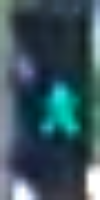

In [ ]:
traffic_light_roi_resized = cv2.resize(roi, (100, 200))  # 원하는 크기로 조절
cv2_imshow(traffic_light_roi_resized)

In [ ]:
traffic_light_color([0,0,100,200], traffic_light_roi_resized)

'green'

### Google Cloud Text to Speech API 사용

In [16]:
!pip install google-cloud-texttospeech

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 4.7 MB/s eta 0:00:00


In [30]:
import time
# 1s = 30frames

buffer = 0
fps= 30
last_audio_frame = 0
audio_frame_list = []
audio_list = []
space_frame_count = 0
space_frame_count_list = []
for i in range(len(current_comment_list)):
  if len(audio_frame_list) == 0:
    if current_comment_list[i]=="":
      last_audio_frame += 1
      space_frame_count += 1
    else:
      audio_name= comment_to_speech(current_comment_list[i], len(audio_list))
      audio_list.append(f"/content/{audio_name}")
      audio_frame_list.append(last_audio_frame)
      time.sleep(5)
      audio_length = get_audio_length(audio_list[-1]) # audio length 초단위
      last_audio_frame += round(audio_length * fps) +25 + buffer
      audio_frame_list.append(last_audio_frame)
      space_frame_count_list.append(space_frame_count)
      space_frame_count = 0
      buffer += 10
  else:
    if i in audio_frame_list:
      if current_comment_list[i]=="":
        last_audio_frame +=1
        space_frame_count += 1
        audio_frame_list[audio_frame_list.index(i)] += 1
      else:
        if i < len(current_comment_list):
          audio_name= comment_to_speech(current_comment_list[i], len(audio_list))
          audio_list.append(f"/content/{audio_name}")
          time.sleep(5)
          audio_length = get_audio_length(audio_list[-1])
          if audio_length + round(audio_length * fps) >len(current_comment_list):
            audio_list.pop()
          else:
            last_audio_frame += round(audio_length * fps) +25 + buffer
            audio_frame_list.append(last_audio_frame)
            space_frame_count_list.append(space_frame_count)
            space_frame_count = 0
            buffer += 10
    else:
      last_audio_frame += 1
      space_frame_count += 1


오디오 파일이 저장되었습니다.
오디오 파일이 저장되었습니다.
오디오 파일이 저장되었습니다.
오디오 파일이 저장되었습니다.
오디오 파일이 저장되었습니다.
오디오 파일이 저장되었습니다.
오디오 파일이 저장되었습니다.


In [2]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = ""# json 파일 위치

#### Comment를 speech로 생성하는 함수

In [3]:
from google.cloud import texttospeech

def comment_to_speech(text, index):
# 클라이언트 초기화
  client = texttospeech.TextToSpeechClient()

  # 텍스트 설정
  synthesis_input = texttospeech.SynthesisInput(text=text)

  # 음성 설정: 언어와 음성 선택
  voice = texttospeech.VoiceSelectionParams(
      language_code="ko-KR", ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL)

  # 오디오 설정: 오디오 포맷 선택
  audio_config = texttospeech.AudioConfig(
      audio_encoding=texttospeech.AudioEncoding.MP3,
      speaking_rate = 1.2)

  # API 요청 및 음성 변환 실행
  response = client.synthesize_speech(input=synthesis_input, voice=voice, audio_config=audio_config)

  file_path = f"output{index}.mp3"
  # 결과 오디오 파일 저장
  with open(file_path, "wb") as out:
      out.write(response.audio_content)
      print("오디오 파일이 저장되었습니다.")
  return file_path

#### 오디오 파일 길이 계산

In [4]:
!pip install pydub

In [5]:
from pydub import AudioSegment
import math

def get_audio_length(file_path):
    audio = AudioSegment.from_mp3(file_path)
    # return len(audio) / 1000.0  # 길이를 초 단위로 반환
    return math.ceil(len(audio) / 1000.0)

In [ ]:
file_path = '/content/output2.mp3'
length_seconds = get_audio_length(file_path)
print(f"오디오 파일 길이: {length_seconds} 초")

오디오 파일 길이: 1.56 초


In [ ]:
file_path = '/content/output2.mp3'
length_seconds = get_audio_length(file_path)
print(f"오디오 파일 길이: {length_seconds} 초")

오디오 파일 길이: 2 초


#### 오디오 파일들을 합치고, 공백을 추가하는 함수

In [47]:
from pydub import AudioSegment
from pydub.playback import play

def concatenate_audios_with_silence(file_paths, output_path, space_frame_count_list):
    buffer = 0
    # 오디오 파일들을 차례로 합치되, 각 파일 사이에 공백 추가
    for i in range(len(file_paths)):
      if i == 0:
        combined = AudioSegment.from_mp3(file_paths[i])
        if space_frame_count_list[i] >0:
          # silence_duration은 밀리초 단위
          silence = AudioSegment.silent(duration=(round(space_frame_count_list[i]/30*1000)-buffer))
          combined = silence + combined
          buffer += 1000
      else:
        next_audio = AudioSegment.from_mp3(file_paths[i])
        if i == (len(file_paths) - 2):
          silence = AudioSegment.silent(duration=(round(space_frame_count_list[i]/30*1000)-buffer + 10000))
          combined += silence + next_audio
        else:
          if space_frame_count_list[i] >0:
            silence = AudioSegment.silent(duration=(round(space_frame_count_list[i]/30*1000)-buffer))
            combined += silence + next_audio
            buffer += 1000
          else:
            combined += next_audio

    # 합쳐진 오디오 파일 저장
    combined.export(output_path, format="mp3")


In [48]:
output_path = 'combined_with_silence11.mp3'  # 출력 파일 경로
concatenate_audios_with_silence(audio_list,output_path, space_frame_count_list)

#### 오디오와 비디오 파일 합치기

In [7]:
!ffmpeg -version

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-l

In [49]:
!ffmpeg -i result17.avi -i combined_with_silence11.mp3 -c:v copy -c:a aac -strict experimental output_video4.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab